### Imports

In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath(
    os.path.join(os.path.dirname('__file__'), '..')))

In [2]:
# %pip install -r ../requirements.txt

In [3]:
from src.encoding.encoders import *
from src.models.sklearn_api_models_config import get_model
from src.experiments.base_experiment import BaseExperiment
from src.encoding.tools import create_encoding_pipeline
from src.datasets.base_tabular_dataset import BaseTabularDataset
from src.tools.utils import supprimer_fichier_feather_recursif
from src.location import Location
import src.features as ft
from src.experiments.features_selection import get_features, explore_features
from src.models.sklearn_api_model import Model, ModelTree

1 GPU(s) detected.


In [4]:
import logging
import datetime as dt
import pathlib
import numpy as np
import pandas as pd


In [5]:
from typing import List, Union, Optional
import mlflow.sklearn
import mlflow
import mlflow.data.pandas_dataset
from mlflow.models import infer_signature
import matplotlib.pyplot as plt
%matplotlib widget
import cudf as cd



In [6]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 30)

### Config

In [7]:
# Define a logger used by all modules
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.basicConfig(level=logging.INFO, encoding="utf-8",
                    format="%(name)s %(asctime)s: %(levelname)s: %(message)s", handlers=[logging.StreamHandler()])

In [8]:
# Define the root directory of the project
root_dir = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..'))
root_dir = pathlib.Path(root_dir)

##### Encoding Pipeline

In [9]:
# Define an encoding scheme to create the encoding pipeline
encoders_dict = {
    'number': {
        'as_number': {
            'imputers': [imputers.SimpleImputer(strategy='mean')],
            'encoders': [
                ne.StandardScaler(),
            ]
        }
    },
    'category': {
        'as_category': {
            'imputers': [imputers.SimpleImputer(strategy='most_frequent')],
            'encoders': [
                ne.MultiTargetEncoder(drop_invariant=True, return_df=True),
            ]
        }
    },
    'datetime': {
        'as_number': {
            'imputers': [de.DateFeatureExtractor()],
            'encoders': [
                ne.CyclicalFeatures(drop_original=True)
            ]
        },
        'as_category': {
            'imputers': [de.DateFeatureExtractor(dtype='category')],
            'encoders': [
                ne.MultiTargetEncoder(drop_invariant=True, return_df=True),
            ]
        }
    },
    'boolean': {
        'as_number': {
            'imputers': [imputers.SimpleImputer(strategy='most_frequent')],
             'encoders': [ne.BooleanEncoder()]
         }

    }
}

In [10]:
# Create the encoding pipeline
pipeline = create_encoding_pipeline(encoders_dict)

Creating encoding pipeline


In [11]:
pipeline

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('featureunion-1',
                                                  FeatureUnion(transformer_list=[('simpleimputer',
                                                                                  SimpleImputer())])),
                                                 ('featureunion-2',
                                                  FeatureUnion(transformer_list=[('standardscaler',
                                                                                  StandardScaler())]))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7af1654ef910>),
                                ('pipe...
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7af1654ee710>),
                                ('pipeline-5',
                                 Pipeline(steps=[('featureunion-1',
                                                  FeatureUnion(transformer_list=[('simpleimputer',
                                                                                  SimpleImputer(strategy='most_frequent'))])),
                                                 ('featureunion-2',
                                                  FeatureUnion(transformer_list=[('booleanencoder',
                                                                                  BooleanEncoder())]))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7af1654ef0d0>)],
                  verbose=True)

##### Dataset

In [12]:
data_start = '01-01-2019'
data_stop = '31-12-2023'

In [13]:
available_hospitals = [f.removeprefix("export_").removesuffix('.csv') for f in os.listdir("../data/features/hospitalfeatures/urgences/exports")]

In [14]:
# available_hospitals = [
#         # 'CH CHARTRES',
#         # 'HÔPITAL NORD FRANCHE COMTE',
#         # 'CH LES CHANAUX MACON',
#         # 'CHU DE TOURS',
#         # 'CHR ORLEANS',
#         # 'CHU BESANCON',
#         # 'CH DE CHATEAUROUX',
#         # 'GROUPEMENT HOSPITALIER DE HAUTE SAONE',
#         'CHU DIJON BOURGOGNE'
#     ]

for i, h in enumerate(available_hospitals):
    print(h)
    available_hospitals[i] = Location(name=h)

CHIC DE HAUTE-COMTÉ
HOSPICES CIVILS DE BEAUNE
CHU DIJON BOURGOGNE
CHIC AMBOISE- CHATEAU RENAULT
CH WILLIAM MOREY CHALON SUR SAONE
CH JEAN BOUVERI - GALUZOT
CHR ORLEANS
CH AGGLOMERATION MONTARGOISE
CH DE NOGENT LE ROTROU
HÔPITAL NORD FRANCHE COMTE
CH VENDOME
CH DE LA HAUTE COTE-D'OR - CH-HCO
CH J. COEUR BOURGES
CH DECIZE
CH DU VAL DE SAÔNE GRAY
CH D'AVALLON
HÔPITAL PRIVÉ D'EURE ET LOIR
GROUPEMENT HOSPITALIER DE HAUTE SAONE
CH DE GIEN
HÔPITAL PRIVÉ DIJON BOURGOGNE
CH SENS
ORELIANCE - REINE BLANCHE
SAS NOUVELLE CLINIQUE DE TOURS +
CH CHARTRES
CH DE CHATEAUDUN
CH ROBERT MORLEVAT SEMUR EN AUXOIS
CH LA TOUR BLANCHE ISSOUDUN
CH LOCHES
CH DE PITHIVIERS
CH COSNE COURS SUR LOIRE
CH CHINONAIS
CH VICTOR JOUSSELIN
CH VIERZON
CH LEON BERARD MOREZ
CH LOUIS JAILLON SAINT CLAUDE
CH DU TONNERROIS
POLYCLINIQUE STE MARGUERITE AUXERRE
CH DE JOIGNY
CHU DE TOURS
CH DE L'AGGLOMÉRATION DE NEVERS
CH ROMORANTIN LANTHENAY
CH DE CLAMECY
CHU BESANCON
HOTEL-DIEU DU CREUSOT
CH DU PAYS CHAROLAIS BRIONNAIS
CLINIQUE MÉD

In [15]:
# Define the configuration for the fetching of the data
fetch_config = {
    "data_start": data_start,
    "data_stop": data_stop,
    'data_dir': root_dir / 'data',
    "locations": available_hospitals
    }

In [16]:
# Select the features to be used in the dataset
ars_features_class = [
    ft.HospitalFeatures,
    ft.AirQualityFeatures,
    ft.EpidemiologicalFeatures,
    # ft.FireFightersFeatures(include_calls=False),
    # ft.GoogleTrendFeatures,
    ft.MeteorologicalFeatures,
    ft.SociologicalFeatures,
    ft.SportsCompetitionFeatures,
    ft.TrafficFeatures
    ]

In [17]:

dossiers_a_parcourir = [
    "../data/features"
]

# supprimer_fichier_feather_recursif(dossiers_a_parcourir)

In [18]:
get_dataset_config = {
    'from_date': data_start,
    'to_date': data_stop,
    'locations': available_hospitals,
    'axis': 'rows',
    'shift': range(1, 8, 1),
    'rolling_window': [14, 31, 365],
    'freq': '1D',
    'split_config': {'test_size': 0.2, 'val_size': 0.2, 'shuffle': False},
    'create_X_y': True,
    'encoding_pipeline': pipeline,
    'targets_names': ['hospital_nb_emergencies'], #'hospital_nb_emergencies', 'hospital_nb_hospit_np_from_ED_children', 'hospital_nb_hospit_np_from_ED_adults'
    'targets_shift': -3,
    'targets_rolling_window': 3,
    'targets_history_shifts': range(1, 8, 1),
    'targets_history_rolling_windows': [7, 14, 31, 365],
    'targets_locations': available_hospitals,
    'drop_constant_thr': np.inf,
    'data_dir': root_dir / 'data'
}

In [19]:
# Create the dataset and fetch the data from the source then call get_dataset() method to fill the different attributes (X and y) of the different sets, and their encodings
arsTabularDataset = BaseTabularDataset(features_classes=ars_features_class, logger=logger, fetch_config=fetch_config, getter_config=get_dataset_config)

root 2024-12-24 11:59:53,371: INFO: Initialisation de la classe BaseTabularDataset
root 2024-12-24 11:59:53,375: INFO: Initialisation des features
root 2024-12-24 11:59:53,376: INFO: Fetching dataset
root 2024-12-24 11:59:53,377: INFO: hospitalfeatures's data already fetched for CHIC DE HAUTE-COMTÉ


hospital_nb_emergencies  hospital_nb_hospit_np_from_ED_children  \
date                                                                          
2019-01-01                       66                                       0   
2019-01-02                       86                                       0   
2019-01-03                       83                                       0   
2019-01-04                       63                                       0   
2019-01-05                       79                                       0   
...                             ...                                     ...   
2023-12-27                       84                                       0   
2023-12-28                       76                                       0   
2023-12-29                       93                                       0   
2023-12-30                       96                                       0   
2023-12-31                       72                                       0   

            hospital_nb_hospit_np_from_ED_adults  
date                                              
2019-01-01                                    15  
2019-01-02                                    22  
2019-01-03                                    23  
2019-01-04                                    12  
2019-01-05                                    13  
...                                          ...  
2023-12-27                                    17  
2023-12-28                                    14  
2023-12-29                                    22  
2023-12-30                                    17  
2023-12-31                                    12  

[1826 rows x 3 columns]

root 2024-12-24 11:59:53,388: INFO: hospitalfeatures's data already fetched for HOSPICES CIVILS DE BEAUNE


hospital_nb_emergencies  hospital_nb_hospit_np_from_ED_children  \
date                                                                          
2019-01-01                       54                                       0   
2019-01-02                       64                                       0   
2019-01-03                       54                                       0   
2019-01-04                       61                                       0   
2019-01-05                       60                                       0   
...                             ...                                     ...   
2023-12-27                       55                                       0   
2023-12-28                       57                                       0   
2023-12-29                       68                                       0   
2023-12-30                       54                                       0   
2023-12-31                       45                                       0   

            hospital_nb_hospit_np_from_ED_adults  
date                                              
2019-01-01                                    10  
2019-01-02                                    10  
2019-01-03                                    10  
2019-01-04                                    10  
2019-01-05                                    10  
...                                          ...  
2023-12-27                                    17  
2023-12-28                                    14  
2023-12-29                                    17  
2023-12-30                                    10  
2023-12-31                                    10  

[1826 rows x 3 columns]

root 2024-12-24 11:59:53,398: INFO: hospitalfeatures's data already fetched for CHU DIJON BOURGOGNE


hospital_nb_emergencies  hospital_nb_hospit_np_from_ED_children  \
date                                                                          
2019-01-01                      202                                       7   
2019-01-02                      198                                      12   
2019-01-03                      186                                      11   
2019-01-04                      186                                       9   
2019-01-05                      204                                      15   
...                             ...                                     ...   
2023-12-27                      165                                       9   
2023-12-28                      192                                      17   
2023-12-29                      157                                      12   
2023-12-30                      212                                      11   
2023-12-31                      189                                      12   

            hospital_nb_hospit_np_from_ED_adults  
date                                              
2019-01-01                                    46  
2019-01-02                                    50  
2019-01-03                                    44  
2019-01-04                                    49  
2019-01-05                                    41  
...                                          ...  
2023-12-27                                    36  
2023-12-28                                    46  
2023-12-29                                    44  
2023-12-30                                    34  
2023-12-31                                    35  

[1826 rows x 3 columns]

root 2024-12-24 11:59:53,406: INFO: hospitalfeatures's data already fetched for CHIC AMBOISE- CHATEAU RENAULT


hospital_nb_emergencies  hospital_nb_hospit_np_from_ED_children  \
date                                                                          
2019-01-01                       46                                       0   
2019-01-02                       62                                       0   
2019-01-03                       57                                       0   
2019-01-04                       59                                       0   
2019-01-05                       41                                       0   
...                             ...                                     ...   
2023-12-27                       47                                       0   
2023-12-28                       44                                       0   
2023-12-29                       44                                       0   
2023-12-30                       44                                       0   
2023-12-31                       43                                       0   

            hospital_nb_hospit_np_from_ED_adults  
date                                              
2019-01-01                                    10  
2019-01-02                                    21  
2019-01-03                                    14  
2019-01-04                                    22  
2019-01-05                                    10  
...                                          ...  
2023-12-27                                    46  
2023-12-28                                    41  
2023-12-29                                    43  
2023-12-30                                    43  
2023-12-31                                    43  

[1826 rows x 3 columns]

root 2024-12-24 11:59:53,413: INFO: hospitalfeatures's data already fetched for CH WILLIAM MOREY CHALON SUR SAONE


hospital_nb_emergencies  hospital_nb_hospit_np_from_ED_children  \
date                                                                          
2019-01-01                      183                                       8   
2019-01-02                      175                                       4   
2019-01-03                      164                                      10   
2019-01-04                      156                                       2   
2019-01-05                      186                                       6   
...                             ...                                     ...   
2023-12-27                      171                                       5   
2023-12-28                      163                                       7   
2023-12-29                      179                                      11   
2023-12-30                      138                                       9   
2023-12-31                      152                                       7   

            hospital_nb_hospit_np_from_ED_adults  
date                                              
2019-01-01                                    17  
2019-01-02                                    31  
2019-01-03                                    26  
2019-01-04                                    23  
2019-01-05                                    17  
...                                          ...  
2023-12-27                                    28  
2023-12-28                                    27  
2023-12-29                                    25  
2023-12-30                                    22  
2023-12-31                                    24  

[1826 rows x 3 columns]

root 2024-12-24 11:59:53,419: INFO: hospitalfeatures's data already fetched for CH JEAN BOUVERI - GALUZOT


hospital_nb_emergencies  hospital_nb_hospit_np_from_ED_children  \
date                                                                          
2019-01-01                       55                                       0   
2019-01-02                       57                                       0   
2019-01-03                       61                                       0   
2019-01-04                       67                                       0   
2019-01-05                       53                                       0   
...                             ...                                     ...   
2023-12-27                       53                                       0   
2023-12-28                       59                                       0   
2023-12-29                       65                                       0   
2023-12-30                       55                                       0   
2023-12-31                       41                                       0   

            hospital_nb_hospit_np_from_ED_adults  
date                                              
2019-01-01                                    18  
2019-01-02                                    12  
2019-01-03                                    15  
2019-01-04                                    13  
2019-01-05                                    10  
...                                          ...  
2023-12-27                                    14  
2023-12-28                                    16  
2023-12-29                                    10  
2023-12-30                                    19  
2023-12-31                                    10  

[1826 rows x 3 columns]

root 2024-12-24 11:59:53,424: INFO: hospitalfeatures's data already fetched for CHR ORLEANS


hospital_nb_emergencies  hospital_nb_hospit_np_from_ED_children  \
date                                                                          
2019-01-01                      315                                       0   
2019-01-02                      371                                       0   
2019-01-03                      327                                       0   
2019-01-04                      326                                       0   
2019-01-05                      307                                       0   
...                             ...                                     ...   
2023-12-27                      292                                       9   
2023-12-28                      288                                       8   
2023-12-29                      151                                       4   
2023-12-30                      274                                       5   
2023-12-31                      218                                      14   

            hospital_nb_hospit_np_from_ED_adults  
date                                              
2019-01-01                                    67  
2019-01-02                                    97  
2019-01-03                                    75  
2019-01-04                                    80  
2019-01-05                                    60  
...                                          ...  
2023-12-27                                    48  
2023-12-28                                    40  
2023-12-29                                    10  
2023-12-30                                    39  
2023-12-31                                    30  

[1826 rows x 3 columns]

root 2024-12-24 11:59:53,430: INFO: hospitalfeatures's data already fetched for CH AGGLOMERATION MONTARGOISE


hospital_nb_emergencies  hospital_nb_hospit_np_from_ED_children  \
date                                                                          
2019-01-01                      202                                       0   
2019-01-02                      264                                       0   
2019-01-03                      248                                       0   
2019-01-04                      207                                       0   
2019-01-05                      184                                       0   
...                             ...                                     ...   
2023-12-27                      237                                       0   
2023-12-28                      192                                       0   
2023-12-29                      216                                       0   
2023-12-30                      198                                       0   
2023-12-31                      171                                       0   

            hospital_nb_hospit_np_from_ED_adults  
date                                              
2019-01-01                                    10  
2019-01-02                                    10  
2019-01-03                                    10  
2019-01-04                                    10  
2019-01-05                                    10  
...                                          ...  
2023-12-27                                    26  
2023-12-28                                    23  
2023-12-29                                    22  
2023-12-30                                    16  
2023-12-31                                    14  

[1826 rows x 3 columns]

root 2024-12-24 11:59:53,442: INFO: hospitalfeatures's data already fetched for CH DE NOGENT LE ROTROU


hospital_nb_emergencies  hospital_nb_hospit_np_from_ED_children  \
date                                                                          
2019-01-01                       40                                       0   
2019-01-02                       48                                       0   
2019-01-03                       49                                       0   
2019-01-04                       40                                       0   
2019-01-05                       44                                       0   
...                             ...                                     ...   
2023-12-27                       59                                       0   
2023-12-28                       51                                       0   
2023-12-29                       52                                       0   
2023-12-30                       52                                       0   
2023-12-31                       40                                       0   

            hospital_nb_hospit_np_from_ED_adults  
date                                              
2019-01-01                                    10  
2019-01-02                                    12  
2019-01-03                                    14  
2019-01-04                                    10  
2019-01-05                                    10  
...                                          ...  
2023-12-27                                    10  
2023-12-28                                    10  
2023-12-29                                    10  
2023-12-30                                    10  
2023-12-31                                    10  

[1826 rows x 3 columns]

root 2024-12-24 11:59:53,456: INFO: hospitalfeatures's data already fetched for HÔPITAL NORD FRANCHE COMTE


hospital_nb_emergencies  hospital_nb_hospit_np_from_ED_children  \
date                                                                          
2019-01-01                      203                                       0   
2019-01-02                      213                                       0   
2019-01-03                      228                                       0   
2019-01-04                      233                                       0   
2019-01-05                      215                                       0   
...                             ...                                     ...   
2023-12-27                      330                                       8   
2023-12-28                      280                                       7   
2023-12-29                      282                                       5   
2023-12-30                      286                                       3   
2023-12-31                      192                                       6   

            hospital_nb_hospit_np_from_ED_adults  
date                                              
2019-01-01                                    10  
2019-01-02                                    36  
2019-01-03                                    33  
2019-01-04                                    39  
2019-01-05                                    36  
...                                          ...  
2023-12-27                                    44  
2023-12-28                                    38  
2023-12-29                                    36  
2023-12-30                                    44  
2023-12-31                                    22  

[1826 rows x 3 columns]

root 2024-12-24 11:59:53,465: INFO: hospitalfeatures's data already fetched for CH VENDOME


hospital_nb_emergencies  hospital_nb_hospit_np_from_ED_children  \
date                                                                          
2019-01-01                       49                                       0   
2019-01-02                       64                                       0   
2019-01-03                       68                                       0   
2019-01-04                       68                                       0   
2019-01-05                       70                                       0   
...                             ...                                     ...   
2023-12-27                       57                                       0   
2023-12-28                       68                                       0   
2023-12-29                       74                                       0   
2023-12-30                       67                                       0   
2023-12-31                       53                                       0   

            hospital_nb_hospit_np_from_ED_adults  
date                                              
2019-01-01                                    10  
2019-01-02                                    14  
2019-01-03                                    15  
2019-01-04                                    14  
2019-01-05                                    10  
...                                          ...  
2023-12-27                                    10  
2023-12-28                                    10  
2023-12-29                                    10  
2023-12-30                                    10  
2023-12-31                                    10  

[1826 rows x 3 columns]

root 2024-12-24 11:59:53,473: INFO: hospitalfeatures's data already fetched for CH DE LA HAUTE COTE-D'OR - CH-HCO


hospital_nb_emergencies  hospital_nb_hospit_np_from_ED_children  \
date                                                                          
2019-01-01                       25                                       0   
2019-01-02                       32                                       0   
2019-01-03                       39                                       0   
2019-01-04                       35                                       0   
2019-01-05                       30                                       0   
...                             ...                                     ...   
2023-12-27                       41                                       0   
2023-12-28                       44                                       0   
2023-12-29                       38                                       0   
2023-12-30                       40                                       0   
2023-12-31                       24                                       0   

            hospital_nb_hospit_np_from_ED_adults  
date                                              
2019-01-01                                    10  
2019-01-02                                    10  
2019-01-03                                    10  
2019-01-04                                    13  
2019-01-05                                    10  
...                                          ...  
2023-12-27                                    14  
2023-12-28                                    16  
2023-12-29                                    10  
2023-12-30                                    10  
2023-12-31                                    10  

[1826 rows x 3 columns]

root 2024-12-24 11:59:53,480: INFO: hospitalfeatures's data already fetched for CH J. COEUR BOURGES


hospital_nb_emergencies  hospital_nb_hospit_np_from_ED_children  \
date                                                                          
2019-01-01                       89                                       0   
2019-01-02                       90                                       0   
2019-01-03                       99                                       0   
2019-01-04                      118                                       0   
2019-01-05                       97                                       0   
...                             ...                                     ...   
2023-12-27                      161                                       0   
2023-12-28                      149                                       0   
2023-12-29                      147                                       0   
2023-12-30                      140                                       0   
2023-12-31                      108                                       0   

            hospital_nb_hospit_np_from_ED_adults  
date                                              
2019-01-01                                    10  
2019-01-02                                    10  
2019-01-03                                    10  
2019-01-04                                    10  
2019-01-05                                    10  
...                                          ...  
2023-12-27                                    33  
2023-12-28                                    30  
2023-12-29                                    27  
2023-12-30                                    35  
2023-12-31                                    22  

[1826 rows x 3 columns]

root 2024-12-24 11:59:53,485: INFO: hospitalfeatures's data already fetched for CH DECIZE


hospital_nb_emergencies  hospital_nb_hospit_np_from_ED_children  \
date                                                                          
2019-01-01                       33                                       0   
2019-01-02                       29                                       0   
2019-01-03                       28                                       0   
2019-01-04                       24                                       0   
2019-01-05                       23                                       0   
...                             ...                                     ...   
2023-12-27                       36                                       0   
2023-12-28                       30                                       0   
2023-12-29                       27                                       0   
2023-12-30                       39                                       0   
2023-12-31                       19                                       0   

            hospital_nb_hospit_np_from_ED_adults  
date                                              
2019-01-01                                    10  
2019-01-02                                    10  
2019-01-03                                    10  
2019-01-04                                    10  
2019-01-05                                    10  
...                                          ...  
2023-12-27                                    10  
2023-12-28                                    10  
2023-12-29                                    10  
2023-12-30                                    10  
2023-12-31                                    10  

[1826 rows x 3 columns]

root 2024-12-24 11:59:53,490: INFO: hospitalfeatures's data already fetched for CH DU VAL DE SAÔNE GRAY


hospital_nb_emergencies  hospital_nb_hospit_np_from_ED_children  \
date                                                                          
2019-01-01                       22                                       0   
2019-01-02                       31                                       0   
2019-01-03                       21                                       0   
2019-01-04                       23                                       0   
2019-01-05                       25                                       0   
...                             ...                                     ...   
2023-12-27                       10                                       0   
2023-12-28                       10                                       0   
2023-12-29                       10                                       0   
2023-12-30                       10                                       0   
2023-12-31                       10                                       0   

            hospital_nb_hospit_np_from_ED_adults  
date                                              
2019-01-01                                    10  
2019-01-02                                    10  
2019-01-03                                    10  
2019-01-04                                    10  
2019-01-05                                    10  
...                                          ...  
2023-12-27                                    10  
2023-12-28                                    10  
2023-12-29                                    10  
2023-12-30                                    10  
2023-12-31                                    10  

[1826 rows x 3 columns]

root 2024-12-24 11:59:53,497: INFO: hospitalfeatures's data already fetched for CH D'AVALLON


hospital_nb_emergencies  hospital_nb_hospit_np_from_ED_children  \
date                                                                          
2019-01-01                       30                                       0   
2019-01-02                       37                                       0   
2019-01-03                       39                                       0   
2019-01-04                       34                                       0   
2019-01-05                       33                                       0   
...                             ...                                     ...   
2023-12-27                       48                                       0   
2023-12-28                       43                                       0   
2023-12-29                       49                                       0   
2023-12-30                       44                                       0   
2023-12-31                       42                                       0   

            hospital_nb_hospit_np_from_ED_adults  
date                                              
2019-01-01                                    10  
2019-01-02                                    10  
2019-01-03                                    10  
2019-01-04                                    10  
2019-01-05                                    10  
...                                          ...  
2023-12-27                                    10  
2023-12-28                                    10  
2023-12-29                                    10  
2023-12-30                                    10  
2023-12-31                                    10  

[1826 rows x 3 columns]

root 2024-12-24 11:59:53,503: INFO: hospitalfeatures's data already fetched for HÔPITAL PRIVÉ D'EURE ET LOIR


hospital_nb_emergencies  hospital_nb_hospit_np_from_ED_children  \
date                                                                          
2019-01-01                       47                                       0   
2019-01-02                      110                                       0   
2019-01-03                       81                                       0   
2019-01-04                       70                                       0   
2019-01-05                       74                                       0   
...                             ...                                     ...   
2023-12-27                       94                                       0   
2023-12-28                       90                                       0   
2023-12-29                       95                                       0   
2023-12-30                       86                                       0   
2023-12-31                       44                                       0   

            hospital_nb_hospit_np_from_ED_adults  
date                                              
2019-01-01                                    10  
2019-01-02                                    10  
2019-01-03                                    10  
2019-01-04                                    10  
2019-01-05                                    10  
...                                          ...  
2023-12-27                                    10  
2023-12-28                                    10  
2023-12-29                                    10  
2023-12-30                                    10  
2023-12-31                                    10  

[1826 rows x 3 columns]

root 2024-12-24 11:59:53,508: INFO: hospitalfeatures's data already fetched for GROUPEMENT HOSPITALIER DE HAUTE SAONE


hospital_nb_emergencies  hospital_nb_hospit_np_from_ED_children  \
date                                                                          
2019-01-01                      141                                       0   
2019-01-02                      157                                       0   
2019-01-03                      127                                       0   
2019-01-04                      119                                       0   
2019-01-05                      123                                       0   
...                             ...                                     ...   
2023-12-27                      155                                       0   
2023-12-28                      126                                       0   
2023-12-29                      149                                       0   
2023-12-30                      140                                       0   
2023-12-31                      102                                       0   

            hospital_nb_hospit_np_from_ED_adults  
date                                              
2019-01-01                                    32  
2019-01-02                                    55  
2019-01-03                                    40  
2019-01-04                                    42  
2019-01-05                                    45  
...                                          ...  
2023-12-27                                    40  
2023-12-28                                    37  
2023-12-29                                    39  
2023-12-30                                    42  
2023-12-31                                    20  

[1826 rows x 3 columns]

root 2024-12-24 11:59:53,513: INFO: hospitalfeatures's data already fetched for CH DE GIEN


hospital_nb_emergencies  hospital_nb_hospit_np_from_ED_children  \
date                                                                          
2019-01-01                       56                                       0   
2019-01-02                      106                                       0   
2019-01-03                       96                                       0   
2019-01-04                       93                                       0   
2019-01-05                       68                                       0   
...                             ...                                     ...   
2023-12-27                      115                                       0   
2023-12-28                       85                                       0   
2023-12-29                       87                                       0   
2023-12-30                       61                                       0   
2023-12-31                       48                                       0   

            hospital_nb_hospit_np_from_ED_adults  
date                                              
2019-01-01                                    14  
2019-01-02                                    18  
2019-01-03                                    26  
2019-01-04                                    19  
2019-01-05                                    19  
...                                          ...  
2023-12-27                                    27  
2023-12-28                                    10  
2023-12-29                                    18  
2023-12-30                                    16  
2023-12-31                                    13  

[1826 rows x 3 columns]

root 2024-12-24 11:59:53,520: INFO: hospitalfeatures's data already fetched for HÔPITAL PRIVÉ DIJON BOURGOGNE


hospital_nb_emergencies  hospital_nb_hospit_np_from_ED_children  \
date                                                                          
2019-01-01                       72                                       0   
2019-01-02                       76                                       0   
2019-01-03                       83                                       0   
2019-01-04                       69                                       0   
2019-01-05                       78                                       0   
...                             ...                                     ...   
2023-12-27                      107                                       0   
2023-12-28                      102                                       0   
2023-12-29                      105                                       0   
2023-12-30                       97                                       0   
2023-12-31                       50                                       0   

            hospital_nb_hospit_np_from_ED_adults  
date                                              
2019-01-01                                    30  
2019-01-02                                    30  
2019-01-03                                    34  
2019-01-04                                    23  
2019-01-05                                    30  
...                                          ...  
2023-12-27                                    10  
2023-12-28                                    13  
2023-12-29                                    10  
2023-12-30                                    13  
2023-12-31                                    10  

[1826 rows x 3 columns]

root 2024-12-24 11:59:53,531: INFO: hospitalfeatures's data already fetched for CH SENS


hospital_nb_emergencies  hospital_nb_hospit_np_from_ED_children  \
date                                                                          
2019-01-01                      123                                       4   
2019-01-02                      132                                       5   
2019-01-03                      129                                       5   
2019-01-04                      119                                       2   
2019-01-05                      122                                       2   
...                             ...                                     ...   
2023-12-27                      174                                       0   
2023-12-28                      137                                       1   
2023-12-29                      161                                       4   
2023-12-30                      156                                       3   
2023-12-31                      130                                       1   

            hospital_nb_hospit_np_from_ED_adults  
date                                              
2019-01-01                                    23  
2019-01-02                                    20  
2019-01-03                                    13  
2019-01-04                                    24  
2019-01-05                                    22  
...                                          ...  
2023-12-27                                    23  
2023-12-28                                    19  
2023-12-29                                    22  
2023-12-30                                    19  
2023-12-31                                    18  

[1826 rows x 3 columns]

root 2024-12-24 11:59:53,540: INFO: hospitalfeatures's data already fetched for ORELIANCE - REINE BLANCHE


hospital_nb_emergencies  hospital_nb_hospit_np_from_ED_children  \
date                                                                          
2019-01-01                       52                                       0   
2019-01-02                      106                                       0   
2019-01-03                       99                                       0   
2019-01-04                       85                                       0   
2019-01-05                       68                                       0   
...                             ...                                     ...   
2023-12-27                      122                                       0   
2023-12-28                      115                                       0   
2023-12-29                      101                                       0   
2023-12-30                       94                                       0   
2023-12-31                       59                                       0   

            hospital_nb_hospit_np_from_ED_adults  
date                                              
2019-01-01                                    10  
2019-01-02                                    10  
2019-01-03                                    10  
2019-01-04                                    10  
2019-01-05                                    10  
...                                          ...  
2023-12-27                                    10  
2023-12-28                                    10  
2023-12-29                                    10  
2023-12-30                                    10  
2023-12-31                                    10  

[1826 rows x 3 columns]

root 2024-12-24 11:59:53,553: INFO: hospitalfeatures's data already fetched for SAS NOUVELLE CLINIQUE DE TOURS +


hospital_nb_emergencies  hospital_nb_hospit_np_from_ED_children  \
date                                                                          
2019-01-01                       50                                       0   
2019-01-02                       79                                       0   
2019-01-03                       66                                       0   
2019-01-04                       67                                       0   
2019-01-05                       64                                       0   
...                             ...                                     ...   
2023-12-27                       72                                       0   
2023-12-28                       78                                       0   
2023-12-29                       79                                       0   
2023-12-30                       75                                       0   
2023-12-31                       59                                       0   

            hospital_nb_hospit_np_from_ED_adults  
date                                              
2019-01-01                                    10  
2019-01-02                                    10  
2019-01-03                                    10  
2019-01-04                                    10  
2019-01-05                                    10  
...                                          ...  
2023-12-27                                    12  
2023-12-28                                    10  
2023-12-29                                    10  
2023-12-30                                    10  
2023-12-31                                    10  

[1826 rows x 3 columns]

root 2024-12-24 11:59:53,568: INFO: hospitalfeatures's data already fetched for CH CHARTRES


hospital_nb_emergencies  hospital_nb_hospit_np_from_ED_children  \
date                                                                          
2019-01-01                      168                                       0   
2019-01-02                      248                                       0   
2019-01-03                      198                                       0   
2019-01-04                      227                                       0   
2019-01-05                      174                                       0   
...                             ...                                     ...   
2023-12-27                      200                                       0   
2023-12-28                      196                                       0   
2023-12-29                      204                                       0   
2023-12-30                      177                                       0   
2023-12-31                      143                                       0   

            hospital_nb_hospit_np_from_ED_adults  
date                                              
2019-01-01                                    39  
2019-01-02                                    55  
2019-01-03                                    50  
2019-01-04                                    39  
2019-01-05                                    42  
...                                          ...  
2023-12-27                                    27  
2023-12-28                                    28  
2023-12-29                                    36  
2023-12-30                                    23  
2023-12-31                                    39  

[1826 rows x 3 columns]

root 2024-12-24 11:59:53,579: INFO: hospitalfeatures's data already fetched for CH DE CHATEAUDUN


hospital_nb_emergencies  hospital_nb_hospit_np_from_ED_children  \
date                                                                          
2019-01-01                       43                                       0   
2019-01-02                       49                                       0   
2019-01-03                       45                                       0   
2019-01-04                       32                                       0   
2019-01-05                       47                                       0   
...                             ...                                     ...   
2023-12-27                       54                                       0   
2023-12-28                       51                                       0   
2023-12-29                       44                                       0   
2023-12-30                       71                                       0   
2023-12-31                       37                                       0   

            hospital_nb_hospit_np_from_ED_adults  
date                                              
2019-01-01                                    16  
2019-01-02                                    15  
2019-01-03                                    10  
2019-01-04                                    10  
2019-01-05                                    10  
...                                          ...  
2023-12-27                                    10  
2023-12-28                                    10  
2023-12-29                                    10  
2023-12-30                                    10  
2023-12-31                                    10  

[1826 rows x 3 columns]

root 2024-12-24 11:59:53,586: INFO: hospitalfeatures's data already fetched for CH ROBERT MORLEVAT SEMUR EN AUXOIS


hospital_nb_emergencies  hospital_nb_hospit_np_from_ED_children  \
date                                                                          
2019-01-01                       39                                       0   
2019-01-02                       69                                       0   
2019-01-03                       66                                       0   
2019-01-04                       62                                       0   
2019-01-05                       47                                       0   
...                             ...                                     ...   
2023-12-27                       88                                       0   
2023-12-28                      101                                       0   
2023-12-29                       97                                       0   
2023-12-30                       68                                       0   
2023-12-31                       48                                       0   

            hospital_nb_hospit_np_from_ED_adults  
date                                              
2019-01-01                                    10  
2019-01-02                                    20  
2019-01-03                                    22  
2019-01-04                                    16  
2019-01-05                                    10  
...                                          ...  
2023-12-27                                    20  
2023-12-28                                    28  
2023-12-29                                    15  
2023-12-30                                    17  
2023-12-31                                    10  

[1826 rows x 3 columns]

root 2024-12-24 11:59:53,592: INFO: hospitalfeatures's data already fetched for CH LA TOUR BLANCHE ISSOUDUN


hospital_nb_emergencies  hospital_nb_hospit_np_from_ED_children  \
date                                                                          
2019-01-01                       39                                       0   
2019-01-02                       51                                       0   
2019-01-03                       34                                       0   
2019-01-04                       40                                       0   
2019-01-05                       43                                       0   
...                             ...                                     ...   
2023-12-27                       51                                       0   
2023-12-28                       39                                       0   
2023-12-29                       42                                       0   
2023-12-30                       27                                       0   
2023-12-31                       30                                       0   

            hospital_nb_hospit_np_from_ED_adults  
date                                              
2019-01-01                                    10  
2019-01-02                                    16  
2019-01-03                                    10  
2019-01-04                                    10  
2019-01-05                                    10  
...                                          ...  
2023-12-27                                    10  
2023-12-28                                    10  
2023-12-29                                    10  
2023-12-30                                    10  
2023-12-31                                    10  

[1826 rows x 3 columns]

root 2024-12-24 11:59:53,597: INFO: hospitalfeatures's data already fetched for CH LOCHES


hospital_nb_emergencies  hospital_nb_hospit_np_from_ED_children  \
date                                                                          
2019-01-01                       37                                       0   
2019-01-02                       58                                       0   
2019-01-03                       43                                       0   
2019-01-04                       39                                       0   
2019-01-05                       34                                       0   
...                             ...                                     ...   
2023-12-27                       42                                       0   
2023-12-28                       44                                       0   
2023-12-29                       55                                       0   
2023-12-30                       29                                       0   
2023-12-31                       10                                       0   

            hospital_nb_hospit_np_from_ED_adults  
date                                              
2019-01-01                                    10  
2019-01-02                                    10  
2019-01-03                                    10  
2019-01-04                                    10  
2019-01-05                                    10  
...                                          ...  
2023-12-27                                    10  
2023-12-28                                    10  
2023-12-29                                    10  
2023-12-30                                    10  
2023-12-31                                    10  

[1826 rows x 3 columns]

root 2024-12-24 11:59:53,601: INFO: hospitalfeatures's data already fetched for CH DE PITHIVIERS


hospital_nb_emergencies  hospital_nb_hospit_np_from_ED_children  \
date                                                                          
2019-01-01                       37                                       0   
2019-01-02                       47                                       0   
2019-01-03                       40                                       0   
2019-01-04                       31                                       0   
2019-01-05                       47                                       0   
...                             ...                                     ...   
2023-12-27                       44                                       0   
2023-12-28                       50                                       0   
2023-12-29                       45                                       0   
2023-12-30                       28                                       0   
2023-12-31                       19                                       0   

            hospital_nb_hospit_np_from_ED_adults  
date                                              
2019-01-01                                    10  
2019-01-02                                    10  
2019-01-03                                    10  
2019-01-04                                    10  
2019-01-05                                    10  
...                                          ...  
2023-12-27                                    10  
2023-12-28                                    10  
2023-12-29                                    10  
2023-12-30                                    10  
2023-12-31                                    10  

[1826 rows x 3 columns]

root 2024-12-24 11:59:53,606: INFO: hospitalfeatures's data already fetched for CH COSNE COURS SUR LOIRE


hospital_nb_emergencies  hospital_nb_hospit_np_from_ED_children  \
date                                                                          
2019-01-01                       41                                       0   
2019-01-02                       36                                       0   
2019-01-03                       27                                       0   
2019-01-04                       32                                       0   
2019-01-05                       42                                       0   
...                             ...                                     ...   
2023-12-27                       39                                       0   
2023-12-28                       39                                       0   
2023-12-29                       37                                       0   
2023-12-30                       39                                       0   
2023-12-31                       28                                       0   

            hospital_nb_hospit_np_from_ED_adults  
date                                              
2019-01-01                                    10  
2019-01-02                                    10  
2019-01-03                                    10  
2019-01-04                                    10  
2019-01-05                                    10  
...                                          ...  
2023-12-27                                    10  
2023-12-28                                    10  
2023-12-29                                    10  
2023-12-30                                    10  
2023-12-31                                    10  

[1826 rows x 3 columns]

root 2024-12-24 11:59:53,611: INFO: hospitalfeatures's data already fetched for CH CHINONAIS


hospital_nb_emergencies  hospital_nb_hospit_np_from_ED_children  \
date                                                                          
2019-01-01                       44                                       0   
2019-01-02                       53                                       0   
2019-01-03                       43                                       0   
2019-01-04                       51                                       0   
2019-01-05                       37                                       0   
...                             ...                                     ...   
2023-12-27                       38                                       0   
2023-12-28                       38                                       0   
2023-12-29                       44                                       0   
2023-12-30                       44                                       0   
2023-12-31                       45                                       0   

            hospital_nb_hospit_np_from_ED_adults  
date                                              
2019-01-01                                    10  
2019-01-02                                    10  
2019-01-03                                    10  
2019-01-04                                    10  
2019-01-05                                    10  
...                                          ...  
2023-12-27                                    10  
2023-12-28                                    10  
2023-12-29                                    10  
2023-12-30                                    10  
2023-12-31                                    10  

[1826 rows x 3 columns]

root 2024-12-24 11:59:53,616: INFO: hospitalfeatures's data already fetched for CH VICTOR JOUSSELIN


hospital_nb_emergencies  hospital_nb_hospit_np_from_ED_children  \
date                                                                          
2019-01-01                      115                                       0   
2019-01-02                      148                                       0   
2019-01-03                      139                                       0   
2019-01-04                      133                                       0   
2019-01-05                      109                                       0   
...                             ...                                     ...   
2023-12-27                      212                                       0   
2023-12-28                      208                                       0   
2023-12-29                      234                                       0   
2023-12-30                      245                                       0   
2023-12-31                      193                                       0   

            hospital_nb_hospit_np_from_ED_adults  
date                                              
2019-01-01                                    15  
2019-01-02                                    20  
2019-01-03                                    21  
2019-01-04                                    27  
2019-01-05                                    20  
...                                          ...  
2023-12-27                                    16  
2023-12-28                                    22  
2023-12-29                                    20  
2023-12-30                                    28  
2023-12-31                                    10  

[1826 rows x 3 columns]

root 2024-12-24 11:59:53,621: INFO: hospitalfeatures's data already fetched for CH VIERZON


hospital_nb_emergencies  hospital_nb_hospit_np_from_ED_children  \
date                                                                          
2019-01-01                       62                                       0   
2019-01-02                       69                                       0   
2019-01-03                       74                                       0   
2019-01-04                       62                                       0   
2019-01-05                       67                                       0   
...                             ...                                     ...   
2023-12-27                       76                                       0   
2023-12-28                       67                                       0   
2023-12-29                       66                                       0   
2023-12-30                       80                                       0   
2023-12-31                       66                                       0   

            hospital_nb_hospit_np_from_ED_adults  
date                                              
2019-01-01                                    14  
2019-01-02                                    22  
2019-01-03                                    22  
2019-01-04                                    12  
2019-01-05                                    24  
...                                          ...  
2023-12-27                                    10  
2023-12-28                                    10  
2023-12-29                                    17  
2023-12-30                                    17  
2023-12-31                                    10  

[1826 rows x 3 columns]

root 2024-12-24 11:59:53,625: INFO: hospitalfeatures's data already fetched for CH LEON BERARD MOREZ


hospital_nb_emergencies  hospital_nb_hospit_np_from_ED_children  \
date                                                                          
2019-01-01                       10                                       0   
2019-01-02                       10                                       0   
2019-01-03                       10                                       0   
2019-01-04                       10                                       0   
2019-01-05                       10                                       0   
...                             ...                                     ...   
2023-12-27                       15                                       0   
2023-12-28                       21                                       0   
2023-12-29                       10                                       0   
2023-12-30                       10                                       0   
2023-12-31                       10                                       0   

            hospital_nb_hospit_np_from_ED_adults  
date                                              
2019-01-01                                    10  
2019-01-02                                    10  
2019-01-03                                    10  
2019-01-04                                    10  
2019-01-05                                    10  
...                                          ...  
2023-12-27                                    10  
2023-12-28                                    10  
2023-12-29                                    10  
2023-12-30                                    10  
2023-12-31                                    10  

[1826 rows x 3 columns]

root 2024-12-24 11:59:53,630: INFO: hospitalfeatures's data already fetched for CH LOUIS JAILLON SAINT CLAUDE


hospital_nb_emergencies  hospital_nb_hospit_np_from_ED_children  \
date                                                                          
2019-01-01                       28                                       0   
2019-01-02                       30                                       0   
2019-01-03                       23                                       0   
2019-01-04                       31                                       0   
2019-01-05                       18                                       0   
...                             ...                                     ...   
2023-12-27                       39                                       0   
2023-12-28                       51                                       0   
2023-12-29                       36                                       0   
2023-12-30                       38                                       0   
2023-12-31                       29                                       0   

            hospital_nb_hospit_np_from_ED_adults  
date                                              
2019-01-01                                    10  
2019-01-02                                    10  
2019-01-03                                    10  
2019-01-04                                    10  
2019-01-05                                    10  
...                                          ...  
2023-12-27                                    10  
2023-12-28                                    10  
2023-12-29                                    10  
2023-12-30                                    10  
2023-12-31                                    10  

[1826 rows x 3 columns]

root 2024-12-24 11:59:53,635: INFO: hospitalfeatures's data already fetched for CH DU TONNERROIS


hospital_nb_emergencies  hospital_nb_hospit_np_from_ED_children  \
date                                                                          
2019-01-01                       24                                       0   
2019-01-02                       39                                       0   
2019-01-03                       39                                       0   
2019-01-04                       28                                       0   
2019-01-05                       27                                       0   
...                             ...                                     ...   
2023-12-27                       61                                       0   
2023-12-28                       51                                       0   
2023-12-29                       37                                       0   
2023-12-30                       38                                       0   
2023-12-31                       33                                       0   

            hospital_nb_hospit_np_from_ED_adults  
date                                              
2019-01-01                                    10  
2019-01-02                                    10  
2019-01-03                                    10  
2019-01-04                                    10  
2019-01-05                                    10  
...                                          ...  
2023-12-27                                    10  
2023-12-28                                    10  
2023-12-29                                    10  
2023-12-30                                    10  
2023-12-31                                    10  

[1826 rows x 3 columns]

root 2024-12-24 11:59:53,640: INFO: hospitalfeatures's data already fetched for POLYCLINIQUE STE MARGUERITE AUXERRE


hospital_nb_emergencies  hospital_nb_hospit_np_from_ED_children  \
date                                                                          
2019-01-01                       10                                       0   
2019-01-02                       10                                       0   
2019-01-03                       10                                       0   
2019-01-04                       10                                       0   
2019-01-05                       10                                       0   
...                             ...                                     ...   
2023-12-27                       10                                       0   
2023-12-28                       10                                       0   
2023-12-29                       10                                       0   
2023-12-30                       10                                       0   
2023-12-31                       10                                       0   

            hospital_nb_hospit_np_from_ED_adults  
date                                              
2019-01-01                                    10  
2019-01-02                                    10  
2019-01-03                                    10  
2019-01-04                                    10  
2019-01-05                                    10  
...                                          ...  
2023-12-27                                    10  
2023-12-28                                    10  
2023-12-29                                    10  
2023-12-30                                    10  
2023-12-31                                    10  

[1826 rows x 3 columns]

root 2024-12-24 11:59:53,645: INFO: hospitalfeatures's data already fetched for CH DE JOIGNY


hospital_nb_emergencies  hospital_nb_hospit_np_from_ED_children  \
date                                                                          
2019-01-01                       48                                       0   
2019-01-02                       66                                       0   
2019-01-03                       51                                       0   
2019-01-04                       44                                       0   
2019-01-05                       49                                       0   
...                             ...                                     ...   
2023-12-27                       68                                       0   
2023-12-28                       58                                       0   
2023-12-29                       53                                       0   
2023-12-30                       64                                       0   
2023-12-31                       51                                       0   

            hospital_nb_hospit_np_from_ED_adults  
date                                              
2019-01-01                                    10  
2019-01-02                                    12  
2019-01-03                                    10  
2019-01-04                                    10  
2019-01-05                                    10  
...                                          ...  
2023-12-27                                    10  
2023-12-28                                    10  
2023-12-29                                    10  
2023-12-30                                    10  
2023-12-31                                    10  

[1826 rows x 3 columns]

root 2024-12-24 11:59:53,653: INFO: hospitalfeatures's data already fetched for CHU DE TOURS


hospital_nb_emergencies  hospital_nb_hospit_np_from_ED_children  \
date                                                                          
2019-01-01                      280                                      18   
2019-01-02                      275                                      13   
2019-01-03                      288                                      15   
2019-01-04                      256                                      10   
2019-01-05                      237                                      10   
...                             ...                                     ...   
2023-12-27                      263                                      14   
2023-12-28                      269                                      15   
2023-12-29                      251                                      19   
2023-12-30                      262                                       6   
2023-12-31                      215                                      20   

            hospital_nb_hospit_np_from_ED_adults  
date                                              
2019-01-01                                    65  
2019-01-02                                    84  
2019-01-03                                    63  
2019-01-04                                    63  
2019-01-05                                    51  
...                                          ...  
2023-12-27                                    58  
2023-12-28                                    55  
2023-12-29                                    52  
2023-12-30                                    49  
2023-12-31                                    27  

[1826 rows x 3 columns]

root 2024-12-24 11:59:53,668: INFO: hospitalfeatures's data already fetched for CH DE L'AGGLOMÉRATION DE NEVERS


hospital_nb_emergencies  hospital_nb_hospit_np_from_ED_children  \
date                                                                          
2019-01-01                      112                                       5   
2019-01-02                      126                                       2   
2019-01-03                      111                                       1   
2019-01-04                      138                                       1   
2019-01-05                       97                                       2   
...                             ...                                     ...   
2023-12-27                      150                                       7   
2023-12-28                      138                                       2   
2023-12-29                      153                                       2   
2023-12-30                      133                                       2   
2023-12-31                       97                                       2   

            hospital_nb_hospit_np_from_ED_adults  
date                                              
2019-01-01                                    15  
2019-01-02                                    23  
2019-01-03                                    19  
2019-01-04                                    21  
2019-01-05                                    10  
...                                          ...  
2023-12-27                                    34  
2023-12-28                                    37  
2023-12-29                                    38  
2023-12-30                                    18  
2023-12-31                                    14  

[1826 rows x 3 columns]

root 2024-12-24 11:59:53,685: INFO: hospitalfeatures's data already fetched for CH ROMORANTIN LANTHENAY


hospital_nb_emergencies  hospital_nb_hospit_np_from_ED_children  \
date                                                                          
2019-01-01                       67                                       0   
2019-01-02                       74                                       0   
2019-01-03                       65                                       0   
2019-01-04                       60                                       0   
2019-01-05                       62                                       0   
...                             ...                                     ...   
2023-12-27                       74                                       0   
2023-12-28                       78                                       0   
2023-12-29                       80                                       0   
2023-12-30                       72                                       0   
2023-12-31                       56                                       0   

            hospital_nb_hospit_np_from_ED_adults  
date                                              
2019-01-01                                    13  
2019-01-02                                    15  
2019-01-03                                    21  
2019-01-04                                    19  
2019-01-05                                    16  
...                                          ...  
2023-12-27                                    17  
2023-12-28                                    17  
2023-12-29                                    12  
2023-12-30                                    19  
2023-12-31                                    19  

[1826 rows x 3 columns]

root 2024-12-24 11:59:53,701: INFO: hospitalfeatures's data already fetched for CH DE CLAMECY


hospital_nb_emergencies  hospital_nb_hospit_np_from_ED_children  \
date                                                                          
2019-01-01                       30                                       0   
2019-01-02                       32                                       0   
2019-01-03                       27                                       0   
2019-01-04                       18                                       0   
2019-01-05                       41                                       0   
...                             ...                                     ...   
2023-12-27                       33                                       0   
2023-12-28                       29                                       0   
2023-12-29                       31                                       0   
2023-12-30                       28                                       0   
2023-12-31                       29                                       0   

            hospital_nb_hospit_np_from_ED_adults  
date                                              
2019-01-01                                    10  
2019-01-02                                    10  
2019-01-03                                    10  
2019-01-04                                    10  
2019-01-05                                    10  
...                                          ...  
2023-12-27                                    10  
2023-12-28                                    10  
2023-12-29                                    10  
2023-12-30                                    10  
2023-12-31                                    10  

[1826 rows x 3 columns]

root 2024-12-24 11:59:53,707: INFO: hospitalfeatures's data already fetched for CHU BESANCON


hospital_nb_emergencies  hospital_nb_hospit_np_from_ED_children  \
date                                                                          
2019-01-01                      186                                      12   
2019-01-02                      228                                      21   
2019-01-03                      183                                      13   
2019-01-04                      212                                      19   
2019-01-05                      188                                      19   
...                             ...                                     ...   
2023-12-27                      181                                      10   
2023-12-28                      201                                       9   
2023-12-29                      218                                      15   
2023-12-30                      210                                      13   
2023-12-31                      156                                      15   

            hospital_nb_hospit_np_from_ED_adults  
date                                              
2019-01-01                                    33  
2019-01-02                                    50  
2019-01-03                                    38  
2019-01-04                                    39  
2019-01-05                                    37  
...                                          ...  
2023-12-27                                    28  
2023-12-28                                    33  
2023-12-29                                    33  
2023-12-30                                    33  
2023-12-31                                    22  

[1826 rows x 3 columns]

root 2024-12-24 11:59:53,717: INFO: hospitalfeatures's data already fetched for HOTEL-DIEU DU CREUSOT


hospital_nb_emergencies  hospital_nb_hospit_np_from_ED_children  \
date                                                                          
2019-01-01                       72                                       0   
2019-01-02                      106                                       0   
2019-01-03                       92                                       0   
2019-01-04                       90                                       0   
2019-01-05                      113                                       0   
...                             ...                                     ...   
2023-12-27                      115                                       0   
2023-12-28                       93                                       0   
2023-12-29                       93                                       0   
2023-12-30                       85                                       0   
2023-12-31                       58                                       0   

            hospital_nb_hospit_np_from_ED_adults  
date                                              
2019-01-01                                    12  
2019-01-02                                    18  
2019-01-03                                    28  
2019-01-04                                    16  
2019-01-05                                    22  
...                                          ...  
2023-12-27                                    37  
2023-12-28                                    25  
2023-12-29                                    21  
2023-12-30                                    10  
2023-12-31                                    20  

[1826 rows x 3 columns]

root 2024-12-24 11:59:53,728: INFO: hospitalfeatures's data already fetched for CH DU PAYS CHAROLAIS BRIONNAIS


hospital_nb_emergencies  hospital_nb_hospit_np_from_ED_children  \
date                                                                          
2019-01-01                       71                                       0   
2019-01-02                       98                                       0   
2019-01-03                       66                                       0   
2019-01-04                       79                                       0   
2019-01-05                       64                                       0   
...                             ...                                     ...   
2023-12-27                       74                                       0   
2023-12-28                       90                                       0   
2023-12-29                       88                                       0   
2023-12-30                       86                                       0   
2023-12-31                       58                                       0   

            hospital_nb_hospit_np_from_ED_adults  
date                                              
2019-01-01                                    15  
2019-01-02                                    25  
2019-01-03                                    12  
2019-01-04                                    16  
2019-01-05                                    16  
...                                          ...  
2023-12-27                                    17  
2023-12-28                                    20  
2023-12-29                                    33  
2023-12-30                                    29  
2023-12-31                                    16  

[1826 rows x 3 columns]

root 2024-12-24 11:59:53,733: INFO: hospitalfeatures's data already fetched for CLINIQUE MÉDICO-CHIRURGICALE DE CHENOVE


hospital_nb_emergencies  hospital_nb_hospit_np_from_ED_children  \
date                                                                          
2019-01-01                       10                                       0   
2019-01-02                       10                                       0   
2019-01-03                       10                                       0   
2019-01-04                       10                                       0   
2019-01-05                       10                                       0   
...                             ...                                     ...   
2023-12-27                       10                                       0   
2023-12-28                       10                                       0   
2023-12-29                       10                                       0   
2023-12-30                       10                                       0   
2023-12-31                       10                                       0   

            hospital_nb_hospit_np_from_ED_adults  
date                                              
2019-01-01                                    10  
2019-01-02                                    10  
2019-01-03                                    10  
2019-01-04                                    10  
2019-01-05                                    10  
...                                          ...  
2023-12-27                                    10  
2023-12-28                                    10  
2023-12-29                                    10  
2023-12-30                                    10  
2023-12-31                                    10  

[1826 rows x 3 columns]

root 2024-12-24 11:59:53,738: INFO: hospitalfeatures's data already fetched for CH L PASTEUR DOLE


hospital_nb_emergencies  hospital_nb_hospit_np_from_ED_children  \
date                                                                          
2019-01-01                       87                                       0   
2019-01-02                       74                                       0   
2019-01-03                       67                                       0   
2019-01-04                       59                                       0   
2019-01-05                       82                                       0   
...                             ...                                     ...   
2023-12-27                      100                                       0   
2023-12-28                       94                                       0   
2023-12-29                      103                                       0   
2023-12-30                      126                                       0   
2023-12-31                      102                                       0   

            hospital_nb_hospit_np_from_ED_adults  
date                                              
2019-01-01                                    10  
2019-01-02                                    26  
2019-01-03                                    24  
2019-01-04                                    19  
2019-01-05                                    26  
...                                          ...  
2023-12-27                                    17  
2023-12-28                                    17  
2023-12-29                                    20  
2023-12-30                                    14  
2023-12-31                                    13  

[1826 rows x 3 columns]

root 2024-12-24 11:59:53,743: INFO: hospitalfeatures's data already fetched for CH AUXERRE


hospital_nb_emergencies  hospital_nb_hospit_np_from_ED_children  \
date                                                                          
2019-01-01                      139                                       5   
2019-01-02                      171                                       5   
2019-01-03                      149                                       7   
2019-01-04                      147                                       6   
2019-01-05                      136                                       7   
...                             ...                                     ...   
2023-12-27                      217                                       5   
2023-12-28                      181                                       5   
2023-12-29                      174                                       3   
2023-12-30                      177                                       6   
2023-12-31                      160                                       6   

            hospital_nb_hospit_np_from_ED_adults  
date                                              
2019-01-01                                    24  
2019-01-02                                    27  
2019-01-03                                    30  
2019-01-04                                    33  
2019-01-05                                    25  
...                                          ...  
2023-12-27                                    28  
2023-12-28                                    22  
2023-12-29                                    29  
2023-12-30                                    28  
2023-12-31                                    21  

[1826 rows x 3 columns]

root 2024-12-24 11:59:53,748: INFO: hospitalfeatures's data already fetched for CH LES CHANAUX MACON


hospital_nb_emergencies  hospital_nb_hospit_np_from_ED_children  \
date                                                                          
2019-01-01                      132                                       3   
2019-01-02                      161                                       4   
2019-01-03                      133                                       7   
2019-01-04                      137                                       5   
2019-01-05                      126                                       2   
...                             ...                                     ...   
2023-12-27                      168                                       6   
2023-12-28                      167                                       5   
2023-12-29                      158                                       4   
2023-12-30                      146                                       3   
2023-12-31                      135                                       3   

            hospital_nb_hospit_np_from_ED_adults  
date                                              
2019-01-01                                    33  
2019-01-02                                    37  
2019-01-03                                    35  
2019-01-04                                    33  
2019-01-05                                    26  
...                                          ...  
2023-12-27                                    42  
2023-12-28                                    38  
2023-12-29                                    42  
2023-12-30                                    43  
2023-12-31                                    37  

[1826 rows x 3 columns]

root 2024-12-24 11:59:53,752: INFO: hospitalfeatures's data already fetched for CH DE CHATEAUROUX


hospital_nb_emergencies  hospital_nb_hospit_np_from_ED_children  \
date                                                                          
2019-01-01                      134                                       0   
2019-01-02                      206                                       0   
2019-01-03                      191                                       0   
2019-01-04                      160                                       0   
2019-01-05                      156                                       0   
...                             ...                                     ...   
2023-12-27                      149                                       0   
2023-12-28                      124                                       0   
2023-12-29                      133                                       0   
2023-12-30                      130                                       0   
2023-12-31                       74                                       0   

            hospital_nb_hospit_np_from_ED_adults  
date                                              
2019-01-01                                    33  
2019-01-02                                    40  
2019-01-03                                    42  
2019-01-04                                    29  
2019-01-05                                    40  
...                                          ...  
2023-12-27                                    37  
2023-12-28                                    29  
2023-12-29                                    37  
2023-12-30                                    29  
2023-12-31                                    10  

[1826 rows x 3 columns]

root 2024-12-24 11:59:53,757: INFO: hospitalfeatures's data already fetched for CH AUTUN


hospital_nb_emergencies  hospital_nb_hospit_np_from_ED_children  \
date                                                                          
2019-01-01                       43                                       0   
2019-01-02                       47                                       0   
2019-01-03                       39                                       0   
2019-01-04                       40                                       0   
2019-01-05                       41                                       0   
...                             ...                                     ...   
2023-12-27                       30                                       0   
2023-12-28                       27                                       0   
2023-12-29                       34                                       0   
2023-12-30                       25                                       0   
2023-12-31                       25                                       0   

            hospital_nb_hospit_np_from_ED_adults  
date                                              
2019-01-01                                    10  
2019-01-02                                    10  
2019-01-03                                    10  
2019-01-04                                    15  
2019-01-05                                    10  
...                                          ...  
2023-12-27                                    10  
2023-12-28                                    10  
2023-12-29                                    15  
2023-12-30                                    10  
2023-12-31                                    12  

[1826 rows x 3 columns]

root 2024-12-24 11:59:53,763: INFO: hospitalfeatures's data already fetched for PÔLE SANTÉ LÉONARD DE VINCI


hospital_nb_emergencies  hospital_nb_hospit_np_from_ED_children  \
date                                                                          
2019-01-01                       49                                       0   
2019-01-02                       76                                       0   
2019-01-03                       65                                       0   
2019-01-04                       64                                       0   
2019-01-05                       66                                       0   
...                             ...                                     ...   
2023-12-27                       59                                       0   
2023-12-28                       77                                       0   
2023-12-29                       53                                       0   
2023-12-30                       63                                       0   
2023-12-31                       65                                       0   

            hospital_nb_hospit_np_from_ED_adults  
date                                              
2019-01-01                                    10  
2019-01-02                                    12  
2019-01-03                                    10  
2019-01-04                                    10  
2019-01-05                                    10  
...                                          ...  
2023-12-27                                    10  
2023-12-28                                    12  
2023-12-29                                    10  
2023-12-30                                    12  
2023-12-31                                    10  

[1826 rows x 3 columns]

root 2024-12-24 11:59:53,768: INFO: hospitalfeatures's data already fetched for CH DE BLOIS


hospital_nb_emergencies  hospital_nb_hospit_np_from_ED_children  \
date                                                                          
2019-01-01                      148                                       0   
2019-01-02                      145                                       0   
2019-01-03                      165                                       0   
2019-01-04                      138                                       0   
2019-01-05                      151                                       0   
...                             ...                                     ...   
2023-12-27                      144                                       0   
2023-12-28                      164                                       0   
2023-12-29                      151                                       0   
2023-12-30                      155                                       0   
2023-12-31                      103                                       0   

            hospital_nb_hospit_np_from_ED_adults  
date                                              
2019-01-01                                    10  
2019-01-02                                    10  
2019-01-03                                    10  
2019-01-04                                    10  
2019-01-05                                    10  
...                                          ...  
2023-12-27                                    29  
2023-12-28                                    22  
2023-12-29                                    24  
2023-12-30                                    25  
2023-12-31                                    10  

[1826 rows x 3 columns]

root 2024-12-24 11:59:53,774: INFO: hospitalfeatures's data already fetched for CH LE BLANC


hospital_nb_emergencies  hospital_nb_hospit_np_from_ED_children  \
date                                                                          
2019-01-01                       10                                       0   
2019-01-02                       10                                       0   
2019-01-03                       10                                       0   
2019-01-04                       10                                       0   
2019-01-05                       10                                       0   
...                             ...                                     ...   
2023-12-27                       10                                       0   
2023-12-28                       10                                       0   
2023-12-29                       10                                       0   
2023-12-30                       10                                       0   
2023-12-31                       10                                       0   

            hospital_nb_hospit_np_from_ED_adults  
date                                              
2019-01-01                                    10  
2019-01-02                                    10  
2019-01-03                                    10  
2019-01-04                                    10  
2019-01-05                                    10  
...                                          ...  
2023-12-27                                    10  
2023-12-28                                    10  
2023-12-29                                    10  
2023-12-30                                    10  
2023-12-31                                    10  

[1826 rows x 3 columns]

root 2024-12-24 11:59:53,779: INFO: hospitalfeatures's data already fetched for CH ST AMAND MONTROND


hospital_nb_emergencies  hospital_nb_hospit_np_from_ED_children  \
date                                                                          
2019-01-01                       40                                       0   
2019-01-02                       44                                       0   
2019-01-03                       34                                       0   
2019-01-04                       39                                       0   
2019-01-05                       44                                       0   
...                             ...                                     ...   
2023-12-27                       51                                       0   
2023-12-28                       55                                       0   
2023-12-29                       17                                       0   
2023-12-30                       39                                       0   
2023-12-31                       30                                       0   

            hospital_nb_hospit_np_from_ED_adults  
date                                              
2019-01-01                                    10  
2019-01-02                                    10  
2019-01-03                                    10  
2019-01-04                                    10  
2019-01-05                                    10  
...                                          ...  
2023-12-27                                    16  
2023-12-28                                    12  
2023-12-29                                    10  
2023-12-30                                    10  
2023-12-31                                    14  

[1826 rows x 3 columns]

root 2024-12-24 11:59:53,784: INFO: hospitalfeatures's data already fetched for CH JURA SUD


hospital_nb_emergencies  hospital_nb_hospit_np_from_ED_children  \
date                                                                          
2019-01-01                      124                                       0   
2019-01-02                      127                                       0   
2019-01-03                      119                                       2   
2019-01-04                      106                                       0   
2019-01-05                      124                                       0   
...                             ...                                     ...   
2023-12-27                      133                                       0   
2023-12-28                      108                                       0   
2023-12-29                      118                                       2   
2023-12-30                      144                                       3   
2023-12-31                       97                                       0   

            hospital_nb_hospit_np_from_ED_adults  
date                                              
2019-01-01                                    10  
2019-01-02                                    10  
2019-01-03                                    10  
2019-01-04                                    10  
2019-01-05                                    10  
...                                          ...  
2023-12-27                                    30  
2023-12-28                                    20  
2023-12-29                                    29  
2023-12-30                                    17  
2023-12-31                                    13  

[1826 rows x 3 columns]

root 2024-12-24 11:59:53,789: INFO: airqualityfeatures's data already fetched for CHIC DE HAUTE-COMTÉ


air_PM25_avg  air_PM10_avg  air_NO2_avg  air_O3_avg
date                                                           
2018-01-01      4.100000          5.75     3.233333   57.250000
2018-01-02      7.100000         10.00     9.933333   48.000000
2018-01-03      5.200000          6.00     6.733333   70.333333
2018-01-04      2.700000          4.75     5.333333   61.000000
2018-01-05      4.733333          7.25    17.333333   61.750000
...                  ...           ...          ...         ...
2024-04-17      2.266667          5.00     8.150000   72.600000
2024-04-18      4.100000          5.50    10.225000   63.200000
2024-04-19      4.766667          7.50    10.200000   64.600000
2024-04-20      4.633333          7.50     9.250000   65.600000
2024-04-21      3.766667          5.75     8.075000   65.200000

[2303 rows x 4 columns]

root 2024-12-24 11:59:53,795: INFO: airqualityfeatures's data already fetched for HOSPICES CIVILS DE BEAUNE


air_PM25_avg  air_PM10_avg  air_NO2_avg  air_O3_avg
date                                                           
2018-01-01          4.20      8.666667     4.200000        73.0
2018-01-02          6.00     15.000000    13.333333        54.5
2018-01-03          5.20      9.666667     8.700000        64.5
2018-01-04          1.90      4.333333     8.733333        56.0
2018-01-05          3.30      6.000000    18.333333        56.0
...                  ...           ...          ...         ...
2024-04-17          2.35      7.333333     8.266667        77.0
2024-04-18          3.60      6.000000    10.700000        78.5
2024-04-19          3.95     10.666667    11.966667        71.5
2024-04-20          4.50     12.000000    10.966667        82.0
2024-04-21          2.55      8.666667     6.833333        82.0

[2303 rows x 4 columns]

root 2024-12-24 11:59:53,801: INFO: airqualityfeatures's data already fetched for CHU DIJON BOURGOGNE


air_PM25_avg  air_PM10_avg  air_NO2_avg  air_O3_avg
date                                                           
2018-01-01          4.20      8.666667     4.200000        73.0
2018-01-02          6.00     15.000000    13.333333        54.5
2018-01-03          5.20      9.666667     8.700000        64.5
2018-01-04          1.90      4.333333     8.733333        56.0
2018-01-05          3.30      6.000000    18.333333        56.0
...                  ...           ...          ...         ...
2024-04-17          2.35      7.333333     8.266667        77.0
2024-04-18          3.60      6.000000    10.700000        78.5
2024-04-19          3.95     10.666667    11.966667        71.5
2024-04-20          4.50     12.000000    10.966667        82.0
2024-04-21          2.55      8.666667     6.833333        82.0

[2303 rows x 4 columns]

root 2024-12-24 11:59:53,807: INFO: airqualityfeatures's data already fetched for CHIC AMBOISE- CHATEAU RENAULT


air_PM25_avg  air_PM10_avg  air_NO2_avg  air_O3_avg
date                                                           
2018-01-01          5.20          11.0     6.566667        76.0
2018-01-02          5.30          12.5    22.100000        58.5
2018-01-03          7.40          14.5    11.233333        74.0
2018-01-04          3.70           6.0     9.566667        67.5
2018-01-05          4.50          10.0    24.966667        71.0
...                  ...           ...          ...         ...
2024-04-17          4.45           9.5     7.833333        70.5
2024-04-18          4.65           9.5    13.466667        64.0
2024-04-19          4.70          11.0     9.366667        69.5
2024-04-20          4.40          10.0     6.566667        74.0
2024-04-21          4.30           9.0     6.100000        73.0

[2303 rows x 4 columns]

root 2024-12-24 11:59:53,814: INFO: airqualityfeatures's data already fetched for CH WILLIAM MOREY CHALON SUR SAONE


air_PM25_avg  air_PM10_avg  air_NO2_avg  air_O3_avg
date                                                           
2018-01-01         3.100          7.00        5.650   74.666667
2018-01-02         5.200         12.00       19.750   53.000000
2018-01-03         4.400          7.50       10.825   66.000000
2018-01-04         1.300          4.00        9.950   56.000000
2018-01-05         3.800          5.25       27.000   40.666667
...                  ...           ...          ...         ...
2024-04-17         3.525          5.00        5.875   77.333333
2024-04-18         5.350          8.00        8.375   69.000000
2024-04-19         6.175         10.00       10.650   59.666667
2024-04-20         5.175          9.50        6.375   73.333333
2024-04-21         4.250          7.00        5.875   72.000000

[2303 rows x 4 columns]

root 2024-12-24 11:59:53,820: INFO: airqualityfeatures's data already fetched for CH JEAN BOUVERI - GALUZOT


air_PM25_avg  air_PM10_avg  air_NO2_avg  air_O3_avg
date                                                           
2018-01-01         3.100          7.00        5.650   74.666667
2018-01-02         5.200         12.00       19.750   53.000000
2018-01-03         4.400          7.50       10.825   66.000000
2018-01-04         1.300          4.00        9.950   56.000000
2018-01-05         3.800          5.25       27.000   40.666667
...                  ...           ...          ...         ...
2024-04-17         3.525          5.00        5.875   77.333333
2024-04-18         5.350          8.00        8.375   69.000000
2024-04-19         6.175         10.00       10.650   59.666667
2024-04-20         5.175          9.50        6.375   73.333333
2024-04-21         4.250          7.00        5.875   72.000000

[2303 rows x 4 columns]

root 2024-12-24 11:59:53,826: INFO: airqualityfeatures's data already fetched for CHR ORLEANS


air_PM25_avg  air_PM10_avg  air_NO2_avg  air_O3_avg
date                                                           
2018-01-01           5.2           9.5         7.65        74.0
2018-01-02           5.2          10.5        14.60        56.0
2018-01-03           5.2          11.5        12.10        68.5
2018-01-04           5.2           3.5        10.15        61.5
2018-01-05           5.2           7.5        21.20        64.5
...                  ...           ...          ...         ...
2024-04-17           3.3           6.5        12.45        62.5
2024-04-18           4.3           7.0        17.90        61.0
2024-04-19           3.7           7.5        12.85        65.5
2024-04-20           5.3          10.0        10.65        70.5
2024-04-21           4.9           8.5         8.95        70.5

[2303 rows x 4 columns]

root 2024-12-24 11:59:53,832: INFO: airqualityfeatures's data already fetched for CH AGGLOMERATION MONTARGOISE


air_PM25_avg  air_PM10_avg  air_NO2_avg  air_O3_avg
date                                                           
2018-01-01           5.2           9.5         7.65        74.0
2018-01-02           5.2          10.5        14.60        56.0
2018-01-03           5.2          11.5        12.10        68.5
2018-01-04           5.2           3.5        10.15        61.5
2018-01-05           5.2           7.5        21.20        64.5
...                  ...           ...          ...         ...
2024-04-17           3.3           6.5        12.45        62.5
2024-04-18           4.3           7.0        17.90        61.0
2024-04-19           3.7           7.5        12.85        65.5
2024-04-20           5.3          10.0        10.65        70.5
2024-04-21           4.9           8.5         8.95        70.5

[2303 rows x 4 columns]

root 2024-12-24 11:59:53,839: INFO: airqualityfeatures's data already fetched for CH DE NOGENT LE ROTROU


air_PM25_avg  air_PM10_avg  air_NO2_avg  air_O3_avg
date                                                           
2018-01-01          6.80     13.000000     7.600000   77.000000
2018-01-02          6.80     15.000000    14.450000   60.333333
2018-01-03          6.80     17.000000     7.150000   74.666667
2018-01-04          6.80      8.500000     6.400000   64.666667
2018-01-05          6.80     14.000000    22.000000   67.666667
...                  ...           ...          ...         ...
2024-04-17          3.65      8.000000    10.200000   65.333333
2024-04-18          3.60      7.000000    11.300000   62.000000
2024-04-19          4.80      9.333333     9.900000   64.000000
2024-04-20          6.10     12.666667     8.266667   69.333333
2024-04-21          5.40     11.333333     6.166667   72.666667

[2303 rows x 4 columns]

root 2024-12-24 11:59:53,844: INFO: airqualityfeatures's data already fetched for HÔPITAL NORD FRANCHE COMTE


air_PM25_avg  air_PM10_avg  air_NO2_avg  air_O3_avg
date                                                           
2018-01-01           1.7          10.0         3.90        73.0
2018-01-02           5.3          16.5        15.50        55.0
2018-01-03           2.6          10.0         6.15        68.0
2018-01-04           1.2           7.0         5.50        60.0
2018-01-05           4.7          11.0        24.00        55.0
...                  ...           ...          ...         ...
2024-04-17           3.0           5.0         6.70        76.0
2024-04-18           5.1           6.0        11.20        63.0
2024-04-19           5.6           7.0         7.55        64.5
2024-04-20           4.0           6.0         7.40        69.5
2024-04-21           4.0           5.0         7.25        69.0

[2303 rows x 4 columns]

root 2024-12-24 11:59:53,851: INFO: airqualityfeatures's data already fetched for CH VENDOME


air_PM25_avg  air_PM10_avg  air_NO2_avg  air_O3_avg
date                                                           
2018-01-01          15.0          12.0          1.5        78.0
2018-01-02          15.0          12.0          3.9        61.0
2018-01-03          15.0          13.0          2.3        73.0
2018-01-04          15.0           5.0          2.0        66.0
2018-01-05          15.0           7.0          5.0        73.0
...                  ...           ...          ...         ...
2024-04-17           4.0           7.0          3.3        66.0
2024-04-18           4.2           6.0          6.2        67.0
2024-04-19           4.1           7.0          3.8        73.0
2024-04-20           5.1           9.0          4.1        67.0
2024-04-21           4.9           8.0          3.8        70.0

[2303 rows x 4 columns]

root 2024-12-24 11:59:53,857: INFO: airqualityfeatures's data already fetched for CH DE LA HAUTE COTE-D'OR - CH-HCO


air_PM25_avg  air_PM10_avg  air_NO2_avg  air_O3_avg
date                                                           
2018-01-01          4.20      8.666667     4.200000        73.0
2018-01-02          6.00     15.000000    13.333333        54.5
2018-01-03          5.20      9.666667     8.700000        64.5
2018-01-04          1.90      4.333333     8.733333        56.0
2018-01-05          3.30      6.000000    18.333333        56.0
...                  ...           ...          ...         ...
2024-04-17          2.35      7.333333     8.266667        77.0
2024-04-18          3.60      6.000000    10.700000        78.5
2024-04-19          3.95     10.666667    11.966667        71.5
2024-04-20          4.50     12.000000    10.966667        82.0
2024-04-21          2.55      8.666667     6.833333        82.0

[2303 rows x 4 columns]

root 2024-12-24 11:59:53,863: INFO: airqualityfeatures's data already fetched for CH J. COEUR BOURGES


air_PM25_avg  air_PM10_avg  air_NO2_avg  air_O3_avg
date                                                           
2018-01-01      4.100000          5.75     3.233333   57.250000
2018-01-02      7.100000         10.00     9.933333   48.000000
2018-01-03      5.200000          6.00     6.733333   70.333333
2018-01-04      2.700000          4.75     5.333333   61.000000
2018-01-05      4.733333          7.25    17.333333   61.750000
...                  ...           ...          ...         ...
2024-04-17      2.266667          5.00     8.150000   72.600000
2024-04-18      4.100000          5.50    10.225000   63.200000
2024-04-19      4.766667          7.50    10.200000   64.600000
2024-04-20      4.633333          7.50     9.250000   65.600000
2024-04-21      3.766667          5.75     8.075000   65.200000

[2303 rows x 4 columns]

root 2024-12-24 11:59:53,869: INFO: airqualityfeatures's data already fetched for CH DECIZE


air_PM25_avg  air_PM10_avg  air_NO2_avg  air_O3_avg
date                                                           
2018-01-01          5.70          11.5        1.955        83.5
2018-01-02          5.30          11.0        5.550        65.5
2018-01-03          5.40           8.0        2.850        78.0
2018-01-04          3.90           4.0        2.615        67.5
2018-01-05          4.10           4.5        7.465        72.0
...                  ...           ...          ...         ...
2024-04-17          3.60           6.0        3.400        73.5
2024-04-18          7.05           9.5        3.950        64.5
2024-04-19          5.00           7.0        4.200        68.0
2024-04-20          4.65           9.0        2.250        80.0
2024-04-21          5.00           7.0        2.500        78.0

[2303 rows x 4 columns]

root 2024-12-24 11:59:53,876: INFO: airqualityfeatures's data already fetched for CH DU VAL DE SAÔNE GRAY


air_PM25_avg  air_PM10_avg  air_NO2_avg  air_O3_avg
date                                                           
2018-01-01           1.7           6.0          2.5        73.0
2018-01-02           1.7          12.0          7.0        61.0
2018-01-03           1.7           8.0          6.1        66.0
2018-01-04           1.7           3.0          5.2        61.0
2018-01-05           1.7           7.0         15.0        56.0
...                  ...           ...          ...         ...
2024-04-17           2.9           6.0          9.7        71.0
2024-04-18           4.2           7.0         10.0        58.0
2024-04-19           0.0           0.0         12.0        54.0
2024-04-20           0.0           0.0          9.4        60.0
2024-04-21           0.0           0.0          7.0        68.0

[2298 rows x 4 columns]

root 2024-12-24 11:59:53,884: INFO: airqualityfeatures's data already fetched for CH D'AVALLON


air_PM25_avg  air_PM10_avg  air_NO2_avg  air_O3_avg
date                                                           
2018-01-01           5.4          13.5        0.819        80.0
2018-01-02           6.9          15.5        5.350        60.5
2018-01-03           6.4          12.0        1.850        75.5
2018-01-04           2.7           4.0        2.450        64.5
2018-01-05           5.2           7.0        7.100        70.5
...                  ...           ...          ...         ...
2024-04-17           3.7           7.0        3.300        71.0
2024-04-18           7.2          10.0        4.400        57.0
2024-04-19           4.6           8.0        0.910        69.0
2024-04-20           6.6          12.0        2.600        71.0
2024-04-21           6.0           9.0        3.300        62.0

[2296 rows x 4 columns]

root 2024-12-24 11:59:53,892: INFO: airqualityfeatures's data already fetched for HÔPITAL PRIVÉ D'EURE ET LOIR


air_PM25_avg  air_PM10_avg  air_NO2_avg  air_O3_avg
date                                                           
2018-01-01          6.80     13.000000     7.600000   77.000000
2018-01-02          6.80     15.000000    14.450000   60.333333
2018-01-03          6.80     17.000000     7.150000   74.666667
2018-01-04          6.80      8.500000     6.400000   64.666667
2018-01-05          6.80     14.000000    22.000000   67.666667
...                  ...           ...          ...         ...
2024-04-17          3.65      8.000000    10.200000   65.333333
2024-04-18          3.60      7.000000    11.300000   62.000000
2024-04-19          4.80      9.333333     9.900000   64.000000
2024-04-20          6.10     12.666667     8.266667   69.333333
2024-04-21          5.40     11.333333     6.166667   72.666667

[2303 rows x 4 columns]

root 2024-12-24 11:59:53,899: INFO: airqualityfeatures's data already fetched for GROUPEMENT HOSPITALIER DE HAUTE SAONE


air_PM25_avg  air_PM10_avg  air_NO2_avg  air_O3_avg
date                                                           
2018-01-01           1.7           6.0          2.5        73.0
2018-01-02           1.7          12.0          7.0        61.0
2018-01-03           1.7           8.0          6.1        66.0
2018-01-04           1.7           3.0          5.2        61.0
2018-01-05           1.7           7.0         15.0        56.0
...                  ...           ...          ...         ...
2024-04-17           2.9           6.0          9.7        71.0
2024-04-18           4.2           7.0         10.0        58.0
2024-04-19           0.0           0.0         12.0        54.0
2024-04-20           0.0           0.0          9.4        60.0
2024-04-21           0.0           0.0          7.0        68.0

[2298 rows x 4 columns]

root 2024-12-24 11:59:53,907: INFO: airqualityfeatures's data already fetched for CH DE GIEN


air_PM25_avg  air_PM10_avg  air_NO2_avg  air_O3_avg
date                                                           
2018-01-01           5.2           9.5         7.65        74.0
2018-01-02           5.2          10.5        14.60        56.0
2018-01-03           5.2          11.5        12.10        68.5
2018-01-04           5.2           3.5        10.15        61.5
2018-01-05           5.2           7.5        21.20        64.5
...                  ...           ...          ...         ...
2024-04-17           3.3           6.5        12.45        62.5
2024-04-18           4.3           7.0        17.90        61.0
2024-04-19           3.7           7.5        12.85        65.5
2024-04-20           5.3          10.0        10.65        70.5
2024-04-21           4.9           8.5         8.95        70.5

[2303 rows x 4 columns]

root 2024-12-24 11:59:53,914: INFO: airqualityfeatures's data already fetched for HÔPITAL PRIVÉ DIJON BOURGOGNE


air_PM25_avg  air_PM10_avg  air_NO2_avg  air_O3_avg
date                                                           
2018-01-01          4.20      8.666667     4.200000        73.0
2018-01-02          6.00     15.000000    13.333333        54.5
2018-01-03          5.20      9.666667     8.700000        64.5
2018-01-04          1.90      4.333333     8.733333        56.0
2018-01-05          3.30      6.000000    18.333333        56.0
...                  ...           ...          ...         ...
2024-04-17          2.35      7.333333     8.266667        77.0
2024-04-18          3.60      6.000000    10.700000        78.5
2024-04-19          3.95     10.666667    11.966667        71.5
2024-04-20          4.50     12.000000    10.966667        82.0
2024-04-21          2.55      8.666667     6.833333        82.0

[2303 rows x 4 columns]

root 2024-12-24 11:59:53,920: INFO: airqualityfeatures's data already fetched for CH SENS


air_PM25_avg  air_PM10_avg  air_NO2_avg  air_O3_avg
date                                                           
2018-01-01           5.4          13.5        0.819        80.0
2018-01-02           6.9          15.5        5.350        60.5
2018-01-03           6.4          12.0        1.850        75.5
2018-01-04           2.7           4.0        2.450        64.5
2018-01-05           5.2           7.0        7.100        70.5
...                  ...           ...          ...         ...
2024-04-17           3.7           7.0        3.300        71.0
2024-04-18           7.2          10.0        4.400        57.0
2024-04-19           4.6           8.0        0.910        69.0
2024-04-20           6.6          12.0        2.600        71.0
2024-04-21           6.0           9.0        3.300        62.0

[2296 rows x 4 columns]

root 2024-12-24 11:59:53,926: INFO: airqualityfeatures's data already fetched for ORELIANCE - REINE BLANCHE


air_PM25_avg  air_PM10_avg  air_NO2_avg  air_O3_avg
date                                                           
2018-01-01           5.2           9.5         7.65        74.0
2018-01-02           5.2          10.5        14.60        56.0
2018-01-03           5.2          11.5        12.10        68.5
2018-01-04           5.2           3.5        10.15        61.5
2018-01-05           5.2           7.5        21.20        64.5
...                  ...           ...          ...         ...
2024-04-17           3.3           6.5        12.45        62.5
2024-04-18           4.3           7.0        17.90        61.0
2024-04-19           3.7           7.5        12.85        65.5
2024-04-20           5.3          10.0        10.65        70.5
2024-04-21           4.9           8.5         8.95        70.5

[2303 rows x 4 columns]

root 2024-12-24 11:59:53,933: INFO: airqualityfeatures's data already fetched for SAS NOUVELLE CLINIQUE DE TOURS +


air_PM25_avg  air_PM10_avg  air_NO2_avg  air_O3_avg
date                                                           
2018-01-01          5.20          11.0     6.566667        76.0
2018-01-02          5.30          12.5    22.100000        58.5
2018-01-03          7.40          14.5    11.233333        74.0
2018-01-04          3.70           6.0     9.566667        67.5
2018-01-05          4.50          10.0    24.966667        71.0
...                  ...           ...          ...         ...
2024-04-17          4.45           9.5     7.833333        70.5
2024-04-18          4.65           9.5    13.466667        64.0
2024-04-19          4.70          11.0     9.366667        69.5
2024-04-20          4.40          10.0     6.566667        74.0
2024-04-21          4.30           9.0     6.100000        73.0

[2303 rows x 4 columns]

root 2024-12-24 11:59:53,939: INFO: airqualityfeatures's data already fetched for CH CHARTRES


air_PM25_avg  air_PM10_avg  air_NO2_avg  air_O3_avg
date                                                           
2018-01-01          6.80     13.000000     7.600000   77.000000
2018-01-02          6.80     15.000000    14.450000   60.333333
2018-01-03          6.80     17.000000     7.150000   74.666667
2018-01-04          6.80      8.500000     6.400000   64.666667
2018-01-05          6.80     14.000000    22.000000   67.666667
...                  ...           ...          ...         ...
2024-04-17          3.65      8.000000    10.200000   65.333333
2024-04-18          3.60      7.000000    11.300000   62.000000
2024-04-19          4.80      9.333333     9.900000   64.000000
2024-04-20          6.10     12.666667     8.266667   69.333333
2024-04-21          5.40     11.333333     6.166667   72.666667

[2303 rows x 4 columns]

root 2024-12-24 11:59:53,945: INFO: airqualityfeatures's data already fetched for CH DE CHATEAUDUN


air_PM25_avg  air_PM10_avg  air_NO2_avg  air_O3_avg
date                                                           
2018-01-01          6.80     13.000000     7.600000   77.000000
2018-01-02          6.80     15.000000    14.450000   60.333333
2018-01-03          6.80     17.000000     7.150000   74.666667
2018-01-04          6.80      8.500000     6.400000   64.666667
2018-01-05          6.80     14.000000    22.000000   67.666667
...                  ...           ...          ...         ...
2024-04-17          3.65      8.000000    10.200000   65.333333
2024-04-18          3.60      7.000000    11.300000   62.000000
2024-04-19          4.80      9.333333     9.900000   64.000000
2024-04-20          6.10     12.666667     8.266667   69.333333
2024-04-21          5.40     11.333333     6.166667   72.666667

[2303 rows x 4 columns]

root 2024-12-24 11:59:53,951: INFO: airqualityfeatures's data already fetched for CH ROBERT MORLEVAT SEMUR EN AUXOIS


air_PM25_avg  air_PM10_avg  air_NO2_avg  air_O3_avg
date                                                           
2018-01-01          4.20      8.666667     4.200000        73.0
2018-01-02          6.00     15.000000    13.333333        54.5
2018-01-03          5.20      9.666667     8.700000        64.5
2018-01-04          1.90      4.333333     8.733333        56.0
2018-01-05          3.30      6.000000    18.333333        56.0
...                  ...           ...          ...         ...
2024-04-17          2.35      7.333333     8.266667        77.0
2024-04-18          3.60      6.000000    10.700000        78.5
2024-04-19          3.95     10.666667    11.966667        71.5
2024-04-20          4.50     12.000000    10.966667        82.0
2024-04-21          2.55      8.666667     6.833333        82.0

[2303 rows x 4 columns]

root 2024-12-24 11:59:53,957: INFO: airqualityfeatures's data already fetched for CH LA TOUR BLANCHE ISSOUDUN


air_PM25_avg  air_PM10_avg  air_NO2_avg  air_O3_avg
date                                                           
2018-01-01           6.6          13.0         0.93   77.333333
2018-01-02           6.6          10.0         3.80   62.000000
2018-01-03           6.6          14.0         2.10   74.000000
2018-01-04           6.6           5.0         1.30   65.333333
2018-01-05           6.6           5.0         4.50   73.000000
...                  ...           ...          ...         ...
2024-04-17           5.2           8.0         7.60   66.666667
2024-04-18           5.0           8.0        10.00   63.666667
2024-04-19           4.6           8.0         6.70   71.666667
2024-04-20           5.4           9.0         4.90   75.000000
2024-04-21           5.5           9.0         5.60   72.666667

[2303 rows x 4 columns]

root 2024-12-24 11:59:53,963: INFO: airqualityfeatures's data already fetched for CH LOCHES


air_PM25_avg  air_PM10_avg  air_NO2_avg  air_O3_avg
date                                                           
2018-01-01          5.20          11.0     6.566667        76.0
2018-01-02          5.30          12.5    22.100000        58.5
2018-01-03          7.40          14.5    11.233333        74.0
2018-01-04          3.70           6.0     9.566667        67.5
2018-01-05          4.50          10.0    24.966667        71.0
...                  ...           ...          ...         ...
2024-04-17          4.45           9.5     7.833333        70.5
2024-04-18          4.65           9.5    13.466667        64.0
2024-04-19          4.70          11.0     9.366667        69.5
2024-04-20          4.40          10.0     6.566667        74.0
2024-04-21          4.30           9.0     6.100000        73.0

[2303 rows x 4 columns]

root 2024-12-24 11:59:53,969: INFO: airqualityfeatures's data already fetched for CH DE PITHIVIERS


air_PM25_avg  air_PM10_avg  air_NO2_avg  air_O3_avg
date                                                           
2018-01-01           5.2           9.5         7.65        74.0
2018-01-02           5.2          10.5        14.60        56.0
2018-01-03           5.2          11.5        12.10        68.5
2018-01-04           5.2           3.5        10.15        61.5
2018-01-05           5.2           7.5        21.20        64.5
...                  ...           ...          ...         ...
2024-04-17           3.3           6.5        12.45        62.5
2024-04-18           4.3           7.0        17.90        61.0
2024-04-19           3.7           7.5        12.85        65.5
2024-04-20           5.3          10.0        10.65        70.5
2024-04-21           4.9           8.5         8.95        70.5

[2303 rows x 4 columns]

root 2024-12-24 11:59:53,976: INFO: airqualityfeatures's data already fetched for CH COSNE COURS SUR LOIRE


air_PM25_avg  air_PM10_avg  air_NO2_avg  air_O3_avg
date                                                           
2018-01-01          5.70          11.5        1.955        83.5
2018-01-02          5.30          11.0        5.550        65.5
2018-01-03          5.40           8.0        2.850        78.0
2018-01-04          3.90           4.0        2.615        67.5
2018-01-05          4.10           4.5        7.465        72.0
...                  ...           ...          ...         ...
2024-04-17          3.60           6.0        3.400        73.5
2024-04-18          7.05           9.5        3.950        64.5
2024-04-19          5.00           7.0        4.200        68.0
2024-04-20          4.65           9.0        2.250        80.0
2024-04-21          5.00           7.0        2.500        78.0

[2303 rows x 4 columns]

root 2024-12-24 11:59:53,982: INFO: airqualityfeatures's data already fetched for CH CHINONAIS


air_PM25_avg  air_PM10_avg  air_NO2_avg  air_O3_avg
date                                                           
2018-01-01          5.20          11.0     6.566667        76.0
2018-01-02          5.30          12.5    22.100000        58.5
2018-01-03          7.40          14.5    11.233333        74.0
2018-01-04          3.70           6.0     9.566667        67.5
2018-01-05          4.50          10.0    24.966667        71.0
...                  ...           ...          ...         ...
2024-04-17          4.45           9.5     7.833333        70.5
2024-04-18          4.65           9.5    13.466667        64.0
2024-04-19          4.70          11.0     9.366667        69.5
2024-04-20          4.40          10.0     6.566667        74.0
2024-04-21          4.30           9.0     6.100000        73.0

[2303 rows x 4 columns]

root 2024-12-24 11:59:53,988: INFO: airqualityfeatures's data already fetched for CH VICTOR JOUSSELIN


air_PM25_avg  air_PM10_avg  air_NO2_avg  air_O3_avg
date                                                           
2018-01-01          6.80     13.000000     7.600000   77.000000
2018-01-02          6.80     15.000000    14.450000   60.333333
2018-01-03          6.80     17.000000     7.150000   74.666667
2018-01-04          6.80      8.500000     6.400000   64.666667
2018-01-05          6.80     14.000000    22.000000   67.666667
...                  ...           ...          ...         ...
2024-04-17          3.65      8.000000    10.200000   65.333333
2024-04-18          3.60      7.000000    11.300000   62.000000
2024-04-19          4.80      9.333333     9.900000   64.000000
2024-04-20          6.10     12.666667     8.266667   69.333333
2024-04-21          5.40     11.333333     6.166667   72.666667

[2303 rows x 4 columns]

root 2024-12-24 11:59:53,994: INFO: airqualityfeatures's data already fetched for CH VIERZON


air_PM25_avg  air_PM10_avg  air_NO2_avg  air_O3_avg
date                                                           
2018-01-01          4.60          12.0     2.016667        39.5
2018-01-02          3.60          13.0     5.200000        62.0
2018-01-03          5.20          13.0     3.310000        75.0
2018-01-04          1.10           5.0     2.616667        65.5
2018-01-05          1.20           4.5     5.666667        70.5
...                  ...           ...          ...         ...
2024-04-17          4.95           7.0     6.866667        67.0
2024-04-18          5.95           7.0     6.166667        61.5
2024-04-19          5.70           7.5     6.433333        67.0
2024-04-20          6.30          10.0     3.600000        76.0
2024-04-21          6.25           9.0     4.500000        68.5

[2303 rows x 4 columns]

root 2024-12-24 11:59:54,001: INFO: airqualityfeatures's data already fetched for CH LEON BERARD MOREZ


air_PM25_avg  air_PM10_avg  air_NO2_avg  air_O3_avg
date                                                           
2018-01-01          5.70           8.5     4.333333        79.0
2018-01-02          7.60          13.5     6.700000        70.0
2018-01-03          6.00           7.0     5.266667        74.0
2018-01-04          4.60           3.0     6.133333        63.0
2018-01-05          5.30           5.0     9.766667        52.0
...                  ...           ...          ...         ...
2024-04-17          1.35           4.5     5.400000        67.5
2024-04-18          6.10           8.0     6.800000        59.5
2024-04-19          5.90          10.5     7.266667        52.5
2024-04-20          4.60           8.5     3.966667        66.0
2024-04-21          4.65           5.0     3.500000        59.5

[2303 rows x 4 columns]

root 2024-12-24 11:59:54,009: INFO: airqualityfeatures's data already fetched for CH LOUIS JAILLON SAINT CLAUDE


air_PM25_avg  air_PM10_avg  air_NO2_avg  air_O3_avg
date                                                           
2018-01-01          5.70           8.5     4.333333        79.0
2018-01-02          7.60          13.5     6.700000        70.0
2018-01-03          6.00           7.0     5.266667        74.0
2018-01-04          4.60           3.0     6.133333        63.0
2018-01-05          5.30           5.0     9.766667        52.0
...                  ...           ...          ...         ...
2024-04-17          1.35           4.5     5.400000        67.5
2024-04-18          6.10           8.0     6.800000        59.5
2024-04-19          5.90          10.5     7.266667        52.5
2024-04-20          4.60           8.5     3.966667        66.0
2024-04-21          4.65           5.0     3.500000        59.5

[2303 rows x 4 columns]

root 2024-12-24 11:59:54,016: INFO: airqualityfeatures's data already fetched for CH DU TONNERROIS


air_PM25_avg  air_PM10_avg  air_NO2_avg  air_O3_avg
date                                                           
2018-01-01           5.4          13.5        0.819        80.0
2018-01-02           6.9          15.5        5.350        60.5
2018-01-03           6.4          12.0        1.850        75.5
2018-01-04           2.7           4.0        2.450        64.5
2018-01-05           5.2           7.0        7.100        70.5
...                  ...           ...          ...         ...
2024-04-17           3.7           7.0        3.300        71.0
2024-04-18           7.2          10.0        4.400        57.0
2024-04-19           4.6           8.0        0.910        69.0
2024-04-20           6.6          12.0        2.600        71.0
2024-04-21           6.0           9.0        3.300        62.0

[2296 rows x 4 columns]

root 2024-12-24 11:59:54,022: INFO: airqualityfeatures's data already fetched for POLYCLINIQUE STE MARGUERITE AUXERRE


air_PM25_avg  air_PM10_avg  air_NO2_avg  air_O3_avg
date                                                           
2018-01-01           5.4          13.5        0.819        80.0
2018-01-02           6.9          15.5        5.350        60.5
2018-01-03           6.4          12.0        1.850        75.5
2018-01-04           2.7           4.0        2.450        64.5
2018-01-05           5.2           7.0        7.100        70.5
...                  ...           ...          ...         ...
2024-04-17           3.7           7.0        3.300        71.0
2024-04-18           7.2          10.0        4.400        57.0
2024-04-19           4.6           8.0        0.910        69.0
2024-04-20           6.6          12.0        2.600        71.0
2024-04-21           6.0           9.0        3.300        62.0

[2296 rows x 4 columns]

root 2024-12-24 11:59:54,029: INFO: airqualityfeatures's data already fetched for CH DE JOIGNY


air_PM25_avg  air_PM10_avg  air_NO2_avg  air_O3_avg
date                                                           
2018-01-01           5.4          13.5        0.819        80.0
2018-01-02           6.9          15.5        5.350        60.5
2018-01-03           6.4          12.0        1.850        75.5
2018-01-04           2.7           4.0        2.450        64.5
2018-01-05           5.2           7.0        7.100        70.5
...                  ...           ...          ...         ...
2024-04-17           3.7           7.0        3.300        71.0
2024-04-18           7.2          10.0        4.400        57.0
2024-04-19           4.6           8.0        0.910        69.0
2024-04-20           6.6          12.0        2.600        71.0
2024-04-21           6.0           9.0        3.300        62.0

[2296 rows x 4 columns]

root 2024-12-24 11:59:54,036: INFO: airqualityfeatures's data already fetched for CHU DE TOURS


air_PM25_avg  air_PM10_avg  air_NO2_avg  air_O3_avg
date                                                           
2018-01-01          5.20          11.0     6.566667        76.0
2018-01-02          5.30          12.5    22.100000        58.5
2018-01-03          7.40          14.5    11.233333        74.0
2018-01-04          3.70           6.0     9.566667        67.5
2018-01-05          4.50          10.0    24.966667        71.0
...                  ...           ...          ...         ...
2024-04-17          4.45           9.5     7.833333        70.5
2024-04-18          4.65           9.5    13.466667        64.0
2024-04-19          4.70          11.0     9.366667        69.5
2024-04-20          4.40          10.0     6.566667        74.0
2024-04-21          4.30           9.0     6.100000        73.0

[2303 rows x 4 columns]

root 2024-12-24 11:59:54,042: INFO: airqualityfeatures's data already fetched for CH DE L'AGGLOMÉRATION DE NEVERS


air_PM25_avg  air_PM10_avg  air_NO2_avg  air_O3_avg
date                                                           
2018-01-01          5.70          11.5        1.955        83.5
2018-01-02          5.30          11.0        5.550        65.5
2018-01-03          5.40           8.0        2.850        78.0
2018-01-04          3.90           4.0        2.615        67.5
2018-01-05          4.10           4.5        7.465        72.0
...                  ...           ...          ...         ...
2024-04-17          3.60           6.0        3.400        73.5
2024-04-18          7.05           9.5        3.950        64.5
2024-04-19          5.00           7.0        4.200        68.0
2024-04-20          4.65           9.0        2.250        80.0
2024-04-21          5.00           7.0        2.500        78.0

[2303 rows x 4 columns]

root 2024-12-24 11:59:54,049: INFO: airqualityfeatures's data already fetched for CH ROMORANTIN LANTHENAY


air_PM25_avg  air_PM10_avg  air_NO2_avg  air_O3_avg
date                                                           
2018-01-01          15.0          12.0          1.5        78.0
2018-01-02          15.0          12.0          3.9        61.0
2018-01-03          15.0          13.0          2.3        73.0
2018-01-04          15.0           5.0          2.0        66.0
2018-01-05          15.0           7.0          5.0        73.0
...                  ...           ...          ...         ...
2024-04-17           4.0           7.0          3.3        66.0
2024-04-18           4.2           6.0          6.2        67.0
2024-04-19           4.1           7.0          3.8        73.0
2024-04-20           5.1           9.0          4.1        67.0
2024-04-21           4.9           8.0          3.8        70.0

[2303 rows x 4 columns]

root 2024-12-24 11:59:54,055: INFO: airqualityfeatures's data already fetched for CH DE CLAMECY


air_PM25_avg  air_PM10_avg  air_NO2_avg  air_O3_avg
date                                                           
2018-01-01          5.70          11.5        1.955        83.5
2018-01-02          5.30          11.0        5.550        65.5
2018-01-03          5.40           8.0        2.850        78.0
2018-01-04          3.90           4.0        2.615        67.5
2018-01-05          4.10           4.5        7.465        72.0
...                  ...           ...          ...         ...
2024-04-17          3.60           6.0        3.400        73.5
2024-04-18          7.05           9.5        3.950        64.5
2024-04-19          5.00           7.0        4.200        68.0
2024-04-20          4.65           9.0        2.250        80.0
2024-04-21          5.00           7.0        2.500        78.0

[2303 rows x 4 columns]

root 2024-12-24 11:59:54,061: INFO: airqualityfeatures's data already fetched for CHU BESANCON


air_PM25_avg  air_PM10_avg  air_NO2_avg  air_O3_avg
date                                                           
2018-01-01      4.100000          5.75     3.233333   57.250000
2018-01-02      7.100000         10.00     9.933333   48.000000
2018-01-03      5.200000          6.00     6.733333   70.333333
2018-01-04      2.700000          4.75     5.333333   61.000000
2018-01-05      4.733333          7.25    17.333333   61.750000
...                  ...           ...          ...         ...
2024-04-17      2.266667          5.00     8.150000   72.600000
2024-04-18      4.100000          5.50    10.225000   63.200000
2024-04-19      4.766667          7.50    10.200000   64.600000
2024-04-20      4.633333          7.50     9.250000   65.600000
2024-04-21      3.766667          5.75     8.075000   65.200000

[2303 rows x 4 columns]

root 2024-12-24 11:59:54,067: INFO: airqualityfeatures's data already fetched for HOTEL-DIEU DU CREUSOT


air_PM25_avg  air_PM10_avg  air_NO2_avg  air_O3_avg
date                                                           
2018-01-01         3.100          7.00        5.650   74.666667
2018-01-02         5.200         12.00       19.750   53.000000
2018-01-03         4.400          7.50       10.825   66.000000
2018-01-04         1.300          4.00        9.950   56.000000
2018-01-05         3.800          5.25       27.000   40.666667
...                  ...           ...          ...         ...
2024-04-17         3.525          5.00        5.875   77.333333
2024-04-18         5.350          8.00        8.375   69.000000
2024-04-19         6.175         10.00       10.650   59.666667
2024-04-20         5.175          9.50        6.375   73.333333
2024-04-21         4.250          7.00        5.875   72.000000

[2303 rows x 4 columns]

root 2024-12-24 11:59:54,073: INFO: airqualityfeatures's data already fetched for CH DU PAYS CHAROLAIS BRIONNAIS


air_PM25_avg  air_PM10_avg  air_NO2_avg  air_O3_avg
date                                                           
2018-01-01         3.100          7.00        5.650   74.666667
2018-01-02         5.200         12.00       19.750   53.000000
2018-01-03         4.400          7.50       10.825   66.000000
2018-01-04         1.300          4.00        9.950   56.000000
2018-01-05         3.800          5.25       27.000   40.666667
...                  ...           ...          ...         ...
2024-04-17         3.525          5.00        5.875   77.333333
2024-04-18         5.350          8.00        8.375   69.000000
2024-04-19         6.175         10.00       10.650   59.666667
2024-04-20         5.175          9.50        6.375   73.333333
2024-04-21         4.250          7.00        5.875   72.000000

[2303 rows x 4 columns]

root 2024-12-24 11:59:54,079: INFO: airqualityfeatures's data already fetched for CLINIQUE MÉDICO-CHIRURGICALE DE CHENOVE


air_PM25_avg  air_PM10_avg  air_NO2_avg  air_O3_avg
date                                                           
2018-01-01          4.20      8.666667     4.200000        73.0
2018-01-02          6.00     15.000000    13.333333        54.5
2018-01-03          5.20      9.666667     8.700000        64.5
2018-01-04          1.90      4.333333     8.733333        56.0
2018-01-05          3.30      6.000000    18.333333        56.0
...                  ...           ...          ...         ...
2024-04-17          2.35      7.333333     8.266667        77.0
2024-04-18          3.60      6.000000    10.700000        78.5
2024-04-19          3.95     10.666667    11.966667        71.5
2024-04-20          4.50     12.000000    10.966667        82.0
2024-04-21          2.55      8.666667     6.833333        82.0

[2303 rows x 4 columns]

root 2024-12-24 11:59:54,085: INFO: airqualityfeatures's data already fetched for CH L PASTEUR DOLE


air_PM25_avg  air_PM10_avg  air_NO2_avg  air_O3_avg
date                                                           
2018-01-01          5.70           8.5     4.333333        79.0
2018-01-02          7.60          13.5     6.700000        70.0
2018-01-03          6.00           7.0     5.266667        74.0
2018-01-04          4.60           3.0     6.133333        63.0
2018-01-05          5.30           5.0     9.766667        52.0
...                  ...           ...          ...         ...
2024-04-17          1.35           4.5     5.400000        67.5
2024-04-18          6.10           8.0     6.800000        59.5
2024-04-19          5.90          10.5     7.266667        52.5
2024-04-20          4.60           8.5     3.966667        66.0
2024-04-21          4.65           5.0     3.500000        59.5

[2303 rows x 4 columns]

root 2024-12-24 11:59:54,093: INFO: airqualityfeatures's data already fetched for CH AUXERRE


air_PM25_avg  air_PM10_avg  air_NO2_avg  air_O3_avg
date                                                           
2018-01-01           5.4          13.5        0.819        80.0
2018-01-02           6.9          15.5        5.350        60.5
2018-01-03           6.4          12.0        1.850        75.5
2018-01-04           2.7           4.0        2.450        64.5
2018-01-05           5.2           7.0        7.100        70.5
...                  ...           ...          ...         ...
2024-04-17           3.7           7.0        3.300        71.0
2024-04-18           7.2          10.0        4.400        57.0
2024-04-19           4.6           8.0        0.910        69.0
2024-04-20           6.6          12.0        2.600        71.0
2024-04-21           6.0           9.0        3.300        62.0

[2296 rows x 4 columns]

root 2024-12-24 11:59:54,101: INFO: airqualityfeatures's data already fetched for CH LES CHANAUX MACON


air_PM25_avg  air_PM10_avg  air_NO2_avg  air_O3_avg
date                                                           
2018-01-01         3.100          7.00        5.650   74.666667
2018-01-02         5.200         12.00       19.750   53.000000
2018-01-03         4.400          7.50       10.825   66.000000
2018-01-04         1.300          4.00        9.950   56.000000
2018-01-05         3.800          5.25       27.000   40.666667
...                  ...           ...          ...         ...
2024-04-17         3.525          5.00        5.875   77.333333
2024-04-18         5.350          8.00        8.375   69.000000
2024-04-19         6.175         10.00       10.650   59.666667
2024-04-20         5.175          9.50        6.375   73.333333
2024-04-21         4.250          7.00        5.875   72.000000

[2303 rows x 4 columns]

root 2024-12-24 11:59:54,109: INFO: airqualityfeatures's data already fetched for CH DE CHATEAUROUX


air_PM25_avg  air_PM10_avg  air_NO2_avg  air_O3_avg
date                                                           
2018-01-01           6.6          13.0         0.93   77.333333
2018-01-02           6.6          10.0         3.80   62.000000
2018-01-03           6.6          14.0         2.10   74.000000
2018-01-04           6.6           5.0         1.30   65.333333
2018-01-05           6.6           5.0         4.50   73.000000
...                  ...           ...          ...         ...
2024-04-17           5.2           8.0         7.60   66.666667
2024-04-18           5.0           8.0        10.00   63.666667
2024-04-19           4.6           8.0         6.70   71.666667
2024-04-20           5.4           9.0         4.90   75.000000
2024-04-21           5.5           9.0         5.60   72.666667

[2303 rows x 4 columns]

root 2024-12-24 11:59:54,118: INFO: airqualityfeatures's data already fetched for CH AUTUN


air_PM25_avg  air_PM10_avg  air_NO2_avg  air_O3_avg
date                                                           
2018-01-01         3.100          7.00        5.650   74.666667
2018-01-02         5.200         12.00       19.750   53.000000
2018-01-03         4.400          7.50       10.825   66.000000
2018-01-04         1.300          4.00        9.950   56.000000
2018-01-05         3.800          5.25       27.000   40.666667
...                  ...           ...          ...         ...
2024-04-17         3.525          5.00        5.875   77.333333
2024-04-18         5.350          8.00        8.375   69.000000
2024-04-19         6.175         10.00       10.650   59.666667
2024-04-20         5.175          9.50        6.375   73.333333
2024-04-21         4.250          7.00        5.875   72.000000

[2303 rows x 4 columns]

root 2024-12-24 11:59:54,125: INFO: airqualityfeatures's data already fetched for PÔLE SANTÉ LÉONARD DE VINCI


air_PM25_avg  air_PM10_avg  air_NO2_avg  air_O3_avg
date                                                           
2018-01-01          5.20          11.0     6.566667        76.0
2018-01-02          5.30          12.5    22.100000        58.5
2018-01-03          7.40          14.5    11.233333        74.0
2018-01-04          3.70           6.0     9.566667        67.5
2018-01-05          4.50          10.0    24.966667        71.0
...                  ...           ...          ...         ...
2024-04-17          4.45           9.5     7.833333        70.5
2024-04-18          4.65           9.5    13.466667        64.0
2024-04-19          4.70          11.0     9.366667        69.5
2024-04-20          4.40          10.0     6.566667        74.0
2024-04-21          4.30           9.0     6.100000        73.0

[2303 rows x 4 columns]

root 2024-12-24 11:59:54,132: INFO: airqualityfeatures's data already fetched for CH DE BLOIS


air_PM25_avg  air_PM10_avg  air_NO2_avg  air_O3_avg
date                                                           
2018-01-01          15.0          12.0          1.5        78.0
2018-01-02          15.0          12.0          3.9        61.0
2018-01-03          15.0          13.0          2.3        73.0
2018-01-04          15.0           5.0          2.0        66.0
2018-01-05          15.0           7.0          5.0        73.0
...                  ...           ...          ...         ...
2024-04-17           4.0           7.0          3.3        66.0
2024-04-18           4.2           6.0          6.2        67.0
2024-04-19           4.1           7.0          3.8        73.0
2024-04-20           5.1           9.0          4.1        67.0
2024-04-21           4.9           8.0          3.8        70.0

[2303 rows x 4 columns]

root 2024-12-24 11:59:54,139: INFO: airqualityfeatures's data already fetched for CH LE BLANC


air_PM25_avg  air_PM10_avg  air_NO2_avg  air_O3_avg
date                                                           
2018-01-01           6.6          13.0         0.93   77.333333
2018-01-02           6.6          10.0         3.80   62.000000
2018-01-03           6.6          14.0         2.10   74.000000
2018-01-04           6.6           5.0         1.30   65.333333
2018-01-05           6.6           5.0         4.50   73.000000
...                  ...           ...          ...         ...
2024-04-17           5.2           8.0         7.60   66.666667
2024-04-18           5.0           8.0        10.00   63.666667
2024-04-19           4.6           8.0         6.70   71.666667
2024-04-20           5.4           9.0         4.90   75.000000
2024-04-21           5.5           9.0         5.60   72.666667

[2303 rows x 4 columns]

root 2024-12-24 11:59:54,145: INFO: airqualityfeatures's data already fetched for CH ST AMAND MONTROND


air_PM25_avg  air_PM10_avg  air_NO2_avg  air_O3_avg
date                                                           
2018-01-01          4.60          12.0     2.016667        39.5
2018-01-02          3.60          13.0     5.200000        62.0
2018-01-03          5.20          13.0     3.310000        75.0
2018-01-04          1.10           5.0     2.616667        65.5
2018-01-05          1.20           4.5     5.666667        70.5
...                  ...           ...          ...         ...
2024-04-17          4.95           7.0     6.866667        67.0
2024-04-18          5.95           7.0     6.166667        61.5
2024-04-19          5.70           7.5     6.433333        67.0
2024-04-20          6.30          10.0     3.600000        76.0
2024-04-21          6.25           9.0     4.500000        68.5

[2303 rows x 4 columns]

root 2024-12-24 11:59:54,151: INFO: airqualityfeatures's data already fetched for CH JURA SUD


air_PM25_avg  air_PM10_avg  air_NO2_avg  air_O3_avg
date                                                           
2018-01-01          5.70           8.5     4.333333        79.0
2018-01-02          7.60          13.5     6.700000        70.0
2018-01-03          6.00           7.0     5.266667        74.0
2018-01-04          4.60           3.0     6.133333        63.0
2018-01-05          5.30           5.0     9.766667        52.0
...                  ...           ...          ...         ...
2024-04-17          1.35           4.5     5.400000        67.5
2024-04-18          6.10           8.0     6.800000        59.5
2024-04-19          5.90          10.5     7.266667        52.5
2024-04-20          4.60           8.5     3.966667        66.0
2024-04-21          4.65           5.0     3.500000        59.5

[2303 rows x 4 columns]

root 2024-12-24 11:59:54,158: INFO: epidemiologicalfeatures's data already fetched for CHIC DE HAUTE-COMTÉ


inc_grippe  inc_diarrhee  inc_varicelle  inc_ira
date                                                        
2019-01-01         552          1891            110        0
2019-01-02         552          1891            110        0
2019-01-03         552          1891            110        0
2019-01-04         552          1891            110        0
2019-01-05         552          1891            110        0
...                ...           ...            ...      ...
2023-12-27         625           558              0     1132
2023-12-28         625           558              0     1132
2023-12-29         625           558              0     1132
2023-12-30         625           558              0     1132
2023-12-31         625           558              0     1132

[1826 rows x 4 columns]

root 2024-12-24 11:59:54,163: INFO: epidemiologicalfeatures's data already fetched for HOSPICES CIVILS DE BEAUNE


inc_grippe  inc_diarrhee  inc_varicelle  inc_ira
date                                                        
2019-01-01         125           726              0        0
2019-01-02         125           726              0        0
2019-01-03         125           726              0        0
2019-01-04         125           726              0        0
2019-01-05         125           726              0        0
...                ...           ...            ...      ...
2023-12-27        3474           892            554     6291
2023-12-28        3474           892            554     6291
2023-12-29        3474           892            554     6291
2023-12-30        3474           892            554     6291
2023-12-31        3474           892            554     6291

[1826 rows x 4 columns]

root 2024-12-24 11:59:54,168: INFO: epidemiologicalfeatures's data already fetched for CHU DIJON BOURGOGNE


inc_grippe  inc_diarrhee  inc_varicelle  inc_ira
date                                                        
2019-01-01         125           726              0        0
2019-01-02         125           726              0        0
2019-01-03         125           726              0        0
2019-01-04         125           726              0        0
2019-01-05         125           726              0        0
...                ...           ...            ...      ...
2023-12-27        3474           892            554     6291
2023-12-28        3474           892            554     6291
2023-12-29        3474           892            554     6291
2023-12-30        3474           892            554     6291
2023-12-31        3474           892            554     6291

[1826 rows x 4 columns]

root 2024-12-24 11:59:54,173: INFO: epidemiologicalfeatures's data already fetched for CHIC AMBOISE- CHATEAU RENAULT


inc_grippe  inc_diarrhee  inc_varicelle  inc_ira
date                                                        
2019-01-01         864          3939            869        0
2019-01-02         864          3939            869        0
2019-01-03         864          3939            869        0
2019-01-04         864          3939            869        0
2019-01-05         864          3939            869        0
...                ...           ...            ...      ...
2023-12-27        5387          3215            228     8554
2023-12-28        5387          3215            228     8554
2023-12-29        5387          3215            228     8554
2023-12-30        5387          3215            228     8554
2023-12-31        5387          3215            228     8554

[1826 rows x 4 columns]

root 2024-12-24 11:59:54,178: INFO: epidemiologicalfeatures's data already fetched for CH WILLIAM MOREY CHALON SUR SAONE


inc_grippe  inc_diarrhee  inc_varicelle  inc_ira
date                                                        
2019-01-01         125           726              0        0
2019-01-02         125           726              0        0
2019-01-03         125           726              0        0
2019-01-04         125           726              0        0
2019-01-05         125           726              0        0
...                ...           ...            ...      ...
2023-12-27        3474           892            554     6291
2023-12-28        3474           892            554     6291
2023-12-29        3474           892            554     6291
2023-12-30        3474           892            554     6291
2023-12-31        3474           892            554     6291

[1826 rows x 4 columns]

root 2024-12-24 11:59:54,183: INFO: epidemiologicalfeatures's data already fetched for CH JEAN BOUVERI - GALUZOT


inc_grippe  inc_diarrhee  inc_varicelle  inc_ira
date                                                        
2019-01-01         125           726              0        0
2019-01-02         125           726              0        0
2019-01-03         125           726              0        0
2019-01-04         125           726              0        0
2019-01-05         125           726              0        0
...                ...           ...            ...      ...
2023-12-27        3474           892            554     6291
2023-12-28        3474           892            554     6291
2023-12-29        3474           892            554     6291
2023-12-30        3474           892            554     6291
2023-12-31        3474           892            554     6291

[1826 rows x 4 columns]

root 2024-12-24 11:59:54,188: INFO: epidemiologicalfeatures's data already fetched for CHR ORLEANS


inc_grippe  inc_diarrhee  inc_varicelle  inc_ira
date                                                        
2019-01-01         864          3939            869        0
2019-01-02         864          3939            869        0
2019-01-03         864          3939            869        0
2019-01-04         864          3939            869        0
2019-01-05         864          3939            869        0
...                ...           ...            ...      ...
2023-12-27        5387          3215            228     8554
2023-12-28        5387          3215            228     8554
2023-12-29        5387          3215            228     8554
2023-12-30        5387          3215            228     8554
2023-12-31        5387          3215            228     8554

[1826 rows x 4 columns]

root 2024-12-24 11:59:54,193: INFO: epidemiologicalfeatures's data already fetched for CH AGGLOMERATION MONTARGOISE


inc_grippe  inc_diarrhee  inc_varicelle  inc_ira
date                                                        
2019-01-01         864          3939            869        0
2019-01-02         864          3939            869        0
2019-01-03         864          3939            869        0
2019-01-04         864          3939            869        0
2019-01-05         864          3939            869        0
...                ...           ...            ...      ...
2023-12-27        5387          3215            228     8554
2023-12-28        5387          3215            228     8554
2023-12-29        5387          3215            228     8554
2023-12-30        5387          3215            228     8554
2023-12-31        5387          3215            228     8554

[1826 rows x 4 columns]

root 2024-12-24 11:59:54,198: INFO: epidemiologicalfeatures's data already fetched for CH DE NOGENT LE ROTROU


inc_grippe  inc_diarrhee  inc_varicelle  inc_ira
date                                                        
2019-01-01         864          3939            869        0
2019-01-02         864          3939            869        0
2019-01-03         864          3939            869        0
2019-01-04         864          3939            869        0
2019-01-05         864          3939            869        0
...                ...           ...            ...      ...
2023-12-27        5387          3215            228     8554
2023-12-28        5387          3215            228     8554
2023-12-29        5387          3215            228     8554
2023-12-30        5387          3215            228     8554
2023-12-31        5387          3215            228     8554

[1826 rows x 4 columns]

root 2024-12-24 11:59:54,203: INFO: epidemiologicalfeatures's data already fetched for HÔPITAL NORD FRANCHE COMTE


inc_grippe  inc_diarrhee  inc_varicelle  inc_ira
date                                                        
2019-01-01         552          1891            110        0
2019-01-02         552          1891            110        0
2019-01-03         552          1891            110        0
2019-01-04         552          1891            110        0
2019-01-05         552          1891            110        0
...                ...           ...            ...      ...
2023-12-27         625           558              0     1132
2023-12-28         625           558              0     1132
2023-12-29         625           558              0     1132
2023-12-30         625           558              0     1132
2023-12-31         625           558              0     1132

[1826 rows x 4 columns]

root 2024-12-24 11:59:54,208: INFO: epidemiologicalfeatures's data already fetched for CH VENDOME


inc_grippe  inc_diarrhee  inc_varicelle  inc_ira
date                                                        
2019-01-01         864          3939            869        0
2019-01-02         864          3939            869        0
2019-01-03         864          3939            869        0
2019-01-04         864          3939            869        0
2019-01-05         864          3939            869        0
...                ...           ...            ...      ...
2023-12-27        5387          3215            228     8554
2023-12-28        5387          3215            228     8554
2023-12-29        5387          3215            228     8554
2023-12-30        5387          3215            228     8554
2023-12-31        5387          3215            228     8554

[1826 rows x 4 columns]

root 2024-12-24 11:59:54,214: INFO: epidemiologicalfeatures's data already fetched for CH DE LA HAUTE COTE-D'OR - CH-HCO


inc_grippe  inc_diarrhee  inc_varicelle  inc_ira
date                                                        
2019-01-01         125           726              0        0
2019-01-02         125           726              0        0
2019-01-03         125           726              0        0
2019-01-04         125           726              0        0
2019-01-05         125           726              0        0
...                ...           ...            ...      ...
2023-12-27        3474           892            554     6291
2023-12-28        3474           892            554     6291
2023-12-29        3474           892            554     6291
2023-12-30        3474           892            554     6291
2023-12-31        3474           892            554     6291

[1826 rows x 4 columns]

root 2024-12-24 11:59:54,219: INFO: epidemiologicalfeatures's data already fetched for CH J. COEUR BOURGES


inc_grippe  inc_diarrhee  inc_varicelle  inc_ira
date                                                        
2019-01-01         552          1891            110        0
2019-01-02         552          1891            110        0
2019-01-03         552          1891            110        0
2019-01-04         552          1891            110        0
2019-01-05         552          1891            110        0
...                ...           ...            ...      ...
2023-12-27         625           558              0     1132
2023-12-28         625           558              0     1132
2023-12-29         625           558              0     1132
2023-12-30         625           558              0     1132
2023-12-31         625           558              0     1132

[1826 rows x 4 columns]

root 2024-12-24 11:59:54,225: INFO: epidemiologicalfeatures's data already fetched for CH DECIZE


inc_grippe  inc_diarrhee  inc_varicelle  inc_ira
date                                                        
2019-01-01         125           726              0        0
2019-01-02         125           726              0        0
2019-01-03         125           726              0        0
2019-01-04         125           726              0        0
2019-01-05         125           726              0        0
...                ...           ...            ...      ...
2023-12-27        3474           892            554     6291
2023-12-28        3474           892            554     6291
2023-12-29        3474           892            554     6291
2023-12-30        3474           892            554     6291
2023-12-31        3474           892            554     6291

[1826 rows x 4 columns]

root 2024-12-24 11:59:54,230: INFO: epidemiologicalfeatures's data already fetched for CH DU VAL DE SAÔNE GRAY


inc_grippe  inc_diarrhee  inc_varicelle  inc_ira
date                                                        
2019-01-01         552          1891            110        0
2019-01-02         552          1891            110        0
2019-01-03         552          1891            110        0
2019-01-04         552          1891            110        0
2019-01-05         552          1891            110        0
...                ...           ...            ...      ...
2023-12-27         625           558              0     1132
2023-12-28         625           558              0     1132
2023-12-29         625           558              0     1132
2023-12-30         625           558              0     1132
2023-12-31         625           558              0     1132

[1826 rows x 4 columns]

root 2024-12-24 11:59:54,235: INFO: epidemiologicalfeatures's data already fetched for CH D'AVALLON


inc_grippe  inc_diarrhee  inc_varicelle  inc_ira
date                                                        
2019-01-01         125           726              0        0
2019-01-02         125           726              0        0
2019-01-03         125           726              0        0
2019-01-04         125           726              0        0
2019-01-05         125           726              0        0
...                ...           ...            ...      ...
2023-12-27        3474           892            554     6291
2023-12-28        3474           892            554     6291
2023-12-29        3474           892            554     6291
2023-12-30        3474           892            554     6291
2023-12-31        3474           892            554     6291

[1826 rows x 4 columns]

root 2024-12-24 11:59:54,241: INFO: epidemiologicalfeatures's data already fetched for HÔPITAL PRIVÉ D'EURE ET LOIR


inc_grippe  inc_diarrhee  inc_varicelle  inc_ira
date                                                        
2019-01-01         864          3939            869        0
2019-01-02         864          3939            869        0
2019-01-03         864          3939            869        0
2019-01-04         864          3939            869        0
2019-01-05         864          3939            869        0
...                ...           ...            ...      ...
2023-12-27        5387          3215            228     8554
2023-12-28        5387          3215            228     8554
2023-12-29        5387          3215            228     8554
2023-12-30        5387          3215            228     8554
2023-12-31        5387          3215            228     8554

[1826 rows x 4 columns]

root 2024-12-24 11:59:54,246: INFO: epidemiologicalfeatures's data already fetched for GROUPEMENT HOSPITALIER DE HAUTE SAONE


inc_grippe  inc_diarrhee  inc_varicelle  inc_ira
date                                                        
2019-01-01         552          1891            110        0
2019-01-02         552          1891            110        0
2019-01-03         552          1891            110        0
2019-01-04         552          1891            110        0
2019-01-05         552          1891            110        0
...                ...           ...            ...      ...
2023-12-27         625           558              0     1132
2023-12-28         625           558              0     1132
2023-12-29         625           558              0     1132
2023-12-30         625           558              0     1132
2023-12-31         625           558              0     1132

[1826 rows x 4 columns]

root 2024-12-24 11:59:54,251: INFO: epidemiologicalfeatures's data already fetched for CH DE GIEN


inc_grippe  inc_diarrhee  inc_varicelle  inc_ira
date                                                        
2019-01-01         864          3939            869        0
2019-01-02         864          3939            869        0
2019-01-03         864          3939            869        0
2019-01-04         864          3939            869        0
2019-01-05         864          3939            869        0
...                ...           ...            ...      ...
2023-12-27        5387          3215            228     8554
2023-12-28        5387          3215            228     8554
2023-12-29        5387          3215            228     8554
2023-12-30        5387          3215            228     8554
2023-12-31        5387          3215            228     8554

[1826 rows x 4 columns]

root 2024-12-24 11:59:54,256: INFO: epidemiologicalfeatures's data already fetched for HÔPITAL PRIVÉ DIJON BOURGOGNE


inc_grippe  inc_diarrhee  inc_varicelle  inc_ira
date                                                        
2019-01-01         125           726              0        0
2019-01-02         125           726              0        0
2019-01-03         125           726              0        0
2019-01-04         125           726              0        0
2019-01-05         125           726              0        0
...                ...           ...            ...      ...
2023-12-27        3474           892            554     6291
2023-12-28        3474           892            554     6291
2023-12-29        3474           892            554     6291
2023-12-30        3474           892            554     6291
2023-12-31        3474           892            554     6291

[1826 rows x 4 columns]

root 2024-12-24 11:59:54,262: INFO: epidemiologicalfeatures's data already fetched for CH SENS


inc_grippe  inc_diarrhee  inc_varicelle  inc_ira
date                                                        
2019-01-01         125           726              0        0
2019-01-02         125           726              0        0
2019-01-03         125           726              0        0
2019-01-04         125           726              0        0
2019-01-05         125           726              0        0
...                ...           ...            ...      ...
2023-12-27        3474           892            554     6291
2023-12-28        3474           892            554     6291
2023-12-29        3474           892            554     6291
2023-12-30        3474           892            554     6291
2023-12-31        3474           892            554     6291

[1826 rows x 4 columns]

root 2024-12-24 11:59:54,275: INFO: epidemiologicalfeatures's data already fetched for ORELIANCE - REINE BLANCHE


inc_grippe  inc_diarrhee  inc_varicelle  inc_ira
date                                                        
2019-01-01         864          3939            869        0
2019-01-02         864          3939            869        0
2019-01-03         864          3939            869        0
2019-01-04         864          3939            869        0
2019-01-05         864          3939            869        0
...                ...           ...            ...      ...
2023-12-27        5387          3215            228     8554
2023-12-28        5387          3215            228     8554
2023-12-29        5387          3215            228     8554
2023-12-30        5387          3215            228     8554
2023-12-31        5387          3215            228     8554

[1826 rows x 4 columns]

root 2024-12-24 11:59:54,298: INFO: epidemiologicalfeatures's data already fetched for SAS NOUVELLE CLINIQUE DE TOURS +


inc_grippe  inc_diarrhee  inc_varicelle  inc_ira
date                                                        
2019-01-01         864          3939            869        0
2019-01-02         864          3939            869        0
2019-01-03         864          3939            869        0
2019-01-04         864          3939            869        0
2019-01-05         864          3939            869        0
...                ...           ...            ...      ...
2023-12-27        5387          3215            228     8554
2023-12-28        5387          3215            228     8554
2023-12-29        5387          3215            228     8554
2023-12-30        5387          3215            228     8554
2023-12-31        5387          3215            228     8554

[1826 rows x 4 columns]

root 2024-12-24 11:59:54,311: INFO: epidemiologicalfeatures's data already fetched for CH CHARTRES


inc_grippe  inc_diarrhee  inc_varicelle  inc_ira
date                                                        
2019-01-01         864          3939            869        0
2019-01-02         864          3939            869        0
2019-01-03         864          3939            869        0
2019-01-04         864          3939            869        0
2019-01-05         864          3939            869        0
...                ...           ...            ...      ...
2023-12-27        5387          3215            228     8554
2023-12-28        5387          3215            228     8554
2023-12-29        5387          3215            228     8554
2023-12-30        5387          3215            228     8554
2023-12-31        5387          3215            228     8554

[1826 rows x 4 columns]

root 2024-12-24 11:59:54,321: INFO: epidemiologicalfeatures's data already fetched for CH DE CHATEAUDUN


inc_grippe  inc_diarrhee  inc_varicelle  inc_ira
date                                                        
2019-01-01         864          3939            869        0
2019-01-02         864          3939            869        0
2019-01-03         864          3939            869        0
2019-01-04         864          3939            869        0
2019-01-05         864          3939            869        0
...                ...           ...            ...      ...
2023-12-27        5387          3215            228     8554
2023-12-28        5387          3215            228     8554
2023-12-29        5387          3215            228     8554
2023-12-30        5387          3215            228     8554
2023-12-31        5387          3215            228     8554

[1826 rows x 4 columns]

root 2024-12-24 11:59:54,334: INFO: epidemiologicalfeatures's data already fetched for CH ROBERT MORLEVAT SEMUR EN AUXOIS


inc_grippe  inc_diarrhee  inc_varicelle  inc_ira
date                                                        
2019-01-01         125           726              0        0
2019-01-02         125           726              0        0
2019-01-03         125           726              0        0
2019-01-04         125           726              0        0
2019-01-05         125           726              0        0
...                ...           ...            ...      ...
2023-12-27        3474           892            554     6291
2023-12-28        3474           892            554     6291
2023-12-29        3474           892            554     6291
2023-12-30        3474           892            554     6291
2023-12-31        3474           892            554     6291

[1826 rows x 4 columns]

root 2024-12-24 11:59:54,344: INFO: epidemiologicalfeatures's data already fetched for CH LA TOUR BLANCHE ISSOUDUN


inc_grippe  inc_diarrhee  inc_varicelle  inc_ira
date                                                        
2019-01-01         864          3939            869        0
2019-01-02         864          3939            869        0
2019-01-03         864          3939            869        0
2019-01-04         864          3939            869        0
2019-01-05         864          3939            869        0
...                ...           ...            ...      ...
2023-12-27        5387          3215            228     8554
2023-12-28        5387          3215            228     8554
2023-12-29        5387          3215            228     8554
2023-12-30        5387          3215            228     8554
2023-12-31        5387          3215            228     8554

[1826 rows x 4 columns]

root 2024-12-24 11:59:54,350: INFO: epidemiologicalfeatures's data already fetched for CH LOCHES


inc_grippe  inc_diarrhee  inc_varicelle  inc_ira
date                                                        
2019-01-01         864          3939            869        0
2019-01-02         864          3939            869        0
2019-01-03         864          3939            869        0
2019-01-04         864          3939            869        0
2019-01-05         864          3939            869        0
...                ...           ...            ...      ...
2023-12-27        5387          3215            228     8554
2023-12-28        5387          3215            228     8554
2023-12-29        5387          3215            228     8554
2023-12-30        5387          3215            228     8554
2023-12-31        5387          3215            228     8554

[1826 rows x 4 columns]

root 2024-12-24 11:59:54,355: INFO: epidemiologicalfeatures's data already fetched for CH DE PITHIVIERS


inc_grippe  inc_diarrhee  inc_varicelle  inc_ira
date                                                        
2019-01-01         864          3939            869        0
2019-01-02         864          3939            869        0
2019-01-03         864          3939            869        0
2019-01-04         864          3939            869        0
2019-01-05         864          3939            869        0
...                ...           ...            ...      ...
2023-12-27        5387          3215            228     8554
2023-12-28        5387          3215            228     8554
2023-12-29        5387          3215            228     8554
2023-12-30        5387          3215            228     8554
2023-12-31        5387          3215            228     8554

[1826 rows x 4 columns]

root 2024-12-24 11:59:54,363: INFO: epidemiologicalfeatures's data already fetched for CH COSNE COURS SUR LOIRE


inc_grippe  inc_diarrhee  inc_varicelle  inc_ira
date                                                        
2019-01-01         125           726              0        0
2019-01-02         125           726              0        0
2019-01-03         125           726              0        0
2019-01-04         125           726              0        0
2019-01-05         125           726              0        0
...                ...           ...            ...      ...
2023-12-27        3474           892            554     6291
2023-12-28        3474           892            554     6291
2023-12-29        3474           892            554     6291
2023-12-30        3474           892            554     6291
2023-12-31        3474           892            554     6291

[1826 rows x 4 columns]

root 2024-12-24 11:59:54,373: INFO: epidemiologicalfeatures's data already fetched for CH CHINONAIS


inc_grippe  inc_diarrhee  inc_varicelle  inc_ira
date                                                        
2019-01-01         864          3939            869        0
2019-01-02         864          3939            869        0
2019-01-03         864          3939            869        0
2019-01-04         864          3939            869        0
2019-01-05         864          3939            869        0
...                ...           ...            ...      ...
2023-12-27        5387          3215            228     8554
2023-12-28        5387          3215            228     8554
2023-12-29        5387          3215            228     8554
2023-12-30        5387          3215            228     8554
2023-12-31        5387          3215            228     8554

[1826 rows x 4 columns]

root 2024-12-24 11:59:54,379: INFO: epidemiologicalfeatures's data already fetched for CH VICTOR JOUSSELIN


inc_grippe  inc_diarrhee  inc_varicelle  inc_ira
date                                                        
2019-01-01         864          3939            869        0
2019-01-02         864          3939            869        0
2019-01-03         864          3939            869        0
2019-01-04         864          3939            869        0
2019-01-05         864          3939            869        0
...                ...           ...            ...      ...
2023-12-27        5387          3215            228     8554
2023-12-28        5387          3215            228     8554
2023-12-29        5387          3215            228     8554
2023-12-30        5387          3215            228     8554
2023-12-31        5387          3215            228     8554

[1826 rows x 4 columns]

root 2024-12-24 11:59:54,384: INFO: epidemiologicalfeatures's data already fetched for CH VIERZON


inc_grippe  inc_diarrhee  inc_varicelle  inc_ira
date                                                        
2019-01-01         864          3939            869        0
2019-01-02         864          3939            869        0
2019-01-03         864          3939            869        0
2019-01-04         864          3939            869        0
2019-01-05         864          3939            869        0
...                ...           ...            ...      ...
2023-12-27        5387          3215            228     8554
2023-12-28        5387          3215            228     8554
2023-12-29        5387          3215            228     8554
2023-12-30        5387          3215            228     8554
2023-12-31        5387          3215            228     8554

[1826 rows x 4 columns]

root 2024-12-24 11:59:54,389: INFO: epidemiologicalfeatures's data already fetched for CH LEON BERARD MOREZ


inc_grippe  inc_diarrhee  inc_varicelle  inc_ira
date                                                        
2019-01-01         552          1891            110        0
2019-01-02         552          1891            110        0
2019-01-03         552          1891            110        0
2019-01-04         552          1891            110        0
2019-01-05         552          1891            110        0
...                ...           ...            ...      ...
2023-12-27         625           558              0     1132
2023-12-28         625           558              0     1132
2023-12-29         625           558              0     1132
2023-12-30         625           558              0     1132
2023-12-31         625           558              0     1132

[1826 rows x 4 columns]

root 2024-12-24 11:59:54,395: INFO: epidemiologicalfeatures's data already fetched for CH LOUIS JAILLON SAINT CLAUDE


inc_grippe  inc_diarrhee  inc_varicelle  inc_ira
date                                                        
2019-01-01         552          1891            110        0
2019-01-02         552          1891            110        0
2019-01-03         552          1891            110        0
2019-01-04         552          1891            110        0
2019-01-05         552          1891            110        0
...                ...           ...            ...      ...
2023-12-27         625           558              0     1132
2023-12-28         625           558              0     1132
2023-12-29         625           558              0     1132
2023-12-30         625           558              0     1132
2023-12-31         625           558              0     1132

[1826 rows x 4 columns]

root 2024-12-24 11:59:54,399: INFO: epidemiologicalfeatures's data already fetched for CH DU TONNERROIS


inc_grippe  inc_diarrhee  inc_varicelle  inc_ira
date                                                        
2019-01-01         125           726              0        0
2019-01-02         125           726              0        0
2019-01-03         125           726              0        0
2019-01-04         125           726              0        0
2019-01-05         125           726              0        0
...                ...           ...            ...      ...
2023-12-27        3474           892            554     6291
2023-12-28        3474           892            554     6291
2023-12-29        3474           892            554     6291
2023-12-30        3474           892            554     6291
2023-12-31        3474           892            554     6291

[1826 rows x 4 columns]

root 2024-12-24 11:59:54,405: INFO: epidemiologicalfeatures's data already fetched for POLYCLINIQUE STE MARGUERITE AUXERRE


inc_grippe  inc_diarrhee  inc_varicelle  inc_ira
date                                                        
2019-01-01         125           726              0        0
2019-01-02         125           726              0        0
2019-01-03         125           726              0        0
2019-01-04         125           726              0        0
2019-01-05         125           726              0        0
...                ...           ...            ...      ...
2023-12-27        3474           892            554     6291
2023-12-28        3474           892            554     6291
2023-12-29        3474           892            554     6291
2023-12-30        3474           892            554     6291
2023-12-31        3474           892            554     6291

[1826 rows x 4 columns]

root 2024-12-24 11:59:54,411: INFO: epidemiologicalfeatures's data already fetched for CH DE JOIGNY


inc_grippe  inc_diarrhee  inc_varicelle  inc_ira
date                                                        
2019-01-01         125           726              0        0
2019-01-02         125           726              0        0
2019-01-03         125           726              0        0
2019-01-04         125           726              0        0
2019-01-05         125           726              0        0
...                ...           ...            ...      ...
2023-12-27        3474           892            554     6291
2023-12-28        3474           892            554     6291
2023-12-29        3474           892            554     6291
2023-12-30        3474           892            554     6291
2023-12-31        3474           892            554     6291

[1826 rows x 4 columns]

root 2024-12-24 11:59:54,416: INFO: epidemiologicalfeatures's data already fetched for CHU DE TOURS


inc_grippe  inc_diarrhee  inc_varicelle  inc_ira
date                                                        
2019-01-01         864          3939            869        0
2019-01-02         864          3939            869        0
2019-01-03         864          3939            869        0
2019-01-04         864          3939            869        0
2019-01-05         864          3939            869        0
...                ...           ...            ...      ...
2023-12-27        5387          3215            228     8554
2023-12-28        5387          3215            228     8554
2023-12-29        5387          3215            228     8554
2023-12-30        5387          3215            228     8554
2023-12-31        5387          3215            228     8554

[1826 rows x 4 columns]

root 2024-12-24 11:59:54,421: INFO: epidemiologicalfeatures's data already fetched for CH DE L'AGGLOMÉRATION DE NEVERS


inc_grippe  inc_diarrhee  inc_varicelle  inc_ira
date                                                        
2019-01-01         125           726              0        0
2019-01-02         125           726              0        0
2019-01-03         125           726              0        0
2019-01-04         125           726              0        0
2019-01-05         125           726              0        0
...                ...           ...            ...      ...
2023-12-27        3474           892            554     6291
2023-12-28        3474           892            554     6291
2023-12-29        3474           892            554     6291
2023-12-30        3474           892            554     6291
2023-12-31        3474           892            554     6291

[1826 rows x 4 columns]

root 2024-12-24 11:59:54,426: INFO: epidemiologicalfeatures's data already fetched for CH ROMORANTIN LANTHENAY


inc_grippe  inc_diarrhee  inc_varicelle  inc_ira
date                                                        
2019-01-01         864          3939            869        0
2019-01-02         864          3939            869        0
2019-01-03         864          3939            869        0
2019-01-04         864          3939            869        0
2019-01-05         864          3939            869        0
...                ...           ...            ...      ...
2023-12-27        5387          3215            228     8554
2023-12-28        5387          3215            228     8554
2023-12-29        5387          3215            228     8554
2023-12-30        5387          3215            228     8554
2023-12-31        5387          3215            228     8554

[1826 rows x 4 columns]

root 2024-12-24 11:59:54,432: INFO: epidemiologicalfeatures's data already fetched for CH DE CLAMECY


inc_grippe  inc_diarrhee  inc_varicelle  inc_ira
date                                                        
2019-01-01         125           726              0        0
2019-01-02         125           726              0        0
2019-01-03         125           726              0        0
2019-01-04         125           726              0        0
2019-01-05         125           726              0        0
...                ...           ...            ...      ...
2023-12-27        3474           892            554     6291
2023-12-28        3474           892            554     6291
2023-12-29        3474           892            554     6291
2023-12-30        3474           892            554     6291
2023-12-31        3474           892            554     6291

[1826 rows x 4 columns]

root 2024-12-24 11:59:54,438: INFO: epidemiologicalfeatures's data already fetched for CHU BESANCON


inc_grippe  inc_diarrhee  inc_varicelle  inc_ira
date                                                        
2019-01-01         552          1891            110        0
2019-01-02         552          1891            110        0
2019-01-03         552          1891            110        0
2019-01-04         552          1891            110        0
2019-01-05         552          1891            110        0
...                ...           ...            ...      ...
2023-12-27         625           558              0     1132
2023-12-28         625           558              0     1132
2023-12-29         625           558              0     1132
2023-12-30         625           558              0     1132
2023-12-31         625           558              0     1132

[1826 rows x 4 columns]

root 2024-12-24 11:59:54,443: INFO: epidemiologicalfeatures's data already fetched for HOTEL-DIEU DU CREUSOT


inc_grippe  inc_diarrhee  inc_varicelle  inc_ira
date                                                        
2019-01-01         125           726              0        0
2019-01-02         125           726              0        0
2019-01-03         125           726              0        0
2019-01-04         125           726              0        0
2019-01-05         125           726              0        0
...                ...           ...            ...      ...
2023-12-27        3474           892            554     6291
2023-12-28        3474           892            554     6291
2023-12-29        3474           892            554     6291
2023-12-30        3474           892            554     6291
2023-12-31        3474           892            554     6291

[1826 rows x 4 columns]

root 2024-12-24 11:59:54,450: INFO: epidemiologicalfeatures's data already fetched for CH DU PAYS CHAROLAIS BRIONNAIS


inc_grippe  inc_diarrhee  inc_varicelle  inc_ira
date                                                        
2019-01-01         125           726              0        0
2019-01-02         125           726              0        0
2019-01-03         125           726              0        0
2019-01-04         125           726              0        0
2019-01-05         125           726              0        0
...                ...           ...            ...      ...
2023-12-27        3474           892            554     6291
2023-12-28        3474           892            554     6291
2023-12-29        3474           892            554     6291
2023-12-30        3474           892            554     6291
2023-12-31        3474           892            554     6291

[1826 rows x 4 columns]

root 2024-12-24 11:59:54,455: INFO: epidemiologicalfeatures's data already fetched for CLINIQUE MÉDICO-CHIRURGICALE DE CHENOVE


inc_grippe  inc_diarrhee  inc_varicelle  inc_ira
date                                                        
2019-01-01         125           726              0        0
2019-01-02         125           726              0        0
2019-01-03         125           726              0        0
2019-01-04         125           726              0        0
2019-01-05         125           726              0        0
...                ...           ...            ...      ...
2023-12-27        3474           892            554     6291
2023-12-28        3474           892            554     6291
2023-12-29        3474           892            554     6291
2023-12-30        3474           892            554     6291
2023-12-31        3474           892            554     6291

[1826 rows x 4 columns]

root 2024-12-24 11:59:54,461: INFO: epidemiologicalfeatures's data already fetched for CH L PASTEUR DOLE


inc_grippe  inc_diarrhee  inc_varicelle  inc_ira
date                                                        
2019-01-01         552          1891            110        0
2019-01-02         552          1891            110        0
2019-01-03         552          1891            110        0
2019-01-04         552          1891            110        0
2019-01-05         552          1891            110        0
...                ...           ...            ...      ...
2023-12-27         625           558              0     1132
2023-12-28         625           558              0     1132
2023-12-29         625           558              0     1132
2023-12-30         625           558              0     1132
2023-12-31         625           558              0     1132

[1826 rows x 4 columns]

root 2024-12-24 11:59:54,466: INFO: epidemiologicalfeatures's data already fetched for CH AUXERRE


inc_grippe  inc_diarrhee  inc_varicelle  inc_ira
date                                                        
2019-01-01         125           726              0        0
2019-01-02         125           726              0        0
2019-01-03         125           726              0        0
2019-01-04         125           726              0        0
2019-01-05         125           726              0        0
...                ...           ...            ...      ...
2023-12-27        3474           892            554     6291
2023-12-28        3474           892            554     6291
2023-12-29        3474           892            554     6291
2023-12-30        3474           892            554     6291
2023-12-31        3474           892            554     6291

[1826 rows x 4 columns]

root 2024-12-24 11:59:54,473: INFO: epidemiologicalfeatures's data already fetched for CH LES CHANAUX MACON


inc_grippe  inc_diarrhee  inc_varicelle  inc_ira
date                                                        
2019-01-01         125           726              0        0
2019-01-02         125           726              0        0
2019-01-03         125           726              0        0
2019-01-04         125           726              0        0
2019-01-05         125           726              0        0
...                ...           ...            ...      ...
2023-12-27        3474           892            554     6291
2023-12-28        3474           892            554     6291
2023-12-29        3474           892            554     6291
2023-12-30        3474           892            554     6291
2023-12-31        3474           892            554     6291

[1826 rows x 4 columns]

root 2024-12-24 11:59:54,480: INFO: epidemiologicalfeatures's data already fetched for CH DE CHATEAUROUX


inc_grippe  inc_diarrhee  inc_varicelle  inc_ira
date                                                        
2019-01-01         864          3939            869        0
2019-01-02         864          3939            869        0
2019-01-03         864          3939            869        0
2019-01-04         864          3939            869        0
2019-01-05         864          3939            869        0
...                ...           ...            ...      ...
2023-12-27        5387          3215            228     8554
2023-12-28        5387          3215            228     8554
2023-12-29        5387          3215            228     8554
2023-12-30        5387          3215            228     8554
2023-12-31        5387          3215            228     8554

[1826 rows x 4 columns]

root 2024-12-24 11:59:54,487: INFO: epidemiologicalfeatures's data already fetched for CH AUTUN


inc_grippe  inc_diarrhee  inc_varicelle  inc_ira
date                                                        
2019-01-01         125           726              0        0
2019-01-02         125           726              0        0
2019-01-03         125           726              0        0
2019-01-04         125           726              0        0
2019-01-05         125           726              0        0
...                ...           ...            ...      ...
2023-12-27        3474           892            554     6291
2023-12-28        3474           892            554     6291
2023-12-29        3474           892            554     6291
2023-12-30        3474           892            554     6291
2023-12-31        3474           892            554     6291

[1826 rows x 4 columns]

root 2024-12-24 11:59:54,494: INFO: epidemiologicalfeatures's data already fetched for PÔLE SANTÉ LÉONARD DE VINCI


inc_grippe  inc_diarrhee  inc_varicelle  inc_ira
date                                                        
2019-01-01         864          3939            869        0
2019-01-02         864          3939            869        0
2019-01-03         864          3939            869        0
2019-01-04         864          3939            869        0
2019-01-05         864          3939            869        0
...                ...           ...            ...      ...
2023-12-27        5387          3215            228     8554
2023-12-28        5387          3215            228     8554
2023-12-29        5387          3215            228     8554
2023-12-30        5387          3215            228     8554
2023-12-31        5387          3215            228     8554

[1826 rows x 4 columns]

root 2024-12-24 11:59:54,500: INFO: epidemiologicalfeatures's data already fetched for CH DE BLOIS


inc_grippe  inc_diarrhee  inc_varicelle  inc_ira
date                                                        
2019-01-01         864          3939            869        0
2019-01-02         864          3939            869        0
2019-01-03         864          3939            869        0
2019-01-04         864          3939            869        0
2019-01-05         864          3939            869        0
...                ...           ...            ...      ...
2023-12-27        5387          3215            228     8554
2023-12-28        5387          3215            228     8554
2023-12-29        5387          3215            228     8554
2023-12-30        5387          3215            228     8554
2023-12-31        5387          3215            228     8554

[1826 rows x 4 columns]

root 2024-12-24 11:59:54,514: INFO: epidemiologicalfeatures's data already fetched for CH LE BLANC


inc_grippe  inc_diarrhee  inc_varicelle  inc_ira
date                                                        
2019-01-01         864          3939            869        0
2019-01-02         864          3939            869        0
2019-01-03         864          3939            869        0
2019-01-04         864          3939            869        0
2019-01-05         864          3939            869        0
...                ...           ...            ...      ...
2023-12-27        5387          3215            228     8554
2023-12-28        5387          3215            228     8554
2023-12-29        5387          3215            228     8554
2023-12-30        5387          3215            228     8554
2023-12-31        5387          3215            228     8554

[1826 rows x 4 columns]

root 2024-12-24 11:59:54,524: INFO: epidemiologicalfeatures's data already fetched for CH ST AMAND MONTROND


inc_grippe  inc_diarrhee  inc_varicelle  inc_ira
date                                                        
2019-01-01         864          3939            869        0
2019-01-02         864          3939            869        0
2019-01-03         864          3939            869        0
2019-01-04         864          3939            869        0
2019-01-05         864          3939            869        0
...                ...           ...            ...      ...
2023-12-27        5387          3215            228     8554
2023-12-28        5387          3215            228     8554
2023-12-29        5387          3215            228     8554
2023-12-30        5387          3215            228     8554
2023-12-31        5387          3215            228     8554

[1826 rows x 4 columns]

root 2024-12-24 11:59:54,530: INFO: epidemiologicalfeatures's data already fetched for CH JURA SUD


inc_grippe  inc_diarrhee  inc_varicelle  inc_ira
date                                                        
2019-01-01         552          1891            110        0
2019-01-02         552          1891            110        0
2019-01-03         552          1891            110        0
2019-01-04         552          1891            110        0
2019-01-05         552          1891            110        0
...                ...           ...            ...      ...
2023-12-27         625           558              0     1132
2023-12-28         625           558              0     1132
2023-12-29         625           558              0     1132
2023-12-30         625           558              0     1132
2023-12-31         625           558              0     1132

[1826 rows x 4 columns]

root 2024-12-24 11:59:54,536: INFO: meteorologicalfeatures's data already fetched for CHIC DE HAUTE-COMTÉ


meteo_tavg  meteo_tmin  meteo_tmax  meteo_prcp  meteo_snow  \
date                                                                     
2019-01-01         1.9        -1.2         5.1         0.0         0.0   
2019-01-02        -5.8        -8.8        -0.4         0.0         0.0   
2019-01-03        -7.8        -9.2        -5.4         0.0         0.0   
2019-01-04        -6.0        -8.7        -4.0         0.0         0.0   
2019-01-05        -4.9        -5.9        -4.0         0.0         0.0   
...                ...         ...         ...         ...         ...   
2023-12-27         6.1         3.9         8.0         0.0         0.0   
2023-12-28         3.2         1.8         4.6         0.0         0.0   
2023-12-29         1.6         0.9         2.2         1.0         0.0   
2023-12-30         0.8        -0.6         2.1         0.0         0.0   
2023-12-31        -0.1        -2.8         1.9         6.9         0.0   

            meteo_wdir  meteo_wspd  meteo_pres  
date                                            
2019-01-01        21.0        23.5      1033.1  
2019-01-02        36.0        24.7      1035.3  
2019-01-03        76.0        54.9      1036.1  
2019-01-04        66.0        49.1      1035.2  
2019-01-05        29.0        24.0      1035.1  
...                ...         ...         ...  
2023-12-27       227.0        38.9      1024.8  
2023-12-28       243.0        42.9      1024.1  
2023-12-29       259.0        38.3      1021.9  
2023-12-30       239.0        27.9      1020.3  
2023-12-31       234.0        51.6      1012.7  

[1826 rows x 8 columns]

root 2024-12-24 11:59:54,545: INFO: meteorologicalfeatures's data already fetched for HOSPICES CIVILS DE BEAUNE


meteo_tavg  meteo_tmin  meteo_tmax  meteo_prcp  meteo_snow  \
date                                                                     
2019-01-01         5.9         4.4         7.2         0.5         0.0   
2019-01-02         4.6         2.6         6.6         0.0         0.0   
2019-01-03         1.3        -2.2         4.4         0.0         0.0   
2019-01-04         1.4        -1.4         5.1         0.0         0.0   
2019-01-05         3.2        -1.0         5.0         0.0         0.0   
...                ...         ...         ...         ...         ...   
2023-12-27         2.1        -1.0         6.0         0.0         0.0   
2023-12-28         5.9         2.7         8.4         3.7         0.0   
2023-12-29         8.7         5.9        12.0         0.0         0.0   
2023-12-30         6.6         3.0        11.0         0.7         0.0   
2023-12-31         7.7         4.9        12.0         2.7         0.0   

            meteo_wdir  meteo_wspd  meteo_pres  
date                                            
2019-01-01       319.0         6.2      1034.5  
2019-01-02       343.0        17.4      1037.0  
2019-01-03         5.0        14.1      1039.1  
2019-01-04       359.0        11.0      1038.4  
2019-01-05       323.0        11.0      1036.4  
...                ...         ...         ...  
2023-12-27       244.0         7.6      1021.4  
2023-12-28       228.0         9.5      1022.2  
2023-12-29       204.0        11.9      1020.5  
2023-12-30       189.0         7.8      1018.2  
2023-12-31       207.0        20.9      1009.6  

[1826 rows x 8 columns]

root 2024-12-24 11:59:54,553: INFO: meteorologicalfeatures's data already fetched for CHU DIJON BOURGOGNE


meteo_tavg  meteo_tmin  meteo_tmax  meteo_prcp  meteo_snow  \
date                                                                     
2019-01-01         5.9         4.4         7.2         0.5         0.0   
2019-01-02         4.6         2.6         6.6         0.0         0.0   
2019-01-03         1.3        -2.2         4.4         0.0         0.0   
2019-01-04         1.4        -1.4         5.1         0.0         0.0   
2019-01-05         3.2        -1.0         5.0         0.0         0.0   
...                ...         ...         ...         ...         ...   
2023-12-27         2.6        -0.9         8.3         0.0         0.0   
2023-12-28         7.1         5.5         8.0         5.0         0.0   
2023-12-29         9.2         6.5        12.6         4.3         0.0   
2023-12-30         5.3         4.1         7.6         2.0         0.0   
2023-12-31         7.5         3.2        10.0         0.0         0.0   

            meteo_wdir  meteo_wspd  meteo_pres  
date                                            
2019-01-01       319.0         6.2      1034.5  
2019-01-02       343.0        17.4      1037.0  
2019-01-03         5.0        14.1      1039.1  
2019-01-04       359.0        11.0      1038.4  
2019-01-05       323.0        11.0      1036.4  
...                ...         ...         ...  
2023-12-27       167.0         6.5      1022.2  
2023-12-28       202.0        11.4      1022.3  
2023-12-29       200.0        14.5      1020.2  
2023-12-30       181.0        10.4      1018.5  
2023-12-31       198.0        16.8      1009.3  

[1826 rows x 8 columns]

root 2024-12-24 11:59:54,561: INFO: meteorologicalfeatures's data already fetched for CHIC AMBOISE- CHATEAU RENAULT


meteo_tavg  meteo_tmin  meteo_tmax  meteo_prcp  meteo_snow  \
date                                                                     
2019-01-01         7.5         6.4         8.4         0.0         0.0   
2019-01-02         5.9         3.1         7.6         0.0         0.0   
2019-01-03         3.2         0.8         5.7         0.0         0.0   
2019-01-04         1.9         0.5         4.1         0.0         0.0   
2019-01-05         3.6         0.4         4.6         0.0         0.0   
...                ...         ...         ...         ...         ...   
2023-12-27         8.4         3.9        11.6         0.0         0.0   
2023-12-28         9.9         9.0        10.5         2.5         0.0   
2023-12-29        10.1         6.9        12.5         2.3         0.0   
2023-12-30        10.1         9.6        11.0         0.0         0.0   
2023-12-31         9.2         7.3        11.3         4.6         0.0   

            meteo_wdir  meteo_wspd  meteo_pres  
date                                            
2019-01-01       359.0         5.9      1036.4  
2019-01-02        32.0        12.7      1039.7  
2019-01-03        45.0        11.3      1040.5  
2019-01-04        42.0        10.7      1040.3  
2019-01-05        12.0         6.3      1039.4  
...                ...         ...         ...  
2023-12-27       187.0        15.1      1018.1  
2023-12-28       208.0        17.6      1019.0  
2023-12-29       210.0        17.3      1018.6  
2023-12-30       193.0        16.3      1015.3  
2023-12-31       218.0        25.9      1005.3  

[1826 rows x 8 columns]

root 2024-12-24 11:59:54,571: INFO: meteorologicalfeatures's data already fetched for CH WILLIAM MOREY CHALON SUR SAONE


meteo_tavg  meteo_tmin  meteo_tmax  meteo_prcp  meteo_snow  \
date                                                                     
2019-01-01         6.4         5.9         6.9         0.5         0.0   
2019-01-02         5.1         2.9         6.6         0.0         0.0   
2019-01-03         2.1        -0.2         4.8         0.0         0.0   
2019-01-04         2.4         0.3         5.5         0.0         0.0   
2019-01-05         2.2         0.4         3.2         0.0         0.0   
...                ...         ...         ...         ...         ...   
2023-12-27         2.1        -1.0         6.0         0.0         0.0   
2023-12-28         5.9         2.7         8.4         3.7         0.0   
2023-12-29         8.7         5.9        12.0         0.0         0.0   
2023-12-30         6.6         3.0        11.0         0.7         0.0   
2023-12-31         7.7         4.9        12.0         2.7         0.0   

            meteo_wdir  meteo_wspd  meteo_pres  
date                                            
2019-01-01       338.0         1.4      1034.5  
2019-01-02       346.0         8.9      1036.4  
2019-01-03       340.0        17.7      1037.5  
2019-01-04       331.0        15.7      1037.3  
2019-01-05       310.0        14.4      1036.6  
...                ...         ...         ...  
2023-12-27       244.0         7.6      1021.4  
2023-12-28       228.0         9.5      1022.2  
2023-12-29       204.0        11.9      1020.5  
2023-12-30       189.0         7.8      1018.2  
2023-12-31       207.0        20.9      1009.6  

[1826 rows x 8 columns]

root 2024-12-24 11:59:54,580: INFO: meteorologicalfeatures's data already fetched for CH JEAN BOUVERI - GALUZOT


meteo_tavg  meteo_tmin  meteo_tmax  meteo_prcp  meteo_snow  \
date                                                                     
2019-01-01         5.5         4.8         6.9         0.0         0.0   
2019-01-02         4.6         2.4         6.1         0.0         0.0   
2019-01-03        -0.1        -3.8         4.7         0.0         0.0   
2019-01-04        -1.5        -5.6         4.9         0.0         0.0   
2019-01-05         0.1        -4.4         2.8         0.0         0.0   
...                ...         ...         ...         ...         ...   
2023-12-27         1.4        -3.1        10.4         0.0         0.0   
2023-12-28         6.2         1.4         8.1         2.9         0.0   
2023-12-29         8.4         4.8        12.0         0.0         0.0   
2023-12-30         6.1         0.8        12.1         0.0         0.0   
2023-12-31         8.8         6.3        12.1         4.5         0.0   

            meteo_wdir  meteo_wspd  meteo_pres  
date                                            
2019-01-01       310.0         6.2      1034.9  
2019-01-02       348.0        14.4      1037.0  
2019-01-03       351.0         9.1      1038.6  
2019-01-04       321.0         4.2      1038.7  
2019-01-05       297.0         6.3      1037.7  
...                ...         ...         ...  
2023-12-27        78.0         4.1      1020.4  
2023-12-28        96.0         5.8      1021.3  
2023-12-29       191.0         5.7      1020.2  
2023-12-30       161.0         5.7      1017.5  
2023-12-31       206.0        16.1      1009.3  

[1826 rows x 8 columns]

root 2024-12-24 11:59:54,589: INFO: meteorologicalfeatures's data already fetched for CHR ORLEANS


meteo_tavg  meteo_tmin  meteo_tmax  meteo_prcp  meteo_snow  \
date                                                                     
2019-01-01         6.8         6.0         7.6         0.3         0.0   
2019-01-02         5.1         2.9         7.0         0.3         0.0   
2019-01-03         2.8         0.1         6.0         0.3         0.0   
2019-01-04         1.6        -0.3         4.4         0.3         0.0   
2019-01-05         3.6         2.8         4.3         0.3         0.0   
...                ...         ...         ...         ...         ...   
2023-12-27         8.8         5.0        12.0         0.0         0.0   
2023-12-28         9.8         9.0        10.0         1.3         0.0   
2023-12-29         9.8         8.0        12.0         0.4         0.0   
2023-12-30         9.7         8.0        12.0         0.3         0.0   
2023-12-31         8.9         7.0        11.0         4.3         0.0   

            meteo_wdir  meteo_wspd  meteo_pres  
date                                            
2019-01-01       322.0         8.2      1035.5  
2019-01-02        21.0        14.2      1039.4  
2019-01-03        38.0        10.7      1040.4  
2019-01-04        24.0         8.9      1040.1  
2019-01-05       349.0        10.8      1038.4  
...                ...         ...         ...  
2023-12-27       192.0        13.6      1017.7  
2023-12-28       218.0        19.5      1018.4  
2023-12-29       223.0        21.8      1017.6  
2023-12-30       200.0        16.0      1015.0  
2023-12-31       218.0        28.1      1004.7  

[1826 rows x 8 columns]

root 2024-12-24 11:59:54,597: INFO: meteorologicalfeatures's data already fetched for CH AGGLOMERATION MONTARGOISE


meteo_tavg  meteo_tmin  meteo_tmax  meteo_prcp  meteo_snow  \
date                                                                     
2019-01-01        10.4         6.0        14.0         0.3         0.0   
2019-01-02        10.4         6.0        14.0         0.3         0.0   
2019-01-03        10.4         6.0        14.0         0.3         0.0   
2019-01-04        10.4         6.0        14.0         0.3         0.0   
2019-01-05        10.4         6.0        14.0         0.3         0.0   
...                ...         ...         ...         ...         ...   
2023-12-27         8.8         5.0        12.0         0.0         0.0   
2023-12-28         9.8         9.0        10.0         1.3         0.0   
2023-12-29         9.8         8.0        12.0         0.4         0.0   
2023-12-30         9.7         8.0        12.0         0.3         0.0   
2023-12-31         8.9         7.0        11.0         4.3         0.0   

            meteo_wdir  meteo_wspd  meteo_pres  
date                                            
2019-01-01       348.0         8.2      1016.1  
2019-01-02       348.0         8.2      1016.1  
2019-01-03       348.0         8.2      1016.1  
2019-01-04       348.0         8.2      1016.1  
2019-01-05       348.0         8.2      1016.1  
...                ...         ...         ...  
2023-12-27       192.0        13.6      1017.7  
2023-12-28       218.0        19.5      1018.4  
2023-12-29       223.0        21.8      1017.6  
2023-12-30       200.0        16.0      1015.0  
2023-12-31       218.0        28.1      1004.7  

[1826 rows x 8 columns]

root 2024-12-24 11:59:54,606: INFO: meteorologicalfeatures's data already fetched for CH DE NOGENT LE ROTROU


meteo_tavg  meteo_tmin  meteo_tmax  meteo_prcp  meteo_snow  \
date                                                                     
2019-01-01         7.0         6.2         7.9         0.3         0.0   
2019-01-02         5.5         2.6         7.4         0.0         0.0   
2019-01-03         3.0         0.5         5.9         0.0         0.0   
2019-01-04         2.6         0.1         5.7         0.0         0.0   
2019-01-05         3.9         3.3         4.5         0.0         0.0   
...                ...         ...         ...         ...         ...   
2023-12-27         7.9         4.7        10.0         1.0         0.0   
2023-12-28         9.3         7.2        10.4         0.2         0.0   
2023-12-29         9.4         7.5        11.4         0.4         0.0   
2023-12-30         8.9         5.3        10.3         0.6         0.0   
2023-12-31         8.4         6.7        10.0         3.5         0.0   

            meteo_wdir  meteo_wspd  meteo_pres  
date                                            
2019-01-01       318.0         6.8      1036.1  
2019-01-02        19.0        12.0      1040.0  
2019-01-03        24.0         8.7      1041.0  
2019-01-04        24.0         9.1      1040.7  
2019-01-05       349.0         9.0      1039.1  
...                ...         ...         ...  
2023-12-27       190.0        19.8      1017.6  
2023-12-28       206.0        20.7      1018.3  
2023-12-29       214.0        22.7      1017.4  
2023-12-30       192.0        18.5      1015.0  
2023-12-31       216.0        34.3      1003.8  

[1826 rows x 8 columns]

root 2024-12-24 11:59:54,614: INFO: meteorologicalfeatures's data already fetched for HÔPITAL NORD FRANCHE COMTE


meteo_tavg  meteo_tmin  meteo_tmax  meteo_prcp  meteo_snow  \
date                                                                     
2019-01-01         4.2         3.7         4.6         0.0         0.0   
2019-01-02         2.5         0.1         4.1         0.5         0.0   
2019-01-03        -0.5        -3.2         2.7         0.0         0.0   
2019-01-04         0.0        -1.6         2.9         0.0         0.0   
2019-01-05         0.6        -0.3         2.1         0.0         0.0   
...                ...         ...         ...         ...         ...   
2023-12-27         4.2         0.5        11.0         0.0         0.0   
2023-12-28         7.1         4.0         9.0         4.6         0.0   
2023-12-29         9.4         8.1        11.2         0.6         0.0   
2023-12-30         8.0         3.6        11.0         0.5         0.0   
2023-12-31         4.7         3.3        11.1         9.3         0.0   

            meteo_wdir  meteo_wspd  meteo_pres  
date                                            
2019-01-01       253.0         9.4      1034.0  
2019-01-02       307.0        11.4      1036.1  
2019-01-03        76.0         5.5      1039.3  
2019-01-04        73.0         6.7      1038.4  
2019-01-05       244.0        11.8      1035.6  
...                ...         ...         ...  
2023-12-27       231.0         3.5      1022.3  
2023-12-28       277.0         8.7      1022.0  
2023-12-29       249.0        15.1      1019.7  
2023-12-30       257.0         9.7      1018.7  
2023-12-31       234.0        10.7      1010.4  

[1826 rows x 8 columns]

root 2024-12-24 11:59:54,623: INFO: meteorologicalfeatures's data already fetched for CH VENDOME


meteo_tavg  meteo_tmin  meteo_tmax  meteo_prcp  meteo_snow  \
date                                                                     
2019-01-01         7.0         6.1         7.8         0.0         0.0   
2019-01-02         5.6         1.7         7.5         0.0         0.0   
2019-01-03         2.9         0.4         5.6         0.0         0.0   
2019-01-04         1.3         0.0         2.7         0.0         0.0   
2019-01-05         3.6         3.0         4.0         0.0         0.0   
...                ...         ...         ...         ...         ...   
2023-12-27         8.4         4.6        11.8         0.3         0.0   
2023-12-28         9.6         8.7        10.3         0.4         0.0   
2023-12-29         9.6         7.8        11.8         0.0         0.0   
2023-12-30         9.4         7.4        10.6         0.6         0.0   
2023-12-31         8.7         6.7        10.6         6.8         0.0   

            meteo_wdir  meteo_wspd  meteo_pres  
date                                            
2019-01-01       343.0         5.1      1036.1  
2019-01-02        26.0        11.6      1039.6  
2019-01-03        32.0        11.5      1040.5  
2019-01-04        29.0         9.6      1040.4  
2019-01-05       354.0         7.3      1039.1  
...                ...         ...         ...  
2023-12-27       192.0        19.2      1018.0  
2023-12-28       210.0        23.8      1018.7  
2023-12-29       212.0        24.2      1018.2  
2023-12-30       194.0        19.0      1015.3  
2023-12-31       217.0        32.5      1004.7  

[1826 rows x 8 columns]

root 2024-12-24 11:59:54,631: INFO: meteorologicalfeatures's data already fetched for CH DE LA HAUTE COTE-D'OR - CH-HCO


meteo_tavg  meteo_tmin  meteo_tmax  meteo_prcp  meteo_snow  \
date                                                                     
2019-01-01         4.1         3.5         5.4         0.0         0.0   
2019-01-02         2.0         0.3         4.1         0.0         0.0   
2019-01-03        -0.3        -2.4         1.2         0.0         0.0   
2019-01-04         0.6        -1.0         2.1         0.0         0.0   
2019-01-05         0.9        -0.3         2.4         0.0         0.0   
...                ...         ...         ...         ...         ...   
2023-12-27         4.5         1.9         6.0         0.0         0.0   
2023-12-28         6.1         5.1         7.5         6.9         0.0   
2023-12-29         7.4         6.3         9.6         0.5         0.0   
2023-12-30         6.8         5.7         8.4         0.0         0.0   
2023-12-31         5.6         4.2         6.8         4.0         0.0   

            meteo_wdir  meteo_wspd  meteo_pres  
date                                            
2019-01-01       295.0         8.1      1034.1  
2019-01-02       338.0         9.7      1037.2  
2019-01-03         9.0         7.4      1039.5  
2019-01-04       352.0         7.2      1038.6  
2019-01-05       303.0        10.1      1036.0  
...                ...         ...         ...  
2023-12-27       195.0        14.8      1021.0  
2023-12-28       207.0        18.2      1021.0  
2023-12-29       225.0        15.6      1019.1  
2023-12-30       204.0        12.6      1017.8  
2023-12-31       209.0        20.6      1008.1  

[1826 rows x 8 columns]

root 2024-12-24 11:59:54,640: INFO: meteorologicalfeatures's data already fetched for CH J. COEUR BOURGES


meteo_tavg  meteo_tmin  meteo_tmax  meteo_prcp  meteo_snow  \
date                                                                     
2019-01-01         2.7         1.5         3.5         0.1         0.0   
2019-01-02         0.8        -1.3         2.5         0.1         0.0   
2019-01-03        -1.9        -3.5         0.0         0.1         0.0   
2019-01-04        -1.7        -2.6        -0.5         0.1         0.0   
2019-01-05        -0.4        -1.7         1.0         0.1         0.0   
...                ...         ...         ...         ...         ...   
2023-12-27         2.8        -2.7        10.0         0.0         0.0   
2023-12-28         7.3         1.0         9.0         3.8         0.0   
2023-12-29         9.9         7.5        13.0         1.4         0.0   
2023-12-30         7.3         2.3        12.0         0.2         0.0   
2023-12-31         4.7         0.0        13.0         7.9         0.0   

            meteo_wdir  meteo_wspd  meteo_pres  
date                                            
2019-01-01       250.0         7.0      1034.6  
2019-01-02       287.0         6.1      1036.5  
2019-01-03        70.0         7.8      1039.2  
2019-01-04        69.0         7.9      1038.3  
2019-01-05       248.0         8.5      1035.9  
...                ...         ...         ...  
2023-12-27       167.0         6.7      1021.1  
2023-12-28       248.0        12.9      1021.2  
2023-12-29       241.0        18.7      1019.1  
2023-12-30       230.0        12.2      1018.0  
2023-12-31       193.0        14.6      1009.5  

[1826 rows x 8 columns]

root 2024-12-24 11:59:54,648: INFO: meteorologicalfeatures's data already fetched for CH DECIZE


meteo_tavg  meteo_tmin  meteo_tmax  meteo_prcp  meteo_snow  \
date                                                                     
2019-01-01         5.6         3.1         6.6         0.0         0.0   
2019-01-02         4.2        -0.8         6.8         0.0         0.0   
2019-01-03        -0.9        -4.6         4.9         0.0         0.0   
2019-01-04        -1.1        -5.8         4.3         0.0         0.0   
2019-01-05         1.9        -0.8         3.5         0.0         0.0   
...                ...         ...         ...         ...         ...   
2023-12-27         4.4         1.4        11.3         0.0         0.0   
2023-12-28         8.3         1.8        10.0         5.4         0.0   
2023-12-29         9.5         4.9        12.4         0.2         0.0   
2023-12-30         8.6         5.6        13.0         0.4         0.0   
2023-12-31         8.8         7.2        10.8         2.1         0.0   

            meteo_wdir  meteo_wspd  meteo_pres  
date                                            
2019-01-01       311.0         3.9      1035.5  
2019-01-02         0.0         9.8      1038.4  
2019-01-03         8.0         5.4      1039.9  
2019-01-04       353.0         4.7      1039.6  
2019-01-05       332.0         5.1      1038.2  
...                ...         ...         ...  
2023-12-27       132.0         8.0      1020.7  
2023-12-28       162.0         7.2      1021.3  
2023-12-29       212.0        10.4      1020.3  
2023-12-30       189.0         9.0      1017.8  
2023-12-31       205.0        19.5      1008.6  

[1826 rows x 8 columns]

root 2024-12-24 11:59:54,657: INFO: meteorologicalfeatures's data already fetched for CH DU VAL DE SAÔNE GRAY


meteo_tavg  meteo_tmin  meteo_tmax  meteo_prcp  meteo_snow  \
date                                                                     
2019-01-01         5.1         4.6         5.9         0.5         0.0   
2019-01-02         3.6         1.1         5.1         0.0         0.0   
2019-01-03         0.0        -2.6         3.0         0.0         0.0   
2019-01-04         0.4        -1.4         3.6         0.0         0.0   
2019-01-05         0.9        -0.2         1.8         0.0         0.0   
...                ...         ...         ...         ...         ...   
2023-12-27         4.1        -0.4        11.4         0.0         0.0   
2023-12-28         8.9         8.2        10.1         4.1         0.0   
2023-12-29         9.7         8.7        11.3         0.8         0.0   
2023-12-30         8.3         4.1        11.8         0.6         0.0   
2023-12-31         8.3         4.9        12.5        10.8         0.0   

            meteo_wdir  meteo_wspd  meteo_pres  
date                                            
2019-01-01       311.0         2.4      1034.3  
2019-01-02         3.0         7.3      1036.6  
2019-01-03        39.0         5.5      1038.7  
2019-01-04        28.0         5.9      1038.1  
2019-01-05       241.0         2.4      1036.5  
...                ...         ...         ...  
2023-12-27       348.0         1.9      1022.3  
2023-12-28       217.0         6.6      1022.1  
2023-12-29       220.0        11.8      1020.5  
2023-12-30       232.0         5.6      1018.8  
2023-12-31       210.0        12.9      1009.7  

[1826 rows x 8 columns]

root 2024-12-24 11:59:54,667: INFO: meteorologicalfeatures's data already fetched for CH D'AVALLON


meteo_tavg  meteo_tmin  meteo_tmax  meteo_prcp  meteo_snow  \
date                                                                     
2019-01-01         6.4         5.9         6.9         0.0         0.0   
2019-01-02         4.9         3.4         6.5         0.0         0.0   
2019-01-03         0.8        -2.7         3.0         0.0         0.0   
2019-01-04         2.0        -1.7         4.3         0.0         0.0   
2019-01-05         3.1         1.2         4.4         0.0         0.0   
...                ...         ...         ...         ...         ...   
2023-12-27         7.1         4.0        11.4         0.0         0.0   
2023-12-28        10.3         9.2        11.2         3.8         0.0   
2023-12-29         9.6         8.4        11.3         0.0         0.0   
2023-12-30         9.3         7.7        11.8         0.0         0.0   
2023-12-31         8.7         7.2        10.5         1.9         0.0   

            meteo_wdir  meteo_wspd  meteo_pres  
date                                            
2019-01-01       275.0         4.9      1035.1  
2019-01-02       338.0         9.1      1038.6  
2019-01-03       350.0         3.2      1040.3  
2019-01-04       345.0         4.5      1039.7  
2019-01-05       294.0         7.3      1037.7  
...                ...         ...         ...  
2023-12-27       164.0        13.9      1019.5  
2023-12-28       205.0        20.7      1019.6  
2023-12-29       200.0        16.7      1018.7  
2023-12-30       184.0        15.1      1016.8  
2023-12-31       192.0        25.3      1006.3  

[1826 rows x 8 columns]

root 2024-12-24 11:59:54,678: INFO: meteorologicalfeatures's data already fetched for HÔPITAL PRIVÉ D'EURE ET LOIR


meteo_tavg  meteo_tmin  meteo_tmax  meteo_prcp  meteo_snow  \
date                                                                     
2019-01-01         7.0         6.4         7.8         0.4         0.0   
2019-01-02         5.4         3.8         7.4         0.4         0.0   
2019-01-03         3.9         2.1         6.0         0.4         0.0   
2019-01-04         2.8         0.3         4.8         0.4         0.0   
2019-01-05         3.9         3.3         4.6         0.4         0.0   
...                ...         ...         ...         ...         ...   
2023-12-27         8.4         6.0         9.8         1.6         0.0   
2023-12-28         9.5         8.2        11.3         0.2         0.0   
2023-12-29         9.4         8.2        10.8         0.2         0.0   
2023-12-30         9.1         7.9        10.3         0.1         0.0   
2023-12-31         8.5         7.1        10.4         2.4         0.0   

            meteo_wdir  meteo_wspd  meteo_pres  
date                                            
2019-01-01       318.0         5.6      1035.7  
2019-01-02        16.0         8.9      1040.1  
2019-01-03        20.0         7.8      1041.0  
2019-01-04        11.0         7.3      1040.7  
2019-01-05       347.0         7.0      1038.7  
...                ...         ...         ...  
2023-12-27       190.0        14.9      1016.6  
2023-12-28       207.0        15.4      1017.1  
2023-12-29       216.0        15.1      1016.2  
2023-12-30       196.0        12.9      1014.0  
2023-12-31       213.0        21.8      1002.2  

[1826 rows x 8 columns]

root 2024-12-24 11:59:54,688: INFO: meteorologicalfeatures's data already fetched for GROUPEMENT HOSPITALIER DE HAUTE SAONE


meteo_tavg  meteo_tmin  meteo_tmax  meteo_prcp  meteo_snow  \
date                                                                     
2019-01-01         5.1         4.6         5.9         0.5         0.0   
2019-01-02         3.6         1.1         5.1         0.0         0.0   
2019-01-03         0.0        -2.6         3.0         0.0         0.0   
2019-01-04         0.4        -1.4         3.6         0.0         0.0   
2019-01-05         0.9        -0.2         1.8         0.0         0.0   
...                ...         ...         ...         ...         ...   
2023-12-27         4.1        -0.4        11.4         0.0         0.0   
2023-12-28         8.9         8.2        10.1         4.1         0.0   
2023-12-29         9.7         8.7        11.3         0.8         0.0   
2023-12-30         8.3         4.1        11.8         0.6         0.0   
2023-12-31         8.3         4.9        12.5        10.8         0.0   

            meteo_wdir  meteo_wspd  meteo_pres  
date                                            
2019-01-01       311.0         2.4      1034.3  
2019-01-02         3.0         7.3      1036.6  
2019-01-03        39.0         5.5      1038.7  
2019-01-04        28.0         5.9      1038.1  
2019-01-05       241.0         2.4      1036.5  
...                ...         ...         ...  
2023-12-27       348.0         1.9      1022.3  
2023-12-28       217.0         6.6      1022.1  
2023-12-29       220.0        11.8      1020.5  
2023-12-30       232.0         5.6      1018.8  
2023-12-31       210.0        12.9      1009.7  

[1826 rows x 8 columns]

root 2024-12-24 11:59:54,698: INFO: meteorologicalfeatures's data already fetched for CH DE GIEN


meteo_tavg  meteo_tmin  meteo_tmax  meteo_prcp  meteo_snow  \
date                                                                     
2019-01-01        10.4         6.0        14.0         0.3         0.0   
2019-01-02        10.4         6.0        14.0         0.3         0.0   
2019-01-03        10.4         6.0        14.0         0.3         0.0   
2019-01-04        10.4         6.0        14.0         0.3         0.0   
2019-01-05        10.4         6.0        14.0         0.3         0.0   
...                ...         ...         ...         ...         ...   
2023-12-27         8.8         5.0        12.0         0.0         0.0   
2023-12-28         9.8         9.0        10.0         1.3         0.0   
2023-12-29         9.8         8.0        12.0         0.4         0.0   
2023-12-30         9.7         8.0        12.0         0.3         0.0   
2023-12-31         8.9         7.0        11.0         4.3         0.0   

            meteo_wdir  meteo_wspd  meteo_pres  
date                                            
2019-01-01       348.0         8.2      1016.1  
2019-01-02       348.0         8.2      1016.1  
2019-01-03       348.0         8.2      1016.1  
2019-01-04       348.0         8.2      1016.1  
2019-01-05       348.0         8.2      1016.1  
...                ...         ...         ...  
2023-12-27       192.0        13.6      1017.7  
2023-12-28       218.0        19.5      1018.4  
2023-12-29       223.0        21.8      1017.6  
2023-12-30       200.0        16.0      1015.0  
2023-12-31       218.0        28.1      1004.7  

[1826 rows x 8 columns]

root 2024-12-24 11:59:54,706: INFO: meteorologicalfeatures's data already fetched for HÔPITAL PRIVÉ DIJON BOURGOGNE


meteo_tavg  meteo_tmin  meteo_tmax  meteo_prcp  meteo_snow  \
date                                                                     
2019-01-01         5.9         4.4         7.2         0.5         0.0   
2019-01-02         4.6         2.6         6.6         0.0         0.0   
2019-01-03         1.3        -2.2         4.4         0.0         0.0   
2019-01-04         1.4        -1.4         5.1         0.0         0.0   
2019-01-05         3.2        -1.0         5.0         0.0         0.0   
...                ...         ...         ...         ...         ...   
2023-12-27         2.6        -0.9         8.3         0.0         0.0   
2023-12-28         7.1         5.5         8.0         5.0         0.0   
2023-12-29         9.2         6.5        12.6         4.3         0.0   
2023-12-30         5.3         4.1         7.6         2.0         0.0   
2023-12-31         7.5         3.2        10.0         0.0         0.0   

            meteo_wdir  meteo_wspd  meteo_pres  
date                                            
2019-01-01       319.0         6.2      1034.5  
2019-01-02       343.0        17.4      1037.0  
2019-01-03         5.0        14.1      1039.1  
2019-01-04       359.0        11.0      1038.4  
2019-01-05       323.0        11.0      1036.4  
...                ...         ...         ...  
2023-12-27       167.0         6.5      1022.2  
2023-12-28       202.0        11.4      1022.3  
2023-12-29       200.0        14.5      1020.2  
2023-12-30       181.0        10.4      1018.5  
2023-12-31       198.0        16.8      1009.3  

[1826 rows x 8 columns]

root 2024-12-24 11:59:54,745: INFO: meteorologicalfeatures's data already fetched for CH SENS


meteo_tavg  meteo_tmin  meteo_tmax  meteo_prcp  meteo_snow  \
date                                                                     
2019-01-01         6.4         5.9         6.9         0.3         0.0   
2019-01-02         4.9         3.4         6.5         0.5         0.0   
2019-01-03         0.8        -2.7         3.0         0.0         0.0   
2019-01-04         2.0        -1.7         4.3         0.3         0.0   
2019-01-05         3.1         1.2         4.4         0.0         0.0   
...                ...         ...         ...         ...         ...   
2023-12-27         7.1         4.0        11.4         0.0         0.0   
2023-12-28        10.3         9.2        11.2         3.8         0.0   
2023-12-29         9.6         8.4        11.3         0.0         0.0   
2023-12-30         9.3         7.7        11.8         0.0         0.0   
2023-12-31         8.7         7.2        10.5         1.9         0.0   

            meteo_wdir  meteo_wspd  meteo_pres  
date                                            
2019-01-01       275.0         4.9      1035.1  
2019-01-02       338.0         9.1      1038.6  
2019-01-03       350.0         3.2      1040.3  
2019-01-04       345.0         4.5      1039.7  
2019-01-05       294.0         7.3      1037.7  
...                ...         ...         ...  
2023-12-27       164.0        13.9      1019.5  
2023-12-28       205.0        20.7      1019.6  
2023-12-29       200.0        16.7      1018.7  
2023-12-30       184.0        15.1      1016.8  
2023-12-31       192.0        25.3      1006.3  

[1826 rows x 8 columns]

root 2024-12-24 11:59:54,766: INFO: meteorologicalfeatures's data already fetched for ORELIANCE - REINE BLANCHE


meteo_tavg  meteo_tmin  meteo_tmax  meteo_prcp  meteo_snow  \
date                                                                     
2019-01-01         6.8         6.0         7.6         0.3         0.0   
2019-01-02         5.1         2.9         7.0         0.3         0.0   
2019-01-03         2.8         0.1         6.0         0.3         0.0   
2019-01-04         1.6        -0.3         4.4         0.3         0.0   
2019-01-05         3.6         2.8         4.3         0.3         0.0   
...                ...         ...         ...         ...         ...   
2023-12-27         8.7         4.8        11.3         0.0         0.0   
2023-12-28         9.6         8.9        10.7         0.2         0.0   
2023-12-29         9.6         8.4        11.2         0.3         0.0   
2023-12-30         9.2         8.2        11.4         0.2         0.0   
2023-12-31         8.6         7.0        10.5         3.7         0.0   

            meteo_wdir  meteo_wspd  meteo_pres  
date                                            
2019-01-01       322.0         8.2      1035.5  
2019-01-02        21.0        14.2      1039.4  
2019-01-03        38.0        10.7      1040.4  
2019-01-04        24.0         8.9      1040.1  
2019-01-05       349.0        10.8      1038.4  
...                ...         ...         ...  
2023-12-27       187.0        20.0      1017.4  
2023-12-28       210.0        25.4      1018.1  
2023-12-29       214.0        25.8      1017.3  
2023-12-30       193.0        18.6      1014.9  
2023-12-31       209.0        33.6      1004.0  

[1826 rows x 8 columns]

root 2024-12-24 11:59:54,778: INFO: meteorologicalfeatures's data already fetched for SAS NOUVELLE CLINIQUE DE TOURS +


meteo_tavg  meteo_tmin  meteo_tmax  meteo_prcp  meteo_snow  \
date                                                                     
2019-01-01         7.5         6.4         8.4         0.0         0.0   
2019-01-02         5.9         3.1         7.6         0.0         0.0   
2019-01-03         3.2         0.8         5.7         0.0         0.0   
2019-01-04         1.9         0.5         4.1         0.0         0.0   
2019-01-05         3.6         0.4         4.6         0.0         0.0   
...                ...         ...         ...         ...         ...   
2023-12-27         8.4         3.9        11.6         0.0         0.0   
2023-12-28         9.9         9.0        10.5         2.5         0.0   
2023-12-29        10.1         6.9        12.5         2.3         0.0   
2023-12-30        10.1         9.6        11.0         0.0         0.0   
2023-12-31         9.2         7.3        11.3         4.6         0.0   

            meteo_wdir  meteo_wspd  meteo_pres  
date                                            
2019-01-01       359.0         5.9      1036.4  
2019-01-02        32.0        12.7      1039.7  
2019-01-03        45.0        11.3      1040.5  
2019-01-04        42.0        10.7      1040.3  
2019-01-05        12.0         6.3      1039.4  
...                ...         ...         ...  
2023-12-27       187.0        15.1      1018.1  
2023-12-28       208.0        17.6      1019.0  
2023-12-29       210.0        17.3      1018.6  
2023-12-30       193.0        16.3      1015.3  
2023-12-31       218.0        25.9      1005.3  

[1826 rows x 8 columns]

root 2024-12-24 11:59:54,787: INFO: meteorologicalfeatures's data already fetched for CH CHARTRES


meteo_tavg  meteo_tmin  meteo_tmax  meteo_prcp  meteo_snow  \
date                                                                     
2019-01-01         7.0         6.4         7.8         0.6         0.0   
2019-01-02         5.4         3.8         7.4         0.6         0.0   
2019-01-03         3.9         2.1         6.0         0.6         0.0   
2019-01-04         2.8         0.3         4.8         0.6         0.0   
2019-01-05         3.9         3.3         4.6         0.6         0.0   
...                ...         ...         ...         ...         ...   
2023-12-27         8.4         6.0         9.8         1.6         0.0   
2023-12-28         9.5         8.2        11.3         0.2         0.0   
2023-12-29         9.4         8.2        10.8         0.2         0.0   
2023-12-30         9.1         7.9        10.3         0.1         0.0   
2023-12-31         8.5         7.1        10.4         2.4         0.0   

            meteo_wdir  meteo_wspd  meteo_pres  
date                                            
2019-01-01       318.0         5.6      1035.7  
2019-01-02        16.0         8.9      1040.1  
2019-01-03        20.0         7.8      1041.0  
2019-01-04        11.0         7.3      1040.7  
2019-01-05       347.0         7.0      1038.7  
...                ...         ...         ...  
2023-12-27       190.0        14.9      1016.6  
2023-12-28       207.0        15.4      1017.1  
2023-12-29       216.0        15.1      1016.2  
2023-12-30       196.0        12.9      1014.0  
2023-12-31       213.0        21.8      1002.2  

[1826 rows x 8 columns]

root 2024-12-24 11:59:54,796: INFO: meteorologicalfeatures's data already fetched for CH DE CHATEAUDUN


meteo_tavg  meteo_tmin  meteo_tmax  meteo_prcp  meteo_snow  \
date                                                                     
2019-01-01         7.0         6.2         7.9         0.6         0.0   
2019-01-02         5.5         2.6         7.4         0.6         0.0   
2019-01-03         3.0         0.5         5.9         0.6         0.0   
2019-01-04         2.6         0.1         5.7         0.6         0.0   
2019-01-05         3.9         3.3         4.5         0.6         0.0   
...                ...         ...         ...         ...         ...   
2023-12-27         7.9         4.7        10.0         1.0         0.0   
2023-12-28         9.3         7.2        10.4         0.2         0.0   
2023-12-29         9.4         7.5        11.4         0.4         0.0   
2023-12-30         8.9         5.3        10.3         0.6         0.0   
2023-12-31         8.4         6.7        10.0         3.5         0.0   

            meteo_wdir  meteo_wspd  meteo_pres  
date                                            
2019-01-01       318.0         6.8      1036.1  
2019-01-02        19.0        12.0      1040.0  
2019-01-03        24.0         8.7      1041.0  
2019-01-04        24.0         9.1      1040.7  
2019-01-05       349.0         9.0      1039.1  
...                ...         ...         ...  
2023-12-27       190.0        19.8      1017.6  
2023-12-28       206.0        20.7      1018.3  
2023-12-29       214.0        22.7      1017.4  
2023-12-30       192.0        18.5      1015.0  
2023-12-31       216.0        34.3      1003.8  

[1826 rows x 8 columns]

root 2024-12-24 11:59:54,804: INFO: meteorologicalfeatures's data already fetched for CH ROBERT MORLEVAT SEMUR EN AUXOIS


meteo_tavg  meteo_tmin  meteo_tmax  meteo_prcp  meteo_snow  \
date                                                                     
2019-01-01           0           0           0           0           0   
2019-01-02           0           0           0           0           0   
2019-01-03           0           0           0           0           0   
2019-01-04           0           0           0           0           0   
2019-01-05           0           0           0           0           0   
...                ...         ...         ...         ...         ...   
2023-12-27           0           0           0           0           0   
2023-12-28           0           0           0           0           0   
2023-12-29           0           0           0           0           0   
2023-12-30           0           0           0           0           0   
2023-12-31           0           0           0           0           0   

            meteo_wdir  meteo_wspd  meteo_pres  
date                                            
2019-01-01           0           0           0  
2019-01-02           0           0           0  
2019-01-03           0           0           0  
2019-01-04           0           0           0  
2019-01-05           0           0           0  
...                ...         ...         ...  
2023-12-27           0           0           0  
2023-12-28           0           0           0  
2023-12-29           0           0           0  
2023-12-30           0           0           0  
2023-12-31           0           0           0  

[1826 rows x 8 columns]

root 2024-12-24 11:59:54,810: INFO: meteorologicalfeatures's data already fetched for CH LA TOUR BLANCHE ISSOUDUN


meteo_tavg  meteo_tmin  meteo_tmax  meteo_prcp  meteo_snow  \
date                                                                     
2019-01-01         6.5         5.9         7.2         0.0         0.0   
2019-01-02         4.3        -1.1         6.4         0.0         0.0   
2019-01-03         1.0        -1.3         5.1         0.0         0.0   
2019-01-04         0.6        -1.3         5.1         0.0         0.0   
2019-01-05         2.1        -1.1         4.0         0.0         0.0   
...                ...         ...         ...         ...         ...   
2023-12-27         7.2         0.9        14.6         0.0         0.0   
2023-12-28        10.6         9.3        12.7         2.4         0.0   
2023-12-29         9.3         6.2        11.4         1.1         0.0   
2023-12-30         9.4         7.6        11.6         0.0         0.0   
2023-12-31         8.8         6.7        11.7         6.0         0.0   

            meteo_wdir  meteo_wspd  meteo_pres  
date                                            
2019-01-01        12.0         8.2      1035.8  
2019-01-02        26.0        16.5      1038.8  
2019-01-03        43.0        15.4      1039.7  
2019-01-04        39.0        12.9      1039.5  
2019-01-05         7.0         8.2      1038.8  
...                ...         ...         ...  
2023-12-27       168.0        11.3      1019.6  
2023-12-28       215.0        22.1      1020.4  
2023-12-29       224.0        18.8      1020.0  
2023-12-30       197.0        15.9      1016.9  
2023-12-31       211.0        30.1      1007.6  

[1826 rows x 8 columns]

root 2024-12-24 11:59:54,819: INFO: meteorologicalfeatures's data already fetched for CH LOCHES


meteo_tavg  meteo_tmin  meteo_tmax  meteo_prcp  meteo_snow  \
date                                                                     
2019-01-01         7.5         6.4         8.4         0.0         0.0   
2019-01-02         5.9         3.1         7.6         0.0         0.0   
2019-01-03         3.2         0.8         5.7         0.0         0.0   
2019-01-04         1.9         0.5         4.1         0.0         0.0   
2019-01-05         3.6         0.4         4.6         0.0         0.0   
...                ...         ...         ...         ...         ...   
2023-12-27         8.4         3.9        11.6         0.0         0.0   
2023-12-28         9.9         9.0        10.5         2.5         0.0   
2023-12-29        10.1         6.9        12.5         2.3         0.0   
2023-12-30        10.1         9.6        11.0         0.0         0.0   
2023-12-31         9.2         7.3        11.3         4.6         0.0   

            meteo_wdir  meteo_wspd  meteo_pres  
date                                            
2019-01-01       359.0         5.9      1036.4  
2019-01-02        32.0        12.7      1039.7  
2019-01-03        45.0        11.3      1040.5  
2019-01-04        42.0        10.7      1040.3  
2019-01-05        12.0         6.3      1039.4  
...                ...         ...         ...  
2023-12-27       187.0        15.1      1018.1  
2023-12-28       208.0        17.6      1019.0  
2023-12-29       210.0        17.3      1018.6  
2023-12-30       193.0        16.3      1015.3  
2023-12-31       218.0        25.9      1005.3  

[1826 rows x 8 columns]

root 2024-12-24 11:59:54,828: INFO: meteorologicalfeatures's data already fetched for CH DE PITHIVIERS


meteo_tavg  meteo_tmin  meteo_tmax  meteo_prcp  meteo_snow  \
date                                                                     
2019-01-01         6.8         6.0         7.6         0.3         0.0   
2019-01-02         5.1         2.9         7.0         0.3         0.0   
2019-01-03         2.8         0.1         6.0         0.3         0.0   
2019-01-04         1.6        -0.3         4.4         0.3         0.0   
2019-01-05         3.6         2.8         4.3         0.3         0.0   
...                ...         ...         ...         ...         ...   
2023-12-27         8.8         5.0        12.0         0.0         0.0   
2023-12-28         9.8         9.0        10.0         1.3         0.0   
2023-12-29         9.8         8.0        12.0         0.4         0.0   
2023-12-30         9.7         8.0        12.0         0.3         0.0   
2023-12-31         8.9         7.0        11.0         4.3         0.0   

            meteo_wdir  meteo_wspd  meteo_pres  
date                                            
2019-01-01       322.0         8.2      1035.5  
2019-01-02        21.0        14.2      1039.4  
2019-01-03        38.0        10.7      1040.4  
2019-01-04        24.0         8.9      1040.1  
2019-01-05       349.0        10.8      1038.4  
...                ...         ...         ...  
2023-12-27       192.0        13.6      1017.7  
2023-12-28       218.0        19.5      1018.4  
2023-12-29       223.0        21.8      1017.6  
2023-12-30       200.0        16.0      1015.0  
2023-12-31       218.0        28.1      1004.7  

[1826 rows x 8 columns]

root 2024-12-24 11:59:54,836: INFO: meteorologicalfeatures's data already fetched for CH COSNE COURS SUR LOIRE


meteo_tavg  meteo_tmin  meteo_tmax  meteo_prcp  meteo_snow  \
date                                                                     
2019-01-01         6.0         5.0         7.0         0.0         0.0   
2019-01-02         4.3         0.0         6.0         0.0         0.0   
2019-01-03         1.0        -2.0         5.0         0.0         0.0   
2019-01-04         0.7        -2.0         4.0         0.0         0.0   
2019-01-05         2.1        -1.0         4.0         0.0         0.0   
...                ...         ...         ...         ...         ...   
2023-12-27         6.5         1.0        12.0         0.0         0.0   
2023-12-28        10.2         9.0        11.0         7.8         0.0   
2023-12-29         9.7         7.0        12.0         0.2         0.0   
2023-12-30         9.3         8.0        13.0         0.2         0.0   
2023-12-31         8.7         7.0        11.0         3.4         0.0   

            meteo_wdir  meteo_wspd  meteo_pres  
date                                            
2019-01-01       311.0         4.1      1034.6  
2019-01-02        20.0        12.4      1037.4  
2019-01-03        48.0        13.3      1039.9  
2019-01-04        34.0        10.2      1039.6  
2019-01-05       327.0         5.0      1038.2  
...                ...         ...         ...  
2023-12-27       148.0         9.4      1019.0  
2023-12-28       191.0        11.0      1020.0  
2023-12-29       229.0        14.9      1019.2  
2023-12-30       198.0        12.5      1016.3  
2023-12-31       214.0        25.8      1007.2  

[1826 rows x 8 columns]

root 2024-12-24 11:59:54,844: INFO: meteorologicalfeatures's data already fetched for CH CHINONAIS


meteo_tavg  meteo_tmin  meteo_tmax  meteo_prcp  meteo_snow  \
date                                                                     
2019-01-01         7.5         6.4         8.4         0.0         0.0   
2019-01-02         5.9         3.1         7.6         0.0         0.0   
2019-01-03         3.2         0.8         5.7         0.0         0.0   
2019-01-04         1.9         0.5         4.1         0.0         0.0   
2019-01-05         3.6         0.4         4.6         0.0         0.0   
...                ...         ...         ...         ...         ...   
2023-12-27         8.4         3.9        11.6         0.0         0.0   
2023-12-28         9.9         9.0        10.5         2.5         0.0   
2023-12-29        10.1         6.9        12.5         2.3         0.0   
2023-12-30        10.1         9.6        11.0         0.0         0.0   
2023-12-31         9.2         7.3        11.3         4.6         0.0   

            meteo_wdir  meteo_wspd  meteo_pres  
date                                            
2019-01-01       359.0         5.9      1036.4  
2019-01-02        32.0        12.7      1039.7  
2019-01-03        45.0        11.3      1040.5  
2019-01-04        42.0        10.7      1040.3  
2019-01-05        12.0         6.3      1039.4  
...                ...         ...         ...  
2023-12-27       187.0        15.1      1018.1  
2023-12-28       208.0        17.6      1019.0  
2023-12-29       210.0        17.3      1018.6  
2023-12-30       193.0        16.3      1015.3  
2023-12-31       218.0        25.9      1005.3  

[1826 rows x 8 columns]

root 2024-12-24 11:59:54,853: INFO: meteorologicalfeatures's data already fetched for CH VICTOR JOUSSELIN


meteo_tavg  meteo_tmin  meteo_tmax  meteo_prcp  meteo_snow  \
date                                                                     
2019-01-01         7.1         6.4         7.7         0.4         0.0   
2019-01-02         5.2         4.0         7.7         0.4         0.0   
2019-01-03         4.0         1.9         5.7         0.4         0.0   
2019-01-04         3.0         0.5         5.1         0.4         0.0   
2019-01-05         3.8         2.9         4.7         0.4         0.0   
...                ...         ...         ...         ...         ...   
2023-12-27         8.6         6.9         9.7         0.2         0.0   
2023-12-28         9.4         8.2        10.8         0.0         0.0   
2023-12-29         9.5         7.9        10.7         0.6         0.0   
2023-12-30         8.6         6.6        10.5         0.0         0.0   
2023-12-31         8.5         6.5        10.4         2.4         0.0   

            meteo_wdir  meteo_wspd  meteo_pres  
date                                            
2019-01-01       296.0        10.0      1035.4  
2019-01-02         0.0        12.1      1040.1  
2019-01-03       357.0         9.7      1041.1  
2019-01-04       345.0         9.6      1040.7  
2019-01-05       326.0        11.7      1038.5  
...                ...         ...         ...  
2023-12-27       197.0        20.5      1016.7  
2023-12-28       215.0        24.3      1016.7  
2023-12-29       222.0        23.5      1015.7  
2023-12-30       206.0        20.4      1014.2  
2023-12-31       216.0        31.8      1002.0  

[1826 rows x 8 columns]

root 2024-12-24 11:59:54,863: INFO: meteorologicalfeatures's data already fetched for CH VIERZON


meteo_tavg  meteo_tmin  meteo_tmax  meteo_prcp  meteo_snow  \
date                                                                     
2019-01-01         6.2         5.5         6.9         0.0         0.0   
2019-01-02         4.4         2.8         6.5         0.0         0.0   
2019-01-03         1.4        -1.0         5.5         0.0         0.0   
2019-01-04         1.1        -2.1         4.9         0.0         0.0   
2019-01-05         2.3        -0.4         3.7         0.0         0.0   
...                ...         ...         ...         ...         ...   
2023-12-27         6.4         0.5        11.8         0.2         0.0   
2023-12-28        10.2         8.5        11.6         1.2         0.0   
2023-12-29         9.6         7.6        12.0         1.0         0.0   
2023-12-30         9.2         7.1        12.4         2.2         0.0   
2023-12-31         8.7         7.2        10.6         0.4         0.0   

            meteo_wdir  meteo_wspd  meteo_pres  
date                                            
2019-01-01       335.0         4.0      1035.9  
2019-01-02        19.0         9.6      1038.9  
2019-01-03        42.0        10.7      1040.1  
2019-01-04        30.0         7.7      1039.8  
2019-01-05       327.0         5.3      1038.7  
...                ...         ...         ...  
2023-12-27       145.0        10.7      1020.0  
2023-12-28       214.0        13.2      1020.6  
2023-12-29       236.0        13.5      1020.0  
2023-12-30       206.0        13.8      1017.2  
2023-12-31       221.0        24.0      1007.7  

[1826 rows x 8 columns]

root 2024-12-24 11:59:54,874: INFO: meteorologicalfeatures's data already fetched for CH LEON BERARD MOREZ


meteo_tavg  meteo_tmin  meteo_tmax  meteo_prcp  meteo_snow  \
date                                                                     
2019-01-01         4.6         3.5         6.6         0.0         0.0   
2019-01-02         2.8         1.2         4.8         0.0         0.0   
2019-01-03         0.7        -0.3         2.5         0.0         0.0   
2019-01-04         0.9        -0.2         2.9         0.0         0.0   
2019-01-05         0.9        -0.9         2.7         0.0         0.0   
...                ...         ...         ...         ...         ...   
2023-12-27         3.4         0.6         6.5         0.0         0.0   
2023-12-28         6.7         4.3         8.9         0.0         0.0   
2023-12-29         9.3         7.7        12.3         1.0         0.0   
2023-12-30         6.2         3.7         8.3         0.0         0.0   
2023-12-31         5.5         2.7         9.2         6.9         0.0   

            meteo_wdir  meteo_wspd  meteo_pres  
date                                            
2019-01-01        24.0         5.0      1033.8  
2019-01-02        23.0        14.4      1035.0  
2019-01-03        41.0        25.7      1036.1  
2019-01-04        40.0        21.2      1036.3  
2019-01-05        18.0         7.1      1035.5  
...                ...         ...         ...  
2023-12-27       265.0         5.3      1024.6  
2023-12-28       228.0         8.9      1024.4  
2023-12-29       227.0         9.5      1021.9  
2023-12-30       261.0         4.2      1020.2  
2023-12-31       238.0         9.1      1012.3  

[1826 rows x 8 columns]

root 2024-12-24 11:59:54,885: INFO: meteorologicalfeatures's data already fetched for CH LOUIS JAILLON SAINT CLAUDE


meteo_tavg  meteo_tmin  meteo_tmax  meteo_prcp  meteo_snow  \
date                                                                     
2019-01-01         5.7         2.9         6.2         0.0         0.0   
2019-01-02         2.6        -1.5         5.3         0.0         0.0   
2019-01-03         1.9         0.1         3.3         0.0         0.0   
2019-01-04         1.7        -2.2         4.7         0.0         0.0   
2019-01-05        -0.1        -4.4         3.3         0.0         0.0   
...                ...         ...         ...         ...         ...   
2023-12-27         3.0        -4.1         9.2         0.0         0.0   
2023-12-28         7.6         1.9        10.4         0.0         0.0   
2023-12-29         9.6         5.4        11.7         1.0         0.0   
2023-12-30         6.3         1.6        10.4         0.0         0.0   
2023-12-31         5.8         1.6        11.2         6.9         0.0   

            meteo_wdir  meteo_wspd  meteo_pres  
date                                            
2019-01-01        43.0         6.5      1033.5  
2019-01-02        22.0        12.3      1035.0  
2019-01-03        27.0        24.3      1035.9  
2019-01-04        29.0        22.0      1035.6  
2019-01-05       300.0         3.9      1035.4  
...                ...         ...         ...  
2023-12-27       257.0         4.9      1024.8  
2023-12-28       231.0        11.6      1024.1  
2023-12-29       223.0        14.3      1021.9  
2023-12-30       319.0         4.1      1020.3  
2023-12-31       226.0        11.2      1012.7  

[1826 rows x 8 columns]

root 2024-12-24 11:59:54,895: INFO: meteorologicalfeatures's data already fetched for CH DU TONNERROIS


meteo_tavg  meteo_tmin  meteo_tmax  meteo_prcp  meteo_snow  \
date                                                                     
2019-01-01         6.4         5.9         6.9         0.3         0.0   
2019-01-02         4.9         3.4         6.5         0.5         0.0   
2019-01-03         0.8        -2.7         3.0         0.0         0.0   
2019-01-04         2.0        -1.7         4.3         0.3         0.0   
2019-01-05         3.1         1.2         4.4         0.0         0.0   
...                ...         ...         ...         ...         ...   
2023-12-27         7.1         4.0        11.4         0.0         0.0   
2023-12-28        10.3         9.2        11.2         3.8         0.0   
2023-12-29         9.6         8.4        11.3         0.0         0.0   
2023-12-30         9.3         7.7        11.8         0.0         0.0   
2023-12-31         8.7         7.2        10.5         1.9         0.0   

            meteo_wdir  meteo_wspd  meteo_pres  
date                                            
2019-01-01       275.0         4.9      1035.1  
2019-01-02       338.0         9.1      1038.6  
2019-01-03       350.0         3.2      1040.3  
2019-01-04       345.0         4.5      1039.7  
2019-01-05       294.0         7.3      1037.7  
...                ...         ...         ...  
2023-12-27       164.0        13.9      1019.5  
2023-12-28       205.0        20.7      1019.6  
2023-12-29       200.0        16.7      1018.7  
2023-12-30       184.0        15.1      1016.8  
2023-12-31       192.0        25.3      1006.3  

[1826 rows x 8 columns]

root 2024-12-24 11:59:54,904: INFO: meteorologicalfeatures's data already fetched for POLYCLINIQUE STE MARGUERITE AUXERRE


meteo_tavg  meteo_tmin  meteo_tmax  meteo_prcp  meteo_snow  \
date                                                                     
2019-01-01         6.4         5.9         6.9         0.0         0.0   
2019-01-02         4.9         3.4         6.5         0.0         0.0   
2019-01-03         0.8        -2.7         3.0         0.0         0.0   
2019-01-04         2.0        -1.7         4.3         0.0         0.0   
2019-01-05         3.1         1.2         4.4         0.0         0.0   
...                ...         ...         ...         ...         ...   
2023-12-27         7.1         4.0        11.4         0.0         0.0   
2023-12-28        10.3         9.2        11.2         3.8         0.0   
2023-12-29         9.6         8.4        11.3         0.0         0.0   
2023-12-30         9.3         7.7        11.8         0.0         0.0   
2023-12-31         8.7         7.2        10.5         1.9         0.0   

            meteo_wdir  meteo_wspd  meteo_pres  
date                                            
2019-01-01       275.0         4.9      1035.1  
2019-01-02       338.0         9.1      1038.6  
2019-01-03       350.0         3.2      1040.3  
2019-01-04       345.0         4.5      1039.7  
2019-01-05       294.0         7.3      1037.7  
...                ...         ...         ...  
2023-12-27       164.0        13.9      1019.5  
2023-12-28       205.0        20.7      1019.6  
2023-12-29       200.0        16.7      1018.7  
2023-12-30       184.0        15.1      1016.8  
2023-12-31       192.0        25.3      1006.3  

[1826 rows x 8 columns]

root 2024-12-24 11:59:54,917: INFO: meteorologicalfeatures's data already fetched for CH DE JOIGNY


meteo_tavg  meteo_tmin  meteo_tmax  meteo_prcp  meteo_snow  \
date                                                                     
2019-01-01         6.4         5.9         6.9         0.0         0.0   
2019-01-02         4.9         3.4         6.5         0.0         0.0   
2019-01-03         0.8        -2.7         3.0         0.0         0.0   
2019-01-04         2.0        -1.7         4.3         0.0         0.0   
2019-01-05         3.1         1.2         4.4         0.0         0.0   
...                ...         ...         ...         ...         ...   
2023-12-27         7.1         4.0        11.4         0.0         0.0   
2023-12-28        10.3         9.2        11.2         3.8         0.0   
2023-12-29         9.6         8.4        11.3         0.0         0.0   
2023-12-30         9.3         7.7        11.8         0.0         0.0   
2023-12-31         8.7         7.2        10.5         1.9         0.0   

            meteo_wdir  meteo_wspd  meteo_pres  
date                                            
2019-01-01       275.0         4.9      1035.1  
2019-01-02       338.0         9.1      1038.6  
2019-01-03       350.0         3.2      1040.3  
2019-01-04       345.0         4.5      1039.7  
2019-01-05       294.0         7.3      1037.7  
...                ...         ...         ...  
2023-12-27       164.0        13.9      1019.5  
2023-12-28       205.0        20.7      1019.6  
2023-12-29       200.0        16.7      1018.7  
2023-12-30       184.0        15.1      1016.8  
2023-12-31       192.0        25.3      1006.3  

[1826 rows x 8 columns]

root 2024-12-24 11:59:54,929: INFO: meteorologicalfeatures's data already fetched for CHU DE TOURS


meteo_tavg  meteo_tmin  meteo_tmax  meteo_prcp  meteo_snow  \
date                                                                     
2019-01-01         7.5         6.4         8.4         0.0         0.0   
2019-01-02         5.9         3.1         7.6         0.0         0.0   
2019-01-03         3.2         0.8         5.7         0.0         0.0   
2019-01-04         1.9         0.5         4.1         0.0         0.0   
2019-01-05         3.6         0.4         4.6         0.0         0.0   
...                ...         ...         ...         ...         ...   
2023-12-27         8.4         3.9        11.6         0.0         0.0   
2023-12-28         9.9         9.0        10.5         2.5         0.0   
2023-12-29        10.1         6.9        12.5         2.3         0.0   
2023-12-30        10.1         9.6        11.0         0.0         0.0   
2023-12-31         9.2         7.3        11.3         4.6         0.0   

            meteo_wdir  meteo_wspd  meteo_pres  
date                                            
2019-01-01       359.0         5.9      1036.4  
2019-01-02        32.0        12.7      1039.7  
2019-01-03        45.0        11.3      1040.5  
2019-01-04        42.0        10.7      1040.3  
2019-01-05        12.0         6.3      1039.4  
...                ...         ...         ...  
2023-12-27       187.0        15.1      1018.1  
2023-12-28       208.0        17.6      1019.0  
2023-12-29       210.0        17.3      1018.6  
2023-12-30       193.0        16.3      1015.3  
2023-12-31       218.0        25.9      1005.3  

[1826 rows x 8 columns]

root 2024-12-24 11:59:54,963: INFO: meteorologicalfeatures's data already fetched for CH DE L'AGGLOMÉRATION DE NEVERS


meteo_tavg  meteo_tmin  meteo_tmax  meteo_prcp  meteo_snow  \
date                                                                     
2019-01-01         5.6         3.1         6.6         0.0         0.0   
2019-01-02         4.2        -0.8         6.8         0.0         0.0   
2019-01-03        -0.9        -4.6         4.9         0.0         0.0   
2019-01-04        -1.1        -5.8         4.3         0.0         0.0   
2019-01-05         1.9        -0.8         3.5         0.0         0.0   
...                ...         ...         ...         ...         ...   
2023-12-27         4.4         1.4        11.3         0.0         0.0   
2023-12-28         8.3         1.8        10.0         5.4         0.0   
2023-12-29         9.5         4.9        12.4         0.2         0.0   
2023-12-30         8.6         5.6        13.0         0.4         0.0   
2023-12-31         8.8         7.2        10.8         2.1         0.0   

            meteo_wdir  meteo_wspd  meteo_pres  
date                                            
2019-01-01       311.0         3.9      1035.5  
2019-01-02         0.0         9.8      1038.4  
2019-01-03         8.0         5.4      1039.9  
2019-01-04       353.0         4.7      1039.6  
2019-01-05       327.0         5.1      1038.2  
...                ...         ...         ...  
2023-12-27       132.0         8.0      1020.7  
2023-12-28       162.0         7.2      1021.3  
2023-12-29       212.0        10.4      1020.3  
2023-12-30       189.0         9.0      1017.8  
2023-12-31       205.0        19.5      1008.6  

[1826 rows x 8 columns]

root 2024-12-24 11:59:54,980: INFO: meteorologicalfeatures's data already fetched for CH ROMORANTIN LANTHENAY


meteo_tavg  meteo_tmin  meteo_tmax  meteo_prcp  meteo_snow  \
date                                                                     
2019-01-01         6.8         6.3         7.5         0.0         0.0   
2019-01-02         4.7        -3.6         7.1         0.0         0.0   
2019-01-03        -1.7        -6.1         5.3         0.0         0.0   
2019-01-04        -2.1        -6.0         3.1         0.0         0.0   
2019-01-05         2.4        -1.7         4.3         0.0         0.0   
...                ...         ...         ...         ...         ...   
2023-12-27         7.8         0.9        13.1         0.0         0.0   
2023-12-28        10.5         9.4        12.7         5.3         0.0   
2023-12-29        10.2         8.1        12.1         0.3         0.0   
2023-12-30         9.9         9.1        12.0         0.4         0.0   
2023-12-31         9.8         8.0        11.4         2.4         0.0   

            meteo_wdir  meteo_wspd  meteo_pres  
date                                            
2019-01-01       343.0         2.2      1036.0  
2019-01-02        26.0         7.3      1039.2  
2019-01-03        32.0         3.7      1040.5  
2019-01-04        29.0         2.8      1040.3  
2019-01-05       354.0         2.6      1038.9  
...                ...         ...         ...  
2023-12-27       180.0         8.2      1018.9  
2023-12-28       212.0        15.6      1019.6  
2023-12-29       215.0        12.5      1019.1  
2023-12-30       197.0        12.5      1016.2  
2023-12-31       211.0        21.7      1006.2  

[1826 rows x 8 columns]

root 2024-12-24 11:59:54,995: INFO: meteorologicalfeatures's data already fetched for CH DE CLAMECY


meteo_tavg  meteo_tmin  meteo_tmax  meteo_prcp  meteo_snow  \
date                                                                     
2019-01-01         6.4         5.9         6.9         0.0         0.0   
2019-01-02         4.9         3.4         6.5         0.0         0.0   
2019-01-03         0.8        -2.7         3.0         0.0         0.0   
2019-01-04         2.0        -1.7         4.3         0.0         0.0   
2019-01-05         3.1         1.2         4.4         0.0         0.0   
...                ...         ...         ...         ...         ...   
2023-12-27         7.1         4.0        11.4         0.0         0.0   
2023-12-28        10.3         9.2        11.2         3.8         0.0   
2023-12-29         9.6         8.4        11.3         0.0         0.0   
2023-12-30         9.3         7.7        11.8         0.0         0.0   
2023-12-31         8.7         7.2        10.5         1.9         0.0   

            meteo_wdir  meteo_wspd  meteo_pres  
date                                            
2019-01-01       275.0         4.9      1035.1  
2019-01-02       338.0         9.1      1038.6  
2019-01-03       350.0         3.2      1040.3  
2019-01-04       345.0         4.5      1039.7  
2019-01-05       294.0         7.3      1037.7  
...                ...         ...         ...  
2023-12-27       164.0        13.9      1019.5  
2023-12-28       205.0        20.7      1019.6  
2023-12-29       200.0        16.7      1018.7  
2023-12-30       184.0        15.1      1016.8  
2023-12-31       192.0        25.3      1006.3  

[1826 rows x 8 columns]

root 2024-12-24 11:59:55,005: INFO: meteorologicalfeatures's data already fetched for CHU BESANCON


meteo_tavg  meteo_tmin  meteo_tmax  meteo_prcp  meteo_snow  \
date                                                                     
2019-01-01         5.1         4.6         5.9         0.0         0.0   
2019-01-02         3.6         1.1         5.1         0.0         0.0   
2019-01-03         0.0        -2.6         3.0         0.0         0.0   
2019-01-04         0.4        -1.4         3.6         0.0         0.0   
2019-01-05         0.9        -0.2         1.8         0.0         0.0   
...                ...         ...         ...         ...         ...   
2023-12-27         4.1        -0.4        11.4         0.0         0.0   
2023-12-28         8.9         8.2        10.1         4.1         0.0   
2023-12-29         9.7         8.7        11.3         0.8         0.0   
2023-12-30         8.3         4.1        11.8         0.6         0.0   
2023-12-31         8.3         4.9        12.5        10.8         0.0   

            meteo_wdir  meteo_wspd  meteo_pres  
date                                            
2019-01-01       311.0         2.4      1034.3  
2019-01-02         3.0         7.3      1036.6  
2019-01-03        39.0         5.5      1038.7  
2019-01-04        28.0         5.9      1038.1  
2019-01-05       241.0         2.4      1036.5  
...                ...         ...         ...  
2023-12-27       348.0         1.9      1022.3  
2023-12-28       217.0         6.6      1022.1  
2023-12-29       220.0        11.8      1020.5  
2023-12-30       232.0         5.6      1018.8  
2023-12-31       210.0        12.9      1009.7  

[1826 rows x 8 columns]

root 2024-12-24 11:59:55,014: INFO: meteorologicalfeatures's data already fetched for HOTEL-DIEU DU CREUSOT


meteo_tavg  meteo_tmin  meteo_tmax  meteo_prcp  meteo_snow  \
date                                                                     
2019-01-01         5.5         4.8         6.9         0.0         0.0   
2019-01-02         4.6         2.4         6.1         0.0         0.0   
2019-01-03        -0.1        -3.8         4.7         0.0         0.0   
2019-01-04        -1.5        -5.6         4.9         0.0         0.0   
2019-01-05         0.1        -4.4         2.8         0.0         0.0   
...                ...         ...         ...         ...         ...   
2023-12-27         2.1        -1.0         6.0         0.0         0.0   
2023-12-28         5.9         2.7         8.4         3.7         0.0   
2023-12-29         8.7         5.9        12.0         0.0         0.0   
2023-12-30         6.6         3.0        11.0         0.7         0.0   
2023-12-31         7.7         4.9        12.0         2.7         0.0   

            meteo_wdir  meteo_wspd  meteo_pres  
date                                            
2019-01-01       310.0         6.2      1034.9  
2019-01-02       348.0        14.4      1037.0  
2019-01-03       351.0         9.1      1038.6  
2019-01-04       321.0         4.2      1038.7  
2019-01-05       297.0         6.3      1037.7  
...                ...         ...         ...  
2023-12-27       244.0         7.6      1021.4  
2023-12-28       228.0         9.5      1022.2  
2023-12-29       204.0        11.9      1020.5  
2023-12-30       189.0         7.8      1018.2  
2023-12-31       207.0        20.9      1009.6  

[1826 rows x 8 columns]

root 2024-12-24 11:59:55,024: INFO: meteorologicalfeatures's data already fetched for CH DU PAYS CHAROLAIS BRIONNAIS


meteo_tavg  meteo_tmin  meteo_tmax  meteo_prcp  meteo_snow  \
date                                                                     
2019-01-01         5.5         4.8         6.9         0.1         0.0   
2019-01-02         4.6         2.4         6.1         0.1         0.0   
2019-01-03        -0.1        -3.8         4.7         0.1         0.0   
2019-01-04        -1.5        -5.6         4.9         0.1         0.0   
2019-01-05         0.1        -4.4         2.8         0.1         0.0   
...                ...         ...         ...         ...         ...   
2023-12-27         1.4        -3.1        10.4         0.0         0.0   
2023-12-28         6.2         1.4         8.1         2.9         0.0   
2023-12-29         8.4         4.8        12.0         0.0         0.0   
2023-12-30         6.1         0.8        12.1         0.0         0.0   
2023-12-31         8.8         6.3        12.1         4.5         0.0   

            meteo_wdir  meteo_wspd  meteo_pres  
date                                            
2019-01-01       310.0         6.2      1034.9  
2019-01-02       348.0        14.4      1037.0  
2019-01-03       351.0         9.1      1038.6  
2019-01-04       321.0         4.2      1038.7  
2019-01-05       297.0         6.3      1037.7  
...                ...         ...         ...  
2023-12-27        78.0         4.1      1020.4  
2023-12-28        96.0         5.8      1021.3  
2023-12-29       191.0         5.7      1020.2  
2023-12-30       161.0         5.7      1017.5  
2023-12-31       206.0        16.1      1009.3  

[1826 rows x 8 columns]

root 2024-12-24 11:59:55,034: INFO: meteorologicalfeatures's data already fetched for CLINIQUE MÉDICO-CHIRURGICALE DE CHENOVE


meteo_tavg  meteo_tmin  meteo_tmax  meteo_prcp  meteo_snow  \
date                                                                     
2019-01-01         5.9         4.4         7.2         0.5         0.0   
2019-01-02         4.6         2.6         6.6         0.0         0.0   
2019-01-03         1.3        -2.2         4.4         0.0         0.0   
2019-01-04         1.4        -1.4         5.1         0.0         0.0   
2019-01-05         3.2        -1.0         5.0         0.0         0.0   
...                ...         ...         ...         ...         ...   
2023-12-27         2.6        -0.9         8.3         0.0         0.0   
2023-12-28         7.1         5.5         8.0         5.0         0.0   
2023-12-29         9.2         6.5        12.6         4.3         0.0   
2023-12-30         5.3         4.1         7.6         2.0         0.0   
2023-12-31         7.5         3.2        10.0         0.0         0.0   

            meteo_wdir  meteo_wspd  meteo_pres  
date                                            
2019-01-01       319.0         6.2      1034.5  
2019-01-02       343.0        17.4      1037.0  
2019-01-03         5.0        14.1      1039.1  
2019-01-04       359.0        11.0      1038.4  
2019-01-05       323.0        11.0      1036.4  
...                ...         ...         ...  
2023-12-27       167.0         6.5      1022.2  
2023-12-28       202.0        11.4      1022.3  
2023-12-29       200.0        14.5      1020.2  
2023-12-30       181.0        10.4      1018.5  
2023-12-31       198.0        16.8      1009.3  

[1826 rows x 8 columns]

root 2024-12-24 11:59:55,042: INFO: meteorologicalfeatures's data already fetched for CH L PASTEUR DOLE


meteo_tavg  meteo_tmin  meteo_tmax  meteo_prcp  meteo_snow  \
date                                                                     
2019-01-01         6.3         5.0         7.0         0.5         0.0   
2019-01-02         4.7         2.0         6.0         0.0         0.0   
2019-01-03         1.1        -2.0         4.0         0.0         0.0   
2019-01-04         1.2        -1.0         5.0         0.0         0.0   
2019-01-05         1.3        -1.0         3.0         0.0         0.0   
...                ...         ...         ...         ...         ...   
2023-12-27         4.3         0.0        10.0         0.0         0.0   
2023-12-28         9.4         9.0        10.0         4.9         0.0   
2023-12-29         9.7         6.0        11.0         0.2         0.0   
2023-12-30         7.8         5.0        12.0         0.4         0.0   
2023-12-31         8.8         7.0        12.0         5.2         0.0   

            meteo_wdir  meteo_wspd  meteo_pres  
date                                            
2019-01-01       319.0         6.8      1033.2  
2019-01-02       357.0        15.3      1035.3  
2019-01-03        11.0        18.5      1039.1  
2019-01-04        16.0        15.5      1038.4  
2019-01-05       323.0         2.9      1036.4  
...                ...         ...         ...  
2023-12-27       156.0        10.2      1020.8  
2023-12-28       202.0        20.4      1021.5  
2023-12-29       196.0        20.5      1019.9  
2023-12-30       171.0         9.0      1017.8  
2023-12-31       194.0        28.5      1009.2  

[1826 rows x 8 columns]

root 2024-12-24 11:59:55,052: INFO: meteorologicalfeatures's data already fetched for CH AUXERRE


meteo_tavg  meteo_tmin  meteo_tmax  meteo_prcp  meteo_snow  \
date                                                                     
2019-01-01         6.4         5.9         6.9         0.0         0.0   
2019-01-02         4.9         3.4         6.5         0.0         0.0   
2019-01-03         0.8        -2.7         3.0         0.0         0.0   
2019-01-04         2.0        -1.7         4.3         0.0         0.0   
2019-01-05         3.1         1.2         4.4         0.0         0.0   
...                ...         ...         ...         ...         ...   
2023-12-27         7.1         4.0        11.4         0.0         0.0   
2023-12-28        10.3         9.2        11.2         3.8         0.0   
2023-12-29         9.6         8.4        11.3         0.0         0.0   
2023-12-30         9.3         7.7        11.8         0.0         0.0   
2023-12-31         8.7         7.2        10.5         1.9         0.0   

            meteo_wdir  meteo_wspd  meteo_pres  
date                                            
2019-01-01       275.0         4.9      1035.1  
2019-01-02       338.0         9.1      1038.6  
2019-01-03       350.0         3.2      1040.3  
2019-01-04       345.0         4.5      1039.7  
2019-01-05       294.0         7.3      1037.7  
...                ...         ...         ...  
2023-12-27       164.0        13.9      1019.5  
2023-12-28       205.0        20.7      1019.6  
2023-12-29       200.0        16.7      1018.7  
2023-12-30       184.0        15.1      1016.8  
2023-12-31       192.0        25.3      1006.3  

[1826 rows x 8 columns]

root 2024-12-24 11:59:55,060: INFO: meteorologicalfeatures's data already fetched for CH LES CHANAUX MACON


meteo_tavg  meteo_tmin  meteo_tmax  meteo_prcp  meteo_snow  \
date                                                                     
2019-01-01         6.4         5.9         6.9         0.1         0.0   
2019-01-02         5.1         2.9         6.6         0.1         0.0   
2019-01-03         2.1        -0.2         4.8         0.1         0.0   
2019-01-04         2.4         0.3         5.5         0.1         0.0   
2019-01-05         2.2         0.4         3.2         0.1         0.0   
...                ...         ...         ...         ...         ...   
2023-12-27         3.4        -2.1         9.2         0.0         0.0   
2023-12-28         8.0         5.0        10.0         0.3         0.0   
2023-12-29         8.7         5.4        11.1         0.4         0.0   
2023-12-30         6.0         1.8        11.0         0.4         0.0   
2023-12-31         7.6         2.9        11.2         3.4         0.0   

            meteo_wdir  meteo_wspd  meteo_pres  
date                                            
2019-01-01       338.0         1.4      1034.5  
2019-01-02       346.0         8.9      1036.4  
2019-01-03       340.0        17.7      1037.5  
2019-01-04       331.0        15.7      1037.3  
2019-01-05       310.0        14.4      1036.6  
...                ...         ...         ...  
2023-12-27       188.0         9.0      1022.8  
2023-12-28       179.0         8.5      1023.1  
2023-12-29       176.0         7.9      1021.7  
2023-12-30       185.0         4.3      1019.4  
2023-12-31       181.0        11.0      1011.1  

[1826 rows x 8 columns]

root 2024-12-24 11:59:55,069: INFO: meteorologicalfeatures's data already fetched for CH DE CHATEAUROUX


meteo_tavg  meteo_tmin  meteo_tmax  meteo_prcp  meteo_snow  \
date                                                                     
2019-01-01         6.5         5.9         7.2         0.0         0.0   
2019-01-02         4.3        -1.1         6.4         0.0         0.0   
2019-01-03         1.0        -1.3         5.1         0.0         0.0   
2019-01-04         0.6        -1.3         5.1         0.0         0.0   
2019-01-05         2.1        -1.1         4.0         0.0         0.0   
...                ...         ...         ...         ...         ...   
2023-12-27         7.2         0.9        14.6         0.0         0.0   
2023-12-28        10.6         9.3        12.7         2.4         0.0   
2023-12-29         9.3         6.2        11.4         1.1         0.0   
2023-12-30         9.4         7.6        11.6         0.0         0.0   
2023-12-31         8.8         6.7        11.7         6.0         0.0   

            meteo_wdir  meteo_wspd  meteo_pres  
date                                            
2019-01-01        12.0         8.2      1035.8  
2019-01-02        26.0        16.5      1038.8  
2019-01-03        43.0        15.4      1039.7  
2019-01-04        39.0        12.9      1039.5  
2019-01-05         7.0         8.2      1038.8  
...                ...         ...         ...  
2023-12-27       168.0        11.3      1019.6  
2023-12-28       215.0        22.1      1020.4  
2023-12-29       224.0        18.8      1020.0  
2023-12-30       197.0        15.9      1016.9  
2023-12-31       211.0        30.1      1007.6  

[1826 rows x 8 columns]

root 2024-12-24 11:59:55,077: INFO: meteorologicalfeatures's data already fetched for CH AUTUN


meteo_tavg  meteo_tmin  meteo_tmax  meteo_prcp  meteo_snow  \
date                                                                     
2019-01-01        20.6        15.4        26.0         0.0         0.0   
2019-01-02        20.6        15.4        26.0         0.0         0.0   
2019-01-03        20.6        15.4        26.0         0.0         0.0   
2019-01-04        20.6        15.4        26.0         0.0         0.0   
2019-01-05        20.6        15.4        26.0         0.0         0.0   
...                ...         ...         ...         ...         ...   
2023-12-27         2.1        -1.0         6.0         0.0         0.0   
2023-12-28         5.9         2.7         8.4         3.7         0.0   
2023-12-29         8.7         5.9        12.0         0.0         0.0   
2023-12-30         6.6         3.0        11.0         0.7         0.0   
2023-12-31         7.7         4.9        12.0         2.7         0.0   

            meteo_wdir  meteo_wspd  meteo_pres  
date                                            
2019-01-01        26.0         9.0      1021.7  
2019-01-02        26.0         9.0      1021.7  
2019-01-03        26.0         9.0      1021.7  
2019-01-04        26.0         9.0      1021.7  
2019-01-05        26.0         9.0      1021.7  
...                ...         ...         ...  
2023-12-27       244.0         7.6      1021.4  
2023-12-28       228.0         9.5      1022.2  
2023-12-29       204.0        11.9      1020.5  
2023-12-30       189.0         7.8      1018.2  
2023-12-31       207.0        20.9      1009.6  

[1826 rows x 8 columns]

root 2024-12-24 11:59:55,085: INFO: meteorologicalfeatures's data already fetched for PÔLE SANTÉ LÉONARD DE VINCI


meteo_tavg  meteo_tmin  meteo_tmax  meteo_prcp  meteo_snow  \
date                                                                     
2019-01-01         7.5         6.4         8.4         0.0         0.0   
2019-01-02         5.9         3.1         7.6         0.0         0.0   
2019-01-03         3.2         0.8         5.7         0.0         0.0   
2019-01-04         1.9         0.5         4.1         0.0         0.0   
2019-01-05         3.6         0.4         4.6         0.0         0.0   
...                ...         ...         ...         ...         ...   
2023-12-27         8.4         3.9        11.6         0.0         0.0   
2023-12-28         9.9         9.0        10.5         2.5         0.0   
2023-12-29        10.1         6.9        12.5         2.3         0.0   
2023-12-30        10.1         9.6        11.0         0.0         0.0   
2023-12-31         9.2         7.3        11.3         4.6         0.0   

            meteo_wdir  meteo_wspd  meteo_pres  
date                                            
2019-01-01       359.0         5.9      1036.4  
2019-01-02        32.0        12.7      1039.7  
2019-01-03        45.0        11.3      1040.5  
2019-01-04        42.0        10.7      1040.3  
2019-01-05        12.0         6.3      1039.4  
...                ...         ...         ...  
2023-12-27       187.0        15.1      1018.1  
2023-12-28       208.0        17.6      1019.0  
2023-12-29       210.0        17.3      1018.6  
2023-12-30       193.0        16.3      1015.3  
2023-12-31       218.0        25.9      1005.3  

[1826 rows x 8 columns]

root 2024-12-24 11:59:55,094: INFO: meteorologicalfeatures's data already fetched for CH DE BLOIS


meteo_tavg  meteo_tmin  meteo_tmax  meteo_prcp  meteo_snow  \
date                                                                     
2019-01-01         7.0         6.1         7.8         0.0         0.0   
2019-01-02         5.6         1.7         7.5         0.0         0.0   
2019-01-03         2.9         0.4         5.6         0.0         0.0   
2019-01-04         1.3         0.0         2.7         0.0         0.0   
2019-01-05         3.6         3.0         4.0         0.0         0.0   
...                ...         ...         ...         ...         ...   
2023-12-27         8.4         4.6        11.8         0.3         0.0   
2023-12-28         9.6         8.7        10.3         0.4         0.0   
2023-12-29         9.6         7.8        11.8         0.0         0.0   
2023-12-30         9.4         7.4        10.6         0.6         0.0   
2023-12-31         8.7         6.7        10.6         6.8         0.0   

            meteo_wdir  meteo_wspd  meteo_pres  
date                                            
2019-01-01       343.0         5.1      1036.1  
2019-01-02        26.0        11.6      1039.6  
2019-01-03        32.0        11.5      1040.5  
2019-01-04        29.0         9.6      1040.4  
2019-01-05       354.0         7.3      1039.1  
...                ...         ...         ...  
2023-12-27       192.0        19.2      1018.0  
2023-12-28       210.0        23.8      1018.7  
2023-12-29       212.0        24.2      1018.2  
2023-12-30       194.0        19.0      1015.3  
2023-12-31       217.0        32.5      1004.7  

[1826 rows x 8 columns]

root 2024-12-24 11:59:55,104: INFO: meteorologicalfeatures's data already fetched for CH LE BLANC


meteo_tavg  meteo_tmin  meteo_tmax  meteo_prcp  meteo_snow  \
date                                                                     
2019-01-01         6.5         5.9         7.2         0.0         0.0   
2019-01-02         4.3        -1.1         6.4         0.0         0.0   
2019-01-03         1.0        -1.3         5.1         0.0         0.0   
2019-01-04         0.6        -1.3         5.1         0.0         0.0   
2019-01-05         2.1        -1.1         4.0         0.0         0.0   
...                ...         ...         ...         ...         ...   
2023-12-27         7.2         0.9        14.6         0.0         0.0   
2023-12-28        10.6         9.3        12.7         2.4         0.0   
2023-12-29         9.3         6.2        11.4         1.1         0.0   
2023-12-30         9.4         7.6        11.6         0.0         0.0   
2023-12-31         8.8         6.7        11.7         6.0         0.0   

            meteo_wdir  meteo_wspd  meteo_pres  
date                                            
2019-01-01        12.0         8.2      1035.8  
2019-01-02        26.0        16.5      1038.8  
2019-01-03        43.0        15.4      1039.7  
2019-01-04        39.0        12.9      1039.5  
2019-01-05         7.0         8.2      1038.8  
...                ...         ...         ...  
2023-12-27       168.0        11.3      1019.6  
2023-12-28       215.0        22.1      1020.4  
2023-12-29       224.0        18.8      1020.0  
2023-12-30       197.0        15.9      1016.9  
2023-12-31       211.0        30.1      1007.6  

[1826 rows x 8 columns]

root 2024-12-24 11:59:55,112: INFO: meteorologicalfeatures's data already fetched for CH ST AMAND MONTROND


meteo_tavg  meteo_tmin  meteo_tmax  meteo_prcp  meteo_snow  \
date                                                                     
2019-01-01         6.0         5.0         7.0         0.0         0.0   
2019-01-02         4.3         0.0         6.0         0.0         0.0   
2019-01-03         1.0        -2.0         5.0         0.0         0.0   
2019-01-04         0.7        -2.0         4.0         0.0         0.0   
2019-01-05         2.1        -1.0         4.0         0.0         0.0   
...                ...         ...         ...         ...         ...   
2023-12-27         6.5         1.0        12.0         0.0         0.0   
2023-12-28        10.2         9.0        11.0         7.8         0.0   
2023-12-29         9.7         7.0        12.0         0.2         0.0   
2023-12-30         9.3         8.0        13.0         0.2         0.0   
2023-12-31         8.7         7.0        11.0         3.4         0.0   

            meteo_wdir  meteo_wspd  meteo_pres  
date                                            
2019-01-01       335.0         4.1      1034.6  
2019-01-02        20.0        12.4      1037.4  
2019-01-03        48.0        13.3      1040.1  
2019-01-04        34.0        10.2      1039.8  
2019-01-05       327.0         5.0      1038.7  
...                ...         ...         ...  
2023-12-27       148.0         9.4      1019.0  
2023-12-28       191.0        11.0      1020.0  
2023-12-29       229.0        14.9      1019.2  
2023-12-30       198.0        12.5      1016.3  
2023-12-31       214.0        25.8      1007.2  

[1826 rows x 8 columns]

root 2024-12-24 11:59:55,122: INFO: meteorologicalfeatures's data already fetched for CH JURA SUD


meteo_tavg  meteo_tmin  meteo_tmax  meteo_prcp  meteo_snow  \
date                                                                     
2019-01-01         4.6         3.5         6.6         0.0         0.0   
2019-01-02         2.8         1.2         4.8         0.0         0.0   
2019-01-03         0.7        -0.3         2.5         0.0         0.0   
2019-01-04         0.9        -0.2         2.9         0.0         0.0   
2019-01-05         0.9        -0.9         2.7         0.0         0.0   
...                ...         ...         ...         ...         ...   
2023-12-27         3.4         0.6         6.5         0.0         0.0   
2023-12-28         6.7         4.3         8.9         0.0         0.0   
2023-12-29         9.3         7.7        12.3         1.0         0.0   
2023-12-30         6.2         3.7         8.3         0.0         0.0   
2023-12-31         5.5         2.7         9.2         6.9         0.0   

            meteo_wdir  meteo_wspd  meteo_pres  
date                                            
2019-01-01        24.0         5.0      1033.8  
2019-01-02        23.0        14.4      1035.0  
2019-01-03        41.0        25.7      1036.1  
2019-01-04        40.0        21.2      1036.3  
2019-01-05        18.0         7.1      1035.5  
...                ...         ...         ...  
2023-12-27       265.0         5.3      1024.6  
2023-12-28       228.0         8.9      1024.4  
2023-12-29       227.0         9.5      1021.9  
2023-12-30       261.0         4.2      1020.2  
2023-12-31       238.0         9.1      1012.3  

[1826 rows x 8 columns]

root 2024-12-24 11:59:55,131: INFO: sociologicalfeatures's data already fetched for CHIC DE HAUTE-COMTÉ


sociological_bankHolidays  sociological_eveBankHolidays  \
date                                                                  
2019-01-01                       True                         False   
2019-01-02                      False                         False   
2019-01-03                      False                         False   
2019-01-04                      False                         False   
2019-01-05                      False                         False   
...                               ...                           ...   
2023-12-27                      False                         False   
2023-12-28                      False                         False   
2023-12-29                      False                         False   
2023-12-30                      False                         False   
2023-12-31                      False                         False   

            sociological_holidays  sociological_borderHolidays  \
date                                                             
2019-01-01                   True                        False   
2019-01-02                   True                        False   
2019-01-03                   True                        False   
2019-01-04                   True                        False   
2019-01-05                   True                        False   
...                           ...                          ...   
2023-12-27                   True                        False   
2023-12-28                   True                        False   
2023-12-29                   True                        False   
2023-12-30                   True                        False   
2023-12-31                   True                        False   

            sociological_confinement1  sociological_confinement2  \
date                                                               
2019-01-01                      False                      False   
2019-01-02                      False                      False   
2019-01-03                      False                      False   
2019-01-04                      False                      False   
2019-01-05                      False                      False   
...                               ...                        ...   
2023-12-27                      False                      False   
2023-12-28                      False                      False   
2023-12-29                      False                      False   
2023-12-30                      False                      False   
2023-12-31                      False                      False   

            sociological_couvrefeux  sociological_ramadan  \
date                                                        
2019-01-01                    False                 False   
2019-01-02                    False                 False   
2019-01-03                    False                 False   
2019-01-04                    False                 False   
2019-01-05                    False                 False   
...                             ...                   ...   
2023-12-27                    False                 False   
2023-12-28                    False                 False   
2023-12-29                    False                 False   
2023-12-30                    False                 False   
2023-12-31                    False                 False   

            sociological_before_HNFC_moving  sociological_during_HNFC_moving  \
date                                                                           
2019-01-01                            False                            False   
2019-01-02                            False                            False   
2019-01-03                            False                            False   
2019-01-04                            False                            False   
2019-01-05                            False                           

root 2024-12-24 11:59:55,142: INFO: sociologicalfeatures's data already fetched for HOSPICES CIVILS DE BEAUNE


sociological_bankHolidays  sociological_eveBankHolidays  \
date                                                                  
2019-01-01                       True                         False   
2019-01-02                      False                         False   
2019-01-03                      False                         False   
2019-01-04                      False                         False   
2019-01-05                      False                         False   
...                               ...                           ...   
2023-12-27                      False                         False   
2023-12-28                      False                         False   
2023-12-29                      False                         False   
2023-12-30                      False                         False   
2023-12-31                      False                         False   

            sociological_holidays  sociological_borderHolidays  \
date                                                             
2019-01-01                   True                        False   
2019-01-02                   True                        False   
2019-01-03                   True                        False   
2019-01-04                   True                        False   
2019-01-05                   True                        False   
...                           ...                          ...   
2023-12-27                   True                        False   
2023-12-28                   True                        False   
2023-12-29                   True                        False   
2023-12-30                   True                        False   
2023-12-31                   True                        False   

            sociological_confinement1  sociological_confinement2  \
date                                                               
2019-01-01                      False                      False   
2019-01-02                      False                      False   
2019-01-03                      False                      False   
2019-01-04                      False                      False   
2019-01-05                      False                      False   
...                               ...                        ...   
2023-12-27                      False                      False   
2023-12-28                      False                      False   
2023-12-29                      False                      False   
2023-12-30                      False                      False   
2023-12-31                      False                      False   

            sociological_couvrefeux  sociological_ramadan  \
date                                                        
2019-01-01                    False                 False   
2019-01-02                    False                 False   
2019-01-03                    False                 False   
2019-01-04                    False                 False   
2019-01-05                    False                 False   
...                             ...                   ...   
2023-12-27                    False                 False   
2023-12-28                    False                 False   
2023-12-29                    False                 False   
2023-12-30                    False                 False   
2023-12-31                    False                 False   

            sociological_before_HNFC_moving  sociological_during_HNFC_moving  \
date                                                                           
2019-01-01                            False                            False   
2019-01-02                            False                            False   
2019-01-03                            False                            False   
2019-01-04                            False                            False   
2019-01-05                            False                           

root 2024-12-24 11:59:55,152: INFO: sociologicalfeatures's data already fetched for CHU DIJON BOURGOGNE


sociological_bankHolidays  sociological_eveBankHolidays  \
date                                                                  
2019-01-01                       True                         False   
2019-01-02                      False                         False   
2019-01-03                      False                         False   
2019-01-04                      False                         False   
2019-01-05                      False                         False   
...                               ...                           ...   
2023-12-27                      False                         False   
2023-12-28                      False                         False   
2023-12-29                      False                         False   
2023-12-30                      False                         False   
2023-12-31                      False                         False   

            sociological_holidays  sociological_borderHolidays  \
date                                                             
2019-01-01                   True                        False   
2019-01-02                   True                        False   
2019-01-03                   True                        False   
2019-01-04                   True                        False   
2019-01-05                   True                        False   
...                           ...                          ...   
2023-12-27                   True                        False   
2023-12-28                   True                        False   
2023-12-29                   True                        False   
2023-12-30                   True                        False   
2023-12-31                   True                        False   

            sociological_confinement1  sociological_confinement2  \
date                                                               
2019-01-01                      False                      False   
2019-01-02                      False                      False   
2019-01-03                      False                      False   
2019-01-04                      False                      False   
2019-01-05                      False                      False   
...                               ...                        ...   
2023-12-27                      False                      False   
2023-12-28                      False                      False   
2023-12-29                      False                      False   
2023-12-30                      False                      False   
2023-12-31                      False                      False   

            sociological_couvrefeux  sociological_ramadan  \
date                                                        
2019-01-01                    False                 False   
2019-01-02                    False                 False   
2019-01-03                    False                 False   
2019-01-04                    False                 False   
2019-01-05                    False                 False   
...                             ...                   ...   
2023-12-27                    False                 False   
2023-12-28                    False                 False   
2023-12-29                    False                 False   
2023-12-30                    False                 False   
2023-12-31                    False                 False   

            sociological_before_HNFC_moving  sociological_during_HNFC_moving  \
date                                                                           
2019-01-01                            False                            False   
2019-01-02                            False                            False   
2019-01-03                            False                            False   
2019-01-04                            False                            False   
2019-01-05                            False                           

root 2024-12-24 11:59:55,163: INFO: sociologicalfeatures's data already fetched for CHIC AMBOISE- CHATEAU RENAULT


sociological_bankHolidays  sociological_eveBankHolidays  \
date                                                                  
2019-01-01                       True                         False   
2019-01-02                      False                         False   
2019-01-03                      False                         False   
2019-01-04                      False                         False   
2019-01-05                      False                         False   
...                               ...                           ...   
2023-12-27                      False                         False   
2023-12-28                      False                         False   
2023-12-29                      False                         False   
2023-12-30                      False                         False   
2023-12-31                      False                         False   

            sociological_holidays  sociological_borderHolidays  \
date                                                             
2019-01-01                   True                        False   
2019-01-02                   True                        False   
2019-01-03                   True                        False   
2019-01-04                   True                        False   
2019-01-05                   True                        False   
...                           ...                          ...   
2023-12-27                   True                        False   
2023-12-28                   True                        False   
2023-12-29                   True                        False   
2023-12-30                   True                        False   
2023-12-31                   True                        False   

            sociological_confinement1  sociological_confinement2  \
date                                                               
2019-01-01                      False                      False   
2019-01-02                      False                      False   
2019-01-03                      False                      False   
2019-01-04                      False                      False   
2019-01-05                      False                      False   
...                               ...                        ...   
2023-12-27                      False                      False   
2023-12-28                      False                      False   
2023-12-29                      False                      False   
2023-12-30                      False                      False   
2023-12-31                      False                      False   

            sociological_couvrefeux  sociological_ramadan  \
date                                                        
2019-01-01                    False                 False   
2019-01-02                    False                 False   
2019-01-03                    False                 False   
2019-01-04                    False                 False   
2019-01-05                    False                 False   
...                             ...                   ...   
2023-12-27                    False                 False   
2023-12-28                    False                 False   
2023-12-29                    False                 False   
2023-12-30                    False                 False   
2023-12-31                    False                 False   

            sociological_before_HNFC_moving  sociological_during_HNFC_moving  \
date                                                                           
2019-01-01                            False                            False   
2019-01-02                            False                            False   
2019-01-03                            False                            False   
2019-01-04                            False                            False   
2019-01-05                            False                           

root 2024-12-24 11:59:55,172: INFO: sociologicalfeatures's data already fetched for CH WILLIAM MOREY CHALON SUR SAONE


sociological_bankHolidays  sociological_eveBankHolidays  \
date                                                                  
2019-01-01                       True                         False   
2019-01-02                      False                         False   
2019-01-03                      False                         False   
2019-01-04                      False                         False   
2019-01-05                      False                         False   
...                               ...                           ...   
2023-12-27                      False                         False   
2023-12-28                      False                         False   
2023-12-29                      False                         False   
2023-12-30                      False                         False   
2023-12-31                      False                         False   

            sociological_holidays  sociological_borderHolidays  \
date                                                             
2019-01-01                   True                        False   
2019-01-02                   True                        False   
2019-01-03                   True                        False   
2019-01-04                   True                        False   
2019-01-05                   True                        False   
...                           ...                          ...   
2023-12-27                   True                        False   
2023-12-28                   True                        False   
2023-12-29                   True                        False   
2023-12-30                   True                        False   
2023-12-31                   True                        False   

            sociological_confinement1  sociological_confinement2  \
date                                                               
2019-01-01                      False                      False   
2019-01-02                      False                      False   
2019-01-03                      False                      False   
2019-01-04                      False                      False   
2019-01-05                      False                      False   
...                               ...                        ...   
2023-12-27                      False                      False   
2023-12-28                      False                      False   
2023-12-29                      False                      False   
2023-12-30                      False                      False   
2023-12-31                      False                      False   

            sociological_couvrefeux  sociological_ramadan  \
date                                                        
2019-01-01                    False                 False   
2019-01-02                    False                 False   
2019-01-03                    False                 False   
2019-01-04                    False                 False   
2019-01-05                    False                 False   
...                             ...                   ...   
2023-12-27                    False                 False   
2023-12-28                    False                 False   
2023-12-29                    False                 False   
2023-12-30                    False                 False   
2023-12-31                    False                 False   

            sociological_before_HNFC_moving  sociological_during_HNFC_moving  \
date                                                                           
2019-01-01                            False                            False   
2019-01-02                            False                            False   
2019-01-03                            False                            False   
2019-01-04                            False                            False   
2019-01-05                            False                           

root 2024-12-24 11:59:55,182: INFO: sociologicalfeatures's data already fetched for CH JEAN BOUVERI - GALUZOT


sociological_bankHolidays  sociological_eveBankHolidays  \
date                                                                  
2019-01-01                       True                         False   
2019-01-02                      False                         False   
2019-01-03                      False                         False   
2019-01-04                      False                         False   
2019-01-05                      False                         False   
...                               ...                           ...   
2023-12-27                      False                         False   
2023-12-28                      False                         False   
2023-12-29                      False                         False   
2023-12-30                      False                         False   
2023-12-31                      False                         False   

            sociological_holidays  sociological_borderHolidays  \
date                                                             
2019-01-01                   True                        False   
2019-01-02                   True                        False   
2019-01-03                   True                        False   
2019-01-04                   True                        False   
2019-01-05                   True                        False   
...                           ...                          ...   
2023-12-27                   True                        False   
2023-12-28                   True                        False   
2023-12-29                   True                        False   
2023-12-30                   True                        False   
2023-12-31                   True                        False   

            sociological_confinement1  sociological_confinement2  \
date                                                               
2019-01-01                      False                      False   
2019-01-02                      False                      False   
2019-01-03                      False                      False   
2019-01-04                      False                      False   
2019-01-05                      False                      False   
...                               ...                        ...   
2023-12-27                      False                      False   
2023-12-28                      False                      False   
2023-12-29                      False                      False   
2023-12-30                      False                      False   
2023-12-31                      False                      False   

            sociological_couvrefeux  sociological_ramadan  \
date                                                        
2019-01-01                    False                 False   
2019-01-02                    False                 False   
2019-01-03                    False                 False   
2019-01-04                    False                 False   
2019-01-05                    False                 False   
...                             ...                   ...   
2023-12-27                    False                 False   
2023-12-28                    False                 False   
2023-12-29                    False                 False   
2023-12-30                    False                 False   
2023-12-31                    False                 False   

            sociological_before_HNFC_moving  sociological_during_HNFC_moving  \
date                                                                           
2019-01-01                            False                            False   
2019-01-02                            False                            False   
2019-01-03                            False                            False   
2019-01-04                            False                            False   
2019-01-05                            False                           

root 2024-12-24 11:59:55,192: INFO: sociologicalfeatures's data already fetched for CHR ORLEANS


sociological_bankHolidays  sociological_eveBankHolidays  \
date                                                                  
2019-01-01                       True                         False   
2019-01-02                      False                         False   
2019-01-03                      False                         False   
2019-01-04                      False                         False   
2019-01-05                      False                         False   
...                               ...                           ...   
2023-12-27                      False                         False   
2023-12-28                      False                         False   
2023-12-29                      False                         False   
2023-12-30                      False                         False   
2023-12-31                      False                         False   

            sociological_holidays  sociological_borderHolidays  \
date                                                             
2019-01-01                   True                        False   
2019-01-02                   True                        False   
2019-01-03                   True                        False   
2019-01-04                   True                        False   
2019-01-05                   True                        False   
...                           ...                          ...   
2023-12-27                   True                        False   
2023-12-28                   True                        False   
2023-12-29                   True                        False   
2023-12-30                   True                        False   
2023-12-31                   True                        False   

            sociological_confinement1  sociological_confinement2  \
date                                                               
2019-01-01                      False                      False   
2019-01-02                      False                      False   
2019-01-03                      False                      False   
2019-01-04                      False                      False   
2019-01-05                      False                      False   
...                               ...                        ...   
2023-12-27                      False                      False   
2023-12-28                      False                      False   
2023-12-29                      False                      False   
2023-12-30                      False                      False   
2023-12-31                      False                      False   

            sociological_couvrefeux  sociological_ramadan  \
date                                                        
2019-01-01                    False                 False   
2019-01-02                    False                 False   
2019-01-03                    False                 False   
2019-01-04                    False                 False   
2019-01-05                    False                 False   
...                             ...                   ...   
2023-12-27                    False                 False   
2023-12-28                    False                 False   
2023-12-29                    False                 False   
2023-12-30                    False                 False   
2023-12-31                    False                 False   

            sociological_before_HNFC_moving  sociological_during_HNFC_moving  \
date                                                                           
2019-01-01                            False                            False   
2019-01-02                            False                            False   
2019-01-03                            False                            False   
2019-01-04                            False                            False   
2019-01-05                            False                           

root 2024-12-24 11:59:55,202: INFO: sociologicalfeatures's data already fetched for CH AGGLOMERATION MONTARGOISE


sociological_bankHolidays  sociological_eveBankHolidays  \
date                                                                  
2019-01-01                       True                         False   
2019-01-02                      False                         False   
2019-01-03                      False                         False   
2019-01-04                      False                         False   
2019-01-05                      False                         False   
...                               ...                           ...   
2023-12-27                      False                         False   
2023-12-28                      False                         False   
2023-12-29                      False                         False   
2023-12-30                      False                         False   
2023-12-31                      False                         False   

            sociological_holidays  sociological_borderHolidays  \
date                                                             
2019-01-01                   True                        False   
2019-01-02                   True                        False   
2019-01-03                   True                        False   
2019-01-04                   True                        False   
2019-01-05                   True                        False   
...                           ...                          ...   
2023-12-27                   True                        False   
2023-12-28                   True                        False   
2023-12-29                   True                        False   
2023-12-30                   True                        False   
2023-12-31                   True                        False   

            sociological_confinement1  sociological_confinement2  \
date                                                               
2019-01-01                      False                      False   
2019-01-02                      False                      False   
2019-01-03                      False                      False   
2019-01-04                      False                      False   
2019-01-05                      False                      False   
...                               ...                        ...   
2023-12-27                      False                      False   
2023-12-28                      False                      False   
2023-12-29                      False                      False   
2023-12-30                      False                      False   
2023-12-31                      False                      False   

            sociological_couvrefeux  sociological_ramadan  \
date                                                        
2019-01-01                    False                 False   
2019-01-02                    False                 False   
2019-01-03                    False                 False   
2019-01-04                    False                 False   
2019-01-05                    False                 False   
...                             ...                   ...   
2023-12-27                    False                 False   
2023-12-28                    False                 False   
2023-12-29                    False                 False   
2023-12-30                    False                 False   
2023-12-31                    False                 False   

            sociological_before_HNFC_moving  sociological_during_HNFC_moving  \
date                                                                           
2019-01-01                            False                            False   
2019-01-02                            False                            False   
2019-01-03                            False                            False   
2019-01-04                            False                            False   
2019-01-05                            False                           

root 2024-12-24 11:59:55,212: INFO: sociologicalfeatures's data already fetched for CH DE NOGENT LE ROTROU


sociological_bankHolidays  sociological_eveBankHolidays  \
date                                                                  
2019-01-01                       True                         False   
2019-01-02                      False                         False   
2019-01-03                      False                         False   
2019-01-04                      False                         False   
2019-01-05                      False                         False   
...                               ...                           ...   
2023-12-27                      False                         False   
2023-12-28                      False                         False   
2023-12-29                      False                         False   
2023-12-30                      False                         False   
2023-12-31                      False                         False   

            sociological_holidays  sociological_borderHolidays  \
date                                                             
2019-01-01                   True                        False   
2019-01-02                   True                        False   
2019-01-03                   True                        False   
2019-01-04                   True                        False   
2019-01-05                   True                        False   
...                           ...                          ...   
2023-12-27                   True                        False   
2023-12-28                   True                        False   
2023-12-29                   True                        False   
2023-12-30                   True                        False   
2023-12-31                   True                        False   

            sociological_confinement1  sociological_confinement2  \
date                                                               
2019-01-01                      False                      False   
2019-01-02                      False                      False   
2019-01-03                      False                      False   
2019-01-04                      False                      False   
2019-01-05                      False                      False   
...                               ...                        ...   
2023-12-27                      False                      False   
2023-12-28                      False                      False   
2023-12-29                      False                      False   
2023-12-30                      False                      False   
2023-12-31                      False                      False   

            sociological_couvrefeux  sociological_ramadan  \
date                                                        
2019-01-01                    False                 False   
2019-01-02                    False                 False   
2019-01-03                    False                 False   
2019-01-04                    False                 False   
2019-01-05                    False                 False   
...                             ...                   ...   
2023-12-27                    False                 False   
2023-12-28                    False                 False   
2023-12-29                    False                 False   
2023-12-30                    False                 False   
2023-12-31                    False                 False   

            sociological_before_HNFC_moving  sociological_during_HNFC_moving  \
date                                                                           
2019-01-01                            False                            False   
2019-01-02                            False                            False   
2019-01-03                            False                            False   
2019-01-04                            False                            False   
2019-01-05                            False                           

root 2024-12-24 11:59:55,222: INFO: sociologicalfeatures's data already fetched for HÔPITAL NORD FRANCHE COMTE


sociological_bankHolidays  sociological_eveBankHolidays  \
date                                                                  
2019-01-01                       True                         False   
2019-01-02                      False                         False   
2019-01-03                      False                         False   
2019-01-04                      False                         False   
2019-01-05                      False                         False   
...                               ...                           ...   
2023-12-27                      False                         False   
2023-12-28                      False                         False   
2023-12-29                      False                         False   
2023-12-30                      False                         False   
2023-12-31                      False                         False   

            sociological_holidays  sociological_borderHolidays  \
date                                                             
2019-01-01                   True                        False   
2019-01-02                   True                        False   
2019-01-03                   True                        False   
2019-01-04                   True                        False   
2019-01-05                   True                        False   
...                           ...                          ...   
2023-12-27                   True                        False   
2023-12-28                   True                        False   
2023-12-29                   True                        False   
2023-12-30                   True                        False   
2023-12-31                   True                        False   

            sociological_confinement1  sociological_confinement2  \
date                                                               
2019-01-01                      False                      False   
2019-01-02                      False                      False   
2019-01-03                      False                      False   
2019-01-04                      False                      False   
2019-01-05                      False                      False   
...                               ...                        ...   
2023-12-27                      False                      False   
2023-12-28                      False                      False   
2023-12-29                      False                      False   
2023-12-30                      False                      False   
2023-12-31                      False                      False   

            sociological_couvrefeux  sociological_ramadan  \
date                                                        
2019-01-01                    False                 False   
2019-01-02                    False                 False   
2019-01-03                    False                 False   
2019-01-04                    False                 False   
2019-01-05                    False                 False   
...                             ...                   ...   
2023-12-27                    False                 False   
2023-12-28                    False                 False   
2023-12-29                    False                 False   
2023-12-30                    False                 False   
2023-12-31                    False                 False   

            sociological_before_HNFC_moving  sociological_during_HNFC_moving  \
date                                                                           
2019-01-01                            False                            False   
2019-01-02                            False                            False   
2019-01-03                            False                            False   
2019-01-04                            False                            False   
2019-01-05                            False                           

root 2024-12-24 11:59:55,232: INFO: sociologicalfeatures's data already fetched for CH VENDOME


sociological_bankHolidays  sociological_eveBankHolidays  \
date                                                                  
2019-01-01                       True                         False   
2019-01-02                      False                         False   
2019-01-03                      False                         False   
2019-01-04                      False                         False   
2019-01-05                      False                         False   
...                               ...                           ...   
2023-12-27                      False                         False   
2023-12-28                      False                         False   
2023-12-29                      False                         False   
2023-12-30                      False                         False   
2023-12-31                      False                         False   

            sociological_holidays  sociological_borderHolidays  \
date                                                             
2019-01-01                   True                        False   
2019-01-02                   True                        False   
2019-01-03                   True                        False   
2019-01-04                   True                        False   
2019-01-05                   True                        False   
...                           ...                          ...   
2023-12-27                   True                        False   
2023-12-28                   True                        False   
2023-12-29                   True                        False   
2023-12-30                   True                        False   
2023-12-31                   True                        False   

            sociological_confinement1  sociological_confinement2  \
date                                                               
2019-01-01                      False                      False   
2019-01-02                      False                      False   
2019-01-03                      False                      False   
2019-01-04                      False                      False   
2019-01-05                      False                      False   
...                               ...                        ...   
2023-12-27                      False                      False   
2023-12-28                      False                      False   
2023-12-29                      False                      False   
2023-12-30                      False                      False   
2023-12-31                      False                      False   

            sociological_couvrefeux  sociological_ramadan  \
date                                                        
2019-01-01                    False                 False   
2019-01-02                    False                 False   
2019-01-03                    False                 False   
2019-01-04                    False                 False   
2019-01-05                    False                 False   
...                             ...                   ...   
2023-12-27                    False                 False   
2023-12-28                    False                 False   
2023-12-29                    False                 False   
2023-12-30                    False                 False   
2023-12-31                    False                 False   

            sociological_before_HNFC_moving  sociological_during_HNFC_moving  \
date                                                                           
2019-01-01                            False                            False   
2019-01-02                            False                            False   
2019-01-03                            False                            False   
2019-01-04                            False                            False   
2019-01-05                            False                           

root 2024-12-24 11:59:55,241: INFO: sociologicalfeatures's data already fetched for CH DE LA HAUTE COTE-D'OR - CH-HCO


sociological_bankHolidays  sociological_eveBankHolidays  \
date                                                                  
2019-01-01                       True                         False   
2019-01-02                      False                         False   
2019-01-03                      False                         False   
2019-01-04                      False                         False   
2019-01-05                      False                         False   
...                               ...                           ...   
2023-12-27                      False                         False   
2023-12-28                      False                         False   
2023-12-29                      False                         False   
2023-12-30                      False                         False   
2023-12-31                      False                         False   

            sociological_holidays  sociological_borderHolidays  \
date                                                             
2019-01-01                   True                        False   
2019-01-02                   True                        False   
2019-01-03                   True                        False   
2019-01-04                   True                        False   
2019-01-05                   True                        False   
...                           ...                          ...   
2023-12-27                   True                        False   
2023-12-28                   True                        False   
2023-12-29                   True                        False   
2023-12-30                   True                        False   
2023-12-31                   True                        False   

            sociological_confinement1  sociological_confinement2  \
date                                                               
2019-01-01                      False                      False   
2019-01-02                      False                      False   
2019-01-03                      False                      False   
2019-01-04                      False                      False   
2019-01-05                      False                      False   
...                               ...                        ...   
2023-12-27                      False                      False   
2023-12-28                      False                      False   
2023-12-29                      False                      False   
2023-12-30                      False                      False   
2023-12-31                      False                      False   

            sociological_couvrefeux  sociological_ramadan  \
date                                                        
2019-01-01                    False                 False   
2019-01-02                    False                 False   
2019-01-03                    False                 False   
2019-01-04                    False                 False   
2019-01-05                    False                 False   
...                             ...                   ...   
2023-12-27                    False                 False   
2023-12-28                    False                 False   
2023-12-29                    False                 False   
2023-12-30                    False                 False   
2023-12-31                    False                 False   

            sociological_before_HNFC_moving  sociological_during_HNFC_moving  \
date                                                                           
2019-01-01                            False                            False   
2019-01-02                            False                            False   
2019-01-03                            False                            False   
2019-01-04                            False                            False   
2019-01-05                            False                           

root 2024-12-24 11:59:55,251: INFO: sociologicalfeatures's data already fetched for CH J. COEUR BOURGES


sociological_bankHolidays  sociological_eveBankHolidays  \
date                                                                  
2019-01-01                       True                         False   
2019-01-02                      False                         False   
2019-01-03                      False                         False   
2019-01-04                      False                         False   
2019-01-05                      False                         False   
...                               ...                           ...   
2023-12-27                      False                         False   
2023-12-28                      False                         False   
2023-12-29                      False                         False   
2023-12-30                      False                         False   
2023-12-31                      False                         False   

            sociological_holidays  sociological_borderHolidays  \
date                                                             
2019-01-01                   True                        False   
2019-01-02                   True                        False   
2019-01-03                   True                        False   
2019-01-04                   True                        False   
2019-01-05                   True                        False   
...                           ...                          ...   
2023-12-27                   True                        False   
2023-12-28                   True                        False   
2023-12-29                   True                        False   
2023-12-30                   True                        False   
2023-12-31                   True                        False   

            sociological_confinement1  sociological_confinement2  \
date                                                               
2019-01-01                      False                      False   
2019-01-02                      False                      False   
2019-01-03                      False                      False   
2019-01-04                      False                      False   
2019-01-05                      False                      False   
...                               ...                        ...   
2023-12-27                      False                      False   
2023-12-28                      False                      False   
2023-12-29                      False                      False   
2023-12-30                      False                      False   
2023-12-31                      False                      False   

            sociological_couvrefeux  sociological_ramadan  \
date                                                        
2019-01-01                    False                 False   
2019-01-02                    False                 False   
2019-01-03                    False                 False   
2019-01-04                    False                 False   
2019-01-05                    False                 False   
...                             ...                   ...   
2023-12-27                    False                 False   
2023-12-28                    False                 False   
2023-12-29                    False                 False   
2023-12-30                    False                 False   
2023-12-31                    False                 False   

            sociological_before_HNFC_moving  sociological_during_HNFC_moving  \
date                                                                           
2019-01-01                            False                            False   
2019-01-02                            False                            False   
2019-01-03                            False                            False   
2019-01-04                            False                            False   
2019-01-05                            False                           

root 2024-12-24 11:59:55,261: INFO: sociologicalfeatures's data already fetched for CH DECIZE


sociological_bankHolidays  sociological_eveBankHolidays  \
date                                                                  
2019-01-01                       True                         False   
2019-01-02                      False                         False   
2019-01-03                      False                         False   
2019-01-04                      False                         False   
2019-01-05                      False                         False   
...                               ...                           ...   
2023-12-27                      False                         False   
2023-12-28                      False                         False   
2023-12-29                      False                         False   
2023-12-30                      False                         False   
2023-12-31                      False                         False   

            sociological_holidays  sociological_borderHolidays  \
date                                                             
2019-01-01                   True                        False   
2019-01-02                   True                        False   
2019-01-03                   True                        False   
2019-01-04                   True                        False   
2019-01-05                   True                        False   
...                           ...                          ...   
2023-12-27                   True                        False   
2023-12-28                   True                        False   
2023-12-29                   True                        False   
2023-12-30                   True                        False   
2023-12-31                   True                        False   

            sociological_confinement1  sociological_confinement2  \
date                                                               
2019-01-01                      False                      False   
2019-01-02                      False                      False   
2019-01-03                      False                      False   
2019-01-04                      False                      False   
2019-01-05                      False                      False   
...                               ...                        ...   
2023-12-27                      False                      False   
2023-12-28                      False                      False   
2023-12-29                      False                      False   
2023-12-30                      False                      False   
2023-12-31                      False                      False   

            sociological_couvrefeux  sociological_ramadan  \
date                                                        
2019-01-01                    False                 False   
2019-01-02                    False                 False   
2019-01-03                    False                 False   
2019-01-04                    False                 False   
2019-01-05                    False                 False   
...                             ...                   ...   
2023-12-27                    False                 False   
2023-12-28                    False                 False   
2023-12-29                    False                 False   
2023-12-30                    False                 False   
2023-12-31                    False                 False   

            sociological_before_HNFC_moving  sociological_during_HNFC_moving  \
date                                                                           
2019-01-01                            False                            False   
2019-01-02                            False                            False   
2019-01-03                            False                            False   
2019-01-04                            False                            False   
2019-01-05                            False                           

root 2024-12-24 11:59:55,271: INFO: sociologicalfeatures's data already fetched for CH DU VAL DE SAÔNE GRAY


sociological_bankHolidays  sociological_eveBankHolidays  \
date                                                                  
2019-01-01                       True                         False   
2019-01-02                      False                         False   
2019-01-03                      False                         False   
2019-01-04                      False                         False   
2019-01-05                      False                         False   
...                               ...                           ...   
2023-12-27                      False                         False   
2023-12-28                      False                         False   
2023-12-29                      False                         False   
2023-12-30                      False                         False   
2023-12-31                      False                         False   

            sociological_holidays  sociological_borderHolidays  \
date                                                             
2019-01-01                   True                        False   
2019-01-02                   True                        False   
2019-01-03                   True                        False   
2019-01-04                   True                        False   
2019-01-05                   True                        False   
...                           ...                          ...   
2023-12-27                   True                        False   
2023-12-28                   True                        False   
2023-12-29                   True                        False   
2023-12-30                   True                        False   
2023-12-31                   True                        False   

            sociological_confinement1  sociological_confinement2  \
date                                                               
2019-01-01                      False                      False   
2019-01-02                      False                      False   
2019-01-03                      False                      False   
2019-01-04                      False                      False   
2019-01-05                      False                      False   
...                               ...                        ...   
2023-12-27                      False                      False   
2023-12-28                      False                      False   
2023-12-29                      False                      False   
2023-12-30                      False                      False   
2023-12-31                      False                      False   

            sociological_couvrefeux  sociological_ramadan  \
date                                                        
2019-01-01                    False                 False   
2019-01-02                    False                 False   
2019-01-03                    False                 False   
2019-01-04                    False                 False   
2019-01-05                    False                 False   
...                             ...                   ...   
2023-12-27                    False                 False   
2023-12-28                    False                 False   
2023-12-29                    False                 False   
2023-12-30                    False                 False   
2023-12-31                    False                 False   

            sociological_before_HNFC_moving  sociological_during_HNFC_moving  \
date                                                                           
2019-01-01                            False                            False   
2019-01-02                            False                            False   
2019-01-03                            False                            False   
2019-01-04                            False                            False   
2019-01-05                            False                           

root 2024-12-24 11:59:55,281: INFO: sociologicalfeatures's data already fetched for CH D'AVALLON


sociological_bankHolidays  sociological_eveBankHolidays  \
date                                                                  
2019-01-01                       True                         False   
2019-01-02                      False                         False   
2019-01-03                      False                         False   
2019-01-04                      False                         False   
2019-01-05                      False                         False   
...                               ...                           ...   
2023-12-27                      False                         False   
2023-12-28                      False                         False   
2023-12-29                      False                         False   
2023-12-30                      False                         False   
2023-12-31                      False                         False   

            sociological_holidays  sociological_borderHolidays  \
date                                                             
2019-01-01                   True                        False   
2019-01-02                   True                        False   
2019-01-03                   True                        False   
2019-01-04                   True                        False   
2019-01-05                   True                        False   
...                           ...                          ...   
2023-12-27                   True                        False   
2023-12-28                   True                        False   
2023-12-29                   True                        False   
2023-12-30                   True                        False   
2023-12-31                   True                        False   

            sociological_confinement1  sociological_confinement2  \
date                                                               
2019-01-01                      False                      False   
2019-01-02                      False                      False   
2019-01-03                      False                      False   
2019-01-04                      False                      False   
2019-01-05                      False                      False   
...                               ...                        ...   
2023-12-27                      False                      False   
2023-12-28                      False                      False   
2023-12-29                      False                      False   
2023-12-30                      False                      False   
2023-12-31                      False                      False   

            sociological_couvrefeux  sociological_ramadan  \
date                                                        
2019-01-01                    False                 False   
2019-01-02                    False                 False   
2019-01-03                    False                 False   
2019-01-04                    False                 False   
2019-01-05                    False                 False   
...                             ...                   ...   
2023-12-27                    False                 False   
2023-12-28                    False                 False   
2023-12-29                    False                 False   
2023-12-30                    False                 False   
2023-12-31                    False                 False   

            sociological_before_HNFC_moving  sociological_during_HNFC_moving  \
date                                                                           
2019-01-01                            False                            False   
2019-01-02                            False                            False   
2019-01-03                            False                            False   
2019-01-04                            False                            False   
2019-01-05                            False                           

root 2024-12-24 11:59:55,291: INFO: sociologicalfeatures's data already fetched for HÔPITAL PRIVÉ D'EURE ET LOIR


sociological_bankHolidays  sociological_eveBankHolidays  \
date                                                                  
2019-01-01                       True                         False   
2019-01-02                      False                         False   
2019-01-03                      False                         False   
2019-01-04                      False                         False   
2019-01-05                      False                         False   
...                               ...                           ...   
2023-12-27                      False                         False   
2023-12-28                      False                         False   
2023-12-29                      False                         False   
2023-12-30                      False                         False   
2023-12-31                      False                         False   

            sociological_holidays  sociological_borderHolidays  \
date                                                             
2019-01-01                   True                        False   
2019-01-02                   True                        False   
2019-01-03                   True                        False   
2019-01-04                   True                        False   
2019-01-05                   True                        False   
...                           ...                          ...   
2023-12-27                   True                        False   
2023-12-28                   True                        False   
2023-12-29                   True                        False   
2023-12-30                   True                        False   
2023-12-31                   True                        False   

            sociological_confinement1  sociological_confinement2  \
date                                                               
2019-01-01                      False                      False   
2019-01-02                      False                      False   
2019-01-03                      False                      False   
2019-01-04                      False                      False   
2019-01-05                      False                      False   
...                               ...                        ...   
2023-12-27                      False                      False   
2023-12-28                      False                      False   
2023-12-29                      False                      False   
2023-12-30                      False                      False   
2023-12-31                      False                      False   

            sociological_couvrefeux  sociological_ramadan  \
date                                                        
2019-01-01                    False                 False   
2019-01-02                    False                 False   
2019-01-03                    False                 False   
2019-01-04                    False                 False   
2019-01-05                    False                 False   
...                             ...                   ...   
2023-12-27                    False                 False   
2023-12-28                    False                 False   
2023-12-29                    False                 False   
2023-12-30                    False                 False   
2023-12-31                    False                 False   

            sociological_before_HNFC_moving  sociological_during_HNFC_moving  \
date                                                                           
2019-01-01                            False                            False   
2019-01-02                            False                            False   
2019-01-03                            False                            False   
2019-01-04                            False                            False   
2019-01-05                            False                           

root 2024-12-24 11:59:55,301: INFO: sociologicalfeatures's data already fetched for GROUPEMENT HOSPITALIER DE HAUTE SAONE


sociological_bankHolidays  sociological_eveBankHolidays  \
date                                                                  
2019-01-01                       True                         False   
2019-01-02                      False                         False   
2019-01-03                      False                         False   
2019-01-04                      False                         False   
2019-01-05                      False                         False   
...                               ...                           ...   
2023-12-27                      False                         False   
2023-12-28                      False                         False   
2023-12-29                      False                         False   
2023-12-30                      False                         False   
2023-12-31                      False                         False   

            sociological_holidays  sociological_borderHolidays  \
date                                                             
2019-01-01                   True                        False   
2019-01-02                   True                        False   
2019-01-03                   True                        False   
2019-01-04                   True                        False   
2019-01-05                   True                        False   
...                           ...                          ...   
2023-12-27                   True                        False   
2023-12-28                   True                        False   
2023-12-29                   True                        False   
2023-12-30                   True                        False   
2023-12-31                   True                        False   

            sociological_confinement1  sociological_confinement2  \
date                                                               
2019-01-01                      False                      False   
2019-01-02                      False                      False   
2019-01-03                      False                      False   
2019-01-04                      False                      False   
2019-01-05                      False                      False   
...                               ...                        ...   
2023-12-27                      False                      False   
2023-12-28                      False                      False   
2023-12-29                      False                      False   
2023-12-30                      False                      False   
2023-12-31                      False                      False   

            sociological_couvrefeux  sociological_ramadan  \
date                                                        
2019-01-01                    False                 False   
2019-01-02                    False                 False   
2019-01-03                    False                 False   
2019-01-04                    False                 False   
2019-01-05                    False                 False   
...                             ...                   ...   
2023-12-27                    False                 False   
2023-12-28                    False                 False   
2023-12-29                    False                 False   
2023-12-30                    False                 False   
2023-12-31                    False                 False   

            sociological_before_HNFC_moving  sociological_during_HNFC_moving  \
date                                                                           
2019-01-01                            False                            False   
2019-01-02                            False                            False   
2019-01-03                            False                            False   
2019-01-04                            False                            False   
2019-01-05                            False                           

root 2024-12-24 11:59:55,313: INFO: sociologicalfeatures's data already fetched for CH DE GIEN


sociological_bankHolidays  sociological_eveBankHolidays  \
date                                                                  
2019-01-01                       True                         False   
2019-01-02                      False                         False   
2019-01-03                      False                         False   
2019-01-04                      False                         False   
2019-01-05                      False                         False   
...                               ...                           ...   
2023-12-27                      False                         False   
2023-12-28                      False                         False   
2023-12-29                      False                         False   
2023-12-30                      False                         False   
2023-12-31                      False                         False   

            sociological_holidays  sociological_borderHolidays  \
date                                                             
2019-01-01                   True                        False   
2019-01-02                   True                        False   
2019-01-03                   True                        False   
2019-01-04                   True                        False   
2019-01-05                   True                        False   
...                           ...                          ...   
2023-12-27                   True                        False   
2023-12-28                   True                        False   
2023-12-29                   True                        False   
2023-12-30                   True                        False   
2023-12-31                   True                        False   

            sociological_confinement1  sociological_confinement2  \
date                                                               
2019-01-01                      False                      False   
2019-01-02                      False                      False   
2019-01-03                      False                      False   
2019-01-04                      False                      False   
2019-01-05                      False                      False   
...                               ...                        ...   
2023-12-27                      False                      False   
2023-12-28                      False                      False   
2023-12-29                      False                      False   
2023-12-30                      False                      False   
2023-12-31                      False                      False   

            sociological_couvrefeux  sociological_ramadan  \
date                                                        
2019-01-01                    False                 False   
2019-01-02                    False                 False   
2019-01-03                    False                 False   
2019-01-04                    False                 False   
2019-01-05                    False                 False   
...                             ...                   ...   
2023-12-27                    False                 False   
2023-12-28                    False                 False   
2023-12-29                    False                 False   
2023-12-30                    False                 False   
2023-12-31                    False                 False   

            sociological_before_HNFC_moving  sociological_during_HNFC_moving  \
date                                                                           
2019-01-01                            False                            False   
2019-01-02                            False                            False   
2019-01-03                            False                            False   
2019-01-04                            False                            False   
2019-01-05                            False                           

root 2024-12-24 11:59:55,330: INFO: sociologicalfeatures's data already fetched for HÔPITAL PRIVÉ DIJON BOURGOGNE


sociological_bankHolidays  sociological_eveBankHolidays  \
date                                                                  
2019-01-01                       True                         False   
2019-01-02                      False                         False   
2019-01-03                      False                         False   
2019-01-04                      False                         False   
2019-01-05                      False                         False   
...                               ...                           ...   
2023-12-27                      False                         False   
2023-12-28                      False                         False   
2023-12-29                      False                         False   
2023-12-30                      False                         False   
2023-12-31                      False                         False   

            sociological_holidays  sociological_borderHolidays  \
date                                                             
2019-01-01                   True                        False   
2019-01-02                   True                        False   
2019-01-03                   True                        False   
2019-01-04                   True                        False   
2019-01-05                   True                        False   
...                           ...                          ...   
2023-12-27                   True                        False   
2023-12-28                   True                        False   
2023-12-29                   True                        False   
2023-12-30                   True                        False   
2023-12-31                   True                        False   

            sociological_confinement1  sociological_confinement2  \
date                                                               
2019-01-01                      False                      False   
2019-01-02                      False                      False   
2019-01-03                      False                      False   
2019-01-04                      False                      False   
2019-01-05                      False                      False   
...                               ...                        ...   
2023-12-27                      False                      False   
2023-12-28                      False                      False   
2023-12-29                      False                      False   
2023-12-30                      False                      False   
2023-12-31                      False                      False   

            sociological_couvrefeux  sociological_ramadan  \
date                                                        
2019-01-01                    False                 False   
2019-01-02                    False                 False   
2019-01-03                    False                 False   
2019-01-04                    False                 False   
2019-01-05                    False                 False   
...                             ...                   ...   
2023-12-27                    False                 False   
2023-12-28                    False                 False   
2023-12-29                    False                 False   
2023-12-30                    False                 False   
2023-12-31                    False                 False   

            sociological_before_HNFC_moving  sociological_during_HNFC_moving  \
date                                                                           
2019-01-01                            False                            False   
2019-01-02                            False                            False   
2019-01-03                            False                            False   
2019-01-04                            False                            False   
2019-01-05                            False                           

root 2024-12-24 11:59:55,341: INFO: sociologicalfeatures's data already fetched for CH SENS


sociological_bankHolidays  sociological_eveBankHolidays  \
date                                                                  
2019-01-01                       True                         False   
2019-01-02                      False                         False   
2019-01-03                      False                         False   
2019-01-04                      False                         False   
2019-01-05                      False                         False   
...                               ...                           ...   
2023-12-27                      False                         False   
2023-12-28                      False                         False   
2023-12-29                      False                         False   
2023-12-30                      False                         False   
2023-12-31                      False                         False   

            sociological_holidays  sociological_borderHolidays  \
date                                                             
2019-01-01                   True                        False   
2019-01-02                   True                        False   
2019-01-03                   True                        False   
2019-01-04                   True                        False   
2019-01-05                   True                        False   
...                           ...                          ...   
2023-12-27                   True                        False   
2023-12-28                   True                        False   
2023-12-29                   True                        False   
2023-12-30                   True                        False   
2023-12-31                   True                        False   

            sociological_confinement1  sociological_confinement2  \
date                                                               
2019-01-01                      False                      False   
2019-01-02                      False                      False   
2019-01-03                      False                      False   
2019-01-04                      False                      False   
2019-01-05                      False                      False   
...                               ...                        ...   
2023-12-27                      False                      False   
2023-12-28                      False                      False   
2023-12-29                      False                      False   
2023-12-30                      False                      False   
2023-12-31                      False                      False   

            sociological_couvrefeux  sociological_ramadan  \
date                                                        
2019-01-01                    False                 False   
2019-01-02                    False                 False   
2019-01-03                    False                 False   
2019-01-04                    False                 False   
2019-01-05                    False                 False   
...                             ...                   ...   
2023-12-27                    False                 False   
2023-12-28                    False                 False   
2023-12-29                    False                 False   
2023-12-30                    False                 False   
2023-12-31                    False                 False   

            sociological_before_HNFC_moving  sociological_during_HNFC_moving  \
date                                                                           
2019-01-01                            False                            False   
2019-01-02                            False                            False   
2019-01-03                            False                            False   
2019-01-04                            False                            False   
2019-01-05                            False                           

root 2024-12-24 11:59:55,352: INFO: sociologicalfeatures's data already fetched for ORELIANCE - REINE BLANCHE


sociological_bankHolidays  sociological_eveBankHolidays  \
date                                                                  
2019-01-01                       True                         False   
2019-01-02                      False                         False   
2019-01-03                      False                         False   
2019-01-04                      False                         False   
2019-01-05                      False                         False   
...                               ...                           ...   
2023-12-27                      False                         False   
2023-12-28                      False                         False   
2023-12-29                      False                         False   
2023-12-30                      False                         False   
2023-12-31                      False                         False   

            sociological_holidays  sociological_borderHolidays  \
date                                                             
2019-01-01                   True                        False   
2019-01-02                   True                        False   
2019-01-03                   True                        False   
2019-01-04                   True                        False   
2019-01-05                   True                        False   
...                           ...                          ...   
2023-12-27                   True                        False   
2023-12-28                   True                        False   
2023-12-29                   True                        False   
2023-12-30                   True                        False   
2023-12-31                   True                        False   

            sociological_confinement1  sociological_confinement2  \
date                                                               
2019-01-01                      False                      False   
2019-01-02                      False                      False   
2019-01-03                      False                      False   
2019-01-04                      False                      False   
2019-01-05                      False                      False   
...                               ...                        ...   
2023-12-27                      False                      False   
2023-12-28                      False                      False   
2023-12-29                      False                      False   
2023-12-30                      False                      False   
2023-12-31                      False                      False   

            sociological_couvrefeux  sociological_ramadan  \
date                                                        
2019-01-01                    False                 False   
2019-01-02                    False                 False   
2019-01-03                    False                 False   
2019-01-04                    False                 False   
2019-01-05                    False                 False   
...                             ...                   ...   
2023-12-27                    False                 False   
2023-12-28                    False                 False   
2023-12-29                    False                 False   
2023-12-30                    False                 False   
2023-12-31                    False                 False   

            sociological_before_HNFC_moving  sociological_during_HNFC_moving  \
date                                                                           
2019-01-01                            False                            False   
2019-01-02                            False                            False   
2019-01-03                            False                            False   
2019-01-04                            False                            False   
2019-01-05                            False                           

root 2024-12-24 11:59:55,363: INFO: sociologicalfeatures's data already fetched for SAS NOUVELLE CLINIQUE DE TOURS +


sociological_bankHolidays  sociological_eveBankHolidays  \
date                                                                  
2019-01-01                       True                         False   
2019-01-02                      False                         False   
2019-01-03                      False                         False   
2019-01-04                      False                         False   
2019-01-05                      False                         False   
...                               ...                           ...   
2023-12-27                      False                         False   
2023-12-28                      False                         False   
2023-12-29                      False                         False   
2023-12-30                      False                         False   
2023-12-31                      False                         False   

            sociological_holidays  sociological_borderHolidays  \
date                                                             
2019-01-01                   True                        False   
2019-01-02                   True                        False   
2019-01-03                   True                        False   
2019-01-04                   True                        False   
2019-01-05                   True                        False   
...                           ...                          ...   
2023-12-27                   True                        False   
2023-12-28                   True                        False   
2023-12-29                   True                        False   
2023-12-30                   True                        False   
2023-12-31                   True                        False   

            sociological_confinement1  sociological_confinement2  \
date                                                               
2019-01-01                      False                      False   
2019-01-02                      False                      False   
2019-01-03                      False                      False   
2019-01-04                      False                      False   
2019-01-05                      False                      False   
...                               ...                        ...   
2023-12-27                      False                      False   
2023-12-28                      False                      False   
2023-12-29                      False                      False   
2023-12-30                      False                      False   
2023-12-31                      False                      False   

            sociological_couvrefeux  sociological_ramadan  \
date                                                        
2019-01-01                    False                 False   
2019-01-02                    False                 False   
2019-01-03                    False                 False   
2019-01-04                    False                 False   
2019-01-05                    False                 False   
...                             ...                   ...   
2023-12-27                    False                 False   
2023-12-28                    False                 False   
2023-12-29                    False                 False   
2023-12-30                    False                 False   
2023-12-31                    False                 False   

            sociological_before_HNFC_moving  sociological_during_HNFC_moving  \
date                                                                           
2019-01-01                            False                            False   
2019-01-02                            False                            False   
2019-01-03                            False                            False   
2019-01-04                            False                            False   
2019-01-05                            False                           

root 2024-12-24 11:59:55,373: INFO: sociologicalfeatures's data already fetched for CH CHARTRES


sociological_bankHolidays  sociological_eveBankHolidays  \
date                                                                  
2019-01-01                       True                         False   
2019-01-02                      False                         False   
2019-01-03                      False                         False   
2019-01-04                      False                         False   
2019-01-05                      False                         False   
...                               ...                           ...   
2023-12-27                      False                         False   
2023-12-28                      False                         False   
2023-12-29                      False                         False   
2023-12-30                      False                         False   
2023-12-31                      False                         False   

            sociological_holidays  sociological_borderHolidays  \
date                                                             
2019-01-01                   True                        False   
2019-01-02                   True                        False   
2019-01-03                   True                        False   
2019-01-04                   True                        False   
2019-01-05                   True                        False   
...                           ...                          ...   
2023-12-27                   True                        False   
2023-12-28                   True                        False   
2023-12-29                   True                        False   
2023-12-30                   True                        False   
2023-12-31                   True                        False   

            sociological_confinement1  sociological_confinement2  \
date                                                               
2019-01-01                      False                      False   
2019-01-02                      False                      False   
2019-01-03                      False                      False   
2019-01-04                      False                      False   
2019-01-05                      False                      False   
...                               ...                        ...   
2023-12-27                      False                      False   
2023-12-28                      False                      False   
2023-12-29                      False                      False   
2023-12-30                      False                      False   
2023-12-31                      False                      False   

            sociological_couvrefeux  sociological_ramadan  \
date                                                        
2019-01-01                    False                 False   
2019-01-02                    False                 False   
2019-01-03                    False                 False   
2019-01-04                    False                 False   
2019-01-05                    False                 False   
...                             ...                   ...   
2023-12-27                    False                 False   
2023-12-28                    False                 False   
2023-12-29                    False                 False   
2023-12-30                    False                 False   
2023-12-31                    False                 False   

            sociological_before_HNFC_moving  sociological_during_HNFC_moving  \
date                                                                           
2019-01-01                            False                            False   
2019-01-02                            False                            False   
2019-01-03                            False                            False   
2019-01-04                            False                            False   
2019-01-05                            False                           

root 2024-12-24 11:59:55,383: INFO: sociologicalfeatures's data already fetched for CH DE CHATEAUDUN


sociological_bankHolidays  sociological_eveBankHolidays  \
date                                                                  
2019-01-01                       True                         False   
2019-01-02                      False                         False   
2019-01-03                      False                         False   
2019-01-04                      False                         False   
2019-01-05                      False                         False   
...                               ...                           ...   
2023-12-27                      False                         False   
2023-12-28                      False                         False   
2023-12-29                      False                         False   
2023-12-30                      False                         False   
2023-12-31                      False                         False   

            sociological_holidays  sociological_borderHolidays  \
date                                                             
2019-01-01                   True                        False   
2019-01-02                   True                        False   
2019-01-03                   True                        False   
2019-01-04                   True                        False   
2019-01-05                   True                        False   
...                           ...                          ...   
2023-12-27                   True                        False   
2023-12-28                   True                        False   
2023-12-29                   True                        False   
2023-12-30                   True                        False   
2023-12-31                   True                        False   

            sociological_confinement1  sociological_confinement2  \
date                                                               
2019-01-01                      False                      False   
2019-01-02                      False                      False   
2019-01-03                      False                      False   
2019-01-04                      False                      False   
2019-01-05                      False                      False   
...                               ...                        ...   
2023-12-27                      False                      False   
2023-12-28                      False                      False   
2023-12-29                      False                      False   
2023-12-30                      False                      False   
2023-12-31                      False                      False   

            sociological_couvrefeux  sociological_ramadan  \
date                                                        
2019-01-01                    False                 False   
2019-01-02                    False                 False   
2019-01-03                    False                 False   
2019-01-04                    False                 False   
2019-01-05                    False                 False   
...                             ...                   ...   
2023-12-27                    False                 False   
2023-12-28                    False                 False   
2023-12-29                    False                 False   
2023-12-30                    False                 False   
2023-12-31                    False                 False   

            sociological_before_HNFC_moving  sociological_during_HNFC_moving  \
date                                                                           
2019-01-01                            False                            False   
2019-01-02                            False                            False   
2019-01-03                            False                            False   
2019-01-04                            False                            False   
2019-01-05                            False                           

root 2024-12-24 11:59:55,393: INFO: sociologicalfeatures's data already fetched for CH ROBERT MORLEVAT SEMUR EN AUXOIS


sociological_bankHolidays  sociological_eveBankHolidays  \
date                                                                  
2019-01-01                       True                         False   
2019-01-02                      False                         False   
2019-01-03                      False                         False   
2019-01-04                      False                         False   
2019-01-05                      False                         False   
...                               ...                           ...   
2023-12-27                      False                         False   
2023-12-28                      False                         False   
2023-12-29                      False                         False   
2023-12-30                      False                         False   
2023-12-31                      False                         False   

            sociological_holidays  sociological_borderHolidays  \
date                                                             
2019-01-01                   True                        False   
2019-01-02                   True                        False   
2019-01-03                   True                        False   
2019-01-04                   True                        False   
2019-01-05                   True                        False   
...                           ...                          ...   
2023-12-27                   True                        False   
2023-12-28                   True                        False   
2023-12-29                   True                        False   
2023-12-30                   True                        False   
2023-12-31                   True                        False   

            sociological_confinement1  sociological_confinement2  \
date                                                               
2019-01-01                      False                      False   
2019-01-02                      False                      False   
2019-01-03                      False                      False   
2019-01-04                      False                      False   
2019-01-05                      False                      False   
...                               ...                        ...   
2023-12-27                      False                      False   
2023-12-28                      False                      False   
2023-12-29                      False                      False   
2023-12-30                      False                      False   
2023-12-31                      False                      False   

            sociological_couvrefeux  sociological_ramadan  \
date                                                        
2019-01-01                    False                 False   
2019-01-02                    False                 False   
2019-01-03                    False                 False   
2019-01-04                    False                 False   
2019-01-05                    False                 False   
...                             ...                   ...   
2023-12-27                    False                 False   
2023-12-28                    False                 False   
2023-12-29                    False                 False   
2023-12-30                    False                 False   
2023-12-31                    False                 False   

            sociological_before_HNFC_moving  sociological_during_HNFC_moving  \
date                                                                           
2019-01-01                            False                            False   
2019-01-02                            False                            False   
2019-01-03                            False                            False   
2019-01-04                            False                            False   
2019-01-05                            False                           

root 2024-12-24 11:59:55,403: INFO: sociologicalfeatures's data already fetched for CH LA TOUR BLANCHE ISSOUDUN


sociological_bankHolidays  sociological_eveBankHolidays  \
date                                                                  
2019-01-01                       True                         False   
2019-01-02                      False                         False   
2019-01-03                      False                         False   
2019-01-04                      False                         False   
2019-01-05                      False                         False   
...                               ...                           ...   
2023-12-27                      False                         False   
2023-12-28                      False                         False   
2023-12-29                      False                         False   
2023-12-30                      False                         False   
2023-12-31                      False                         False   

            sociological_holidays  sociological_borderHolidays  \
date                                                             
2019-01-01                   True                        False   
2019-01-02                   True                        False   
2019-01-03                   True                        False   
2019-01-04                   True                        False   
2019-01-05                   True                        False   
...                           ...                          ...   
2023-12-27                   True                        False   
2023-12-28                   True                        False   
2023-12-29                   True                        False   
2023-12-30                   True                        False   
2023-12-31                   True                        False   

            sociological_confinement1  sociological_confinement2  \
date                                                               
2019-01-01                      False                      False   
2019-01-02                      False                      False   
2019-01-03                      False                      False   
2019-01-04                      False                      False   
2019-01-05                      False                      False   
...                               ...                        ...   
2023-12-27                      False                      False   
2023-12-28                      False                      False   
2023-12-29                      False                      False   
2023-12-30                      False                      False   
2023-12-31                      False                      False   

            sociological_couvrefeux  sociological_ramadan  \
date                                                        
2019-01-01                    False                 False   
2019-01-02                    False                 False   
2019-01-03                    False                 False   
2019-01-04                    False                 False   
2019-01-05                    False                 False   
...                             ...                   ...   
2023-12-27                    False                 False   
2023-12-28                    False                 False   
2023-12-29                    False                 False   
2023-12-30                    False                 False   
2023-12-31                    False                 False   

            sociological_before_HNFC_moving  sociological_during_HNFC_moving  \
date                                                                           
2019-01-01                            False                            False   
2019-01-02                            False                            False   
2019-01-03                            False                            False   
2019-01-04                            False                            False   
2019-01-05                            False                           

root 2024-12-24 11:59:55,419: INFO: sociologicalfeatures's data already fetched for CH LOCHES


sociological_bankHolidays  sociological_eveBankHolidays  \
date                                                                  
2019-01-01                       True                         False   
2019-01-02                      False                         False   
2019-01-03                      False                         False   
2019-01-04                      False                         False   
2019-01-05                      False                         False   
...                               ...                           ...   
2023-12-27                      False                         False   
2023-12-28                      False                         False   
2023-12-29                      False                         False   
2023-12-30                      False                         False   
2023-12-31                      False                         False   

            sociological_holidays  sociological_borderHolidays  \
date                                                             
2019-01-01                   True                        False   
2019-01-02                   True                        False   
2019-01-03                   True                        False   
2019-01-04                   True                        False   
2019-01-05                   True                        False   
...                           ...                          ...   
2023-12-27                   True                        False   
2023-12-28                   True                        False   
2023-12-29                   True                        False   
2023-12-30                   True                        False   
2023-12-31                   True                        False   

            sociological_confinement1  sociological_confinement2  \
date                                                               
2019-01-01                      False                      False   
2019-01-02                      False                      False   
2019-01-03                      False                      False   
2019-01-04                      False                      False   
2019-01-05                      False                      False   
...                               ...                        ...   
2023-12-27                      False                      False   
2023-12-28                      False                      False   
2023-12-29                      False                      False   
2023-12-30                      False                      False   
2023-12-31                      False                      False   

            sociological_couvrefeux  sociological_ramadan  \
date                                                        
2019-01-01                    False                 False   
2019-01-02                    False                 False   
2019-01-03                    False                 False   
2019-01-04                    False                 False   
2019-01-05                    False                 False   
...                             ...                   ...   
2023-12-27                    False                 False   
2023-12-28                    False                 False   
2023-12-29                    False                 False   
2023-12-30                    False                 False   
2023-12-31                    False                 False   

            sociological_before_HNFC_moving  sociological_during_HNFC_moving  \
date                                                                           
2019-01-01                            False                            False   
2019-01-02                            False                            False   
2019-01-03                            False                            False   
2019-01-04                            False                            False   
2019-01-05                            False                           

root 2024-12-24 11:59:55,431: INFO: sociologicalfeatures's data already fetched for CH DE PITHIVIERS


sociological_bankHolidays  sociological_eveBankHolidays  \
date                                                                  
2019-01-01                       True                         False   
2019-01-02                      False                         False   
2019-01-03                      False                         False   
2019-01-04                      False                         False   
2019-01-05                      False                         False   
...                               ...                           ...   
2023-12-27                      False                         False   
2023-12-28                      False                         False   
2023-12-29                      False                         False   
2023-12-30                      False                         False   
2023-12-31                      False                         False   

            sociological_holidays  sociological_borderHolidays  \
date                                                             
2019-01-01                   True                        False   
2019-01-02                   True                        False   
2019-01-03                   True                        False   
2019-01-04                   True                        False   
2019-01-05                   True                        False   
...                           ...                          ...   
2023-12-27                   True                        False   
2023-12-28                   True                        False   
2023-12-29                   True                        False   
2023-12-30                   True                        False   
2023-12-31                   True                        False   

            sociological_confinement1  sociological_confinement2  \
date                                                               
2019-01-01                      False                      False   
2019-01-02                      False                      False   
2019-01-03                      False                      False   
2019-01-04                      False                      False   
2019-01-05                      False                      False   
...                               ...                        ...   
2023-12-27                      False                      False   
2023-12-28                      False                      False   
2023-12-29                      False                      False   
2023-12-30                      False                      False   
2023-12-31                      False                      False   

            sociological_couvrefeux  sociological_ramadan  \
date                                                        
2019-01-01                    False                 False   
2019-01-02                    False                 False   
2019-01-03                    False                 False   
2019-01-04                    False                 False   
2019-01-05                    False                 False   
...                             ...                   ...   
2023-12-27                    False                 False   
2023-12-28                    False                 False   
2023-12-29                    False                 False   
2023-12-30                    False                 False   
2023-12-31                    False                 False   

            sociological_before_HNFC_moving  sociological_during_HNFC_moving  \
date                                                                           
2019-01-01                            False                            False   
2019-01-02                            False                            False   
2019-01-03                            False                            False   
2019-01-04                            False                            False   
2019-01-05                            False                           

root 2024-12-24 11:59:55,447: INFO: sociologicalfeatures's data already fetched for CH COSNE COURS SUR LOIRE


sociological_bankHolidays  sociological_eveBankHolidays  \
date                                                                  
2019-01-01                       True                         False   
2019-01-02                      False                         False   
2019-01-03                      False                         False   
2019-01-04                      False                         False   
2019-01-05                      False                         False   
...                               ...                           ...   
2023-12-27                      False                         False   
2023-12-28                      False                         False   
2023-12-29                      False                         False   
2023-12-30                      False                         False   
2023-12-31                      False                         False   

            sociological_holidays  sociological_borderHolidays  \
date                                                             
2019-01-01                   True                        False   
2019-01-02                   True                        False   
2019-01-03                   True                        False   
2019-01-04                   True                        False   
2019-01-05                   True                        False   
...                           ...                          ...   
2023-12-27                   True                        False   
2023-12-28                   True                        False   
2023-12-29                   True                        False   
2023-12-30                   True                        False   
2023-12-31                   True                        False   

            sociological_confinement1  sociological_confinement2  \
date                                                               
2019-01-01                      False                      False   
2019-01-02                      False                      False   
2019-01-03                      False                      False   
2019-01-04                      False                      False   
2019-01-05                      False                      False   
...                               ...                        ...   
2023-12-27                      False                      False   
2023-12-28                      False                      False   
2023-12-29                      False                      False   
2023-12-30                      False                      False   
2023-12-31                      False                      False   

            sociological_couvrefeux  sociological_ramadan  \
date                                                        
2019-01-01                    False                 False   
2019-01-02                    False                 False   
2019-01-03                    False                 False   
2019-01-04                    False                 False   
2019-01-05                    False                 False   
...                             ...                   ...   
2023-12-27                    False                 False   
2023-12-28                    False                 False   
2023-12-29                    False                 False   
2023-12-30                    False                 False   
2023-12-31                    False                 False   

            sociological_before_HNFC_moving  sociological_during_HNFC_moving  \
date                                                                           
2019-01-01                            False                            False   
2019-01-02                            False                            False   
2019-01-03                            False                            False   
2019-01-04                            False                            False   
2019-01-05                            False                           

root 2024-12-24 11:59:55,463: INFO: sociologicalfeatures's data already fetched for CH CHINONAIS


sociological_bankHolidays  sociological_eveBankHolidays  \
date                                                                  
2019-01-01                       True                         False   
2019-01-02                      False                         False   
2019-01-03                      False                         False   
2019-01-04                      False                         False   
2019-01-05                      False                         False   
...                               ...                           ...   
2023-12-27                      False                         False   
2023-12-28                      False                         False   
2023-12-29                      False                         False   
2023-12-30                      False                         False   
2023-12-31                      False                         False   

            sociological_holidays  sociological_borderHolidays  \
date                                                             
2019-01-01                   True                        False   
2019-01-02                   True                        False   
2019-01-03                   True                        False   
2019-01-04                   True                        False   
2019-01-05                   True                        False   
...                           ...                          ...   
2023-12-27                   True                        False   
2023-12-28                   True                        False   
2023-12-29                   True                        False   
2023-12-30                   True                        False   
2023-12-31                   True                        False   

            sociological_confinement1  sociological_confinement2  \
date                                                               
2019-01-01                      False                      False   
2019-01-02                      False                      False   
2019-01-03                      False                      False   
2019-01-04                      False                      False   
2019-01-05                      False                      False   
...                               ...                        ...   
2023-12-27                      False                      False   
2023-12-28                      False                      False   
2023-12-29                      False                      False   
2023-12-30                      False                      False   
2023-12-31                      False                      False   

            sociological_couvrefeux  sociological_ramadan  \
date                                                        
2019-01-01                    False                 False   
2019-01-02                    False                 False   
2019-01-03                    False                 False   
2019-01-04                    False                 False   
2019-01-05                    False                 False   
...                             ...                   ...   
2023-12-27                    False                 False   
2023-12-28                    False                 False   
2023-12-29                    False                 False   
2023-12-30                    False                 False   
2023-12-31                    False                 False   

            sociological_before_HNFC_moving  sociological_during_HNFC_moving  \
date                                                                           
2019-01-01                            False                            False   
2019-01-02                            False                            False   
2019-01-03                            False                            False   
2019-01-04                            False                            False   
2019-01-05                            False                           

root 2024-12-24 11:59:55,476: INFO: sociologicalfeatures's data already fetched for CH VICTOR JOUSSELIN


sociological_bankHolidays  sociological_eveBankHolidays  \
date                                                                  
2019-01-01                       True                         False   
2019-01-02                      False                         False   
2019-01-03                      False                         False   
2019-01-04                      False                         False   
2019-01-05                      False                         False   
...                               ...                           ...   
2023-12-27                      False                         False   
2023-12-28                      False                         False   
2023-12-29                      False                         False   
2023-12-30                      False                         False   
2023-12-31                      False                         False   

            sociological_holidays  sociological_borderHolidays  \
date                                                             
2019-01-01                   True                        False   
2019-01-02                   True                        False   
2019-01-03                   True                        False   
2019-01-04                   True                        False   
2019-01-05                   True                        False   
...                           ...                          ...   
2023-12-27                   True                        False   
2023-12-28                   True                        False   
2023-12-29                   True                        False   
2023-12-30                   True                        False   
2023-12-31                   True                        False   

            sociological_confinement1  sociological_confinement2  \
date                                                               
2019-01-01                      False                      False   
2019-01-02                      False                      False   
2019-01-03                      False                      False   
2019-01-04                      False                      False   
2019-01-05                      False                      False   
...                               ...                        ...   
2023-12-27                      False                      False   
2023-12-28                      False                      False   
2023-12-29                      False                      False   
2023-12-30                      False                      False   
2023-12-31                      False                      False   

            sociological_couvrefeux  sociological_ramadan  \
date                                                        
2019-01-01                    False                 False   
2019-01-02                    False                 False   
2019-01-03                    False                 False   
2019-01-04                    False                 False   
2019-01-05                    False                 False   
...                             ...                   ...   
2023-12-27                    False                 False   
2023-12-28                    False                 False   
2023-12-29                    False                 False   
2023-12-30                    False                 False   
2023-12-31                    False                 False   

            sociological_before_HNFC_moving  sociological_during_HNFC_moving  \
date                                                                           
2019-01-01                            False                            False   
2019-01-02                            False                            False   
2019-01-03                            False                            False   
2019-01-04                            False                            False   
2019-01-05                            False                           

root 2024-12-24 11:59:55,493: INFO: sociologicalfeatures's data already fetched for CH VIERZON


sociological_bankHolidays  sociological_eveBankHolidays  \
date                                                                  
2019-01-01                       True                         False   
2019-01-02                      False                         False   
2019-01-03                      False                         False   
2019-01-04                      False                         False   
2019-01-05                      False                         False   
...                               ...                           ...   
2023-12-27                      False                         False   
2023-12-28                      False                         False   
2023-12-29                      False                         False   
2023-12-30                      False                         False   
2023-12-31                      False                         False   

            sociological_holidays  sociological_borderHolidays  \
date                                                             
2019-01-01                   True                        False   
2019-01-02                   True                        False   
2019-01-03                   True                        False   
2019-01-04                   True                        False   
2019-01-05                   True                        False   
...                           ...                          ...   
2023-12-27                   True                        False   
2023-12-28                   True                        False   
2023-12-29                   True                        False   
2023-12-30                   True                        False   
2023-12-31                   True                        False   

            sociological_confinement1  sociological_confinement2  \
date                                                               
2019-01-01                      False                      False   
2019-01-02                      False                      False   
2019-01-03                      False                      False   
2019-01-04                      False                      False   
2019-01-05                      False                      False   
...                               ...                        ...   
2023-12-27                      False                      False   
2023-12-28                      False                      False   
2023-12-29                      False                      False   
2023-12-30                      False                      False   
2023-12-31                      False                      False   

            sociological_couvrefeux  sociological_ramadan  \
date                                                        
2019-01-01                    False                 False   
2019-01-02                    False                 False   
2019-01-03                    False                 False   
2019-01-04                    False                 False   
2019-01-05                    False                 False   
...                             ...                   ...   
2023-12-27                    False                 False   
2023-12-28                    False                 False   
2023-12-29                    False                 False   
2023-12-30                    False                 False   
2023-12-31                    False                 False   

            sociological_before_HNFC_moving  sociological_during_HNFC_moving  \
date                                                                           
2019-01-01                            False                            False   
2019-01-02                            False                            False   
2019-01-03                            False                            False   
2019-01-04                            False                            False   
2019-01-05                            False                           

root 2024-12-24 11:59:55,506: INFO: sociologicalfeatures's data already fetched for CH LEON BERARD MOREZ


sociological_bankHolidays  sociological_eveBankHolidays  \
date                                                                  
2019-01-01                       True                         False   
2019-01-02                      False                         False   
2019-01-03                      False                         False   
2019-01-04                      False                         False   
2019-01-05                      False                         False   
...                               ...                           ...   
2023-12-27                      False                         False   
2023-12-28                      False                         False   
2023-12-29                      False                         False   
2023-12-30                      False                         False   
2023-12-31                      False                         False   

            sociological_holidays  sociological_borderHolidays  \
date                                                             
2019-01-01                   True                        False   
2019-01-02                   True                        False   
2019-01-03                   True                        False   
2019-01-04                   True                        False   
2019-01-05                   True                        False   
...                           ...                          ...   
2023-12-27                   True                        False   
2023-12-28                   True                        False   
2023-12-29                   True                        False   
2023-12-30                   True                        False   
2023-12-31                   True                        False   

            sociological_confinement1  sociological_confinement2  \
date                                                               
2019-01-01                      False                      False   
2019-01-02                      False                      False   
2019-01-03                      False                      False   
2019-01-04                      False                      False   
2019-01-05                      False                      False   
...                               ...                        ...   
2023-12-27                      False                      False   
2023-12-28                      False                      False   
2023-12-29                      False                      False   
2023-12-30                      False                      False   
2023-12-31                      False                      False   

            sociological_couvrefeux  sociological_ramadan  \
date                                                        
2019-01-01                    False                 False   
2019-01-02                    False                 False   
2019-01-03                    False                 False   
2019-01-04                    False                 False   
2019-01-05                    False                 False   
...                             ...                   ...   
2023-12-27                    False                 False   
2023-12-28                    False                 False   
2023-12-29                    False                 False   
2023-12-30                    False                 False   
2023-12-31                    False                 False   

            sociological_before_HNFC_moving  sociological_during_HNFC_moving  \
date                                                                           
2019-01-01                            False                            False   
2019-01-02                            False                            False   
2019-01-03                            False                            False   
2019-01-04                            False                            False   
2019-01-05                            False                           

root 2024-12-24 11:59:55,518: INFO: sociologicalfeatures's data already fetched for CH LOUIS JAILLON SAINT CLAUDE


sociological_bankHolidays  sociological_eveBankHolidays  \
date                                                                  
2019-01-01                       True                         False   
2019-01-02                      False                         False   
2019-01-03                      False                         False   
2019-01-04                      False                         False   
2019-01-05                      False                         False   
...                               ...                           ...   
2023-12-27                      False                         False   
2023-12-28                      False                         False   
2023-12-29                      False                         False   
2023-12-30                      False                         False   
2023-12-31                      False                         False   

            sociological_holidays  sociological_borderHolidays  \
date                                                             
2019-01-01                   True                        False   
2019-01-02                   True                        False   
2019-01-03                   True                        False   
2019-01-04                   True                        False   
2019-01-05                   True                        False   
...                           ...                          ...   
2023-12-27                   True                        False   
2023-12-28                   True                        False   
2023-12-29                   True                        False   
2023-12-30                   True                        False   
2023-12-31                   True                        False   

            sociological_confinement1  sociological_confinement2  \
date                                                               
2019-01-01                      False                      False   
2019-01-02                      False                      False   
2019-01-03                      False                      False   
2019-01-04                      False                      False   
2019-01-05                      False                      False   
...                               ...                        ...   
2023-12-27                      False                      False   
2023-12-28                      False                      False   
2023-12-29                      False                      False   
2023-12-30                      False                      False   
2023-12-31                      False                      False   

            sociological_couvrefeux  sociological_ramadan  \
date                                                        
2019-01-01                    False                 False   
2019-01-02                    False                 False   
2019-01-03                    False                 False   
2019-01-04                    False                 False   
2019-01-05                    False                 False   
...                             ...                   ...   
2023-12-27                    False                 False   
2023-12-28                    False                 False   
2023-12-29                    False                 False   
2023-12-30                    False                 False   
2023-12-31                    False                 False   

            sociological_before_HNFC_moving  sociological_during_HNFC_moving  \
date                                                                           
2019-01-01                            False                            False   
2019-01-02                            False                            False   
2019-01-03                            False                            False   
2019-01-04                            False                            False   
2019-01-05                            False                           

root 2024-12-24 11:59:55,529: INFO: sociologicalfeatures's data already fetched for CH DU TONNERROIS


sociological_bankHolidays  sociological_eveBankHolidays  \
date                                                                  
2019-01-01                       True                         False   
2019-01-02                      False                         False   
2019-01-03                      False                         False   
2019-01-04                      False                         False   
2019-01-05                      False                         False   
...                               ...                           ...   
2023-12-27                      False                         False   
2023-12-28                      False                         False   
2023-12-29                      False                         False   
2023-12-30                      False                         False   
2023-12-31                      False                         False   

            sociological_holidays  sociological_borderHolidays  \
date                                                             
2019-01-01                   True                        False   
2019-01-02                   True                        False   
2019-01-03                   True                        False   
2019-01-04                   True                        False   
2019-01-05                   True                        False   
...                           ...                          ...   
2023-12-27                   True                        False   
2023-12-28                   True                        False   
2023-12-29                   True                        False   
2023-12-30                   True                        False   
2023-12-31                   True                        False   

            sociological_confinement1  sociological_confinement2  \
date                                                               
2019-01-01                      False                      False   
2019-01-02                      False                      False   
2019-01-03                      False                      False   
2019-01-04                      False                      False   
2019-01-05                      False                      False   
...                               ...                        ...   
2023-12-27                      False                      False   
2023-12-28                      False                      False   
2023-12-29                      False                      False   
2023-12-30                      False                      False   
2023-12-31                      False                      False   

            sociological_couvrefeux  sociological_ramadan  \
date                                                        
2019-01-01                    False                 False   
2019-01-02                    False                 False   
2019-01-03                    False                 False   
2019-01-04                    False                 False   
2019-01-05                    False                 False   
...                             ...                   ...   
2023-12-27                    False                 False   
2023-12-28                    False                 False   
2023-12-29                    False                 False   
2023-12-30                    False                 False   
2023-12-31                    False                 False   

            sociological_before_HNFC_moving  sociological_during_HNFC_moving  \
date                                                                           
2019-01-01                            False                            False   
2019-01-02                            False                            False   
2019-01-03                            False                            False   
2019-01-04                            False                            False   
2019-01-05                            False                           

root 2024-12-24 11:59:55,540: INFO: sociologicalfeatures's data already fetched for POLYCLINIQUE STE MARGUERITE AUXERRE


sociological_bankHolidays  sociological_eveBankHolidays  \
date                                                                  
2019-01-01                       True                         False   
2019-01-02                      False                         False   
2019-01-03                      False                         False   
2019-01-04                      False                         False   
2019-01-05                      False                         False   
...                               ...                           ...   
2023-12-27                      False                         False   
2023-12-28                      False                         False   
2023-12-29                      False                         False   
2023-12-30                      False                         False   
2023-12-31                      False                         False   

            sociological_holidays  sociological_borderHolidays  \
date                                                             
2019-01-01                   True                        False   
2019-01-02                   True                        False   
2019-01-03                   True                        False   
2019-01-04                   True                        False   
2019-01-05                   True                        False   
...                           ...                          ...   
2023-12-27                   True                        False   
2023-12-28                   True                        False   
2023-12-29                   True                        False   
2023-12-30                   True                        False   
2023-12-31                   True                        False   

            sociological_confinement1  sociological_confinement2  \
date                                                               
2019-01-01                      False                      False   
2019-01-02                      False                      False   
2019-01-03                      False                      False   
2019-01-04                      False                      False   
2019-01-05                      False                      False   
...                               ...                        ...   
2023-12-27                      False                      False   
2023-12-28                      False                      False   
2023-12-29                      False                      False   
2023-12-30                      False                      False   
2023-12-31                      False                      False   

            sociological_couvrefeux  sociological_ramadan  \
date                                                        
2019-01-01                    False                 False   
2019-01-02                    False                 False   
2019-01-03                    False                 False   
2019-01-04                    False                 False   
2019-01-05                    False                 False   
...                             ...                   ...   
2023-12-27                    False                 False   
2023-12-28                    False                 False   
2023-12-29                    False                 False   
2023-12-30                    False                 False   
2023-12-31                    False                 False   

            sociological_before_HNFC_moving  sociological_during_HNFC_moving  \
date                                                                           
2019-01-01                            False                            False   
2019-01-02                            False                            False   
2019-01-03                            False                            False   
2019-01-04                            False                            False   
2019-01-05                            False                           

root 2024-12-24 11:59:55,550: INFO: sociologicalfeatures's data already fetched for CH DE JOIGNY


sociological_bankHolidays  sociological_eveBankHolidays  \
date                                                                  
2019-01-01                       True                         False   
2019-01-02                      False                         False   
2019-01-03                      False                         False   
2019-01-04                      False                         False   
2019-01-05                      False                         False   
...                               ...                           ...   
2023-12-27                      False                         False   
2023-12-28                      False                         False   
2023-12-29                      False                         False   
2023-12-30                      False                         False   
2023-12-31                      False                         False   

            sociological_holidays  sociological_borderHolidays  \
date                                                             
2019-01-01                   True                        False   
2019-01-02                   True                        False   
2019-01-03                   True                        False   
2019-01-04                   True                        False   
2019-01-05                   True                        False   
...                           ...                          ...   
2023-12-27                   True                        False   
2023-12-28                   True                        False   
2023-12-29                   True                        False   
2023-12-30                   True                        False   
2023-12-31                   True                        False   

            sociological_confinement1  sociological_confinement2  \
date                                                               
2019-01-01                      False                      False   
2019-01-02                      False                      False   
2019-01-03                      False                      False   
2019-01-04                      False                      False   
2019-01-05                      False                      False   
...                               ...                        ...   
2023-12-27                      False                      False   
2023-12-28                      False                      False   
2023-12-29                      False                      False   
2023-12-30                      False                      False   
2023-12-31                      False                      False   

            sociological_couvrefeux  sociological_ramadan  \
date                                                        
2019-01-01                    False                 False   
2019-01-02                    False                 False   
2019-01-03                    False                 False   
2019-01-04                    False                 False   
2019-01-05                    False                 False   
...                             ...                   ...   
2023-12-27                    False                 False   
2023-12-28                    False                 False   
2023-12-29                    False                 False   
2023-12-30                    False                 False   
2023-12-31                    False                 False   

            sociological_before_HNFC_moving  sociological_during_HNFC_moving  \
date                                                                           
2019-01-01                            False                            False   
2019-01-02                            False                            False   
2019-01-03                            False                            False   
2019-01-04                            False                            False   
2019-01-05                            False                           

root 2024-12-24 11:59:55,561: INFO: sociologicalfeatures's data already fetched for CHU DE TOURS


sociological_bankHolidays  sociological_eveBankHolidays  \
date                                                                  
2019-01-01                       True                         False   
2019-01-02                      False                         False   
2019-01-03                      False                         False   
2019-01-04                      False                         False   
2019-01-05                      False                         False   
...                               ...                           ...   
2023-12-27                      False                         False   
2023-12-28                      False                         False   
2023-12-29                      False                         False   
2023-12-30                      False                         False   
2023-12-31                      False                         False   

            sociological_holidays  sociological_borderHolidays  \
date                                                             
2019-01-01                   True                        False   
2019-01-02                   True                        False   
2019-01-03                   True                        False   
2019-01-04                   True                        False   
2019-01-05                   True                        False   
...                           ...                          ...   
2023-12-27                   True                        False   
2023-12-28                   True                        False   
2023-12-29                   True                        False   
2023-12-30                   True                        False   
2023-12-31                   True                        False   

            sociological_confinement1  sociological_confinement2  \
date                                                               
2019-01-01                      False                      False   
2019-01-02                      False                      False   
2019-01-03                      False                      False   
2019-01-04                      False                      False   
2019-01-05                      False                      False   
...                               ...                        ...   
2023-12-27                      False                      False   
2023-12-28                      False                      False   
2023-12-29                      False                      False   
2023-12-30                      False                      False   
2023-12-31                      False                      False   

            sociological_couvrefeux  sociological_ramadan  \
date                                                        
2019-01-01                    False                 False   
2019-01-02                    False                 False   
2019-01-03                    False                 False   
2019-01-04                    False                 False   
2019-01-05                    False                 False   
...                             ...                   ...   
2023-12-27                    False                 False   
2023-12-28                    False                 False   
2023-12-29                    False                 False   
2023-12-30                    False                 False   
2023-12-31                    False                 False   

            sociological_before_HNFC_moving  sociological_during_HNFC_moving  \
date                                                                           
2019-01-01                            False                            False   
2019-01-02                            False                            False   
2019-01-03                            False                            False   
2019-01-04                            False                            False   
2019-01-05                            False                           

root 2024-12-24 11:59:55,572: INFO: sociologicalfeatures's data already fetched for CH DE L'AGGLOMÉRATION DE NEVERS


sociological_bankHolidays  sociological_eveBankHolidays  \
date                                                                  
2019-01-01                       True                         False   
2019-01-02                      False                         False   
2019-01-03                      False                         False   
2019-01-04                      False                         False   
2019-01-05                      False                         False   
...                               ...                           ...   
2023-12-27                      False                         False   
2023-12-28                      False                         False   
2023-12-29                      False                         False   
2023-12-30                      False                         False   
2023-12-31                      False                         False   

            sociological_holidays  sociological_borderHolidays  \
date                                                             
2019-01-01                   True                        False   
2019-01-02                   True                        False   
2019-01-03                   True                        False   
2019-01-04                   True                        False   
2019-01-05                   True                        False   
...                           ...                          ...   
2023-12-27                   True                        False   
2023-12-28                   True                        False   
2023-12-29                   True                        False   
2023-12-30                   True                        False   
2023-12-31                   True                        False   

            sociological_confinement1  sociological_confinement2  \
date                                                               
2019-01-01                      False                      False   
2019-01-02                      False                      False   
2019-01-03                      False                      False   
2019-01-04                      False                      False   
2019-01-05                      False                      False   
...                               ...                        ...   
2023-12-27                      False                      False   
2023-12-28                      False                      False   
2023-12-29                      False                      False   
2023-12-30                      False                      False   
2023-12-31                      False                      False   

            sociological_couvrefeux  sociological_ramadan  \
date                                                        
2019-01-01                    False                 False   
2019-01-02                    False                 False   
2019-01-03                    False                 False   
2019-01-04                    False                 False   
2019-01-05                    False                 False   
...                             ...                   ...   
2023-12-27                    False                 False   
2023-12-28                    False                 False   
2023-12-29                    False                 False   
2023-12-30                    False                 False   
2023-12-31                    False                 False   

            sociological_before_HNFC_moving  sociological_during_HNFC_moving  \
date                                                                           
2019-01-01                            False                            False   
2019-01-02                            False                            False   
2019-01-03                            False                            False   
2019-01-04                            False                            False   
2019-01-05                            False                           

root 2024-12-24 11:59:55,582: INFO: sociologicalfeatures's data already fetched for CH ROMORANTIN LANTHENAY


sociological_bankHolidays  sociological_eveBankHolidays  \
date                                                                  
2019-01-01                       True                         False   
2019-01-02                      False                         False   
2019-01-03                      False                         False   
2019-01-04                      False                         False   
2019-01-05                      False                         False   
...                               ...                           ...   
2023-12-27                      False                         False   
2023-12-28                      False                         False   
2023-12-29                      False                         False   
2023-12-30                      False                         False   
2023-12-31                      False                         False   

            sociological_holidays  sociological_borderHolidays  \
date                                                             
2019-01-01                   True                        False   
2019-01-02                   True                        False   
2019-01-03                   True                        False   
2019-01-04                   True                        False   
2019-01-05                   True                        False   
...                           ...                          ...   
2023-12-27                   True                        False   
2023-12-28                   True                        False   
2023-12-29                   True                        False   
2023-12-30                   True                        False   
2023-12-31                   True                        False   

            sociological_confinement1  sociological_confinement2  \
date                                                               
2019-01-01                      False                      False   
2019-01-02                      False                      False   
2019-01-03                      False                      False   
2019-01-04                      False                      False   
2019-01-05                      False                      False   
...                               ...                        ...   
2023-12-27                      False                      False   
2023-12-28                      False                      False   
2023-12-29                      False                      False   
2023-12-30                      False                      False   
2023-12-31                      False                      False   

            sociological_couvrefeux  sociological_ramadan  \
date                                                        
2019-01-01                    False                 False   
2019-01-02                    False                 False   
2019-01-03                    False                 False   
2019-01-04                    False                 False   
2019-01-05                    False                 False   
...                             ...                   ...   
2023-12-27                    False                 False   
2023-12-28                    False                 False   
2023-12-29                    False                 False   
2023-12-30                    False                 False   
2023-12-31                    False                 False   

            sociological_before_HNFC_moving  sociological_during_HNFC_moving  \
date                                                                           
2019-01-01                            False                            False   
2019-01-02                            False                            False   
2019-01-03                            False                            False   
2019-01-04                            False                            False   
2019-01-05                            False                           

root 2024-12-24 11:59:55,592: INFO: sociologicalfeatures's data already fetched for CH DE CLAMECY


sociological_bankHolidays  sociological_eveBankHolidays  \
date                                                                  
2019-01-01                       True                         False   
2019-01-02                      False                         False   
2019-01-03                      False                         False   
2019-01-04                      False                         False   
2019-01-05                      False                         False   
...                               ...                           ...   
2023-12-27                      False                         False   
2023-12-28                      False                         False   
2023-12-29                      False                         False   
2023-12-30                      False                         False   
2023-12-31                      False                         False   

            sociological_holidays  sociological_borderHolidays  \
date                                                             
2019-01-01                   True                        False   
2019-01-02                   True                        False   
2019-01-03                   True                        False   
2019-01-04                   True                        False   
2019-01-05                   True                        False   
...                           ...                          ...   
2023-12-27                   True                        False   
2023-12-28                   True                        False   
2023-12-29                   True                        False   
2023-12-30                   True                        False   
2023-12-31                   True                        False   

            sociological_confinement1  sociological_confinement2  \
date                                                               
2019-01-01                      False                      False   
2019-01-02                      False                      False   
2019-01-03                      False                      False   
2019-01-04                      False                      False   
2019-01-05                      False                      False   
...                               ...                        ...   
2023-12-27                      False                      False   
2023-12-28                      False                      False   
2023-12-29                      False                      False   
2023-12-30                      False                      False   
2023-12-31                      False                      False   

            sociological_couvrefeux  sociological_ramadan  \
date                                                        
2019-01-01                    False                 False   
2019-01-02                    False                 False   
2019-01-03                    False                 False   
2019-01-04                    False                 False   
2019-01-05                    False                 False   
...                             ...                   ...   
2023-12-27                    False                 False   
2023-12-28                    False                 False   
2023-12-29                    False                 False   
2023-12-30                    False                 False   
2023-12-31                    False                 False   

            sociological_before_HNFC_moving  sociological_during_HNFC_moving  \
date                                                                           
2019-01-01                            False                            False   
2019-01-02                            False                            False   
2019-01-03                            False                            False   
2019-01-04                            False                            False   
2019-01-05                            False                           

root 2024-12-24 11:59:55,602: INFO: sociologicalfeatures's data already fetched for CHU BESANCON


sociological_bankHolidays  sociological_eveBankHolidays  \
date                                                                  
2019-01-01                       True                         False   
2019-01-02                      False                         False   
2019-01-03                      False                         False   
2019-01-04                      False                         False   
2019-01-05                      False                         False   
...                               ...                           ...   
2023-12-27                      False                         False   
2023-12-28                      False                         False   
2023-12-29                      False                         False   
2023-12-30                      False                         False   
2023-12-31                      False                         False   

            sociological_holidays  sociological_borderHolidays  \
date                                                             
2019-01-01                   True                        False   
2019-01-02                   True                        False   
2019-01-03                   True                        False   
2019-01-04                   True                        False   
2019-01-05                   True                        False   
...                           ...                          ...   
2023-12-27                   True                        False   
2023-12-28                   True                        False   
2023-12-29                   True                        False   
2023-12-30                   True                        False   
2023-12-31                   True                        False   

            sociological_confinement1  sociological_confinement2  \
date                                                               
2019-01-01                      False                      False   
2019-01-02                      False                      False   
2019-01-03                      False                      False   
2019-01-04                      False                      False   
2019-01-05                      False                      False   
...                               ...                        ...   
2023-12-27                      False                      False   
2023-12-28                      False                      False   
2023-12-29                      False                      False   
2023-12-30                      False                      False   
2023-12-31                      False                      False   

            sociological_couvrefeux  sociological_ramadan  \
date                                                        
2019-01-01                    False                 False   
2019-01-02                    False                 False   
2019-01-03                    False                 False   
2019-01-04                    False                 False   
2019-01-05                    False                 False   
...                             ...                   ...   
2023-12-27                    False                 False   
2023-12-28                    False                 False   
2023-12-29                    False                 False   
2023-12-30                    False                 False   
2023-12-31                    False                 False   

            sociological_before_HNFC_moving  sociological_during_HNFC_moving  \
date                                                                           
2019-01-01                            False                            False   
2019-01-02                            False                            False   
2019-01-03                            False                            False   
2019-01-04                            False                            False   
2019-01-05                            False                           

root 2024-12-24 11:59:55,613: INFO: sociologicalfeatures's data already fetched for HOTEL-DIEU DU CREUSOT


sociological_bankHolidays  sociological_eveBankHolidays  \
date                                                                  
2019-01-01                       True                         False   
2019-01-02                      False                         False   
2019-01-03                      False                         False   
2019-01-04                      False                         False   
2019-01-05                      False                         False   
...                               ...                           ...   
2023-12-27                      False                         False   
2023-12-28                      False                         False   
2023-12-29                      False                         False   
2023-12-30                      False                         False   
2023-12-31                      False                         False   

            sociological_holidays  sociological_borderHolidays  \
date                                                             
2019-01-01                   True                        False   
2019-01-02                   True                        False   
2019-01-03                   True                        False   
2019-01-04                   True                        False   
2019-01-05                   True                        False   
...                           ...                          ...   
2023-12-27                   True                        False   
2023-12-28                   True                        False   
2023-12-29                   True                        False   
2023-12-30                   True                        False   
2023-12-31                   True                        False   

            sociological_confinement1  sociological_confinement2  \
date                                                               
2019-01-01                      False                      False   
2019-01-02                      False                      False   
2019-01-03                      False                      False   
2019-01-04                      False                      False   
2019-01-05                      False                      False   
...                               ...                        ...   
2023-12-27                      False                      False   
2023-12-28                      False                      False   
2023-12-29                      False                      False   
2023-12-30                      False                      False   
2023-12-31                      False                      False   

            sociological_couvrefeux  sociological_ramadan  \
date                                                        
2019-01-01                    False                 False   
2019-01-02                    False                 False   
2019-01-03                    False                 False   
2019-01-04                    False                 False   
2019-01-05                    False                 False   
...                             ...                   ...   
2023-12-27                    False                 False   
2023-12-28                    False                 False   
2023-12-29                    False                 False   
2023-12-30                    False                 False   
2023-12-31                    False                 False   

            sociological_before_HNFC_moving  sociological_during_HNFC_moving  \
date                                                                           
2019-01-01                            False                            False   
2019-01-02                            False                            False   
2019-01-03                            False                            False   
2019-01-04                            False                            False   
2019-01-05                            False                           

root 2024-12-24 11:59:55,623: INFO: sociologicalfeatures's data already fetched for CH DU PAYS CHAROLAIS BRIONNAIS


sociological_bankHolidays  sociological_eveBankHolidays  \
date                                                                  
2019-01-01                       True                         False   
2019-01-02                      False                         False   
2019-01-03                      False                         False   
2019-01-04                      False                         False   
2019-01-05                      False                         False   
...                               ...                           ...   
2023-12-27                      False                         False   
2023-12-28                      False                         False   
2023-12-29                      False                         False   
2023-12-30                      False                         False   
2023-12-31                      False                         False   

            sociological_holidays  sociological_borderHolidays  \
date                                                             
2019-01-01                   True                        False   
2019-01-02                   True                        False   
2019-01-03                   True                        False   
2019-01-04                   True                        False   
2019-01-05                   True                        False   
...                           ...                          ...   
2023-12-27                   True                        False   
2023-12-28                   True                        False   
2023-12-29                   True                        False   
2023-12-30                   True                        False   
2023-12-31                   True                        False   

            sociological_confinement1  sociological_confinement2  \
date                                                               
2019-01-01                      False                      False   
2019-01-02                      False                      False   
2019-01-03                      False                      False   
2019-01-04                      False                      False   
2019-01-05                      False                      False   
...                               ...                        ...   
2023-12-27                      False                      False   
2023-12-28                      False                      False   
2023-12-29                      False                      False   
2023-12-30                      False                      False   
2023-12-31                      False                      False   

            sociological_couvrefeux  sociological_ramadan  \
date                                                        
2019-01-01                    False                 False   
2019-01-02                    False                 False   
2019-01-03                    False                 False   
2019-01-04                    False                 False   
2019-01-05                    False                 False   
...                             ...                   ...   
2023-12-27                    False                 False   
2023-12-28                    False                 False   
2023-12-29                    False                 False   
2023-12-30                    False                 False   
2023-12-31                    False                 False   

            sociological_before_HNFC_moving  sociological_during_HNFC_moving  \
date                                                                           
2019-01-01                            False                            False   
2019-01-02                            False                            False   
2019-01-03                            False                            False   
2019-01-04                            False                            False   
2019-01-05                            False                           

root 2024-12-24 11:59:55,633: INFO: sociologicalfeatures's data already fetched for CLINIQUE MÉDICO-CHIRURGICALE DE CHENOVE


sociological_bankHolidays  sociological_eveBankHolidays  \
date                                                                  
2019-01-01                       True                         False   
2019-01-02                      False                         False   
2019-01-03                      False                         False   
2019-01-04                      False                         False   
2019-01-05                      False                         False   
...                               ...                           ...   
2023-12-27                      False                         False   
2023-12-28                      False                         False   
2023-12-29                      False                         False   
2023-12-30                      False                         False   
2023-12-31                      False                         False   

            sociological_holidays  sociological_borderHolidays  \
date                                                             
2019-01-01                   True                        False   
2019-01-02                   True                        False   
2019-01-03                   True                        False   
2019-01-04                   True                        False   
2019-01-05                   True                        False   
...                           ...                          ...   
2023-12-27                   True                        False   
2023-12-28                   True                        False   
2023-12-29                   True                        False   
2023-12-30                   True                        False   
2023-12-31                   True                        False   

            sociological_confinement1  sociological_confinement2  \
date                                                               
2019-01-01                      False                      False   
2019-01-02                      False                      False   
2019-01-03                      False                      False   
2019-01-04                      False                      False   
2019-01-05                      False                      False   
...                               ...                        ...   
2023-12-27                      False                      False   
2023-12-28                      False                      False   
2023-12-29                      False                      False   
2023-12-30                      False                      False   
2023-12-31                      False                      False   

            sociological_couvrefeux  sociological_ramadan  \
date                                                        
2019-01-01                    False                 False   
2019-01-02                    False                 False   
2019-01-03                    False                 False   
2019-01-04                    False                 False   
2019-01-05                    False                 False   
...                             ...                   ...   
2023-12-27                    False                 False   
2023-12-28                    False                 False   
2023-12-29                    False                 False   
2023-12-30                    False                 False   
2023-12-31                    False                 False   

            sociological_before_HNFC_moving  sociological_during_HNFC_moving  \
date                                                                           
2019-01-01                            False                            False   
2019-01-02                            False                            False   
2019-01-03                            False                            False   
2019-01-04                            False                            False   
2019-01-05                            False                           

root 2024-12-24 11:59:55,648: INFO: sociologicalfeatures's data already fetched for CH L PASTEUR DOLE


sociological_bankHolidays  sociological_eveBankHolidays  \
date                                                                  
2019-01-01                       True                         False   
2019-01-02                      False                         False   
2019-01-03                      False                         False   
2019-01-04                      False                         False   
2019-01-05                      False                         False   
...                               ...                           ...   
2023-12-27                      False                         False   
2023-12-28                      False                         False   
2023-12-29                      False                         False   
2023-12-30                      False                         False   
2023-12-31                      False                         False   

            sociological_holidays  sociological_borderHolidays  \
date                                                             
2019-01-01                   True                        False   
2019-01-02                   True                        False   
2019-01-03                   True                        False   
2019-01-04                   True                        False   
2019-01-05                   True                        False   
...                           ...                          ...   
2023-12-27                   True                        False   
2023-12-28                   True                        False   
2023-12-29                   True                        False   
2023-12-30                   True                        False   
2023-12-31                   True                        False   

            sociological_confinement1  sociological_confinement2  \
date                                                               
2019-01-01                      False                      False   
2019-01-02                      False                      False   
2019-01-03                      False                      False   
2019-01-04                      False                      False   
2019-01-05                      False                      False   
...                               ...                        ...   
2023-12-27                      False                      False   
2023-12-28                      False                      False   
2023-12-29                      False                      False   
2023-12-30                      False                      False   
2023-12-31                      False                      False   

            sociological_couvrefeux  sociological_ramadan  \
date                                                        
2019-01-01                    False                 False   
2019-01-02                    False                 False   
2019-01-03                    False                 False   
2019-01-04                    False                 False   
2019-01-05                    False                 False   
...                             ...                   ...   
2023-12-27                    False                 False   
2023-12-28                    False                 False   
2023-12-29                    False                 False   
2023-12-30                    False                 False   
2023-12-31                    False                 False   

            sociological_before_HNFC_moving  sociological_during_HNFC_moving  \
date                                                                           
2019-01-01                            False                            False   
2019-01-02                            False                            False   
2019-01-03                            False                            False   
2019-01-04                            False                            False   
2019-01-05                            False                           

root 2024-12-24 11:59:55,661: INFO: sociologicalfeatures's data already fetched for CH AUXERRE


sociological_bankHolidays  sociological_eveBankHolidays  \
date                                                                  
2019-01-01                       True                         False   
2019-01-02                      False                         False   
2019-01-03                      False                         False   
2019-01-04                      False                         False   
2019-01-05                      False                         False   
...                               ...                           ...   
2023-12-27                      False                         False   
2023-12-28                      False                         False   
2023-12-29                      False                         False   
2023-12-30                      False                         False   
2023-12-31                      False                         False   

            sociological_holidays  sociological_borderHolidays  \
date                                                             
2019-01-01                   True                        False   
2019-01-02                   True                        False   
2019-01-03                   True                        False   
2019-01-04                   True                        False   
2019-01-05                   True                        False   
...                           ...                          ...   
2023-12-27                   True                        False   
2023-12-28                   True                        False   
2023-12-29                   True                        False   
2023-12-30                   True                        False   
2023-12-31                   True                        False   

            sociological_confinement1  sociological_confinement2  \
date                                                               
2019-01-01                      False                      False   
2019-01-02                      False                      False   
2019-01-03                      False                      False   
2019-01-04                      False                      False   
2019-01-05                      False                      False   
...                               ...                        ...   
2023-12-27                      False                      False   
2023-12-28                      False                      False   
2023-12-29                      False                      False   
2023-12-30                      False                      False   
2023-12-31                      False                      False   

            sociological_couvrefeux  sociological_ramadan  \
date                                                        
2019-01-01                    False                 False   
2019-01-02                    False                 False   
2019-01-03                    False                 False   
2019-01-04                    False                 False   
2019-01-05                    False                 False   
...                             ...                   ...   
2023-12-27                    False                 False   
2023-12-28                    False                 False   
2023-12-29                    False                 False   
2023-12-30                    False                 False   
2023-12-31                    False                 False   

            sociological_before_HNFC_moving  sociological_during_HNFC_moving  \
date                                                                           
2019-01-01                            False                            False   
2019-01-02                            False                            False   
2019-01-03                            False                            False   
2019-01-04                            False                            False   
2019-01-05                            False                           

root 2024-12-24 11:59:55,672: INFO: sociologicalfeatures's data already fetched for CH LES CHANAUX MACON


sociological_bankHolidays  sociological_eveBankHolidays  \
date                                                                  
2019-01-01                       True                         False   
2019-01-02                      False                         False   
2019-01-03                      False                         False   
2019-01-04                      False                         False   
2019-01-05                      False                         False   
...                               ...                           ...   
2023-12-27                      False                         False   
2023-12-28                      False                         False   
2023-12-29                      False                         False   
2023-12-30                      False                         False   
2023-12-31                      False                         False   

            sociological_holidays  sociological_borderHolidays  \
date                                                             
2019-01-01                   True                        False   
2019-01-02                   True                        False   
2019-01-03                   True                        False   
2019-01-04                   True                        False   
2019-01-05                   True                        False   
...                           ...                          ...   
2023-12-27                   True                        False   
2023-12-28                   True                        False   
2023-12-29                   True                        False   
2023-12-30                   True                        False   
2023-12-31                   True                        False   

            sociological_confinement1  sociological_confinement2  \
date                                                               
2019-01-01                      False                      False   
2019-01-02                      False                      False   
2019-01-03                      False                      False   
2019-01-04                      False                      False   
2019-01-05                      False                      False   
...                               ...                        ...   
2023-12-27                      False                      False   
2023-12-28                      False                      False   
2023-12-29                      False                      False   
2023-12-30                      False                      False   
2023-12-31                      False                      False   

            sociological_couvrefeux  sociological_ramadan  \
date                                                        
2019-01-01                    False                 False   
2019-01-02                    False                 False   
2019-01-03                    False                 False   
2019-01-04                    False                 False   
2019-01-05                    False                 False   
...                             ...                   ...   
2023-12-27                    False                 False   
2023-12-28                    False                 False   
2023-12-29                    False                 False   
2023-12-30                    False                 False   
2023-12-31                    False                 False   

            sociological_before_HNFC_moving  sociological_during_HNFC_moving  \
date                                                                           
2019-01-01                            False                            False   
2019-01-02                            False                            False   
2019-01-03                            False                            False   
2019-01-04                            False                            False   
2019-01-05                            False                           

root 2024-12-24 11:59:55,682: INFO: sociologicalfeatures's data already fetched for CH DE CHATEAUROUX


sociological_bankHolidays  sociological_eveBankHolidays  \
date                                                                  
2019-01-01                       True                         False   
2019-01-02                      False                         False   
2019-01-03                      False                         False   
2019-01-04                      False                         False   
2019-01-05                      False                         False   
...                               ...                           ...   
2023-12-27                      False                         False   
2023-12-28                      False                         False   
2023-12-29                      False                         False   
2023-12-30                      False                         False   
2023-12-31                      False                         False   

            sociological_holidays  sociological_borderHolidays  \
date                                                             
2019-01-01                   True                        False   
2019-01-02                   True                        False   
2019-01-03                   True                        False   
2019-01-04                   True                        False   
2019-01-05                   True                        False   
...                           ...                          ...   
2023-12-27                   True                        False   
2023-12-28                   True                        False   
2023-12-29                   True                        False   
2023-12-30                   True                        False   
2023-12-31                   True                        False   

            sociological_confinement1  sociological_confinement2  \
date                                                               
2019-01-01                      False                      False   
2019-01-02                      False                      False   
2019-01-03                      False                      False   
2019-01-04                      False                      False   
2019-01-05                      False                      False   
...                               ...                        ...   
2023-12-27                      False                      False   
2023-12-28                      False                      False   
2023-12-29                      False                      False   
2023-12-30                      False                      False   
2023-12-31                      False                      False   

            sociological_couvrefeux  sociological_ramadan  \
date                                                        
2019-01-01                    False                 False   
2019-01-02                    False                 False   
2019-01-03                    False                 False   
2019-01-04                    False                 False   
2019-01-05                    False                 False   
...                             ...                   ...   
2023-12-27                    False                 False   
2023-12-28                    False                 False   
2023-12-29                    False                 False   
2023-12-30                    False                 False   
2023-12-31                    False                 False   

            sociological_before_HNFC_moving  sociological_during_HNFC_moving  \
date                                                                           
2019-01-01                            False                            False   
2019-01-02                            False                            False   
2019-01-03                            False                            False   
2019-01-04                            False                            False   
2019-01-05                            False                           

root 2024-12-24 11:59:55,694: INFO: sociologicalfeatures's data already fetched for CH AUTUN


sociological_bankHolidays  sociological_eveBankHolidays  \
date                                                                  
2019-01-01                       True                         False   
2019-01-02                      False                         False   
2019-01-03                      False                         False   
2019-01-04                      False                         False   
2019-01-05                      False                         False   
...                               ...                           ...   
2023-12-27                      False                         False   
2023-12-28                      False                         False   
2023-12-29                      False                         False   
2023-12-30                      False                         False   
2023-12-31                      False                         False   

            sociological_holidays  sociological_borderHolidays  \
date                                                             
2019-01-01                   True                        False   
2019-01-02                   True                        False   
2019-01-03                   True                        False   
2019-01-04                   True                        False   
2019-01-05                   True                        False   
...                           ...                          ...   
2023-12-27                   True                        False   
2023-12-28                   True                        False   
2023-12-29                   True                        False   
2023-12-30                   True                        False   
2023-12-31                   True                        False   

            sociological_confinement1  sociological_confinement2  \
date                                                               
2019-01-01                      False                      False   
2019-01-02                      False                      False   
2019-01-03                      False                      False   
2019-01-04                      False                      False   
2019-01-05                      False                      False   
...                               ...                        ...   
2023-12-27                      False                      False   
2023-12-28                      False                      False   
2023-12-29                      False                      False   
2023-12-30                      False                      False   
2023-12-31                      False                      False   

            sociological_couvrefeux  sociological_ramadan  \
date                                                        
2019-01-01                    False                 False   
2019-01-02                    False                 False   
2019-01-03                    False                 False   
2019-01-04                    False                 False   
2019-01-05                    False                 False   
...                             ...                   ...   
2023-12-27                    False                 False   
2023-12-28                    False                 False   
2023-12-29                    False                 False   
2023-12-30                    False                 False   
2023-12-31                    False                 False   

            sociological_before_HNFC_moving  sociological_during_HNFC_moving  \
date                                                                           
2019-01-01                            False                            False   
2019-01-02                            False                            False   
2019-01-03                            False                            False   
2019-01-04                            False                            False   
2019-01-05                            False                           

root 2024-12-24 11:59:55,703: INFO: sociologicalfeatures's data already fetched for PÔLE SANTÉ LÉONARD DE VINCI


sociological_bankHolidays  sociological_eveBankHolidays  \
date                                                                  
2019-01-01                       True                         False   
2019-01-02                      False                         False   
2019-01-03                      False                         False   
2019-01-04                      False                         False   
2019-01-05                      False                         False   
...                               ...                           ...   
2023-12-27                      False                         False   
2023-12-28                      False                         False   
2023-12-29                      False                         False   
2023-12-30                      False                         False   
2023-12-31                      False                         False   

            sociological_holidays  sociological_borderHolidays  \
date                                                             
2019-01-01                   True                        False   
2019-01-02                   True                        False   
2019-01-03                   True                        False   
2019-01-04                   True                        False   
2019-01-05                   True                        False   
...                           ...                          ...   
2023-12-27                   True                        False   
2023-12-28                   True                        False   
2023-12-29                   True                        False   
2023-12-30                   True                        False   
2023-12-31                   True                        False   

            sociological_confinement1  sociological_confinement2  \
date                                                               
2019-01-01                      False                      False   
2019-01-02                      False                      False   
2019-01-03                      False                      False   
2019-01-04                      False                      False   
2019-01-05                      False                      False   
...                               ...                        ...   
2023-12-27                      False                      False   
2023-12-28                      False                      False   
2023-12-29                      False                      False   
2023-12-30                      False                      False   
2023-12-31                      False                      False   

            sociological_couvrefeux  sociological_ramadan  \
date                                                        
2019-01-01                    False                 False   
2019-01-02                    False                 False   
2019-01-03                    False                 False   
2019-01-04                    False                 False   
2019-01-05                    False                 False   
...                             ...                   ...   
2023-12-27                    False                 False   
2023-12-28                    False                 False   
2023-12-29                    False                 False   
2023-12-30                    False                 False   
2023-12-31                    False                 False   

            sociological_before_HNFC_moving  sociological_during_HNFC_moving  \
date                                                                           
2019-01-01                            False                            False   
2019-01-02                            False                            False   
2019-01-03                            False                            False   
2019-01-04                            False                            False   
2019-01-05                            False                           

root 2024-12-24 11:59:55,713: INFO: sociologicalfeatures's data already fetched for CH DE BLOIS


sociological_bankHolidays  sociological_eveBankHolidays  \
date                                                                  
2019-01-01                       True                         False   
2019-01-02                      False                         False   
2019-01-03                      False                         False   
2019-01-04                      False                         False   
2019-01-05                      False                         False   
...                               ...                           ...   
2023-12-27                      False                         False   
2023-12-28                      False                         False   
2023-12-29                      False                         False   
2023-12-30                      False                         False   
2023-12-31                      False                         False   

            sociological_holidays  sociological_borderHolidays  \
date                                                             
2019-01-01                   True                        False   
2019-01-02                   True                        False   
2019-01-03                   True                        False   
2019-01-04                   True                        False   
2019-01-05                   True                        False   
...                           ...                          ...   
2023-12-27                   True                        False   
2023-12-28                   True                        False   
2023-12-29                   True                        False   
2023-12-30                   True                        False   
2023-12-31                   True                        False   

            sociological_confinement1  sociological_confinement2  \
date                                                               
2019-01-01                      False                      False   
2019-01-02                      False                      False   
2019-01-03                      False                      False   
2019-01-04                      False                      False   
2019-01-05                      False                      False   
...                               ...                        ...   
2023-12-27                      False                      False   
2023-12-28                      False                      False   
2023-12-29                      False                      False   
2023-12-30                      False                      False   
2023-12-31                      False                      False   

            sociological_couvrefeux  sociological_ramadan  \
date                                                        
2019-01-01                    False                 False   
2019-01-02                    False                 False   
2019-01-03                    False                 False   
2019-01-04                    False                 False   
2019-01-05                    False                 False   
...                             ...                   ...   
2023-12-27                    False                 False   
2023-12-28                    False                 False   
2023-12-29                    False                 False   
2023-12-30                    False                 False   
2023-12-31                    False                 False   

            sociological_before_HNFC_moving  sociological_during_HNFC_moving  \
date                                                                           
2019-01-01                            False                            False   
2019-01-02                            False                            False   
2019-01-03                            False                            False   
2019-01-04                            False                            False   
2019-01-05                            False                           

root 2024-12-24 11:59:55,723: INFO: sociologicalfeatures's data already fetched for CH LE BLANC


sociological_bankHolidays  sociological_eveBankHolidays  \
date                                                                  
2019-01-01                       True                         False   
2019-01-02                      False                         False   
2019-01-03                      False                         False   
2019-01-04                      False                         False   
2019-01-05                      False                         False   
...                               ...                           ...   
2023-12-27                      False                         False   
2023-12-28                      False                         False   
2023-12-29                      False                         False   
2023-12-30                      False                         False   
2023-12-31                      False                         False   

            sociological_holidays  sociological_borderHolidays  \
date                                                             
2019-01-01                   True                        False   
2019-01-02                   True                        False   
2019-01-03                   True                        False   
2019-01-04                   True                        False   
2019-01-05                   True                        False   
...                           ...                          ...   
2023-12-27                   True                        False   
2023-12-28                   True                        False   
2023-12-29                   True                        False   
2023-12-30                   True                        False   
2023-12-31                   True                        False   

            sociological_confinement1  sociological_confinement2  \
date                                                               
2019-01-01                      False                      False   
2019-01-02                      False                      False   
2019-01-03                      False                      False   
2019-01-04                      False                      False   
2019-01-05                      False                      False   
...                               ...                        ...   
2023-12-27                      False                      False   
2023-12-28                      False                      False   
2023-12-29                      False                      False   
2023-12-30                      False                      False   
2023-12-31                      False                      False   

            sociological_couvrefeux  sociological_ramadan  \
date                                                        
2019-01-01                    False                 False   
2019-01-02                    False                 False   
2019-01-03                    False                 False   
2019-01-04                    False                 False   
2019-01-05                    False                 False   
...                             ...                   ...   
2023-12-27                    False                 False   
2023-12-28                    False                 False   
2023-12-29                    False                 False   
2023-12-30                    False                 False   
2023-12-31                    False                 False   

            sociological_before_HNFC_moving  sociological_during_HNFC_moving  \
date                                                                           
2019-01-01                            False                            False   
2019-01-02                            False                            False   
2019-01-03                            False                            False   
2019-01-04                            False                            False   
2019-01-05                            False                           

root 2024-12-24 11:59:55,732: INFO: sociologicalfeatures's data already fetched for CH ST AMAND MONTROND


sociological_bankHolidays  sociological_eveBankHolidays  \
date                                                                  
2019-01-01                       True                         False   
2019-01-02                      False                         False   
2019-01-03                      False                         False   
2019-01-04                      False                         False   
2019-01-05                      False                         False   
...                               ...                           ...   
2023-12-27                      False                         False   
2023-12-28                      False                         False   
2023-12-29                      False                         False   
2023-12-30                      False                         False   
2023-12-31                      False                         False   

            sociological_holidays  sociological_borderHolidays  \
date                                                             
2019-01-01                   True                        False   
2019-01-02                   True                        False   
2019-01-03                   True                        False   
2019-01-04                   True                        False   
2019-01-05                   True                        False   
...                           ...                          ...   
2023-12-27                   True                        False   
2023-12-28                   True                        False   
2023-12-29                   True                        False   
2023-12-30                   True                        False   
2023-12-31                   True                        False   

            sociological_confinement1  sociological_confinement2  \
date                                                               
2019-01-01                      False                      False   
2019-01-02                      False                      False   
2019-01-03                      False                      False   
2019-01-04                      False                      False   
2019-01-05                      False                      False   
...                               ...                        ...   
2023-12-27                      False                      False   
2023-12-28                      False                      False   
2023-12-29                      False                      False   
2023-12-30                      False                      False   
2023-12-31                      False                      False   

            sociological_couvrefeux  sociological_ramadan  \
date                                                        
2019-01-01                    False                 False   
2019-01-02                    False                 False   
2019-01-03                    False                 False   
2019-01-04                    False                 False   
2019-01-05                    False                 False   
...                             ...                   ...   
2023-12-27                    False                 False   
2023-12-28                    False                 False   
2023-12-29                    False                 False   
2023-12-30                    False                 False   
2023-12-31                    False                 False   

            sociological_before_HNFC_moving  sociological_during_HNFC_moving  \
date                                                                           
2019-01-01                            False                            False   
2019-01-02                            False                            False   
2019-01-03                            False                            False   
2019-01-04                            False                            False   
2019-01-05                            False                           

root 2024-12-24 11:59:55,742: INFO: sociologicalfeatures's data already fetched for CH JURA SUD


sociological_bankHolidays  sociological_eveBankHolidays  \
date                                                                  
2019-01-01                       True                         False   
2019-01-02                      False                         False   
2019-01-03                      False                         False   
2019-01-04                      False                         False   
2019-01-05                      False                         False   
...                               ...                           ...   
2023-12-27                      False                         False   
2023-12-28                      False                         False   
2023-12-29                      False                         False   
2023-12-30                      False                         False   
2023-12-31                      False                         False   

            sociological_holidays  sociological_borderHolidays  \
date                                                             
2019-01-01                   True                        False   
2019-01-02                   True                        False   
2019-01-03                   True                        False   
2019-01-04                   True                        False   
2019-01-05                   True                        False   
...                           ...                          ...   
2023-12-27                   True                        False   
2023-12-28                   True                        False   
2023-12-29                   True                        False   
2023-12-30                   True                        False   
2023-12-31                   True                        False   

            sociological_confinement1  sociological_confinement2  \
date                                                               
2019-01-01                      False                      False   
2019-01-02                      False                      False   
2019-01-03                      False                      False   
2019-01-04                      False                      False   
2019-01-05                      False                      False   
...                               ...                        ...   
2023-12-27                      False                      False   
2023-12-28                      False                      False   
2023-12-29                      False                      False   
2023-12-30                      False                      False   
2023-12-31                      False                      False   

            sociological_couvrefeux  sociological_ramadan  \
date                                                        
2019-01-01                    False                 False   
2019-01-02                    False                 False   
2019-01-03                    False                 False   
2019-01-04                    False                 False   
2019-01-05                    False                 False   
...                             ...                   ...   
2023-12-27                    False                 False   
2023-12-28                    False                 False   
2023-12-29                    False                 False   
2023-12-30                    False                 False   
2023-12-31                    False                 False   

            sociological_before_HNFC_moving  sociological_during_HNFC_moving  \
date                                                                           
2019-01-01                            False                            False   
2019-01-02                            False                            False   
2019-01-03                            False                            False   
2019-01-04                            False                            False   
2019-01-05                            False                           

root 2024-12-24 11:59:55,753: INFO: sportscompetitionfeatures's data already fetched for CHIC DE HAUTE-COMTÉ


foot
date            
2019-01-01     0
2019-01-02     1
2019-01-03     0
2019-01-04     0
2019-01-05     0
...          ...
2023-12-27     0
2023-12-28     0
2023-12-29     0
2023-12-30     0
2023-12-31     0

[1826 rows x 1 columns]

root 2024-12-24 11:59:55,757: INFO: sportscompetitionfeatures's data already fetched for HOSPICES CIVILS DE BEAUNE


foot
date            
2019-01-01     0
2019-01-02     1
2019-01-03     0
2019-01-04     0
2019-01-05     0
...          ...
2023-12-27     0
2023-12-28     0
2023-12-29     0
2023-12-30     0
2023-12-31     0

[1826 rows x 1 columns]

root 2024-12-24 11:59:55,764: INFO: sportscompetitionfeatures's data already fetched for CHU DIJON BOURGOGNE


foot
date            
2019-01-01     0
2019-01-02     1
2019-01-03     0
2019-01-04     0
2019-01-05     0
...          ...
2023-12-27     0
2023-12-28     0
2023-12-29     0
2023-12-30     0
2023-12-31     0

[1826 rows x 1 columns]

root 2024-12-24 11:59:55,768: INFO: sportscompetitionfeatures's data already fetched for CHIC AMBOISE- CHATEAU RENAULT


foot
date            
2019-01-01     0
2019-01-02     1
2019-01-03     0
2019-01-04     0
2019-01-05     0
...          ...
2023-12-27     0
2023-12-28     0
2023-12-29     0
2023-12-30     0
2023-12-31     0

[1826 rows x 1 columns]

root 2024-12-24 11:59:55,774: INFO: sportscompetitionfeatures's data already fetched for CH WILLIAM MOREY CHALON SUR SAONE


foot
date            
2019-01-01     0
2019-01-02     1
2019-01-03     0
2019-01-04     0
2019-01-05     0
...          ...
2023-12-27     0
2023-12-28     0
2023-12-29     0
2023-12-30     0
2023-12-31     0

[1826 rows x 1 columns]

root 2024-12-24 11:59:55,778: INFO: sportscompetitionfeatures's data already fetched for CH JEAN BOUVERI - GALUZOT


foot
date            
2019-01-01     0
2019-01-02     1
2019-01-03     0
2019-01-04     0
2019-01-05     0
...          ...
2023-12-27     0
2023-12-28     0
2023-12-29     0
2023-12-30     0
2023-12-31     0

[1826 rows x 1 columns]

root 2024-12-24 11:59:55,783: INFO: sportscompetitionfeatures's data already fetched for CHR ORLEANS


foot
date            
2019-01-01     0
2019-01-02     1
2019-01-03     0
2019-01-04     0
2019-01-05     0
...          ...
2023-12-27     0
2023-12-28     0
2023-12-29     0
2023-12-30     0
2023-12-31     0

[1826 rows x 1 columns]

root 2024-12-24 11:59:55,789: INFO: sportscompetitionfeatures's data already fetched for CH AGGLOMERATION MONTARGOISE


foot
date            
2019-01-01     0
2019-01-02     1
2019-01-03     0
2019-01-04     0
2019-01-05     0
...          ...
2023-12-27     0
2023-12-28     0
2023-12-29     0
2023-12-30     0
2023-12-31     0

[1826 rows x 1 columns]

root 2024-12-24 11:59:55,794: INFO: sportscompetitionfeatures's data already fetched for CH DE NOGENT LE ROTROU


foot
date            
2019-01-01     0
2019-01-02     1
2019-01-03     0
2019-01-04     0
2019-01-05     0
...          ...
2023-12-27     0
2023-12-28     0
2023-12-29     0
2023-12-30     0
2023-12-31     0

[1826 rows x 1 columns]

root 2024-12-24 11:59:55,800: INFO: sportscompetitionfeatures's data already fetched for HÔPITAL NORD FRANCHE COMTE


foot
date            
2019-01-01     0
2019-01-02     1
2019-01-03     0
2019-01-04     0
2019-01-05     0
...          ...
2023-12-27     0
2023-12-28     0
2023-12-29     0
2023-12-30     0
2023-12-31     0

[1826 rows x 1 columns]

root 2024-12-24 11:59:55,808: INFO: sportscompetitionfeatures's data already fetched for CH VENDOME


foot
date            
2019-01-01     0
2019-01-02     1
2019-01-03     0
2019-01-04     0
2019-01-05     0
...          ...
2023-12-27     0
2023-12-28     0
2023-12-29     0
2023-12-30     0
2023-12-31     0

[1826 rows x 1 columns]

root 2024-12-24 11:59:55,816: INFO: sportscompetitionfeatures's data already fetched for CH DE LA HAUTE COTE-D'OR - CH-HCO


foot
date            
2019-01-01     0
2019-01-02     1
2019-01-03     0
2019-01-04     0
2019-01-05     0
...          ...
2023-12-27     0
2023-12-28     0
2023-12-29     0
2023-12-30     0
2023-12-31     0

[1826 rows x 1 columns]

root 2024-12-24 11:59:55,823: INFO: sportscompetitionfeatures's data already fetched for CH J. COEUR BOURGES


foot
date            
2019-01-01     0
2019-01-02     1
2019-01-03     0
2019-01-04     0
2019-01-05     0
...          ...
2023-12-27     0
2023-12-28     0
2023-12-29     0
2023-12-30     0
2023-12-31     0

[1826 rows x 1 columns]

root 2024-12-24 11:59:55,829: INFO: sportscompetitionfeatures's data already fetched for CH DECIZE


foot
date            
2019-01-01     0
2019-01-02     1
2019-01-03     0
2019-01-04     0
2019-01-05     0
...          ...
2023-12-27     0
2023-12-28     0
2023-12-29     0
2023-12-30     0
2023-12-31     0

[1826 rows x 1 columns]

root 2024-12-24 11:59:55,836: INFO: sportscompetitionfeatures's data already fetched for CH DU VAL DE SAÔNE GRAY


foot
date            
2019-01-01     0
2019-01-02     1
2019-01-03     0
2019-01-04     0
2019-01-05     0
...          ...
2023-12-27     0
2023-12-28     0
2023-12-29     0
2023-12-30     0
2023-12-31     0

[1826 rows x 1 columns]

root 2024-12-24 11:59:55,845: INFO: sportscompetitionfeatures's data already fetched for CH D'AVALLON


foot
date            
2019-01-01     0
2019-01-02     1
2019-01-03     0
2019-01-04     0
2019-01-05     0
...          ...
2023-12-27     0
2023-12-28     0
2023-12-29     0
2023-12-30     0
2023-12-31     0

[1826 rows x 1 columns]

root 2024-12-24 11:59:55,851: INFO: sportscompetitionfeatures's data already fetched for HÔPITAL PRIVÉ D'EURE ET LOIR


foot
date            
2019-01-01     0
2019-01-02     1
2019-01-03     0
2019-01-04     0
2019-01-05     0
...          ...
2023-12-27     0
2023-12-28     0
2023-12-29     0
2023-12-30     0
2023-12-31     0

[1826 rows x 1 columns]

root 2024-12-24 11:59:55,856: INFO: sportscompetitionfeatures's data already fetched for GROUPEMENT HOSPITALIER DE HAUTE SAONE


foot
date            
2019-01-01     0
2019-01-02     1
2019-01-03     0
2019-01-04     0
2019-01-05     0
...          ...
2023-12-27     0
2023-12-28     0
2023-12-29     0
2023-12-30     0
2023-12-31     0

[1826 rows x 1 columns]

root 2024-12-24 11:59:55,861: INFO: sportscompetitionfeatures's data already fetched for CH DE GIEN


foot
date            
2019-01-01     0
2019-01-02     1
2019-01-03     0
2019-01-04     0
2019-01-05     0
...          ...
2023-12-27     0
2023-12-28     0
2023-12-29     0
2023-12-30     0
2023-12-31     0

[1826 rows x 1 columns]

root 2024-12-24 11:59:55,866: INFO: sportscompetitionfeatures's data already fetched for HÔPITAL PRIVÉ DIJON BOURGOGNE


foot
date            
2019-01-01     0
2019-01-02     1
2019-01-03     0
2019-01-04     0
2019-01-05     0
...          ...
2023-12-27     0
2023-12-28     0
2023-12-29     0
2023-12-30     0
2023-12-31     0

[1826 rows x 1 columns]

root 2024-12-24 11:59:55,871: INFO: sportscompetitionfeatures's data already fetched for CH SENS


foot
date            
2019-01-01     0
2019-01-02     1
2019-01-03     0
2019-01-04     0
2019-01-05     0
...          ...
2023-12-27     0
2023-12-28     0
2023-12-29     0
2023-12-30     0
2023-12-31     0

[1826 rows x 1 columns]

root 2024-12-24 11:59:55,876: INFO: sportscompetitionfeatures's data already fetched for ORELIANCE - REINE BLANCHE


foot
date            
2019-01-01     0
2019-01-02     1
2019-01-03     0
2019-01-04     0
2019-01-05     0
...          ...
2023-12-27     0
2023-12-28     0
2023-12-29     0
2023-12-30     0
2023-12-31     0

[1826 rows x 1 columns]

root 2024-12-24 11:59:55,880: INFO: sportscompetitionfeatures's data already fetched for SAS NOUVELLE CLINIQUE DE TOURS +


foot
date            
2019-01-01     0
2019-01-02     1
2019-01-03     0
2019-01-04     0
2019-01-05     0
...          ...
2023-12-27     0
2023-12-28     0
2023-12-29     0
2023-12-30     0
2023-12-31     0

[1826 rows x 1 columns]

root 2024-12-24 11:59:55,885: INFO: sportscompetitionfeatures's data already fetched for CH CHARTRES


foot
date            
2019-01-01     0
2019-01-02     1
2019-01-03     0
2019-01-04     0
2019-01-05     0
...          ...
2023-12-27     0
2023-12-28     0
2023-12-29     0
2023-12-30     0
2023-12-31     0

[1826 rows x 1 columns]

root 2024-12-24 11:59:55,889: INFO: sportscompetitionfeatures's data already fetched for CH DE CHATEAUDUN


foot
date            
2019-01-01     0
2019-01-02     1
2019-01-03     0
2019-01-04     0
2019-01-05     0
...          ...
2023-12-27     0
2023-12-28     0
2023-12-29     0
2023-12-30     0
2023-12-31     0

[1826 rows x 1 columns]

root 2024-12-24 11:59:55,894: INFO: sportscompetitionfeatures's data already fetched for CH ROBERT MORLEVAT SEMUR EN AUXOIS


foot
date            
2019-01-01     0
2019-01-02     1
2019-01-03     0
2019-01-04     0
2019-01-05     0
...          ...
2023-12-27     0
2023-12-28     0
2023-12-29     0
2023-12-30     0
2023-12-31     0

[1826 rows x 1 columns]

root 2024-12-24 11:59:55,899: INFO: sportscompetitionfeatures's data already fetched for CH LA TOUR BLANCHE ISSOUDUN


foot
date            
2019-01-01     0
2019-01-02     1
2019-01-03     0
2019-01-04     0
2019-01-05     0
...          ...
2023-12-27     0
2023-12-28     0
2023-12-29     0
2023-12-30     0
2023-12-31     0

[1826 rows x 1 columns]

root 2024-12-24 11:59:55,904: INFO: sportscompetitionfeatures's data already fetched for CH LOCHES


foot
date            
2019-01-01     0
2019-01-02     1
2019-01-03     0
2019-01-04     0
2019-01-05     0
...          ...
2023-12-27     0
2023-12-28     0
2023-12-29     0
2023-12-30     0
2023-12-31     0

[1826 rows x 1 columns]

root 2024-12-24 11:59:55,909: INFO: sportscompetitionfeatures's data already fetched for CH DE PITHIVIERS


foot
date            
2019-01-01     0
2019-01-02     1
2019-01-03     0
2019-01-04     0
2019-01-05     0
...          ...
2023-12-27     0
2023-12-28     0
2023-12-29     0
2023-12-30     0
2023-12-31     0

[1826 rows x 1 columns]

root 2024-12-24 11:59:55,914: INFO: sportscompetitionfeatures's data already fetched for CH COSNE COURS SUR LOIRE


foot
date            
2019-01-01     0
2019-01-02     1
2019-01-03     0
2019-01-04     0
2019-01-05     0
...          ...
2023-12-27     0
2023-12-28     0
2023-12-29     0
2023-12-30     0
2023-12-31     0

[1826 rows x 1 columns]

root 2024-12-24 11:59:55,919: INFO: sportscompetitionfeatures's data already fetched for CH CHINONAIS


foot
date            
2019-01-01     0
2019-01-02     1
2019-01-03     0
2019-01-04     0
2019-01-05     0
...          ...
2023-12-27     0
2023-12-28     0
2023-12-29     0
2023-12-30     0
2023-12-31     0

[1826 rows x 1 columns]

root 2024-12-24 11:59:55,923: INFO: sportscompetitionfeatures's data already fetched for CH VICTOR JOUSSELIN


foot
date            
2019-01-01     0
2019-01-02     1
2019-01-03     0
2019-01-04     0
2019-01-05     0
...          ...
2023-12-27     0
2023-12-28     0
2023-12-29     0
2023-12-30     0
2023-12-31     0

[1826 rows x 1 columns]

root 2024-12-24 11:59:55,928: INFO: sportscompetitionfeatures's data already fetched for CH VIERZON


foot
date            
2019-01-01     0
2019-01-02     1
2019-01-03     0
2019-01-04     0
2019-01-05     0
...          ...
2023-12-27     0
2023-12-28     0
2023-12-29     0
2023-12-30     0
2023-12-31     0

[1826 rows x 1 columns]

root 2024-12-24 11:59:55,933: INFO: sportscompetitionfeatures's data already fetched for CH LEON BERARD MOREZ


foot
date            
2019-01-01     0
2019-01-02     1
2019-01-03     0
2019-01-04     0
2019-01-05     0
...          ...
2023-12-27     0
2023-12-28     0
2023-12-29     0
2023-12-30     0
2023-12-31     0

[1826 rows x 1 columns]

root 2024-12-24 11:59:55,938: INFO: sportscompetitionfeatures's data already fetched for CH LOUIS JAILLON SAINT CLAUDE


foot
date            
2019-01-01     0
2019-01-02     1
2019-01-03     0
2019-01-04     0
2019-01-05     0
...          ...
2023-12-27     0
2023-12-28     0
2023-12-29     0
2023-12-30     0
2023-12-31     0

[1826 rows x 1 columns]

root 2024-12-24 11:59:55,942: INFO: sportscompetitionfeatures's data already fetched for CH DU TONNERROIS


foot
date            
2019-01-01     0
2019-01-02     1
2019-01-03     0
2019-01-04     0
2019-01-05     0
...          ...
2023-12-27     0
2023-12-28     0
2023-12-29     0
2023-12-30     0
2023-12-31     0

[1826 rows x 1 columns]

root 2024-12-24 11:59:55,947: INFO: sportscompetitionfeatures's data already fetched for POLYCLINIQUE STE MARGUERITE AUXERRE


foot
date            
2019-01-01     0
2019-01-02     1
2019-01-03     0
2019-01-04     0
2019-01-05     0
...          ...
2023-12-27     0
2023-12-28     0
2023-12-29     0
2023-12-30     0
2023-12-31     0

[1826 rows x 1 columns]

root 2024-12-24 11:59:55,952: INFO: sportscompetitionfeatures's data already fetched for CH DE JOIGNY


foot
date            
2019-01-01     0
2019-01-02     1
2019-01-03     0
2019-01-04     0
2019-01-05     0
...          ...
2023-12-27     0
2023-12-28     0
2023-12-29     0
2023-12-30     0
2023-12-31     0

[1826 rows x 1 columns]

root 2024-12-24 11:59:55,957: INFO: sportscompetitionfeatures's data already fetched for CHU DE TOURS


foot
date            
2019-01-01     0
2019-01-02     1
2019-01-03     0
2019-01-04     0
2019-01-05     0
...          ...
2023-12-27     0
2023-12-28     0
2023-12-29     0
2023-12-30     0
2023-12-31     0

[1826 rows x 1 columns]

root 2024-12-24 11:59:55,963: INFO: sportscompetitionfeatures's data already fetched for CH DE L'AGGLOMÉRATION DE NEVERS


foot
date            
2019-01-01     0
2019-01-02     1
2019-01-03     0
2019-01-04     0
2019-01-05     0
...          ...
2023-12-27     0
2023-12-28     0
2023-12-29     0
2023-12-30     0
2023-12-31     0

[1826 rows x 1 columns]

root 2024-12-24 11:59:55,969: INFO: sportscompetitionfeatures's data already fetched for CH ROMORANTIN LANTHENAY


foot
date            
2019-01-01     0
2019-01-02     1
2019-01-03     0
2019-01-04     0
2019-01-05     0
...          ...
2023-12-27     0
2023-12-28     0
2023-12-29     0
2023-12-30     0
2023-12-31     0

[1826 rows x 1 columns]

root 2024-12-24 11:59:55,976: INFO: sportscompetitionfeatures's data already fetched for CH DE CLAMECY


foot
date            
2019-01-01     0
2019-01-02     1
2019-01-03     0
2019-01-04     0
2019-01-05     0
...          ...
2023-12-27     0
2023-12-28     0
2023-12-29     0
2023-12-30     0
2023-12-31     0

[1826 rows x 1 columns]

root 2024-12-24 11:59:55,981: INFO: sportscompetitionfeatures's data already fetched for CHU BESANCON


foot
date            
2019-01-01     0
2019-01-02     1
2019-01-03     0
2019-01-04     0
2019-01-05     0
...          ...
2023-12-27     0
2023-12-28     0
2023-12-29     0
2023-12-30     0
2023-12-31     0

[1826 rows x 1 columns]

root 2024-12-24 11:59:55,986: INFO: sportscompetitionfeatures's data already fetched for HOTEL-DIEU DU CREUSOT


foot
date            
2019-01-01     0
2019-01-02     1
2019-01-03     0
2019-01-04     0
2019-01-05     0
...          ...
2023-12-27     0
2023-12-28     0
2023-12-29     0
2023-12-30     0
2023-12-31     0

[1826 rows x 1 columns]

root 2024-12-24 11:59:55,990: INFO: sportscompetitionfeatures's data already fetched for CH DU PAYS CHAROLAIS BRIONNAIS


foot
date            
2019-01-01     0
2019-01-02     1
2019-01-03     0
2019-01-04     0
2019-01-05     0
...          ...
2023-12-27     0
2023-12-28     0
2023-12-29     0
2023-12-30     0
2023-12-31     0

[1826 rows x 1 columns]

root 2024-12-24 11:59:55,995: INFO: sportscompetitionfeatures's data already fetched for CLINIQUE MÉDICO-CHIRURGICALE DE CHENOVE


foot
date            
2019-01-01     0
2019-01-02     1
2019-01-03     0
2019-01-04     0
2019-01-05     0
...          ...
2023-12-27     0
2023-12-28     0
2023-12-29     0
2023-12-30     0
2023-12-31     0

[1826 rows x 1 columns]

root 2024-12-24 11:59:56,000: INFO: sportscompetitionfeatures's data already fetched for CH L PASTEUR DOLE


foot
date            
2019-01-01     0
2019-01-02     1
2019-01-03     0
2019-01-04     0
2019-01-05     0
...          ...
2023-12-27     0
2023-12-28     0
2023-12-29     0
2023-12-30     0
2023-12-31     0

[1826 rows x 1 columns]

root 2024-12-24 11:59:56,004: INFO: sportscompetitionfeatures's data already fetched for CH AUXERRE


foot
date            
2019-01-01     0
2019-01-02     1
2019-01-03     0
2019-01-04     0
2019-01-05     0
...          ...
2023-12-27     0
2023-12-28     0
2023-12-29     0
2023-12-30     0
2023-12-31     0

[1826 rows x 1 columns]

root 2024-12-24 11:59:56,008: INFO: sportscompetitionfeatures's data already fetched for CH LES CHANAUX MACON


foot
date            
2019-01-01     0
2019-01-02     1
2019-01-03     0
2019-01-04     0
2019-01-05     0
...          ...
2023-12-27     0
2023-12-28     0
2023-12-29     0
2023-12-30     0
2023-12-31     0

[1826 rows x 1 columns]

root 2024-12-24 11:59:56,013: INFO: sportscompetitionfeatures's data already fetched for CH DE CHATEAUROUX


foot
date            
2019-01-01     0
2019-01-02     1
2019-01-03     0
2019-01-04     0
2019-01-05     0
...          ...
2023-12-27     0
2023-12-28     0
2023-12-29     0
2023-12-30     0
2023-12-31     0

[1826 rows x 1 columns]

root 2024-12-24 11:59:56,018: INFO: sportscompetitionfeatures's data already fetched for CH AUTUN


foot
date            
2019-01-01     0
2019-01-02     1
2019-01-03     0
2019-01-04     0
2019-01-05     0
...          ...
2023-12-27     0
2023-12-28     0
2023-12-29     0
2023-12-30     0
2023-12-31     0

[1826 rows x 1 columns]

root 2024-12-24 11:59:56,023: INFO: sportscompetitionfeatures's data already fetched for PÔLE SANTÉ LÉONARD DE VINCI


foot
date            
2019-01-01     0
2019-01-02     1
2019-01-03     0
2019-01-04     0
2019-01-05     0
...          ...
2023-12-27     0
2023-12-28     0
2023-12-29     0
2023-12-30     0
2023-12-31     0

[1826 rows x 1 columns]

root 2024-12-24 11:59:56,028: INFO: sportscompetitionfeatures's data already fetched for CH DE BLOIS


foot
date            
2019-01-01     0
2019-01-02     1
2019-01-03     0
2019-01-04     0
2019-01-05     0
...          ...
2023-12-27     0
2023-12-28     0
2023-12-29     0
2023-12-30     0
2023-12-31     0

[1826 rows x 1 columns]

root 2024-12-24 11:59:56,033: INFO: sportscompetitionfeatures's data already fetched for CH LE BLANC


foot
date            
2019-01-01     0
2019-01-02     1
2019-01-03     0
2019-01-04     0
2019-01-05     0
...          ...
2023-12-27     0
2023-12-28     0
2023-12-29     0
2023-12-30     0
2023-12-31     0

[1826 rows x 1 columns]

root 2024-12-24 11:59:56,039: INFO: sportscompetitionfeatures's data already fetched for CH ST AMAND MONTROND


foot
date            
2019-01-01     0
2019-01-02     1
2019-01-03     0
2019-01-04     0
2019-01-05     0
...          ...
2023-12-27     0
2023-12-28     0
2023-12-29     0
2023-12-30     0
2023-12-31     0

[1826 rows x 1 columns]

root 2024-12-24 11:59:56,045: INFO: sportscompetitionfeatures's data already fetched for CH JURA SUD


foot
date            
2019-01-01     0
2019-01-02     1
2019-01-03     0
2019-01-04     0
2019-01-05     0
...          ...
2023-12-27     0
2023-12-28     0
2023-12-29     0
2023-12-30     0
2023-12-31     0

[1826 rows x 1 columns]

root 2024-12-24 11:59:56,050: INFO: trafficfeatures's data already fetched for CHIC DE HAUTE-COMTÉ


nb_accidents
date                    
2019-01-01           0.0
2019-01-02           1.0
2019-01-03           1.0
2019-01-04           0.0
2019-01-05           0.0
...                  ...
2023-12-27           0.0
2023-12-28           0.0
2023-12-29           0.0
2023-12-30           0.0
2023-12-31           0.0

[1826 rows x 1 columns]

root 2024-12-24 11:59:56,057: INFO: trafficfeatures's data already fetched for HOSPICES CIVILS DE BEAUNE


nb_accidents
date                    
2019-01-01           0.0
2019-01-02           0.0
2019-01-03           0.0
2019-01-04           0.0
2019-01-05           0.0
...                  ...
2023-12-27           0.0
2023-12-28           0.0
2023-12-29           0.0
2023-12-30           0.0
2023-12-31           0.0

[1826 rows x 1 columns]

root 2024-12-24 11:59:56,063: INFO: trafficfeatures's data already fetched for CHU DIJON BOURGOGNE


nb_accidents
date                    
2019-01-01           0.0
2019-01-02           0.0
2019-01-03           0.0
2019-01-04           0.0
2019-01-05           0.0
...                  ...
2023-12-27           0.0
2023-12-28           0.0
2023-12-29           0.0
2023-12-30           0.0
2023-12-31           0.0

[1826 rows x 1 columns]

root 2024-12-24 11:59:56,069: INFO: trafficfeatures's data already fetched for CHIC AMBOISE- CHATEAU RENAULT


nb_accidents
date                    
2019-01-01           0.0
2019-01-02           0.0
2019-01-03           1.0
2019-01-04           1.0
2019-01-05           1.0
...                  ...
2023-12-27           0.0
2023-12-28           0.0
2023-12-29           0.0
2023-12-30           0.0
2023-12-31           0.0

[1826 rows x 1 columns]

root 2024-12-24 11:59:56,074: INFO: trafficfeatures's data already fetched for CH WILLIAM MOREY CHALON SUR SAONE


nb_accidents
date                    
2019-01-01           2.0
2019-01-02           0.0
2019-01-03           2.0
2019-01-04           2.0
2019-01-05           1.0
...                  ...
2023-12-27           0.0
2023-12-28           0.0
2023-12-29           0.0
2023-12-30           0.0
2023-12-31           0.0

[1826 rows x 1 columns]

root 2024-12-24 11:59:56,080: INFO: trafficfeatures's data already fetched for CH JEAN BOUVERI - GALUZOT


nb_accidents
date                    
2019-01-01           2.0
2019-01-02           0.0
2019-01-03           2.0
2019-01-04           2.0
2019-01-05           1.0
...                  ...
2023-12-27           0.0
2023-12-28           0.0
2023-12-29           0.0
2023-12-30           0.0
2023-12-31           0.0

[1826 rows x 1 columns]

root 2024-12-24 11:59:56,086: INFO: trafficfeatures's data already fetched for CHR ORLEANS


nb_accidents
date                    
2019-01-01           1.0
2019-01-02           0.0
2019-01-03           0.0
2019-01-04           0.0
2019-01-05           1.0
...                  ...
2023-12-27           0.0
2023-12-28           0.0
2023-12-29           0.0
2023-12-30           0.0
2023-12-31           0.0

[1826 rows x 1 columns]

root 2024-12-24 11:59:56,092: INFO: trafficfeatures's data already fetched for CH AGGLOMERATION MONTARGOISE


nb_accidents
date                    
2019-01-01           1.0
2019-01-02           0.0
2019-01-03           0.0
2019-01-04           0.0
2019-01-05           1.0
...                  ...
2023-12-27           0.0
2023-12-28           0.0
2023-12-29           0.0
2023-12-30           0.0
2023-12-31           0.0

[1826 rows x 1 columns]

root 2024-12-24 11:59:56,097: INFO: trafficfeatures's data already fetched for CH DE NOGENT LE ROTROU


nb_accidents
date                    
2019-01-01           0.0
2019-01-02           0.0
2019-01-03           0.0
2019-01-04           0.0
2019-01-05           1.0
...                  ...
2023-12-27           0.0
2023-12-28           0.0
2023-12-29           0.0
2023-12-30           0.0
2023-12-31           0.0

[1826 rows x 1 columns]

root 2024-12-24 11:59:56,103: INFO: trafficfeatures's data already fetched for HÔPITAL NORD FRANCHE COMTE


nb_accidents
date                    
2019-01-01           0.0
2019-01-02           0.0
2019-01-03           1.0
2019-01-04           0.0
2019-01-05           0.0
...                  ...
2023-12-27           0.0
2023-12-28           0.0
2023-12-29           0.0
2023-12-30           0.0
2023-12-31           0.0

[1826 rows x 1 columns]

root 2024-12-24 11:59:56,108: INFO: trafficfeatures's data already fetched for CH VENDOME


nb_accidents
date                    
2019-01-01           0.0
2019-01-02           0.0
2019-01-03           0.0
2019-01-04           1.0
2019-01-05           2.0
...                  ...
2023-12-27           0.0
2023-12-28           0.0
2023-12-29           0.0
2023-12-30           0.0
2023-12-31           0.0

[1826 rows x 1 columns]

root 2024-12-24 11:59:56,114: INFO: trafficfeatures's data already fetched for CH DE LA HAUTE COTE-D'OR - CH-HCO


nb_accidents
date                    
2019-01-01           0.0
2019-01-02           0.0
2019-01-03           0.0
2019-01-04           0.0
2019-01-05           0.0
...                  ...
2023-12-27           0.0
2023-12-28           0.0
2023-12-29           0.0
2023-12-30           0.0
2023-12-31           0.0

[1826 rows x 1 columns]

root 2024-12-24 11:59:56,119: INFO: trafficfeatures's data already fetched for CH J. COEUR BOURGES


nb_accidents
date                    
2019-01-01           0.0
2019-01-02           1.0
2019-01-03           1.0
2019-01-04           0.0
2019-01-05           0.0
...                  ...
2023-12-27           0.0
2023-12-28           0.0
2023-12-29           0.0
2023-12-30           0.0
2023-12-31           0.0

[1826 rows x 1 columns]

root 2024-12-24 11:59:56,126: INFO: trafficfeatures's data already fetched for CH DECIZE


nb_accidents
date                    
2019-01-01           0.0
2019-01-02           1.0
2019-01-03           1.0
2019-01-04           0.0
2019-01-05           0.0
...                  ...
2023-12-27           0.0
2023-12-28           0.0
2023-12-29           0.0
2023-12-30           0.0
2023-12-31           0.0

[1826 rows x 1 columns]

root 2024-12-24 11:59:56,132: INFO: trafficfeatures's data already fetched for CH DU VAL DE SAÔNE GRAY


nb_accidents
date                    
2019-01-01           0.0
2019-01-02           0.0
2019-01-03           0.0
2019-01-04           0.0
2019-01-05           0.0
...                  ...
2023-12-27           0.0
2023-12-28           0.0
2023-12-29           0.0
2023-12-30           0.0
2023-12-31           0.0

[1826 rows x 1 columns]

root 2024-12-24 11:59:56,138: INFO: trafficfeatures's data already fetched for CH D'AVALLON


nb_accidents
date                    
2019-01-01           1.0
2019-01-02           1.0
2019-01-03           0.0
2019-01-04           1.0
2019-01-05           1.0
...                  ...
2023-12-27           0.0
2023-12-28           0.0
2023-12-29           0.0
2023-12-30           0.0
2023-12-31           0.0

[1826 rows x 1 columns]

root 2024-12-24 11:59:56,143: INFO: trafficfeatures's data already fetched for HÔPITAL PRIVÉ D'EURE ET LOIR


nb_accidents
date                    
2019-01-01           0.0
2019-01-02           0.0
2019-01-03           0.0
2019-01-04           0.0
2019-01-05           1.0
...                  ...
2023-12-27           0.0
2023-12-28           0.0
2023-12-29           0.0
2023-12-30           0.0
2023-12-31           0.0

[1826 rows x 1 columns]

root 2024-12-24 11:59:56,148: INFO: trafficfeatures's data already fetched for GROUPEMENT HOSPITALIER DE HAUTE SAONE


nb_accidents
date                    
2019-01-01           0.0
2019-01-02           0.0
2019-01-03           0.0
2019-01-04           0.0
2019-01-05           0.0
...                  ...
2023-12-27           0.0
2023-12-28           0.0
2023-12-29           0.0
2023-12-30           0.0
2023-12-31           0.0

[1826 rows x 1 columns]

root 2024-12-24 11:59:56,153: INFO: trafficfeatures's data already fetched for CH DE GIEN


nb_accidents
date                    
2019-01-01           1.0
2019-01-02           0.0
2019-01-03           0.0
2019-01-04           0.0
2019-01-05           1.0
...                  ...
2023-12-27           0.0
2023-12-28           0.0
2023-12-29           0.0
2023-12-30           0.0
2023-12-31           0.0

[1826 rows x 1 columns]

root 2024-12-24 11:59:56,158: INFO: trafficfeatures's data already fetched for HÔPITAL PRIVÉ DIJON BOURGOGNE


nb_accidents
date                    
2019-01-01           0.0
2019-01-02           0.0
2019-01-03           0.0
2019-01-04           0.0
2019-01-05           0.0
...                  ...
2023-12-27           0.0
2023-12-28           0.0
2023-12-29           0.0
2023-12-30           0.0
2023-12-31           0.0

[1826 rows x 1 columns]

root 2024-12-24 11:59:56,163: INFO: trafficfeatures's data already fetched for CH SENS


nb_accidents
date                    
2019-01-01           1.0
2019-01-02           1.0
2019-01-03           0.0
2019-01-04           1.0
2019-01-05           1.0
...                  ...
2023-12-27           0.0
2023-12-28           0.0
2023-12-29           0.0
2023-12-30           0.0
2023-12-31           0.0

[1826 rows x 1 columns]

root 2024-12-24 11:59:56,169: INFO: trafficfeatures's data already fetched for ORELIANCE - REINE BLANCHE


nb_accidents
date                    
2019-01-01           1.0
2019-01-02           0.0
2019-01-03           0.0
2019-01-04           0.0
2019-01-05           1.0
...                  ...
2023-12-27           0.0
2023-12-28           0.0
2023-12-29           0.0
2023-12-30           0.0
2023-12-31           0.0

[1826 rows x 1 columns]

root 2024-12-24 11:59:56,175: INFO: trafficfeatures's data already fetched for SAS NOUVELLE CLINIQUE DE TOURS +


nb_accidents
date                    
2019-01-01           0.0
2019-01-02           0.0
2019-01-03           1.0
2019-01-04           1.0
2019-01-05           1.0
...                  ...
2023-12-27           0.0
2023-12-28           0.0
2023-12-29           0.0
2023-12-30           0.0
2023-12-31           0.0

[1826 rows x 1 columns]

root 2024-12-24 11:59:56,182: INFO: trafficfeatures's data already fetched for CH CHARTRES


nb_accidents
date                    
2019-01-01           0.0
2019-01-02           0.0
2019-01-03           0.0
2019-01-04           0.0
2019-01-05           1.0
...                  ...
2023-12-27           0.0
2023-12-28           0.0
2023-12-29           0.0
2023-12-30           0.0
2023-12-31           0.0

[1826 rows x 1 columns]

root 2024-12-24 11:59:56,191: INFO: trafficfeatures's data already fetched for CH DE CHATEAUDUN


nb_accidents
date                    
2019-01-01           0.0
2019-01-02           0.0
2019-01-03           0.0
2019-01-04           0.0
2019-01-05           1.0
...                  ...
2023-12-27           0.0
2023-12-28           0.0
2023-12-29           0.0
2023-12-30           0.0
2023-12-31           0.0

[1826 rows x 1 columns]

root 2024-12-24 11:59:56,199: INFO: trafficfeatures's data already fetched for CH ROBERT MORLEVAT SEMUR EN AUXOIS


nb_accidents
date                    
2019-01-01           0.0
2019-01-02           0.0
2019-01-03           0.0
2019-01-04           0.0
2019-01-05           0.0
...                  ...
2023-12-27           0.0
2023-12-28           0.0
2023-12-29           0.0
2023-12-30           0.0
2023-12-31           0.0

[1826 rows x 1 columns]

root 2024-12-24 11:59:56,206: INFO: trafficfeatures's data already fetched for CH LA TOUR BLANCHE ISSOUDUN


nb_accidents
date                    
2019-01-01           1.0
2019-01-02           0.0
2019-01-03           0.0
2019-01-04           0.0
2019-01-05           0.0
...                  ...
2023-12-27           0.0
2023-12-28           0.0
2023-12-29           0.0
2023-12-30           0.0
2023-12-31           0.0

[1826 rows x 1 columns]

root 2024-12-24 11:59:56,213: INFO: trafficfeatures's data already fetched for CH LOCHES


nb_accidents
date                    
2019-01-01           0.0
2019-01-02           0.0
2019-01-03           1.0
2019-01-04           1.0
2019-01-05           1.0
...                  ...
2023-12-27           0.0
2023-12-28           0.0
2023-12-29           0.0
2023-12-30           0.0
2023-12-31           0.0

[1826 rows x 1 columns]

root 2024-12-24 11:59:56,222: INFO: trafficfeatures's data already fetched for CH DE PITHIVIERS


nb_accidents
date                    
2019-01-01           1.0
2019-01-02           0.0
2019-01-03           0.0
2019-01-04           0.0
2019-01-05           1.0
...                  ...
2023-12-27           0.0
2023-12-28           0.0
2023-12-29           0.0
2023-12-30           0.0
2023-12-31           0.0

[1826 rows x 1 columns]

root 2024-12-24 11:59:56,231: INFO: trafficfeatures's data already fetched for CH COSNE COURS SUR LOIRE


nb_accidents
date                    
2019-01-01           0.0
2019-01-02           1.0
2019-01-03           1.0
2019-01-04           0.0
2019-01-05           0.0
...                  ...
2023-12-27           0.0
2023-12-28           0.0
2023-12-29           0.0
2023-12-30           0.0
2023-12-31           0.0

[1826 rows x 1 columns]

root 2024-12-24 11:59:56,240: INFO: trafficfeatures's data already fetched for CH CHINONAIS


nb_accidents
date                    
2019-01-01           0.0
2019-01-02           0.0
2019-01-03           1.0
2019-01-04           1.0
2019-01-05           1.0
...                  ...
2023-12-27           0.0
2023-12-28           0.0
2023-12-29           0.0
2023-12-30           0.0
2023-12-31           0.0

[1826 rows x 1 columns]

root 2024-12-24 11:59:56,249: INFO: trafficfeatures's data already fetched for CH VICTOR JOUSSELIN


nb_accidents
date                    
2019-01-01           0.0
2019-01-02           0.0
2019-01-03           0.0
2019-01-04           0.0
2019-01-05           1.0
...                  ...
2023-12-27           0.0
2023-12-28           0.0
2023-12-29           0.0
2023-12-30           0.0
2023-12-31           0.0

[1826 rows x 1 columns]

root 2024-12-24 11:59:56,257: INFO: trafficfeatures's data already fetched for CH VIERZON


nb_accidents
date                    
2019-01-01           0.0
2019-01-02           0.0
2019-01-03           2.0
2019-01-04           0.0
2019-01-05           0.0
...                  ...
2023-12-27           0.0
2023-12-28           0.0
2023-12-29           0.0
2023-12-30           0.0
2023-12-31           0.0

[1826 rows x 1 columns]

root 2024-12-24 11:59:56,267: INFO: trafficfeatures's data already fetched for CH LEON BERARD MOREZ


nb_accidents
date                    
2019-01-01           0.0
2019-01-02           1.0
2019-01-03           0.0
2019-01-04           0.0
2019-01-05           0.0
...                  ...
2023-12-27           0.0
2023-12-28           0.0
2023-12-29           0.0
2023-12-30           0.0
2023-12-31           0.0

[1826 rows x 1 columns]

root 2024-12-24 11:59:56,276: INFO: trafficfeatures's data already fetched for CH LOUIS JAILLON SAINT CLAUDE


nb_accidents
date                    
2019-01-01           0.0
2019-01-02           1.0
2019-01-03           0.0
2019-01-04           0.0
2019-01-05           0.0
...                  ...
2023-12-27           0.0
2023-12-28           0.0
2023-12-29           0.0
2023-12-30           0.0
2023-12-31           0.0

[1826 rows x 1 columns]

root 2024-12-24 11:59:56,283: INFO: trafficfeatures's data already fetched for CH DU TONNERROIS


nb_accidents
date                    
2019-01-01           1.0
2019-01-02           1.0
2019-01-03           0.0
2019-01-04           1.0
2019-01-05           1.0
...                  ...
2023-12-27           0.0
2023-12-28           0.0
2023-12-29           0.0
2023-12-30           0.0
2023-12-31           0.0

[1826 rows x 1 columns]

root 2024-12-24 11:59:56,293: INFO: trafficfeatures's data already fetched for POLYCLINIQUE STE MARGUERITE AUXERRE


nb_accidents
date                    
2019-01-01           1.0
2019-01-02           1.0
2019-01-03           0.0
2019-01-04           1.0
2019-01-05           1.0
...                  ...
2023-12-27           0.0
2023-12-28           0.0
2023-12-29           0.0
2023-12-30           0.0
2023-12-31           0.0

[1826 rows x 1 columns]

root 2024-12-24 11:59:56,299: INFO: trafficfeatures's data already fetched for CH DE JOIGNY


nb_accidents
date                    
2019-01-01           1.0
2019-01-02           1.0
2019-01-03           0.0
2019-01-04           1.0
2019-01-05           1.0
...                  ...
2023-12-27           0.0
2023-12-28           0.0
2023-12-29           0.0
2023-12-30           0.0
2023-12-31           0.0

[1826 rows x 1 columns]

root 2024-12-24 11:59:56,305: INFO: trafficfeatures's data already fetched for CHU DE TOURS


nb_accidents
date                    
2019-01-01           0.0
2019-01-02           0.0
2019-01-03           1.0
2019-01-04           1.0
2019-01-05           1.0
...                  ...
2023-12-27           0.0
2023-12-28           0.0
2023-12-29           0.0
2023-12-30           0.0
2023-12-31           0.0

[1826 rows x 1 columns]

root 2024-12-24 11:59:56,311: INFO: trafficfeatures's data already fetched for CH DE L'AGGLOMÉRATION DE NEVERS


nb_accidents
date                    
2019-01-01           0.0
2019-01-02           1.0
2019-01-03           1.0
2019-01-04           0.0
2019-01-05           0.0
...                  ...
2023-12-27           0.0
2023-12-28           0.0
2023-12-29           0.0
2023-12-30           0.0
2023-12-31           0.0

[1826 rows x 1 columns]

root 2024-12-24 11:59:56,317: INFO: trafficfeatures's data already fetched for CH ROMORANTIN LANTHENAY


nb_accidents
date                    
2019-01-01           0.0
2019-01-02           0.0
2019-01-03           0.0
2019-01-04           1.0
2019-01-05           2.0
...                  ...
2023-12-27           0.0
2023-12-28           0.0
2023-12-29           0.0
2023-12-30           0.0
2023-12-31           0.0

[1826 rows x 1 columns]

root 2024-12-24 11:59:56,323: INFO: trafficfeatures's data already fetched for CH DE CLAMECY


nb_accidents
date                    
2019-01-01           0.0
2019-01-02           1.0
2019-01-03           1.0
2019-01-04           0.0
2019-01-05           0.0
...                  ...
2023-12-27           0.0
2023-12-28           0.0
2023-12-29           0.0
2023-12-30           0.0
2023-12-31           0.0

[1826 rows x 1 columns]

root 2024-12-24 11:59:56,330: INFO: trafficfeatures's data already fetched for CHU BESANCON


nb_accidents
date                    
2019-01-01           0.0
2019-01-02           1.0
2019-01-03           1.0
2019-01-04           0.0
2019-01-05           0.0
...                  ...
2023-12-27           0.0
2023-12-28           0.0
2023-12-29           0.0
2023-12-30           0.0
2023-12-31           0.0

[1826 rows x 1 columns]

root 2024-12-24 11:59:56,336: INFO: trafficfeatures's data already fetched for HOTEL-DIEU DU CREUSOT


nb_accidents
date                    
2019-01-01           2.0
2019-01-02           0.0
2019-01-03           2.0
2019-01-04           2.0
2019-01-05           1.0
...                  ...
2023-12-27           0.0
2023-12-28           0.0
2023-12-29           0.0
2023-12-30           0.0
2023-12-31           0.0

[1826 rows x 1 columns]

root 2024-12-24 11:59:56,342: INFO: trafficfeatures's data already fetched for CH DU PAYS CHAROLAIS BRIONNAIS


nb_accidents
date                    
2019-01-01           2.0
2019-01-02           0.0
2019-01-03           2.0
2019-01-04           2.0
2019-01-05           1.0
...                  ...
2023-12-27           0.0
2023-12-28           0.0
2023-12-29           0.0
2023-12-30           0.0
2023-12-31           0.0

[1826 rows x 1 columns]

root 2024-12-24 11:59:56,349: INFO: trafficfeatures's data already fetched for CLINIQUE MÉDICO-CHIRURGICALE DE CHENOVE


nb_accidents
date                    
2019-01-01           0.0
2019-01-02           0.0
2019-01-03           0.0
2019-01-04           0.0
2019-01-05           0.0
...                  ...
2023-12-27           0.0
2023-12-28           0.0
2023-12-29           0.0
2023-12-30           0.0
2023-12-31           0.0

[1826 rows x 1 columns]

root 2024-12-24 11:59:56,358: INFO: trafficfeatures's data already fetched for CH L PASTEUR DOLE


nb_accidents
date                    
2019-01-01           0.0
2019-01-02           1.0
2019-01-03           0.0
2019-01-04           0.0
2019-01-05           0.0
...                  ...
2023-12-27           0.0
2023-12-28           0.0
2023-12-29           0.0
2023-12-30           0.0
2023-12-31           0.0

[1826 rows x 1 columns]

root 2024-12-24 11:59:56,366: INFO: trafficfeatures's data already fetched for CH AUXERRE


nb_accidents
date                    
2019-01-01           1.0
2019-01-02           1.0
2019-01-03           0.0
2019-01-04           1.0
2019-01-05           1.0
...                  ...
2023-12-27           0.0
2023-12-28           0.0
2023-12-29           0.0
2023-12-30           0.0
2023-12-31           0.0

[1826 rows x 1 columns]

root 2024-12-24 11:59:56,371: INFO: trafficfeatures's data already fetched for CH LES CHANAUX MACON


nb_accidents
date                    
2019-01-01           2.0
2019-01-02           0.0
2019-01-03           2.0
2019-01-04           2.0
2019-01-05           1.0
...                  ...
2023-12-27           0.0
2023-12-28           0.0
2023-12-29           0.0
2023-12-30           0.0
2023-12-31           0.0

[1826 rows x 1 columns]

root 2024-12-24 11:59:56,377: INFO: trafficfeatures's data already fetched for CH DE CHATEAUROUX


nb_accidents
date                    
2019-01-01           1.0
2019-01-02           0.0
2019-01-03           0.0
2019-01-04           0.0
2019-01-05           0.0
...                  ...
2023-12-27           0.0
2023-12-28           0.0
2023-12-29           0.0
2023-12-30           0.0
2023-12-31           0.0

[1826 rows x 1 columns]

root 2024-12-24 11:59:56,384: INFO: trafficfeatures's data already fetched for CH AUTUN


nb_accidents
date                    
2019-01-01           2.0
2019-01-02           0.0
2019-01-03           2.0
2019-01-04           2.0
2019-01-05           1.0
...                  ...
2023-12-27           0.0
2023-12-28           0.0
2023-12-29           0.0
2023-12-30           0.0
2023-12-31           0.0

[1826 rows x 1 columns]

root 2024-12-24 11:59:56,389: INFO: trafficfeatures's data already fetched for PÔLE SANTÉ LÉONARD DE VINCI


nb_accidents
date                    
2019-01-01           0.0
2019-01-02           0.0
2019-01-03           1.0
2019-01-04           1.0
2019-01-05           1.0
...                  ...
2023-12-27           0.0
2023-12-28           0.0
2023-12-29           0.0
2023-12-30           0.0
2023-12-31           0.0

[1826 rows x 1 columns]

root 2024-12-24 11:59:56,394: INFO: trafficfeatures's data already fetched for CH DE BLOIS


nb_accidents
date                    
2019-01-01           0.0
2019-01-02           0.0
2019-01-03           0.0
2019-01-04           1.0
2019-01-05           2.0
...                  ...
2023-12-27           0.0
2023-12-28           0.0
2023-12-29           0.0
2023-12-30           0.0
2023-12-31           0.0

[1826 rows x 1 columns]

root 2024-12-24 11:59:56,402: INFO: trafficfeatures's data already fetched for CH LE BLANC


nb_accidents
date                    
2019-01-01           1.0
2019-01-02           0.0
2019-01-03           0.0
2019-01-04           0.0
2019-01-05           0.0
...                  ...
2023-12-27           0.0
2023-12-28           0.0
2023-12-29           0.0
2023-12-30           0.0
2023-12-31           0.0

[1826 rows x 1 columns]

root 2024-12-24 11:59:56,409: INFO: trafficfeatures's data already fetched for CH ST AMAND MONTROND


nb_accidents
date                    
2019-01-01           0.0
2019-01-02           0.0
2019-01-03           2.0
2019-01-04           0.0
2019-01-05           0.0
...                  ...
2023-12-27           0.0
2023-12-28           0.0
2023-12-29           0.0
2023-12-30           0.0
2023-12-31           0.0

[1826 rows x 1 columns]

root 2024-12-24 11:59:56,415: INFO: trafficfeatures's data already fetched for CH JURA SUD


nb_accidents
date                    
2019-01-01           0.0
2019-01-02           1.0
2019-01-03           0.0
2019-01-04           0.0
2019-01-05           0.0
...                  ...
2023-12-27           0.0
2023-12-28           0.0
2023-12-29           0.0
2023-12-30           0.0
2023-12-31           0.0

[1826 rows x 1 columns]

root 2024-12-24 11:59:56,420: INFO: Getting the dataset from 01-01-2019 to 31-12-2023 for CHIC DE HAUTE-COMTÉ, HOSPICES CIVILS DE BEAUNE, CHU DIJON BOURGOGNE, CHIC AMBOISE- CHATEAU RENAULT, CH WILLIAM MOREY CHALON SUR SAONE, CH JEAN BOUVERI - GALUZOT, CHR ORLEANS, CH AGGLOMERATION MONTARGOISE, CH DE NOGENT LE ROTROU, HÔPITAL NORD FRANCHE COMTE, CH VENDOME, CH DE LA HAUTE COTE-D'OR - CH-HCO, CH J. COEUR BOURGES, CH DECIZE, CH DU VAL DE SAÔNE GRAY, CH D'AVALLON, HÔPITAL PRIVÉ D'EURE ET LOIR, GROUPEMENT HOSPITALIER DE HAUTE SAONE, CH DE GIEN, HÔPITAL PRIVÉ DIJON BOURGOGNE, CH SENS, ORELIANCE - REINE BLANCHE, SAS NOUVELLE CLINIQUE DE TOURS +, CH CHARTRES, CH DE CHATEAUDUN, CH ROBERT MORLEVAT SEMUR EN AUXOIS, CH LA TOUR BLANCHE ISSOUDUN, CH LOCHES, CH DE PITHIVIERS, CH COSNE COURS SUR LOIRE, CH CHINONAIS, CH VICTOR JOUSSELIN, CH VIERZON, CH LEON BERARD MOREZ, CH LOUIS JAILLON SAINT CLAUDE, CH DU TONNERROIS, POLYCLINIQUE STE MARGUERITE AUXERRE, CH DE JOIGNY, CHU DE TOURS, CH DE L'AGGLOMÉRATI

Index level 'date' not found in the data, creating it
Index level 'location' not found in the data, creating it
Dropped 0 constant columns from both sets: set()
target_hospital_nb_emergencies%J+1
X shape: (65408, 366), y shape: (65408, 1)
[ColumnTransformer] .... (1 of 5) Processing pipeline-1, total=   0.4s
[ColumnTransformer] .... (2 of 5) Processing pipeline-2, total=   0.0s
[ColumnTransformer] .... (3 of 5) Processing pipeline-3, total=   0.1s
[ColumnTransformer] .... (4 of 5) Processing pipeline-4, total=   0.2s


root 2024-12-24 12:00:17,039: INFO: 57 features not encoded (same unit as target)


[ColumnTransformer] .... (5 of 5) Processing pipeline-5, total=   0.4s


In [20]:
df = arsTabularDataset.enc_data

# # Identifie les colonnes contenant des NaN
# cols_with_nan = df.columns[df.isna().any()].tolist()
# print("Colonnes contenant des NaN:", cols_with_nan)

# # Affiche la liste des index des lignes contenant des NaN pour chaque colonne
# nan_indices = {col: df[df[col].isna()].index.tolist() for col in cols_with_nan}
# nan_indices

In [21]:
df

air_NO2_avg  air_NO2_avg%%J-1  \
date       location                                                             
2019-01-01 CH AGGLOMERATION MONTARGOISE            0.630189          1.925087   
           CH AUTUN                                0.095399          0.489715   
           CH AUXERRE                              0.176428          1.341866   
           CH CHARTRES                             0.921892          1.341866   
           CH CHINONAIS                            0.107284          1.212261   
...                                                     ...               ...   
2023-12-30 HÔPITAL PRIVÉ DIJON BOURGOGNE           0.997519          0.434633   
           ORELIANCE - REINE BLANCHE              -0.737576         -0.219871   
           POLYCLINIQUE STE MARGUERITE AUXERRE    -0.614412         -1.146545   
           PÔLE SANTÉ LÉONARD DE VINCI            -0.463158         -0.105387   
           SAS NOUVELLE CLINIQUE DE TOURS +       -0.463158         -0.105387   

                                                air_NO2_avg%%J-2  \
date       location                                                
2019-01-01 CH AGGLOMERATION MONTARGOISE                 0.499506   
           CH AUTUN                                    -0.031975   
           CH AUXERRE                                  -0.343086   
           CH CHARTRES                                  0.622654   
           CH CHINONAIS                                 0.693951   
...                                                          ...   
2023-12-30 HÔPITAL PRIVÉ DIJON BOURGOGNE                1.514938   
           ORELIANCE - REINE BLANCHE                   -0.343086   
           POLYCLINIQUE STE MARGUERITE AUXERRE         -0.952344   
           PÔLE SANTÉ LÉONARD DE VINCI                 -0.088148   
           SAS NOUVELLE CLINIQUE DE TOURS +            -0.088148   

                                                air_NO2_avg%%J-3  \
date       location                                                
2019-01-01 CH AGGLOMERATION MONTARGOISE                 0.887594   
           CH AUTUN                                     0.142430   
           CH AUXERRE                                   2.637110   
           CH CHARTRES                                  0.822798   
           CH CHINONAIS                                 1.902746   
...                                                          ...   
2023-12-30 HÔPITAL PRIVÉ DIJON BOURGOGNE                1.989142   
           ORELIANCE - REINE BLANCHE                   -0.414823   
           POLYCLINIQUE STE MARGUERITE AUXERRE         -0.382425   
           PÔLE SANTÉ LÉONARD DE VINCI                 -0.006603   
           SAS NOUVELLE CLINIQUE DE TOURS +            -0.006603   

                                                air_NO2_avg%%J-4  \
date       location                                                
2019-01-01 CH AGGLOMERATION MONTARGOISE                 1.924298   
           CH AUTUN                                     2.118690   
           CH AUXERRE                                   0.693146   
           CH CHARTRES                                  2.701867   
           CH CHINONAIS                                 0.693146   
...                                                          ...   
2023-12-30 HÔPITAL PRIVÉ DIJON BOURGOGNE                1.038733   
           ORELIANCE - REINE BLANCHE                   -0.175139   
           POLYCLINIQUE STE MARGUERITE AUXERRE         -1.030466   
           PÔLE SANTÉ LÉONARD DE VINCI                 -0.114662   
           SAS NOUVELLE CLINIQUE DE TOURS +            -0.114662   

                                                air_NO2_avg%%J-5  \
date       location                                                
2019-01-01 CH AGGLOMERATION MONTARGOISE                 0.629249   
           CH AUTUN                                     1.861336   
           CH AUXERRE                                   0.823789   

In [22]:
# df.to_csv(fetch_config['data_dir'] / f'datasets/full_dataset_{get_dataset_config['locations']}.csv')
# df_target = arsTabularDataset.data[arsTabularDataset.targets_names]
# df_target.to_csv(fetch_config['data_dir'] / f'datasets/full_dataset_{get_dataset_config['locations']}_targets.csv')

##### Model

In [23]:
# print(arsTabularDataset.data.columns.to_list())
# Define the model parameters
from src.models.obectives import *
model_params = {
    'tree_method': 'hist', # hist, approx
    'early_stopping_rounds': 15,
    'verbosity': 0,
    # 'gamma': 0,
    'n_estimators': 10000,
    'learning_rate': 0.1,
    # 'max_depth':6,
    # 'subsample': 0.8, 
    # 'sampling_method': 'gradient_based',
    # 'colsample_bytree':0.8,
    # 'colsample_bylevel':0.8,
    # 'colsample_bynode':0.8,
    # 'huber_slope': 1.0,
    # 'quantile_alpha': np.array([0.5]),
    'objective': 'reg:squarederror',
    # 'tweedie_variance_power': 2,
    # 'alpha': 10
    # 'multi_strategy': 'one_output_per_tree',
    # 'multi_strategy': 'multi_output_tree',
    # 'max_delta_step': 1.0,
    # 'reg_lambda': 1.0,
    # 'reg_alpha': 0.1,
    # 'random_state': 42,
    # 'max_depth':6,
    # 'min_child_weight':1,
}

In [24]:
metrics = ['mae', 'mse', 'rmse', 'w_rmse', 'pw_rmse', 'msle', 'rmsle', 'r2', 'mqe', 'msse', 'max_error', 'explained_variance']

In [25]:
arsTabularDataset.enc_X_train.columns

Index(['air_NO2_avg', 'air_NO2_avg%%J-1', 'air_NO2_avg%%J-2',
       'air_NO2_avg%%J-3', 'air_NO2_avg%%J-4', 'air_NO2_avg%%J-5',
       'air_NO2_avg%%J-6', 'air_NO2_avg%%J-7', 'air_NO2_avg%%mean_14J',
       'air_NO2_avg%%mean_31J',
       ...
       'hospital_nb_hospit_np_from_ED_children%%J-4',
       'hospital_nb_hospit_np_from_ED_children%%J-5',
       'hospital_nb_hospit_np_from_ED_children%%J-6',
       'hospital_nb_hospit_np_from_ED_children%%J-7',
       'hospital_nb_hospit_np_from_ED_children%%mean_14J',
       'hospital_nb_hospit_np_from_ED_children%%mean_31J',
       'hospital_nb_hospit_np_from_ED_children%%mean_365J',
       'hospital_nb_hospit_np_from_ED_children%%std_14J',
       'hospital_nb_hospit_np_from_ED_children%%std_31J',
       'hospital_nb_hospit_np_from_ED_children%%std_365J'],
      dtype='object', length=440)

In [26]:
# Create the model
# n=2
model = get_model(model_type='xgboost',
                  name='xgboost_regressor',
                  device='cuda',
                  task_type='regression',
                #   test_metrics=metrics,
                #   eval_metric='rmse',
                  params=model_params,
                #   n=n,
                #   ensemble_method='voting'
                  )

# from xgboost import XGBRegressor
# from src.models.sklearn_api_model import *
# from src.models.loss import *
# from src.models.obectives import *

# # Random parametring
# params = {
#     'verbosity': 0,
#     'early_stopping_rounds': 15,
#     'learning_rate': 0.01,
#     'min_child_weight': 5.0,
#     'max_depth': 6,
#     'max_delta_step': 1.0,
#     'subsample': 0.3,
#     'colsample_bytree': 0.8,
#     'colsample_bylevel': 0.8,
#     'reg_lambda': 10.5,
#     'reg_alpha': 0.9,
#     'n_estimators': 10000,
#     'random_state': 42,
#     'tree_method': 'hist',
# }

# # if 'eval_metric' in params:
# #     params['disable_default_eval_metric'] = True


# # if device == 'cuda':
# #     params['device'] = 'cuda'

# model:XGBRegressor = XGBRegressor(**params)
# model.fit(arsTabularDataset.enc_X_train, arsTabularDataset.y_train,eval_set = [(arsTabularDataset.enc_X_val, arsTabularDataset.y_val)])
# # model = Model(model=reg, loss=regression_metrics)

Built-in objective reg:squarederror passed, rmse selected as the default eval_metric
rmse
{'rmse': <function root_mean_squared_error at 0x7af1f618e710>, 'mae': <function mean_absolute_error at 0x7af1f618e290>, 'mse': <function mean_squared_error at 0x7af1f618e5f0>, 'w_rmse': <function weighted_rmse at 0x7af1e828db40>, 'pw_rmse': <function percentiles_weighted_rmse at 0x7af1e828dbd0>, 'ew_rmse': <function exp_weighted_rmse at 0x7af1e828d630>, 'msle': <function mean_squared_log_error at 0x7af1f618e830>, 'rmsle': <function root_mean_squared_log_error at 0x7af1f618e950>, 'r2': <function r2_score at 0x7af1f618ed40>, 'mqe': <function mean_quartic_error_loss at 0x7af1e828dc60>, 'msse': <function mean_seasonal_squared_error at 0x7af1e828dcf0>, 'pinball': <function mean_pinball_loss at 0x7af1f618e3b0>, 'gamma-deviance': <function mean_gamma_deviance at 0x7af1f618f250>, 'tweedie-nloglik@1.7': <function mean_tweedie_deviance at 0x7af1f618f010>, 'poisson-nloglik': <function mean_poisson_deviance a

In [27]:
# import copy
# endogeneous_model = copy.deepcopy(exogenous_model)
# endogeneous_model.set_params({'name':'endogeneous_regressor'})
# model = ModelVoting(models=[exogenous_model, endogeneous_model], loss=metrics)

In [28]:
# Create the experiment
ars_experiment = BaseExperiment(logger=logger, dataset=arsTabularDataset, model=model, name=', '.join(arsTabularDataset.targets_names))

2024/12/24 12:00:18 INFO mlflow.tracking.fluent: Experiment with name 'target_hospital_nb_emergencies%J+1' does not exist. Creating a new experiment.


In [29]:
# Set the model fitting config
grid_params = {
    'max_depth': [3, 4, 5, 6],
}

In [30]:
fit_params = {
    'verbose': 1,
}

In [31]:
# grid_params_list = [grid_params for _ in range(n)]
# fit_params_list = [fit_params for _ in range(n)]

In [32]:
from sklearn.model_selection import TimeSeriesSplit

In [33]:
model_config={"optimization": 'grid', "grid_params": grid_params, "fit_params": fit_params, 'cv_folds': 10}
# voting_congig={"optimization": "grid", "grid_params_list": grid_params_list, "fit_params_list": fit_params_list, 'cv_folds': TimeSeriesSplit()}

### Start run

In [34]:
find_best_features = False
predict_location = Location('CHU DIJON BOURGOGNE')

In [35]:
run = mlflow.start_run(run_name='run_' + str(ars_experiment.run_nb), log_system_metrics=True)
run_dir = ars_experiment.dir_runs / f'{run.info.run_id}/artifacts/'
run_dir = pathlib.Path(run_dir)
ars_experiment.logger.info("Running the experiment...")

2024/12/24 12:00:18 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
root 2024-12-24 12:00:18,398: INFO: Running the experiment...


In [36]:
# ars_experiment.dataset.get_dataset(**get_dataset_config)
# Certain fit_params doivent être initialisés après la création des datasets : eval_set
model_config['fit_params'].update({'eval_set': [(ars_experiment.dataset.enc_X_val, ars_experiment.dataset.y_val[target]) for target in ars_experiment.dataset.targets_names]})

mlflow.log_table(data=ars_experiment.dataset.data,
                artifact_file='datasets/full_dataset.json')


In [37]:
if find_best_features:
    if isinstance(find_best_features, bool):
        selected_features = ars_experiment.get_important_features(dataset=ars_experiment.dataset, model=ars_experiment.model, model_config=model_config, get_dataset_config=get_dataset_config, predict_location=predict_location)
    elif isinstance(find_best_features, List):
        selected_features = find_best_features
    elif isinstance(find_best_features, str):
        selected_features = [find_best_features]
    else:
        raise ValueError('find_best_features must be a bool, a list or a string')

    # if get_dataset_config['axis'] == 'columns':
    #     for loc in get_dataset_config['locations']:
    #         selected_features = [feat + '_' + loc.name if not feat.endswith(loc.name) else feat for feat in selected_features]
    # elif get_dataset_config['axis'] == 'rows' and 'location' not in ars_experiment.dataset.data.columns.to_list():
    #     selected_features.append('location')

    # selected_features = dataset.enc_X_train.columns.to_list()
    get_dataset_config['features_names'] = selected_features
    ars_experiment.logger.info(
        'Features selected: {}'.format(selected_features))
    ars_experiment.dataset.get_dataset(**get_dataset_config)
    mlflow.log_table(data=ars_experiment.dataset.data,
                    artifact_file='datasets/full_dataset_feature_selection.json')
    model_config['fit_params']['eval_set'] = [
        (ars_experiment.dataset.enc_X_val, ars_experiment.dataset.y_val[target]) for target in ars_experiment.dataset.targets_names]


In [38]:
display(model_config['fit_params']['eval_set'][0][1].to_frame().dtypes.to_frame())

0
target_hospital_nb_emergencies%J+1  float64

In [39]:

mlflow.log_table(data=ars_experiment.dataset.train_set,
                    artifact_file='datasets/train_set.json')
mlflow.log_table(data=ars_experiment.dataset.val_set,
                    artifact_file='datasets/val_set.json')
mlflow.log_table(data=ars_experiment.dataset.test_set,
                    artifact_file='datasets/test_set.json')

train_dataset = mlflow.data.pandas_dataset.from_pandas(
    ars_experiment.dataset.train_set)
val_dataset = mlflow.data.pandas_dataset.from_pandas(
    ars_experiment.dataset.val_set)
test_dataset = mlflow.data.pandas_dataset.from_pandas(
    ars_experiment.dataset.test_set)

mlflow.log_input(dataset=train_dataset, context='training')
mlflow.log_input(dataset=val_dataset, context='validation')
mlflow.log_input(dataset=test_dataset, context='testing')

dataset_config_log = get_dataset_config.copy()
dataset_config_log['locations'] = [loc.name for loc in dataset_config_log.pop('locations')]
dataset_config_log['targets_locations'] = [loc.name for loc in dataset_config_log.pop('targets_locations')]
mlflow.log_params(dataset_config_log)


In [40]:
display(ars_experiment.dataset.enc_X_train.describe())
display(ars_experiment.dataset.enc_X_test.describe())
# display(ars_experiment.dataset.y_train)

air_NO2_avg  air_NO2_avg%%J-1  air_NO2_avg%%J-2  air_NO2_avg%%J-3  \
count  6.540800e+04      6.540800e+04      6.540800e+04      6.540800e+04   
mean   6.952473e-17      9.038215e-17      4.171484e-17     -4.519107e-16   
std    1.000008e+00      1.000008e+00      1.000008e+00      1.000008e+00   
min   -1.656765e+00     -1.657188e+00     -1.657529e+00     -1.657627e+00   
25%   -7.570225e-01     -7.577307e-01     -7.579002e-01     -7.582465e-01   
50%   -2.125096e-01     -2.133909e-01     -2.134561e-01     -2.139526e-01   
75%    5.653659e-01      5.642374e-01      5.643211e-01      5.636100e-01   
max    5.664772e+00      5.662023e+00      5.663083e+00      5.660965e+00   

       air_NO2_avg%%J-4  air_NO2_avg%%J-5  air_NO2_avg%%J-6  air_NO2_avg%%J-7  \
count      6.540800e+04      6.540800e+04      6.540800e+04      6.540800e+04   
mean       8.342968e-17      4.171484e-17     -2.085742e-16     -2.363841e-16   
std        1.000008e+00      1.000008e+00      1.000008e+00      1.000008e+00   
min       -1.657705e+00     -1.658541e+00     -1.658889e+00     -1.658591e+00   
25%       -7.583164e-01     -7.584692e-01     -7.581544e-01     -7.578872e-01   
50%       -2.140179e-01     -2.137572e-01     -2.130410e-01     -2.127929e-01   
75%        5.635514e-01      5.644027e-01      5.656923e-01      5.659132e-01   
max        5.660950e+00      5.665673e+00      5.670722e+00      5.670764e+00   

       air_NO2_avg%%mean_14J  air_NO2_avg%%mean_31J  air_NO2_avg%%mean_365J  \
count           6.540800e+04           6.540800e+04            6.540800e+04   
mean           -6.952473e-17          -1.529544e-16            4.866731e-17   
std             1.000008e+00           1.000008e+00            1.000008e+00   
min            -1.947482e+00          -1.919504e+00           -1.867396e+00   
25%            -7.935299e-01          -8.191052e-01           -8.779748e-01   
50%            -1.007490e-01          -7.685125e-02            2.578337e-01   
75%             6.612437e-01           7.005923e-01            7.255497e-01   
max             4.491286e+00           3.886429e+00            2.173197e+00   

       air_NO2_avg%%std_14J  air_NO2_avg%%std_31J  air_NO2_avg%%std_365J  \
count          6.540800e+04          6.540800e+04           6.540800e+04   
mean          -1.181920e-16         -1.911930e-16          -2.780989e-16   
std            1.000008e+00          1.000008e+00           1.000008e+00   
min           -1.787291e+00         -1.922149e+00          -3.075014e+00   
25%           -7.260090e-01         -7.283279e-01          -4.500546e-01   
50%           -1.088688e-01         -5.556248e-02           8.031519e-02   
75%            5.760075e-01          6.078992e-01           7.501641e-01   
max            4.380108e+00          4.337128e+00           2.160357e+00   

         air_O3_avg  air_O3_avg%%J-1  air_O3_avg%%J-2  air_O3_avg%%J-3  \
count  6.540800e+04     6.540800e+04     6.540800e+04     6.540800e+04   
mean  -3.198138e-16     1.946692e-16     1.807643e-16    -1.251445e-16   
std    1.000008e+00     1.000008e+00     1.000008e+00     1.000008e+00   
min   -2.790634e+00    -2.786161e+00    -2.782162e+00    -2.777933e+00   
25%   -6.337872e-01    -6.313527e-01    -6.290508e-01    -6.265671e-01   
50%    4.336243e-02     4.515691e-02     4.692617e-02     4.052306e-02   
75%    6.703528e-01     6.715547e-01     6.728307e-01     6.742587e-01   
max    3.840416e+00     3.838622e+00     3.837404e+00     3.836266e+00   

       air_O3_avg%%J-4  air_O3_avg%%J-5  air_O3_avg%%J-6  air_O3_avg%%J-7  \
count     6.540800e+04     6.540800e+04     6.540800e+04     6.540800e+04   
mean     -5.561978e-17    -4.171484e-17     2.502890e-16     6.396275e-16   
std       1.000008e+00     1.000008e+00     1.000008e+00     1.000008e+00   
min      -2.771685e+00    -2.764799e+00    -2.760438e+00    -2.757425e+00   
25%      -6.237198e-01    -6.207862e-01    -6.186956e-01    -6.337109e-01   
50%       4.231593e-02     4.402409e-02     2.880779e-02  

air_NO2_avg  air_NO2_avg%%J-1  air_NO2_avg%%J-2  air_NO2_avg%%J-3  \
count  20440.000000      20440.000000      20440.000000      20440.000000   
mean      -0.296949         -0.299368         -0.300039         -0.301612   
std        0.929441          0.928439          0.928269          0.927366   
min       -1.650542         -1.650966         -1.651307         -1.651407   
25%       -0.977421         -0.978059         -0.978270         -0.978556   
50%       -0.441551         -0.442359         -0.442468         -0.442902   
75%        0.176428          0.175423          0.175432          0.174829   
max        5.232619          5.230007          5.230984          5.228986   

       air_NO2_avg%%J-4  air_NO2_avg%%J-5  air_NO2_avg%%J-6  air_NO2_avg%%J-7  \
count      20440.000000      20440.000000      20440.000000      20440.000000   
mean          -0.301985         -0.301823         -0.300158         -0.298116   
std            0.927319          0.927928          0.928423          0.928367   
min           -1.651484         -1.652316         -1.652659         -1.652361   
25%           -0.978628         -0.978948         -0.978795         -0.978521   
50%           -0.445669         -0.447205         -0.443416         -0.442079   
75%            0.174767          0.175323          0.176326          0.176560   
max            5.228967          5.233362          5.238092          5.238150   

       air_NO2_avg%%mean_14J  air_NO2_avg%%mean_31J  air_NO2_avg%%mean_365J  \
count           20440.000000           20440.000000            20440.000000   
mean               -0.385988              -0.397708               -0.529313   
std                 0.976239               0.981787                0.947874   
min                -2.123622              -2.227551               -2.491808   
25%                -1.115334              -1.139237               -1.305429   
50%                -0.429038              -0.439296               -0.139649   
75%                 0.265489               0.353691                0.301180   
max                 3.314665               2.340880                0.913166   

       air_NO2_avg%%std_14J  air_NO2_avg%%std_31J  air_NO2_avg%%std_365J  \
count          20440.000000          20440.000000           20440.000000   
mean              -0.348600             -0.301958              -0.396794   
std                1.007757              1.033918               0.853914   
min               -1.787291             -1.922149              -3.074757   
25%               -1.042833             -1.024470              -0.640164   
50%               -0.527363             -0.462158              -0.156435   
75%                0.211062              0.339895               0.220716   
max                4.130622              2.949914               0.973060   

         air_O3_avg  air_O3_avg%%J-1  air_O3_avg%%J-2  air_O3_avg%%J-3  \
count  20440.000000     20440.000000     20440.000000     20440.000000   
mean       0.164931         0.167587         0.170110         0.172221   
std        0.931516         0.929528         0.928482         0.927883   
min       -2.790634        -2.786161        -2.782162        -2.777933   
25%       -0.433150        -0.430905        -0.428761        -0.426440   
50%        0.152041         0.153733         0.155416         0.173941   
75%        0.695432         0.696611         0.697867         0.699275   
max        3.429111         3.427705         3.426811         3.426005   

       air_O3_avg%%J-4  air_O3_avg%%J-5  air_O3_avg%%J-6  air_O3_avg%%J-7  \
count     20440.000000     20440.000000     20440.000000     20440.000000   
mean          0.173276         0.174452         0.172195         0.171806   
std           0.926635         0.924890         0.926276         0.925577   
min          -2.771685        -2.764799        -2.760438        -2.757425   
25%          -0.423909        -0.421343        -0.419464        -0.418021   
50%           0.175523         0.167014         0.161629  

In [41]:
compare_df = pd.concat([ars_experiment.dataset.enc_X_train.loc[:,get_dataset_config['targets_names']], ars_experiment.dataset.y_train], axis=1).head(30)
compare_df

hospital_nb_emergencies  \
date       location                                                     
2019-01-01 CH AGGLOMERATION MONTARGOISE                           202   
           CH AUTUN                                                43   
           CH AUXERRE                                             139   
           CH CHARTRES                                            168   
           CH CHINONAIS                                            44   
           CH COSNE COURS SUR LOIRE                                41   
           CH D'AVALLON                                            30   
           CH DE BLOIS                                            148   
           CH DE CHATEAUDUN                                        43   
           CH DE CHATEAUROUX                                      134   
           CH DE CLAMECY                                           30   
           CH DE GIEN                                              56   
           CH DE JOIGNY                                            48   
           CH DE L'AGGLOMÉRATION DE NEVERS                        112   
           CH DE LA HAUTE COTE-D'OR - CH-HCO                       25   
           CH DE NOGENT LE ROTROU                                  40   
           CH DE PITHIVIERS                                        37   
           CH DECIZE                                               33   
           CH DU PAYS CHAROLAIS BRIONNAIS                          71   
           CH DU TONNERROIS                                        24   
           CH DU VAL DE SAÔNE GRAY                                 22   
           CH J. COEUR BOURGES                                     89   
           CH JEAN BOUVERI - GALUZOT                               55   
           CH JURA SUD                                            124   
           CH L PASTEUR DOLE                                       87   
           CH LA TOUR BLANCHE ISSOUDUN                             39   
           CH LE BLANC                                             10   
           CH LEON BERARD MOREZ                                    10   
           CH LES CHANAUX MACON                                   132   
           CH LOCHES                                               37   

                                              target_hospital_nb_emergencies%J+1  
date       location                                                               
2019-01-01 CH AGGLOMERATION MONTARGOISE                                    264.0  
           CH AUTUN                                                         47.0  
           CH AUXERRE                                                      171.0  
           CH CHARTRES                                                     248.0  
           CH CHINONAIS                                                     53.0  
           CH COSNE COURS SUR LOIRE                                         36.0  
           CH D'AVALLON                                                     37.0  
           CH DE BLOIS                                                     145.0  
           CH DE CHATEAUDUN                                                 49.0  
           CH DE CHATEAUROUX                                               206.0  
           CH DE CLAMECY                                                    32.0  
           CH DE GIEN                                                      106.0  
           CH DE JOIGNY                                                     66.0  
           CH DE L'AGGLOMÉRATION DE NEVERS                                 126.0  
           CH DE LA HAUTE COTE-D'OR - CH-HCO                                32.0  
           CH DE NOGENT LE ROTROU                                           48.0  
           CH DE PITHIVIERS                                                 47.0  
           CH DECIZE                                                        29.0  
           CH DU PAYS CHAROLAIS BRIONNAIS        

In [42]:
# Debugging statements
print("Shape of enc_X_train:", ars_experiment.dataset.enc_X_train.shape)
print("Shape of enc_X_test:", ars_experiment.dataset.enc_X_test.shape)
print("Shape of enc_X_val:", model_config['fit_params']['eval_set'][0][0].shape)
print("Shape of y_train:", ars_experiment.dataset.y_train.shape)
print("Shape of y_test:", ars_experiment.dataset.y_test.shape)
print("Shape of y_val:", model_config['fit_params']['eval_set'][0][1].shape)
display(ars_experiment.dataset.enc_X_train.dtypes.value_counts().to_frame(name="enc_X_train_types"))
display(ars_experiment.dataset.enc_X_test.dtypes.value_counts().to_frame(name="enc_X_test_types"))
display(model_config['fit_params']['eval_set'][0][0].dtypes.value_counts().to_frame(name="enc_X_val_types"))
display(ars_experiment.dataset.y_train.dtypes.to_frame(name="y_train_types"))
display(ars_experiment.dataset.y_test.dtypes.to_frame(name="y_test_types"))
display(model_config['fit_params']['eval_set'][0][1].to_frame().dtypes.to_frame(name="y_val_types"))


# Ensure enc_X_train is a NumPy array
# enc_X_train = np.array(ars_experiment.dataset.enc_X_train)

# Check for inconsistencies in the array
# if ars_experiment.dataset.y_train.dtypes == object:
#     print("enc_X_train contains objects. Checking for inconsistencies...")
#     for row in ars_experiment.dataset.y_train:
#         print("Row shape:", np.shape(row))

Shape of enc_X_train: (65408, 440)
Shape of enc_X_test: (20440, 440)
Shape of enc_X_val: (16352, 440)
Shape of y_train: (65408, 1)
Shape of y_test: (20440, 1)
Shape of y_val: (16352,)


enc_X_train_types
float64                323
int64                  115
Float64                  2

enc_X_test_types
float64               323
int64                 115
Float64                 2

enc_X_val_types
float64              323
int64                115
Float64                2

y_train_types
target_hospital_nb_emergencies%J+1       float64

y_test_types
target_hospital_nb_emergencies%J+1      float64

y_val_types
target_hospital_nb_emergencies%J+1     float64

In [43]:
mlflow.log_params({f'grid_{key}': value for key,
                    value in model_config['grid_params'].items()})
# mlflow.log_params(model_config['params'])
mlflow.log_params(model_config['fit_params'])
mlflow.log_param('optimization', model_config['optimization'])

'grid'

In [44]:
ars_experiment.model.fit(ars_experiment.dataset.enc_X_train,
                ars_experiment.dataset.y_train, **model_config)
ars_experiment.logger.info("Model fitted.")


Scoring using:  make_scorer(root_mean_squared_error, greater_is_better=False, response_method='predict')
Fitting the model...
[0]	validation_0-root_mean_squared_error:62.31737
[1]	validation_0-root_mean_squared_error:56.48522
[2]	validation_0-root_mean_squared_error:51.31518
[3]	validation_0-root_mean_squared_error:46.63727
[4]	validation_0-root_mean_squared_error:42.49757
[5]	validation_0-root_mean_squared_error:38.85457
[6]	validation_0-root_mean_squared_error:35.55590
[7]	validation_0-root_mean_squared_error:32.60342
[8]	validation_0-root_mean_squared_error:29.97314
[9]	validation_0-root_mean_squared_error:27.66208
[10]	validation_0-root_mean_squared_error:25.66166
[11]	validation_0-root_mean_squared_error:23.90442
[12]	validation_0-root_mean_squared_error:22.38865
[13]	validation_0-root_mean_squared_error:21.04144
[14]	validation_0-root_mean_squared_error:19.87087
[15]	validation_0-root_mean_squared_error:18.86157
[16]	validation_0-root_mean_squared_error:17.95645
[17]	validation_0

root 2024-12-24 12:01:59,617: INFO: Model fitted.


In [45]:
params = ars_experiment.model.get_params(deep=True)
if params['objective'] is not None:
    # Check if objective is a function
    if callable(params['objective']):
        params['objective'] = params['objective'].__name__

if params['eval_metric'] is not None:
    if callable(params['eval_metric']):
        params['eval_metric'] = params['eval_metric'].__name__
    else:
        params['eval_metric'] = params['eval_metric']
mlflow.log_params(params=params)


In [46]:
predict_set = ars_experiment.dataset.enc_X_test.copy()
ground_truth = ars_experiment.dataset.y_test.copy()

if get_dataset_config['axis']=='rows' and len(get_dataset_config['locations']) > 1:
    # Keep only the location we want to plot
    predict_set = predict_set.xs(predict_location.name, level='location', drop_level=False)
    ground_truth = ground_truth.xs(predict_location.name, level='location', drop_level=False)

In [47]:
y_pred = pd.DataFrame(ars_experiment.model.predict(cd.DataFrame(predict_set)), index=predict_set.index, columns=[
                              f'y_pred_{target}' for target in ars_experiment.dataset.targets_names])
mlflow.log_table(data=y_pred, artifact_file='datasets/pred.json')

<Axes: xlabel='date,location'>

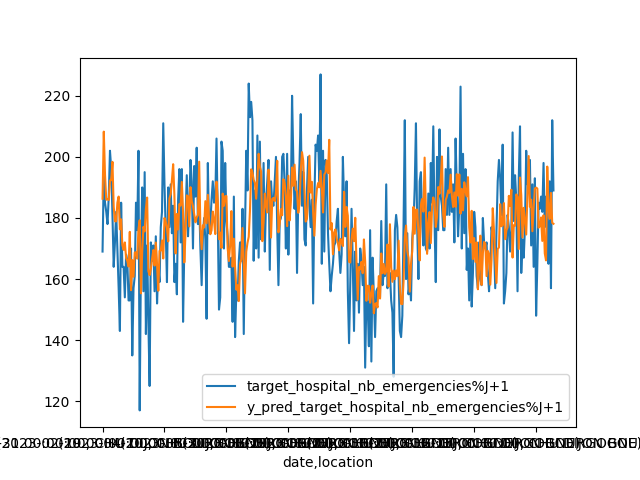

In [48]:
pd.concat([ground_truth, y_pred], axis=1).plot()

In [49]:

scores = ars_experiment.model.score_from_preds(y_pred, ground_truth, single_score=False)
mlflow.log_metrics(scores)


Scoring with rmse
rmse
16.716200292094936
Scoring with mae
mae
13.44656250836098
Scoring with mse
mse
279.4313522054348
Scoring with w_rmse
w_rmse
25.352388793218566
Scoring with pw_rmse
pw_rmse
26.22119697876606
Scoring with ew_rmse
ew_rmse
117.54811778607926
Scoring with msle
msle
0.009126729529860293
Scoring with rmsle
rmsle
0.09553391821683173
Scoring with r2
r2
0.19371187504642406
Scoring with mqe
mqe
245792.57418106077
Scoring with msse
msse
104.6513743323494
Scoring with pinball
pinball
6.72328125418049
Scoring with gamma-deviance
gamma-deviance
0.009067428813334088
Scoring with tweedie-nloglik@1.7
tweedie-nloglik_1.7
279.4313522054348
Scoring with poisson-nloglik
poisson-nloglik
1.5859255411747175
Scoring with max_error
max_error
62.26341247558594
Scoring with explained_variance
explained_variance
0.20013708547089049


In [50]:
print(scores)


{'rmse': 16.716200292094936, 'mae': 13.44656250836098, 'mse': 279.4313522054348, 'w_rmse': 25.352388793218566, 'pw_rmse': 26.22119697876606, 'ew_rmse': 117.54811778607926, 'msle': 0.009126729529860293, 'rmsle': 0.09553391821683173, 'r2': 0.19371187504642406, 'mqe': 245792.57418106077, 'msse': 104.6513743323494, 'pinball': 6.72328125418049, 'gamma-deviance': 0.009067428813334088, 'tweedie-nloglik_1.7': 279.4313522054348, 'poisson-nloglik': 1.5859255411747175, 'max_error': 62.26341247558594, 'explained_variance': 0.20013708547089049}


In [51]:
y_pred

y_pred_target_hospital_nb_emergencies%J+1
date       location                                                      
2022-12-31 CHU DIJON BOURGOGNE                                 186.306000
2023-01-01 CHU DIJON BOURGOGNE                                 208.263000
2023-01-02 CHU DIJON BOURGOGNE                                 194.064819
2023-01-03 CHU DIJON BOURGOGNE                                 185.979233
2023-01-04 CHU DIJON BOURGOGNE                                 186.153030
...                                                                   ...
2023-12-26 CHU DIJON BOURGOGNE                                 183.317963
2023-12-27 CHU DIJON BOURGOGNE                                 179.691757
2023-12-28 CHU DIJON BOURGOGNE                                 188.200623
2023-12-29 CHU DIJON BOURGOGNE                                 178.387909
2023-12-30 CHU DIJON BOURGOGNE                                 178.103821

[365 rows x 1 columns]

In [52]:
ground_truth

target_hospital_nb_emergencies%J+1
date       location                                               
2022-12-31 CHU DIJON BOURGOGNE                               169.0
2023-01-01 CHU DIJON BOURGOGNE                               195.0
2023-01-02 CHU DIJON BOURGOGNE                               185.0
2023-01-03 CHU DIJON BOURGOGNE                               182.0
2023-01-04 CHU DIJON BOURGOGNE                               178.0
...                                                            ...
2023-12-26 CHU DIJON BOURGOGNE                               165.0
2023-12-27 CHU DIJON BOURGOGNE                               192.0
2023-12-28 CHU DIJON BOURGOGNE                               157.0
2023-12-29 CHU DIJON BOURGOGNE                               212.0
2023-12-30 CHU DIJON BOURGOGNE                               189.0

[365 rows x 1 columns]

root 2024-12-24 12:02:09,073: INFO: Plotting the results...
matplotlib.legend 2024-12-24 12:02:09,084: WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


DatetimeIndex(['2022-12-31', '2023-01-01', '2023-01-02', '2023-01-03',
               '2023-01-04', '2023-01-05', '2023-01-06', '2023-01-07',
               '2023-01-08', '2023-01-09',
               ...
               '2023-12-21', '2023-12-22', '2023-12-23', '2023-12-24',
               '2023-12-25', '2023-12-26', '2023-12-27', '2023-12-28',
               '2023-12-29', '2023-12-30'],
              dtype='datetime64[ns]', name='date', length=365, freq=None)


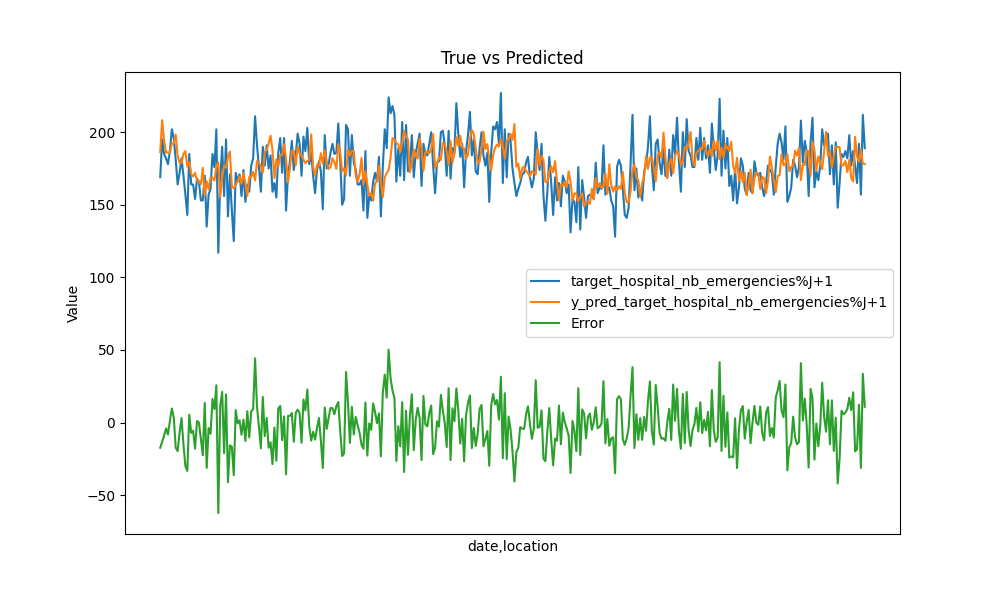

In [53]:
signature = infer_signature(ars_experiment.dataset.enc_X_test, y_pred)
mlflow.sklearn.log_model(ars_experiment.model, "model", signature=signature)
figure, ax = ars_experiment.plot(y_pred, ground_truth)
mlflow.log_figure(figure, 'predictions.png')
plt.show()


Taille de y : 365, Taille de y_pred : 365
                                target_hospital_nb_emergencies%J+1
date       location                                               
2022-12-31 CHU DIJON BOURGOGNE                               169.0
2023-01-01 CHU DIJON BOURGOGNE                               195.0
2023-01-02 CHU DIJON BOURGOGNE                               185.0
2023-01-03 CHU DIJON BOURGOGNE                               182.0
2023-01-04 CHU DIJON BOURGOGNE                               178.0
...                                                            ...
2023-12-26 CHU DIJON BOURGOGNE                               165.0
2023-12-27 CHU DIJON BOURGOGNE                               192.0
2023-12-28 CHU DIJON BOURGOGNE                               157.0
2023-12-29 CHU DIJON BOURGOGNE                               212.0
2023-12-30 CHU DIJON BOURGOGNE                               189.0

[365 rows x 1 columns]
                                y_pred_target_hospital_nb_emerg

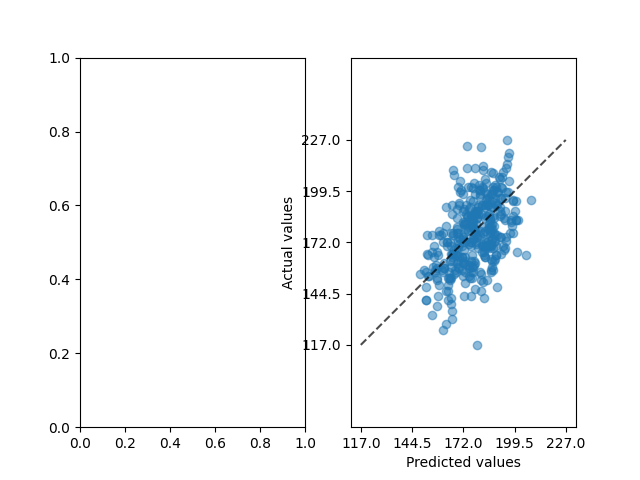

In [54]:
error_fig = ars_experiment.model.get_prediction_error_display(y=ground_truth, y_pred=y_pred)
mlflow.log_figure(error_fig, 'errors.png')

In [55]:
ars_experiment.run_nb += 1
mlflow.end_run()

2024/12/24 12:02:10 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/12/24 12:02:10 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


🏃 View run run_0 at: http://127.0.0.1:8080/#/experiments/881342090128877536/runs/ebe422e602474f929f9b5d5699dfa8e4
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/881342090128877536


In [56]:
import xgboost as xgb

In [57]:
model: Model = ars_experiment.model
best_estimator: xgb.XGBModel = model.best_estimator_
booster: xgb.Booster = best_estimator.get_booster()


In [58]:
print("Model Parameters:")
for param in best_estimator.get_xgb_params().keys():
    print(f"{param}: {best_estimator.get_xgb_params()[param]}")


Model Parameters:
objective: reg:squarederror
base_score: None
booster: None
colsample_bylevel: None
colsample_bynode: None
colsample_bytree: None
device: cuda
gamma: None
grow_policy: None
interaction_constraints: None
learning_rate: 0.1
max_bin: None
max_cat_threshold: None
max_cat_to_onehot: None
max_delta_step: None
max_depth: 6
max_leaves: None
min_child_weight: None
monotone_constraints: None
multi_strategy: None
n_jobs: None
num_parallel_tree: None
random_state: None
reg_alpha: None
reg_lambda: None
sampling_method: None
scale_pos_weight: None
subsample: None
tree_method: hist
validate_parameters: None
verbosity: 0
disable_default_eval_metric: True


In [59]:
print("\nFeature Importances:")
print(best_estimator.feature_importances_)


Feature Importances:
[6.68894718e-05 2.44785333e-04 4.54911904e-04 1.93489162e-04
 1.54700378e-04 1.69995168e-04 3.78868543e-04 1.11624555e-04
 3.80432408e-04 3.51565192e-04 2.41642279e-04 3.42133513e-04
 3.39151273e-04 1.42869772e-04 2.75659957e-04 3.03305715e-04
 5.15628199e-04 2.58313579e-04 1.27380947e-04 2.14936401e-04
 2.49706296e-04 3.56394070e-04 3.72757029e-04 2.06061100e-04
 4.91475570e-04 2.35009182e-04 2.95956677e-04 4.47937433e-04
 3.76209588e-04 2.43773611e-04 1.57011731e-04 4.44873003e-04
 1.66764046e-04 3.65171145e-04 3.06784583e-04 2.48999248e-04
 1.53195753e-04 5.58627769e-04 3.15315032e-04 3.80417769e-04
 1.55684538e-04 4.90608916e-04 3.22494365e-04 6.00850966e-04
 2.36026855e-04 2.90675845e-04 2.68834148e-04 4.33746231e-04
 5.10735903e-04 4.13431320e-04 2.85889342e-04 4.46312362e-04
 3.98146425e-04 4.67181904e-04 2.08908939e-04 2.15340770e-04
 7.31063657e-04 3.64825770e-04 4.06512438e-04 7.70039216e-04
 5.93890203e-04 4.45279467e-04 3.35005840e-04 4.68743820e-04
 5

In [60]:
plt.close()

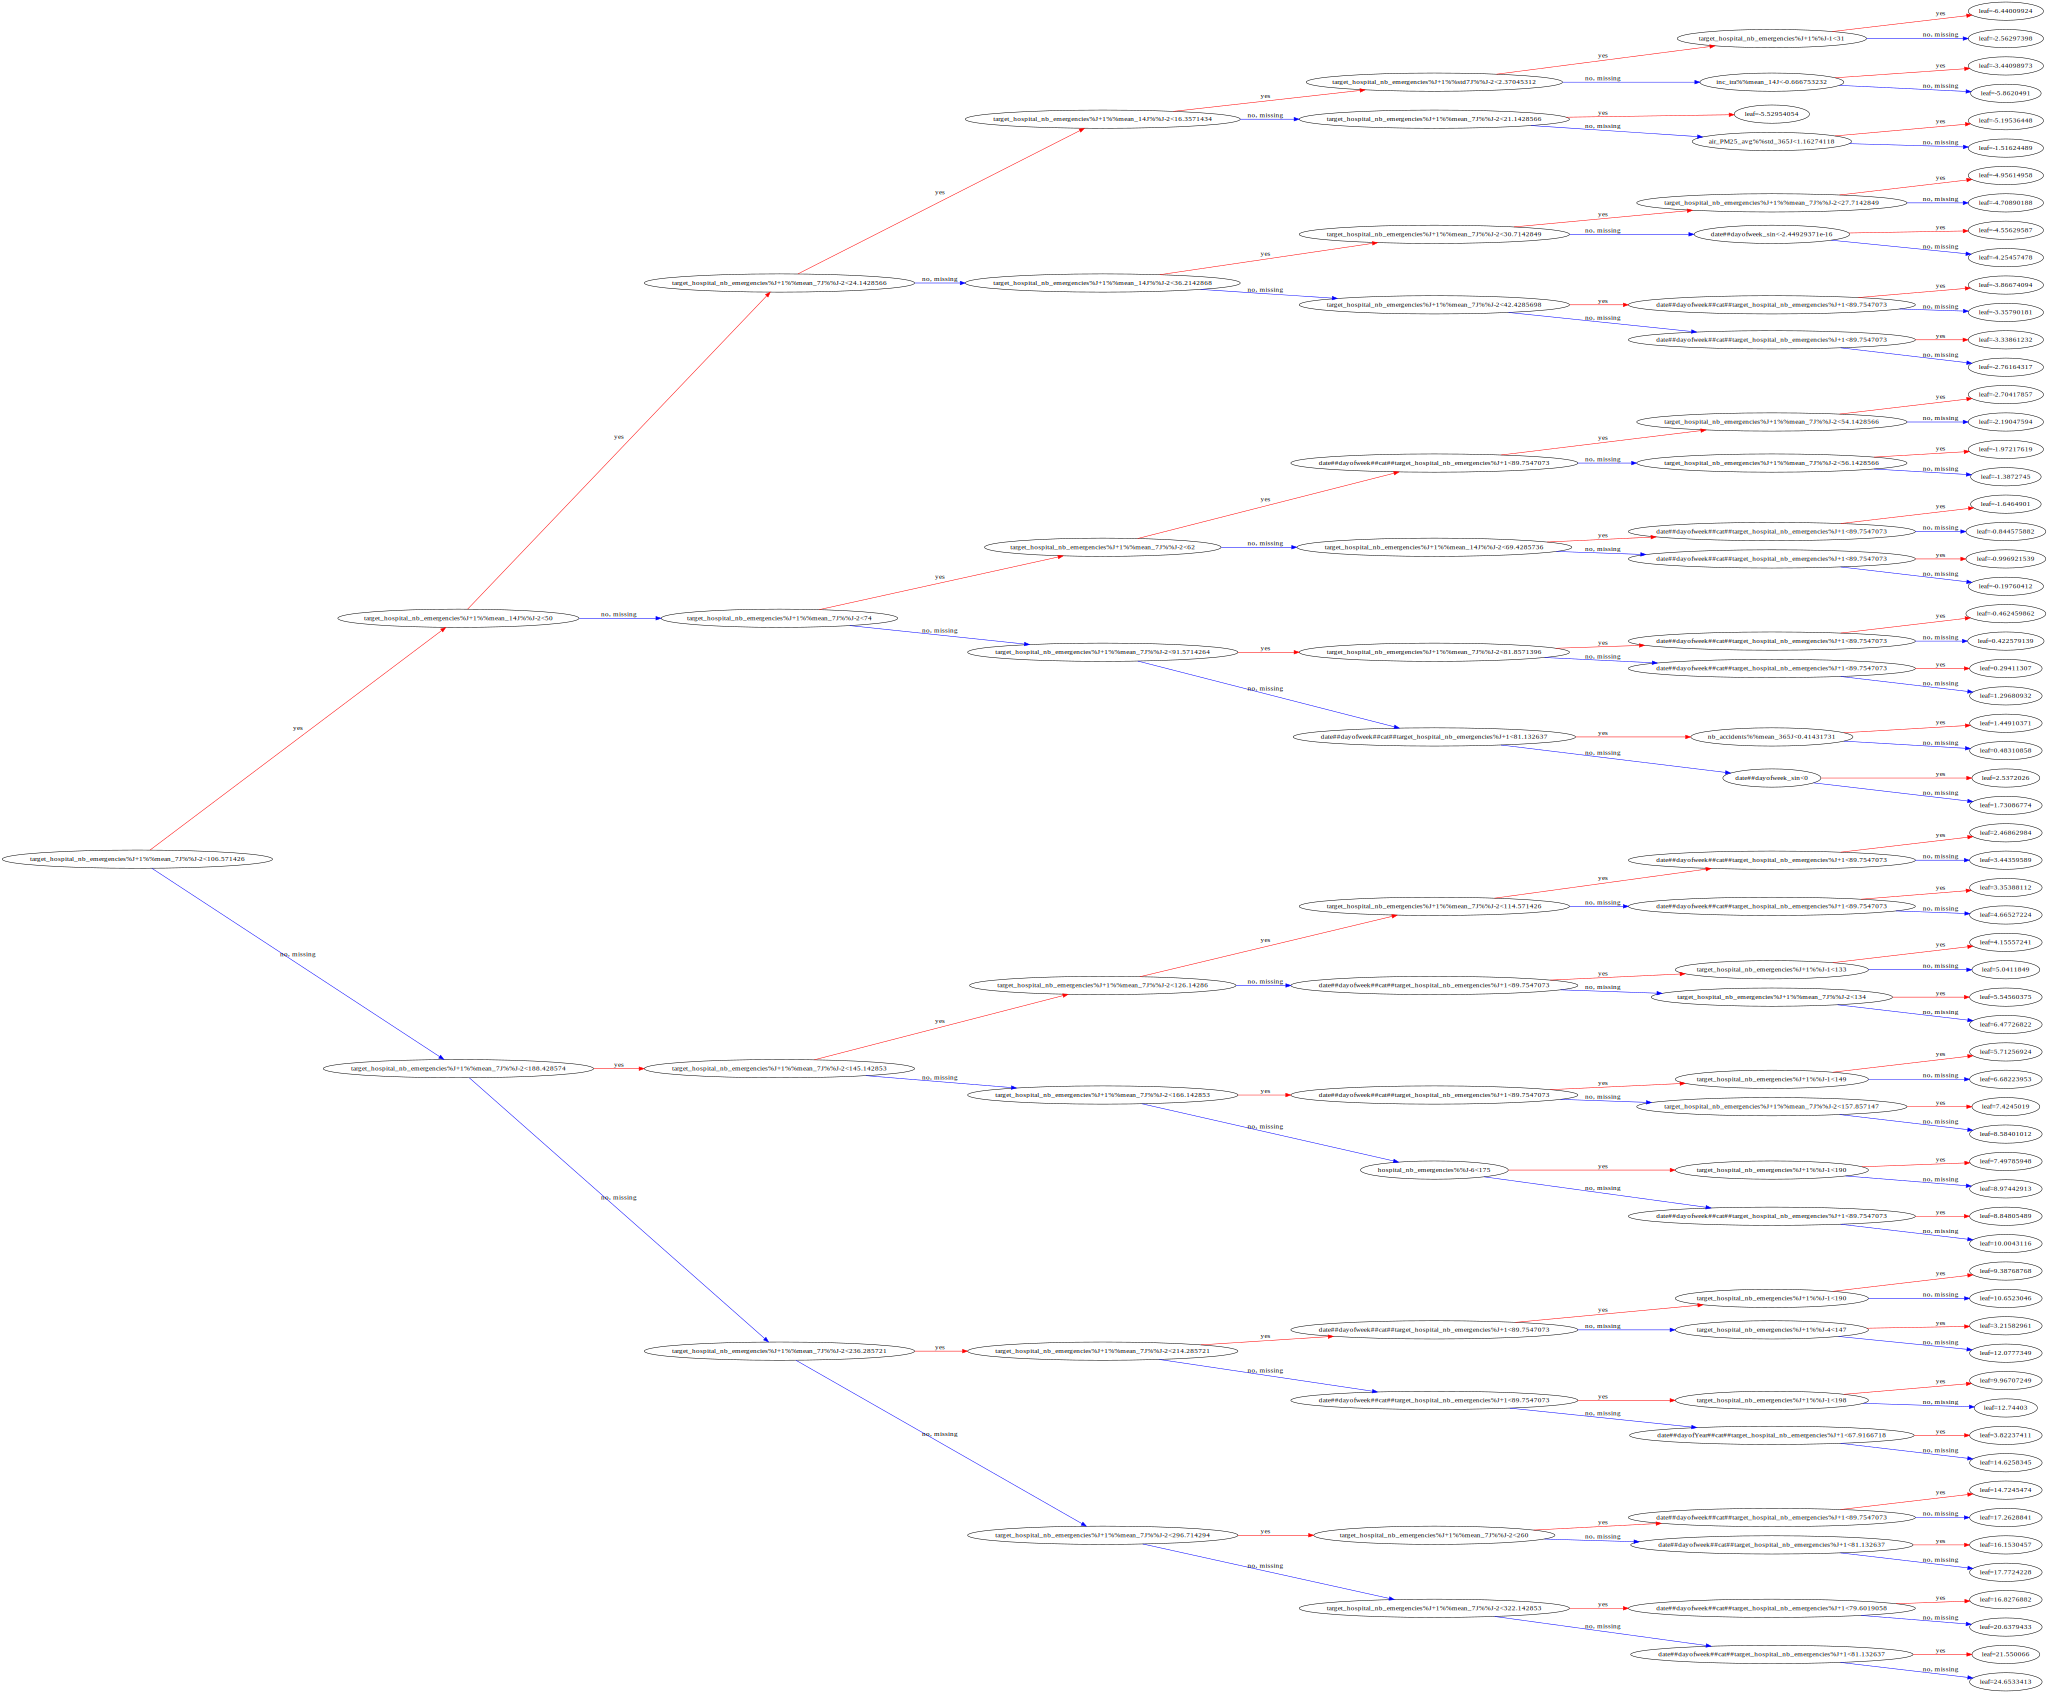

In [61]:
from xgboost import to_graphviz
# Exportez le premier arbre sous forme de fichier .dot ou directement en image
dot_graph = to_graphviz(best_estimator, num_trees=1, rankdir='LR')

# Sauvegardez l'arbre sous forme d'image
# dot_graph.render("tree_visualization", format="png")
dot_graph

In [62]:
# Un exemple pour déterminer l'importance des variables après un pré-apprentissage XGBoost
importance_gain = booster.get_score(importance_type='gain')
importance_cover = booster.get_score(importance_type='cover')
importance_weight = booster.get_score(importance_type='weight')

df_gain = pd.DataFrame.from_dict(importance_gain, orient='index', columns=['gain'])
df_cover = pd.DataFrame.from_dict(importance_cover, orient='index', columns=['cover'])
df_weight = pd.DataFrame.from_dict(importance_weight, orient='index', columns=['weight'])

df = df_gain.join(df_cover, how='outer').join(df_weight, how='outer')
df.fillna(0, inplace=True)  # Remplacer les valeurs manquantes par 0 si nécessaire

df = df_gain.join(df_cover, how='outer').join(df_weight, how='outer')
df.fillna(0, inplace=True)  # Remplacer les valeurs manquantes par 0 si nécessaire

df['gain_norm'] = df['gain'] / df['gain'].sum()
df['cover_norm'] = df['cover'] / df['cover'].sum()
df['weight_norm'] = df['weight'] / df['weight'].sum()

w_gain = 0.5
w_cover = 0.3
w_weight = 0.2

df['importance'] = (df['gain_norm'] * w_gain) + (df['cover_norm'] * w_cover) + (df['weight_norm'] * w_weight)

df.sort_values(by='importance', ascending=False, inplace=True)
df['rank'] = df['importance'].rank(ascending=False)

df.reset_index(inplace=True)
df.rename(columns={'index': 'feature'}, inplace=True)
# print(df[['feature', 'gain', 'cover', 'weight', 'importance', 'rank']])
# Sort features by importance
df_sorted = df.sort_values(by='importance', ascending=False)

# # Select only the 30 first features (based on sorted order)
df_sorted = df_sorted.nlargest(30, 'importance')

In [63]:
import matplotlib.pyplot as plt

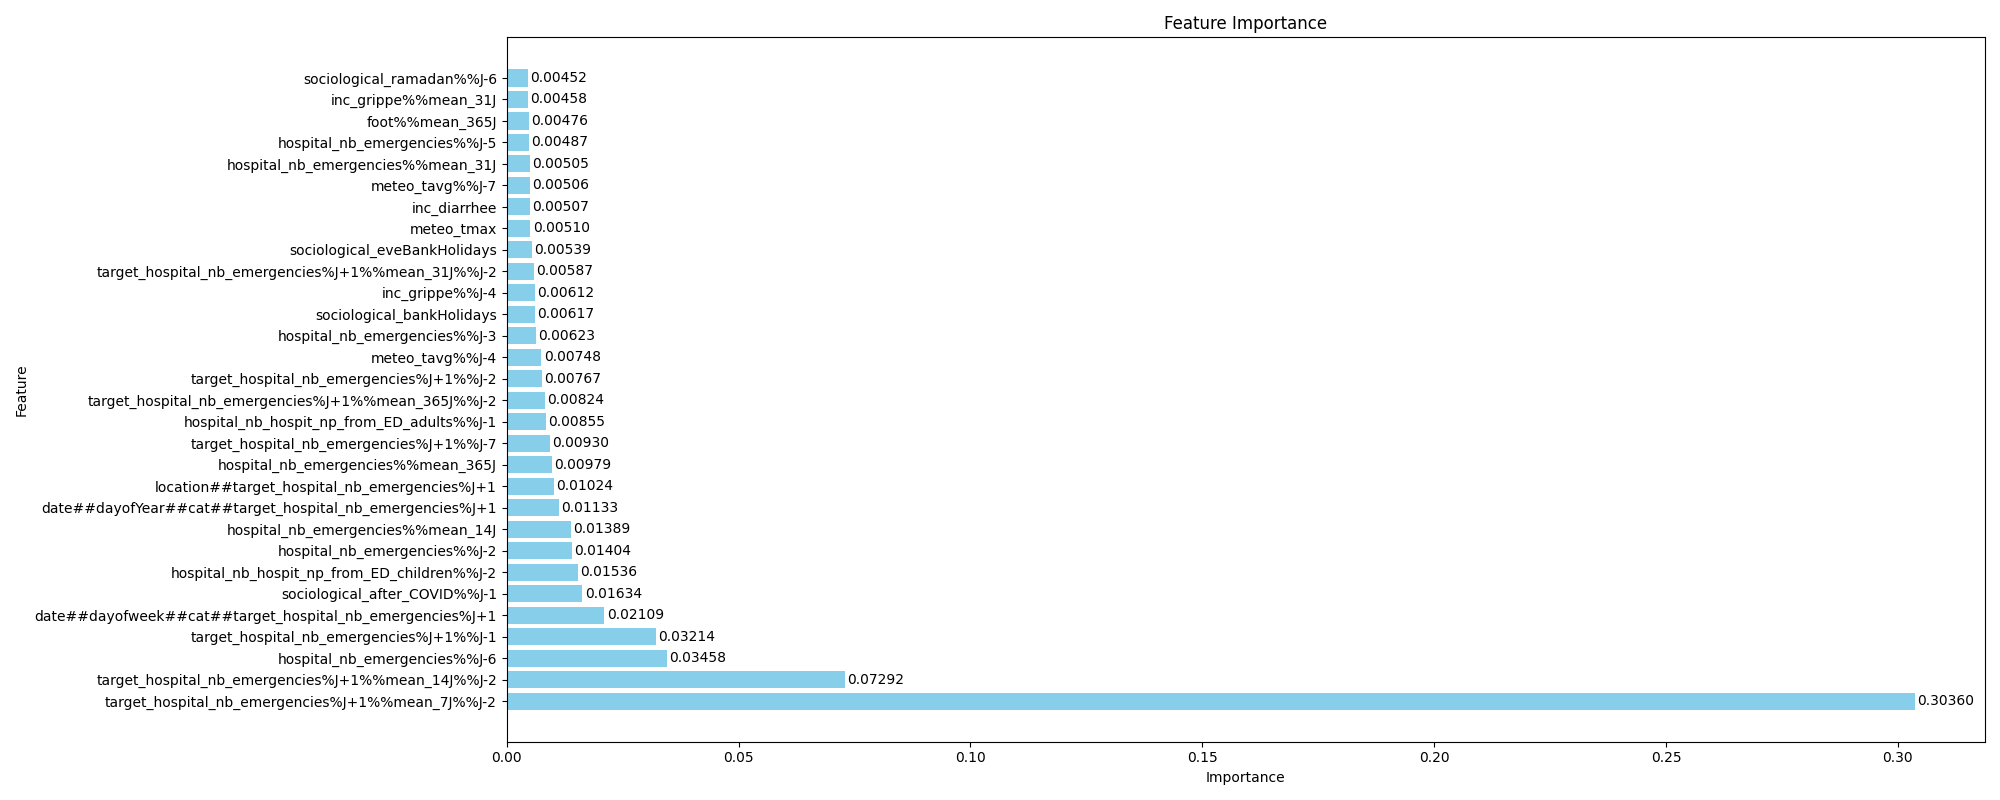

In [64]:
# Sort features by importance
df_sorted = df.sort_values(by='importance', ascending=False)

# # Select only the 30 first features (based on sorted order)
df_sorted = df_sorted.nlargest(30, 'importance')

# Plotting the horizontal bar chart
plt.figure(figsize=(20, 8))
plt.barh(df_sorted['feature'], df_sorted['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')

# Adding the importance values next to each bar
for index, value in enumerate(df_sorted['importance']):
    plt.text(value + 0.0005, index, f'{value:.5f}', va='center')
plt.tight_layout()
plt.show()

In [65]:
df_sorted['feature'].to_list()

['target_hospital_nb_emergencies%J+1%%mean_7J%%J-2',
 'target_hospital_nb_emergencies%J+1%%mean_14J%%J-2',
 'hospital_nb_emergencies%%J-6',
 'target_hospital_nb_emergencies%J+1%%J-1',
 'date##dayofweek##cat##target_hospital_nb_emergencies%J+1',
 'sociological_after_COVID%%J-1',
 'hospital_nb_hospit_np_from_ED_children%%J-2',
 'hospital_nb_emergencies%%J-2',
 'hospital_nb_emergencies%%mean_14J',
 'date##dayofYear##cat##target_hospital_nb_emergencies%J+1',
 'location##target_hospital_nb_emergencies%J+1',
 'hospital_nb_emergencies%%mean_365J',
 'target_hospital_nb_emergencies%J+1%%J-7',
 'hospital_nb_hospit_np_from_ED_adults%%J-1',
 'target_hospital_nb_emergencies%J+1%%mean_365J%%J-2',
 'target_hospital_nb_emergencies%J+1%%J-2',
 'meteo_tavg%%J-4',
 'hospital_nb_emergencies%%J-3',
 'sociological_bankHolidays',
 'inc_grippe%%J-4',
 'target_hospital_nb_emergencies%J+1%%mean_31J%%J-2',
 'sociological_eveBankHolidays',
 'meteo_tmax',
 'inc_diarrhee',
 'meteo_tavg%%J-7',
 'hospital_nb_emergenc

In [66]:
df_sorted.to_csv("feature_importance.csv")

In [67]:
X_train = ars_experiment.dataset.enc_X_train
X_test = ars_experiment.dataset.enc_X_test
X_val = ars_experiment.dataset.enc_X_val

y_train = ars_experiment.dataset.y_train
y_test = ars_experiment.dataset.y_test
y_val = ars_experiment.dataset.y_val

In [68]:
def recursive_prediction(dataset: BaseTabularDataset):
    predictions = pd.DataFrame(index=dataset.y_test.index)
    predictions['preds'] = np.nan
    for i in predictions.index[6:]:
        df_copy = dataset.enc_X_test
        # print(f'{i}')

        # Remplacer les valeurs réelles par les valeurs prédites
        for j in range(6, 0, -1):
            # print(f'on prédit J-{j} et on place cette prédiction dans les colonnes d\'historique des jours d\'historiques suivant')
            # print(pd.DataFrame(df_copy.loc[i - dt.timedelta(days=j)]).T)
            prediction = model.predict(pd.DataFrame(df_copy.loc[i - dt.timedelta(days=j)]).T)[0]
            # print(prediction)
            is_last_history_day = True
            for k in range(j-1, 0, -1):
                # print(f'on place la prédiction de J-{j} dans timeserie_J-{j-k} de la ligne J-{k}')
                df_copy.loc[i - dt.timedelta(days=k), f'target_nb_vers_hospit%J+3%mean_3J%%J-{j-k}'] = prediction
                is_last_history_day = False
            if is_last_history_day:
                print(f'prediction pour le {i}: {prediction}')
                predictions.loc[i, 'preds'] = prediction

    return predictions

In [69]:
preds = recursive_prediction(ars_experiment.dataset)

TypeError: unsupported operand type(s) for -: 'tuple' and 'datetime.timedelta'

In [ ]:
ars_experiment.plot(ars_experiment.dataset, preds)

In [ ]:
import shap
shap.initjs()
explainer = explainer_xgb = shap.TreeExplainer(best_estimator)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)

In [ ]:
shap.plots.beeswarm(shap_values=shap_values)

In [ ]:
shap.plots.force(explainer_xgb.expected_value, shap_values)

In [ ]:
# Run the experiment
# ars_experiment.run(dataset_config=get_dataset_config, model_config=model_config, find_best_features=True)

In [ ]:
# y_pred = ars_experiment.predict(ars_experiment.dataset)
# y_true = ars_experiment.dataset.y_test

In [ ]:
# ars_experiment.model.get_prediction_error_display(y_true, y_pred)

In [ ]:
# X_train.to_csv("X_train.csv", index=False)
# X_test.to_csv("X_test.csv", index=False)
# X_val.to_csv("X_val.csv", index=False)
# y_train.to_csv("y_train.csv", index=False)
# y_test.to_csv("y_test.csv", index=False)
# y_val.to_csv("y_val.csv", index=False)

In [ ]:
# model = ars_experiment.model

In [ ]:
# dataset = arsTabularDataset

In [ ]:
# dataset.enc_data.head()

In [ ]:
# df = dataset.enc_data
# df

In [ ]:
# from scipy.cluster import hierarchy
# from scipy.spatial.distance import squareform
# from scipy.stats import spearmanr
# import matplotlib.pyplot as plt
# import numpy as np

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# corr = spearmanr(X).correlation

# # Ensure the correlation matrix is symmetric
# corr = (corr + corr.T) / 2
# np.fill_diagonal(corr, 1)

# # We convert the correlation matrix to a distance matrix before performing
# # hierarchical clustering using Ward's linkage.
# distance_matrix = 1 - np.abs(corr)
# dist_linkage = hierarchy.ward(squareform(distance_matrix))
# dendro = hierarchy.dendrogram(
#     dist_linkage, labels=X.columns.to_list(), ax=ax1, leaf_rotation=90
# )
# dendro_idx = np.arange(0, len(dendro["ivl"]))

# ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
# ax2.set_xticks(dendro_idx)
# ax2.set_yticks(dendro_idx)
# ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
# ax2.set_yticklabels(dendro["ivl"])
# fig.tight_layout()

In [ ]:
# from shap_select import shap_select

In [ ]:
# selected_features_df = shap_select(model.best_estimator_, X_val, y_val, task="regression", threshold=0.05)

In [ ]:
# X_train

In [ ]:
# bst = model.best_estimator_.get_booster()

In [ ]:
# importance_gain = bst.get_score(importance_type='gain')
# importance_cover = bst.get_score(importance_type='cover')
# importance_weight = bst.get_score(importance_type='weight')

In [ ]:
# df_cover = pd.DataFrame(importance_cover, index=[0]).T
# df_gain = pd.DataFrame(importance_gain, index=[0]).T
# df_weight = pd.DataFrame(importance_weight, index=[0]).T

In [ ]:
# df_cover.shape

In [ ]:
# df_cover.sort_values(by=0).plot(kind="barh", figsize=(15,20))
# df_gain.sort_values(by=0).plot(kind="barh", figsize=(15,20))
# df_weight.sort_values(by=0).plot(kind="barh", figsize=(15,20))

In [ ]:
# model.shapley_additive_explanation(X_test, outname='shap_b', dir_output='.', mode="beeswarm", figsize=(50, 25))

In [ ]:
# from collections import defaultdict

# cluster_ids = hierarchy.fcluster(dist_linkage, 1, criterion="distance")
# cluster_id_to_feature_ids = defaultdict(list)
# for idx, cluster_id in enumerate(cluster_ids):
#     cluster_id_to_feature_ids[cluster_id].append(idx)
# selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
# selected_features_names = X.columns[selected_features]
# X_train_sel = X_train[selected_features_names]
# X_test_sel = X_test[selected_features_names]
# X_val_sel = X_val[selected_features_names]
# model_config['fit_params'].update({'eval_set': [(X_val_sel, y_val[target]) for target in ars_experiment.dataset.targets_names]})
# model.fit(X_train_sel, y_train, **model_config)
# print(
#     "Baseline accuracy on test data with features removed:"
#     f" {model.score(X_test_sel, y_test):.2}"
# )


In [ ]:
# import matplotlib

# from sklearn.inspection import permutation_importance
# from sklearn.utils.fixes import parse_version


# def plot_permutation_importance(clf, X, y, ax):
#     result = permutation_importance(clf, X, y, n_repeats=10, random_state=42)
#     perm_sorted_idx = result.importances_mean.argsort()

#     # `labels` argument in boxplot is deprecated in matplotlib 3.9 and has been
#     # renamed to `tick_labels`. The following code handles this.
#     tick_labels_parameter_name = (
#         "tick_labels"
#         if parse_version(matplotlib.__version__) >= parse_version("3.9")
#         else "labels"
#     )
#     tick_labels_dict = {tick_labels_parameter_name: X.columns[perm_sorted_idx]}
#     ax.boxplot(result.importances[perm_sorted_idx].T, vert=False, **tick_labels_dict)
#     ax.axvline(x=0, color="k", linestyle="--")
#     return ax


In [ ]:
# fig, ax = plt.subplots(figsize=(7, 6))
# plot_permutation_importance(model, X_test_sel, y_test, ax)
# ax.set_title("Permutation Importances on selected subset of features\n(test set)")
# ax.set_xlabel("Decrease in accuracy score")
# ax.figure.tight_layout()
# plt.show()

In [ ]:
# get the first line of x train
# X_train_sel[:1]

In [ ]:
# y_train[:1]

In [ ]:
# model.predict(X_train_sel[:1])

In [ ]:
# import shap
# shap.initjs()
# explainer_xgb = shap.TreeExplainer(model.best_estimator_)
# single_explanation = explainer_xgb.shap_values(X_train_sel[:1])
# shap.summary_plot(single_explanation, X_test_sel, plot_type="bar")


In [ ]:
# X_train.columns

In [ ]:
# model = ars_experiment.model

In [ ]:
# X_train = ars_experiment.dataset.enc_X_train
# X_test = ars_experiment.dataset.enc_X_test
# X_val = ars_experiment.dataset.enc_X_val

# y_train = ars_experiment.dataset.y_train
# y_test = ars_experiment.dataset.y_test
# y_val = ars_experiment.dataset.y_val

In [ ]:
# explainer_xgb = shap.TreeExplainer(model.best_estimator_)

In [ ]:
# single_explanation = explainer_xgb.shap_values(X_train[:1])

In [ ]:
# shap_values_xgb = explainer_xgb.shap_values(X_test[:50])

In [ ]:
# shap.dependence_plot('inc_grippe', shap_values_xgb, X_train_sel)

In [ ]:
# shap_values_xgb